In [1]:
!pip install xgboost


In [2]:
!pip install bayesian-optimization

  Stored in directory: C:\Users\Gowshalini\AppData\Local\pip\Cache\wheels\1d\0d\3b\6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [115]:
import pandas as pd 
import numpy as np 
import itertools 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB   #Naive bayes
from sklearn.svm import SVC  #SVM
from sklearn.linear_model import Perceptron     #NN
from sklearn.neural_network import MLPClassifier #NN
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization

In [117]:
dfpheme= pd.read_csv("pheme_dataset.csv")
dfcsv = pd.read_csv('fake_or_real_news.csv')
dfcsv=dfcsv.head(100)

In [118]:
dfLIAR= pd.read_csv("LIAR.csv")
dfbuzzfeed= pd.read_csv("buzzfeed.csv")
dfFakeNewsNet= pd.read_csv("FakeNewsNet.csv")

In [65]:
dfLIAR.head()


,text,label
0,Says the Annies List political group supports ...,FALSE
1,When did the decline of coal start? It started...,TRUE
2,"Hillary Clinton agrees with John McCain ""by vo...",TRUE
3,Health care reform legislation is likely to ma...,FALSE
4,The economic turnaround started at the end of ...,TRUE


In [66]:
dfbuzzfeed.head()


,text,label
0,abcnews.com.co,FAKE
1,adobochronicles.com,FAKE
2,alynews.com,FAKE
3,associatedmediacoverage.com,FAKE
4,baldwinpost.com,FAKE


In [67]:
dfFakeNewsNet.head()

,text,label
0,Did Miley Cyrus and Liam Hemsworth secretly ge...,FAKE
1,Paris Jackson & Cara Delevingne Enjoy Night Ou...,FAKE
2,Celebrities Join Tax March in Protest of Donal...,FAKE
3,Cindy Crawford's daughter Kaia Gerber wears a ...,FAKE
4,Full List of 2018 Oscar Nominations – Variety,FAKE


In [68]:
dfpheme.head()

,Unnamed: 0,tweet_id,text,label
0,0,"""552784600502915072""",Charlie Hebdo became well known for publishing...,REAL
1,0,"""552784898743099392""",Charlie Hebdo’s Last Tweet Before Shootings ht...,REAL
2,0,"""552785391653494784""",Prediction: the #CharlieHebdo massacre will no...,REAL
3,0,"""552786116404072448""",10:28am Charlie Hebdo account mocks ISIS leade...,REAL
4,0,"""552786299875520512""",If your faith isn't strong enough to cope with...,REAL


In [116]:
dftext=pd.DataFrame()

def createTrainTestDataset(df):
    df['label'] = df['label'].apply(lambda x:0 if x=='FAKE' else 
                           1 if x=='REAL' else 
                           None)
    global dftext
    dftext =dftext.append(df)
    
def createTrainTestDataset1(df):
    df['label'] = df['label'].apply(lambda x:0 if x=='FALSE' else 
                           1 if x=='TRUE' else 
                           None)
    global dftext
    dftext =dftext.append(df)
    

    
    

In [4]:
createTrainTestDataset(dfpheme[['text','label']])
createTrainTestDataset(dfcsv[['text','label']])

createTrainTestDataset1(dfLIAR[['text','label']])
createTrainTestDataset(dfbuzzfeed[['text','label']])
createTrainTestDataset(dfFakeNewsNet[['text','label']])

print(dftext)

                                                 text  label
0   Daniel Greenfield, a Shillman Journalism Fello...      0
1   Google Pinterest Digg Linkedin Reddit Stumbleu...      0
2   U.S. Secretary of State John F. Kerry said Mon...      1
3   — Kaydee King (@KaydeeKing) November 9, 2016 T...      0
4   It's primary day in New York and front-runners...      1
5     \nI’m not an immigrant, but my grandparents ...      0
6   Share This Baylee Luciani (left), Screenshot o...      0
7   A Czech stockbroker who saved more than 650 Je...      1
8   Hillary Clinton and Donald Trump made some ina...      1
9   Iranian negotiators reportedly have made a las...      1
10  CEDAR RAPIDS, Iowa — “I had one of the most wo...      1
11  Donald Trump’s organizational problems have go...      1
12  Click Here To Learn More About Alexandra's Per...      0
13  October 31, 2016 at 4:52 am \nPretty factual e...      0
14  Killing Obama administration rules, dismantlin...      1
15  As more women move i

C:\Users\Gowshalini\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [71]:
dftext.shape

(52905, 2)

In [72]:
dftext1=dftext
dftext1['label'] = dftext1['label'].apply(lambda x:'FAKE' if x==0 else 
                           'REAL' if x==1 else 
                           None)


Text(0,0.5,'Frequency')

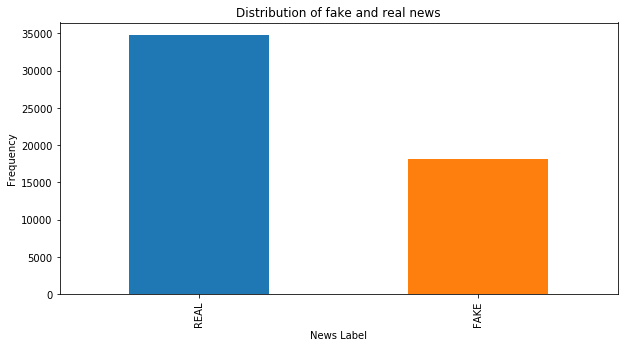

In [79]:
# dftext1
ax = dftext1['label'].value_counts().plot(kind='bar',
                                    figsize=(10,5),
                                    title="Distribution of fake and real news")
ax.set_xlabel("News Label")
ax.set_ylabel("Frequency")

In [5]:
y=dftext.label
x = dftext.drop('label', axis=1)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(dftext['text'], y, test_size=0.33, random_state=53)

# building vectorizer classifiers


In [7]:
# Initialize the `count_vectorizer`   
# ngram_range=(1, 2) means include 1-grams and 2-grams  
count_vectorizer = CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1, 2)) 

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [8]:
# Initialize the `tfidf_vectorizer` 
# The parameter of use_idf=True enables inverse-document-frequency reweighting by taking the log of the ratio of the 
# total number of documents to the number of documents contacting the term. And smooth_idf=True adds 1 to document 
# frequencies to avoid division by zero,so we can measure the frequency of a term among documents for 
# sure.

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7,use_idf=True ,smooth_idf=True) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

tfidf_test

<33x7336 sparse matrix of type '<class 'numpy.float64'>'
	with 5281 stored elements in Compressed Sparse Row format>

# Algorithm

In [9]:
dfftfidf= pd.DataFrame()
dffcnt= pd.DataFrame()


def modeltfidf(model,modelname):
    model.fit(tfidf_train, y_train)
    pred = model.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    all_accuracies = cross_val_score(estimator=model, X=tfidf_train, y=y_train, cv=5) 
    print("accuracy:   %0.3f" % score)
    print("cross validation score: {}".format(all_accuracies.mean()))
    print('Precision Score : ' + str(precision_score(y_test,pred)))
    print('Recall Score : ' + str(recall_score(y_test,pred)))
    print('F1 Score : ' + str(f1_score(y_test,pred)))
    
    savedf1=  pd.DataFrame({'pred':pred})
    savedf1 = savedf1.reset_index(drop=True)

    savedf2 = pd.DataFrame(y_test[::1])
    savedf2 = savedf2.reset_index(drop=True)   # drop old index column and create new index column
    
    finaldf = savedf2.join(savedf1)
    finaldf = finaldf.rename(columns ={'label':'actual'})
#     print(finaldf)
    finaldf['model'] = modelname
    
    #Predict probability
    probs = model.predict_proba(tfidf_test)       # predict probabilities
    # keep the predictions for class 1 only
    probs = probs[:, 1]
    len(probs)
    probdf = pd.DataFrame(probs)
    probdf = probdf.rename(columns={0:'prob'})
#     print(probdf)
    aaa = finaldf.join(probdf)
    
    global dfftfidf
    dfftfidf = dfftfidf.append(aaa)
    
def modelbagofwords(model,modelname):
    model.fit(count_train, y_train)
    pred = model.predict(count_test)
    score = metrics.accuracy_score(y_test, pred)
    all_accuracies = cross_val_score(estimator=model, X=count_train, y=y_train, cv=5) 

    print("accuracy:   %0.3f" % score)
    print("cross validation score: {}".format(all_accuracies.mean()))
    print('Precision Score : ' + str(precision_score(y_test,pred)))
    print('Recall Score : ' + str(recall_score(y_test,pred)))
    print('F1 Score : ' + str(f1_score(y_test,pred)))
    
    savedf1=  pd.DataFrame({'pred':pred})
    savedf1 = savedf1.reset_index(drop=True)

    savedf2 = pd.DataFrame(y_test[::1])
    savedf2 = savedf2.reset_index(drop=True)   # drop old index column and create new index column
    
    finaldf = savedf2.join(savedf1)
    finaldf = finaldf.rename(columns ={'label':'actual'})
#     print(finaldf)
    finaldf['model'] = modelname
    
    #Predict probability
    probs = model.predict_proba(count_test)       # predict probabilities
    # keep the predictions for class 1 only
    probs = probs[:, 1]
    len(probs)
    probdf = pd.DataFrame(probs)
    probdf = probdf.rename(columns={0:'prob'})
#     print(probdf)
    aaa = finaldf.join(probdf)
    
    global dffcnt
    dffcnt = dffcnt.append(aaa)
  

## Naive_Bayes
-----------------------

#### The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).

In [21]:
nb = MultinomialNB()

In [22]:
modeltfidf(nb,"Naive_Bayes")
print(dfftfidf)

accuracy:   0.784
cross validation score: 0.7690135826008941
Precision Score : 0.7516547524490336
Recall Score : 0.9843966712898752
F1 Score : 0.8524245608767453
      actual  pred        model      prob
0          1     1  Naive_Bayes  0.859959
1          1     1  Naive_Bayes  0.999762
2          1     1  Naive_Bayes  0.899441
3          1     1  Naive_Bayes  0.939251
4          1     1  Naive_Bayes  0.851742
5          0     0  Naive_Bayes  0.191307
6          1     1  Naive_Bayes  0.752414
7          0     1  Naive_Bayes  0.588931
8          0     0  Naive_Bayes  0.460728
9          0     0  Naive_Bayes  0.458891
10         1     1  Naive_Bayes  0.975490
11         1     1  Naive_Bayes  0.784721
12         1     1  Naive_Bayes  0.737738
13         1     1  Naive_Bayes  0.989722
14         1     1  Naive_Bayes  0.509794
15         0     0  Naive_Bayes  0.437611
16         1     1  Naive_Bayes  0.952116
17         0     1  Naive_Bayes  0.666541
18         1     1  Naive_Bayes  0.94616

In [23]:
modelbagofwords(nb,"Naive_Bayes")
print(dffcnt)

accuracy:   0.854
cross validation score: 0.864269428994478
Precision Score : 0.8456751711263223
Recall Score : 0.9424410540915396
F1 Score : 0.891439816333224
      actual  pred        model           prob
0          1     1  Naive_Bayes   9.998806e-01
1          1     1  Naive_Bayes   1.000000e+00
2          1     1  Naive_Bayes   1.000000e+00
3          1     1  Naive_Bayes   1.000000e+00
4          1     1  Naive_Bayes   1.000000e+00
5          0     0  Naive_Bayes   5.462061e-99
6          1     1  Naive_Bayes   9.992430e-01
7          0     0  Naive_Bayes   4.806638e-01
8          0     0  Naive_Bayes   9.173751e-06
9          0     0  Naive_Bayes   2.322447e-03
10         1     1  Naive_Bayes   1.000000e+00
11         1     1  Naive_Bayes   8.642903e-01
12         1     1  Naive_Bayes   5.983305e-01
13         1     1  Naive_Bayes   9.999999e-01
14         1     0  Naive_Bayes   3.078159e-16
15         0     0  Naive_Bayes   3.087746e-88
16         1     1  Naive_Bayes   9.98219

#### Hyper parameter tuning

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [25]:
nb.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [26]:
pipelineNB = Pipeline((
    ('clf',MultinomialNB()),
    ))
    
parameterNB={
        'clf__alpha': [0.022,0.025, 0.028],
#         'vect__ngram_range': [(1, 1), (1, 2),(1,3)],
#         'vect__max_df': [ 0.7,0.8,0.9,1.0],
#         'vect__min_df': [1,2],

    }
    
gridnbtfidf = GridSearchCV(pipelineNB,parameterNB,scoring='accuracy', verbose=1)
gridnbcnt = GridSearchCV(pipelineNB,parameterNB,scoring='accuracy', verbose=1)


In [27]:
gridnbtfidf.fit(tfidf_train,y_train)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=(('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)),)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__alpha': [0.022, 0.025, 0.028]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [28]:

gridnbcnt.fit(count_train,y_train)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=(('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)),)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__alpha': [0.022, 0.025, 0.028]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [29]:
gridnbtfidf.best_params_


{'clf__alpha': 0.028}

In [30]:
gridnbcnt.best_params_


{'clf__alpha': 0.022}

In [31]:
gridnbtfidf.best_score_

0.8615601605728546

In [32]:
gridnbcnt.best_score_

0.8593902571335575

In [33]:
modeltfidf(MultinomialNB(alpha=0.028),"Naive_bayes_hyper_PT")
print(dfftfidf)

accuracy:   0.863
cross validation score: 0.8627523447415012
Precision Score : 0.8734720845721837
Recall Score : 0.9167822468793343
F1 Score : 0.8946032820165793
      actual  pred                 model      prob
0          1     1           Naive_Bayes  0.859959
1          1     1           Naive_Bayes  0.999762
2          1     1           Naive_Bayes  0.899441
3          1     1           Naive_Bayes  0.939251
4          1     1           Naive_Bayes  0.851742
5          0     0           Naive_Bayes  0.191307
6          1     1           Naive_Bayes  0.752414
7          0     1           Naive_Bayes  0.588931
8          0     0           Naive_Bayes  0.460728
9          0     0           Naive_Bayes  0.458891
10         1     1           Naive_Bayes  0.975490
11         1     1           Naive_Bayes  0.784721
12         1     1           Naive_Bayes  0.737738
13         1     1           Naive_Bayes  0.989722
14         1     1           Naive_Bayes  0.509794
15         0     0    

In [34]:
modelbagofwords(MultinomialNB(alpha=0.022),"Naive_bayes_hyper_PT")
print(dffcnt)

accuracy:   0.865
cross validation score: 0.8637279539873534
Precision Score : 0.8745460548035655
Recall Score : 0.9185159500693482
F1 Score : 0.8959918822932522
      actual  pred                 model           prob
0          1     1           Naive_Bayes   9.998806e-01
1          1     1           Naive_Bayes   1.000000e+00
2          1     1           Naive_Bayes   1.000000e+00
3          1     1           Naive_Bayes   1.000000e+00
4          1     1           Naive_Bayes   1.000000e+00
5          0     0           Naive_Bayes   5.462061e-99
6          1     1           Naive_Bayes   9.992430e-01
7          0     0           Naive_Bayes   4.806638e-01
8          0     0           Naive_Bayes   9.173751e-06
9          0     0           Naive_Bayes   2.322447e-03
10         1     1           Naive_Bayes   1.000000e+00
11         1     1           Naive_Bayes   8.642903e-01
12         1     1           Naive_Bayes   5.983305e-01
13         1     1           Naive_Bayes   9.999999e-0

## Logistic Regression
-------------------------------

In [35]:
lg = LogisticRegression()

In [36]:
lg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
modeltfidf(lg,"Logistic_Regression")

accuracy:   0.869
cross validation score: 0.8760989731840991
Precision Score : 0.8705082550987374
Recall Score : 0.9323855755894591
F1 Score : 0.9003850661309225


In [39]:
modelbagofwords(lg,"Logistic_Regression")

accuracy:   0.880
cross validation score: 0.874686345300832
Precision Score : 0.8855918232772833
Recall Score : 0.9313453536754508
F1 Score : 0.9078925130978537


#### Hyper parameter tuning

In [40]:
lg.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [41]:
pipelineLG = Pipeline((
    ('lr',LogisticRegression()),
    ))
    
parameterLG={
      'lr__penalty': ['l1', 'l2'],
      'lr__C': [1, 5, 10],
      'lr__max_iter': [20, 50, 100]
    }
    
gridlgtfidf = GridSearchCV(pipelineLG,parameterLG,scoring='accuracy', verbose=1)
gridlgcnt = GridSearchCV(pipelineLG,parameterLG,scoring='accuracy', verbose=1)





In [42]:
gridlgtfidf.fit(tfidf_train,y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   33.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=(('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)),)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lr__penalty': ['l1', 'l2'], 'lr__C': [1, 5, 10], 'lr__max_iter': [20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [43]:
gridlgcnt.fit(count_train,y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 12.6min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=(('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)),)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lr__penalty': ['l1', 'l2'], 'lr__C': [1, 5, 10], 'lr__max_iter': [20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [44]:
gridlgtfidf.best_params_


{'lr__C': 10, 'lr__max_iter': 20, 'lr__penalty': 'l2'}

In [45]:
gridlgcnt.best_params_


{'lr__C': 1, 'lr__max_iter': 20, 'lr__penalty': 'l2'}

In [46]:
gridlgtfidf.best_score_

0.8913963328631875

In [47]:
gridlgcnt.best_score_

0.8699142888141478

In [49]:
modeltfidf(LogisticRegression(C=10, max_iter= 20, penalty='l2'),"LogisticRegression_hyper_PT")


accuracy:   0.892
cross validation score: 0.895085867317612
Precision Score : 0.9019476158495635
Recall Score : 0.9313453536754508
F1 Score : 0.9164107813033096


In [50]:
modelbagofwords(LogisticRegression(C=1, max_iter= 20, penalty='l2'),"LogisticRegression_hyper_PT")

accuracy:   0.878
cross validation score: 0.874903618138314
Precision Score : 0.8830101873151496
Recall Score : 0.9316920943134536
F1 Score : 0.9066981609583263


## XGBoost
---------------------------

In [10]:
xg = XGBClassifier()


In [53]:
modeltfidf(xg,"XGBoost")

C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

accuracy:   0.837
cross validation score: 0.8293372270345012
Precision Score : 0.8203825463239689
Recall Score : 0.9518030513176144
F1 Score : 0.8812199036918138


In [54]:
modelbagofwords(xg,"XGBoost")

C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

accuracy:   0.838
cross validation score: 0.8330253923199147
Precision Score : 0.8223289315726291
Recall Score : 0.9500693481276006
F1 Score : 0.8815958815958816


#### Hyper parameter tuning
bayesian optimization:https://medium.com/spikelab/hyperparameter-optimization-using-bayesian-optimization-f1f393dcd36d

In [11]:
#reference:  https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
import xgboost as xgb


dtraintfidf = xgb.DMatrix(tfidf_train, label=y_train)
dtraincnt= xgb.DMatrix(count_train, label=y_train)
dtest = xgb.DMatrix(tfidf_test)

C:\Users\Gowshalini\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [56]:
dtraintfidf

In [57]:
def train_model_xg_tfidf(max_depth, 
                ntrees,
                min_rows, 
                learn_rate, 
                sample_rate, 
                col_sample_rate):
    params = {
        'max_depth': int(max_depth),
        'ntrees': int(ntrees),
        'min_rows': int(min_rows),
        'learn_rate':learn_rate,
        'sample_rate':sample_rate,
        'col_sample_rate':col_sample_rate
    }
#     model = XGBClassifier(nfolds=5,**params)
#     model.fit(count_train, y_train)
    cv_result = xgb.cv(params, dtraintfidf, num_boost_round=100, nfold=3)    

    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [12]:
def train_model_xg_cnt(max_depth, 
                ntrees,
                min_rows, 
                learn_rate, 
                sample_rate, 
                col_sample_rate):
    params = {
        'max_depth': int(max_depth),
        'ntrees': int(ntrees),
        'min_rows': int(min_rows),
        'learn_rate':learn_rate,
        'sample_rate':sample_rate,
        'col_sample_rate':col_sample_rate
    }
#     model = XGBClassifier(nfolds=5,**params)
#     model.fit(count_train, y_train)
    cv_result = xgb.cv(params, dtraincnt, num_boost_round=100, nfold=3)    

    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [13]:
bounds = {
    'max_depth':(5,10),
    'ntrees': (100,500),
    'min_rows':(10,30),
    'learn_rate':(0.001, 0.01),
    'sample_rate':(0.5,0.8),
    'col_sample_rate':(0.5,0.8)
}

In [60]:
optimizertfidf = BayesianOptimization(
    f=train_model_xg_tfidf,
    pbounds=bounds,
    random_state=1,
)

optimizertfidf.maximize(init_points=10, n_iter=2)

|   iter    |  target   | col_sa... | learn_... | max_depth | min_rows  |  ntrees   | sample... |
-------------------------------------------------------------------------------------------------
|  1        | -0.3243   |  0.6251   |  0.007483 |  5.001    |  16.05    |  158.7    |  0.5277   |
|  2        | -0.3254   |  0.5559   |  0.00411  |  6.984    |  20.78    |  267.7    |  0.7056   |
|  3        | -0.3243   |  0.5613   |  0.008903 |  5.137    |  23.41    |  266.9    |  0.6676   |
|  4        | -0.3212   |  0.5421   |  0.002783 |  9.004    |  29.37    |  225.4    |  0.7077   |
|  5        | -0.3243   |  0.7629   |  0.009051 |  5.425    |  10.78    |  167.9    |  0.7634   |
|  6        | -0.3212   |  0.5295   |  0.00479  |  9.789    |  20.66    |  376.8    |  0.5947   |
|  7        | -0.3243   |  0.706    |  0.008512 |  5.091    |  25.0     |  495.5    |  0.7244   |
|  8        | -0.3243   |  0.5841   |  0.008104 |  5.516    |  18.96    |  463.4    |  0.5881   |
|  9        | -0.324

In [14]:
optimizercnt = BayesianOptimization(
    f=train_model_xg_cnt,
    pbounds=bounds,
    random_state=1,
)

optimizercnt.maximize(init_points=10, n_iter=2)

|   iter    |  target   | col_sa... | learn_... | max_depth | min_rows  |  ntrees   | sample... |
-------------------------------------------------------------------------------------------------
|  1        | -0.4496   |  0.6251   |  0.007483 |  5.001    |  16.05    |  158.7    |  0.5277   |
|  2        | -0.4581   |  0.5559   |  0.00411  |  6.984    |  20.78    |  267.7    |  0.7056   |
|  3        | -0.4496   |  0.5613   |  0.008903 |  5.137    |  23.41    |  266.9    |  0.6676   |
|  4        | -0.4562   |  0.5421   |  0.002783 |  9.004    |  29.37    |  225.4    |  0.7077   |
|  5        | -0.4496   |  0.7629   |  0.009051 |  5.425    |  10.78    |  167.9    |  0.7634   |
|  6        | -0.4562   |  0.5295   |  0.00479  |  9.789    |  20.66    |  376.8    |  0.5947   |
|  7        | -0.4496   |  0.706    |  0.008512 |  5.091    |  25.0     |  495.5    |  0.7244   |
|  8        | -0.4496   |  0.5841   |  0.008104 |  5.516    |  18.96    |  463.4    |  0.5881   |
|  9        | -0.449

In [15]:
# paramtfidf = optimizertfidf.max
paramcnt = optimizercnt.max

In [16]:
# xgmodeltfidf = xgb.train(paramtfidf, dtraintfidf, num_boost_round=100)
xgmodelcnt = xgb.train(paramcnt, dtraincnt, num_boost_round=100)

In [64]:
# Predict on testing and training set
y_predtfidf = xgmodeltfidf.predict(dtest)
y_predtfidf_df = pd.DataFrame(data={'y':y_predtfidf}) 
y_predtfidf_df.round(0)
score = metrics.accuracy_score(y_test, y_predtfidf_df.round(0))
score



0.8751376348821845

In [17]:
# Predict on testing and training set
y_predcnt = xgmodelcnt.predict(dtest)
y_predcnt_df = pd.DataFrame(data={'y':y_predcnt}) 
y_predcnt_df.round(0)
score = metrics.accuracy_score(y_test, y_predcnt_df.round(0))
score


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693', 'f6694', 'f6695', 'f6696', 'f6697', 'f6698', 'f6699', 'f6700', 'f6701', 'f6702', 'f6703', 'f6704', 'f6705', 'f6706', 'f6707', 'f6708', 'f6709', 'f6710', 'f6711', 'f6712', 'f6713', 'f6714', 'f6715', 'f6716', 'f6717', 'f6718', 'f6719', 'f6720', 'f6721', 'f6722', 'f6723', 'f6724', 'f6725', 'f6726', 'f6727', 'f6728', 'f6729', 'f6730', 'f6731', 'f6732', 'f6733', 'f6734', 'f6735', 'f6736', 'f6737', 'f6738', 'f6739', 'f6740', 'f6741', 'f6742', 'f6743', 'f6744', 'f6745', 'f6746', 'f6747', 'f6748', 'f6749', 'f6750', 'f6751', 'f6752', 'f6753', 'f6754', 'f6755', 'f6756', 'f6757', 'f6758', 'f6759', 'f6760', 'f6761', 'f6762', 'f6763', 'f6764', 'f6765', 'f6766', 'f6767', 'f6768', 'f6769', 'f6770', 'f6771', 'f6772', 'f6773', 'f6774', 'f6775', 'f6776', 'f6777', 'f6778', 'f6779', 'f6780', 'f6781', 'f6782', 'f6783', 'f6784', 'f6785', 'f6786', 'f6787', 'f6788', 'f6789', 'f6790', 'f6791', 'f6792', 'f6793', 'f6794', 'f6795', 'f6796', 'f6797', 'f6798', 'f6799', 'f6800', 'f6801', 'f6802', 'f6803', 'f6804', 'f6805', 'f6806', 'f6807', 'f6808', 'f6809', 'f6810', 'f6811', 'f6812', 'f6813', 'f6814', 'f6815', 'f6816', 'f6817', 'f6818', 'f6819', 'f6820', 'f6821', 'f6822', 'f6823', 'f6824', 'f6825', 'f6826', 'f6827', 'f6828', 'f6829', 'f6830', 'f6831', 'f6832', 'f6833', 'f6834', 'f6835', 'f6836', 'f6837', 'f6838', 'f6839', 'f6840', 'f6841', 'f6842', 'f6843', 'f6844', 'f6845', 'f6846', 'f6847', 'f6848', 'f6849', 'f6850', 'f6851', 'f6852', 'f6853', 'f6854', 'f6855', 'f6856', 'f6857', 'f6858', 'f6859', 'f6860', 'f6861', 'f6862', 'f6863', 'f6864', 'f6865', 'f6866', 'f6867', 'f6868', 'f6869', 'f6870', 'f6871', 'f6872', 'f6873', 'f6874', 'f6875', 'f6876', 'f6877', 'f6878', 'f6879', 'f6880', 'f6881', 'f6882', 'f6883', 'f6884', 'f6885', 'f6886', 'f6887', 'f6888', 'f6889', 'f6890', 'f6891', 'f6892', 'f6893', 'f6894', 'f6895', 'f6896', 'f6897', 'f6898', 'f6899', 'f6900', 'f6901', 'f6902', 'f6903', 'f6904', 'f6905', 'f6906', 'f6907', 'f6908', 'f6909', 'f6910', 'f6911', 'f6912', 'f6913', 'f6914', 'f6915', 'f6916', 'f6917', 'f6918', 'f6919', 'f6920', 'f6921', 'f6922', 'f6923', 'f6924', 'f6925', 'f6926', 'f6927', 'f6928', 'f6929', 'f6930', 'f6931', 'f6932', 'f6933', 'f6934', 'f6935', 'f6936', 'f6937', 'f6938', 'f6939', 'f6940', 'f6941', 'f6942', 'f6943', 'f6944', 'f6945', 'f6946', 'f6947', 'f6948', 'f6949', 'f6950', 'f6951', 'f6952', 'f6953', 'f6954', 'f6955', 'f6956', 'f6957', 'f6958', 'f6959', 'f6960', 'f6961', 'f6962', 'f6963', 'f6964', 'f6965', 'f6966', 'f6967', 'f6968', 'f6969', 'f6970', 'f6971', 'f6972', 'f6973', 'f6974', 'f6975', 'f6976', 'f6977', 'f6978', 'f6979', 'f6980', 'f6981', 'f6982', 'f6983', 'f6984', 'f6985', 'f6986', 'f6987', 'f6988', 'f6989', 'f6990', 'f6991', 'f6992', 'f6993', 'f6994', 'f6995', 'f6996', 'f6997', 'f6998', 'f6999', 'f7000', 'f7001', 'f7002', 'f7003', 'f7004', 'f7005', 'f7006', 'f7007', 'f7008', 'f7009', 'f7010', 'f7011', 'f7012', 'f7013', 'f7014', 'f7015', 'f7016', 'f7017', 'f7018', 'f7019', 'f7020', 'f7021', 'f7022', 'f7023', 'f7024', 'f7025', 'f7026', 'f7027', 'f7028', 'f7029', 'f7030', 'f7031', 'f7032', 'f7033', 'f7034', 'f7035', 'f7036', 'f7037', 'f7038', 'f7039', 'f7040', 'f7041', 'f7042', 'f7043', 'f7044', 'f7045', 'f7046', 'f7047', 'f7048', 'f7049', 'f7050', 'f7051', 'f7052', 'f7053', 'f7054', 'f7055', 'f7056', 'f7057', 'f7058', 'f7059', 'f7060', 'f7061', 'f7062', 'f7063', 'f7064', 'f7065', 'f7066', 'f7067', 'f7068', 'f7069', 'f7070', 'f7071', 'f7072', 'f7073', 'f7074', 'f7075', 'f7076', 'f7077', 'f7078', 'f7079', 'f7080', 'f7081', 'f7082', 'f7083', 'f7084', 'f7085', 'f7086', 'f7087', 'f7088', 'f7089', 'f7090', 'f7091', 'f7092', 'f7093', 'f7094', 'f7095', 'f7096', 'f7097', 'f7098', 'f7099', 'f7100', 'f7101', 'f7102', 'f7103', 'f7104', 'f7105', 'f7106', 'f7107', 'f7108', 'f7109', 'f7110', 'f7111', 'f7112', 'f7113', 'f7114', 'f7115', 'f7116', 'f7117', 'f7118', 'f7119', 'f7120', 'f7121', 'f7122', 'f7123', 'f7124', 'f7125', 'f7126', 'f7127', 'f7128', 'f7129', 'f7130', 'f7131', 'f7132', 'f7133', 'f7134', 'f7135', 'f7136', 'f7137', 'f7138', 'f7139', 'f7140', 'f7141', 'f7142', 'f7143', 'f7144', 'f7145', 'f7146', 'f7147', 'f7148', 'f7149', 'f7150', 'f7151', 'f7152', 'f7153', 'f7154', 'f7155', 'f7156', 'f7157', 'f7158', 'f7159', 'f7160', 'f7161', 'f7162', 'f7163', 'f7164', 'f7165', 'f7166', 'f7167', 'f7168', 'f7169', 'f7170', 'f7171', 'f7172', 'f7173', 'f7174', 'f7175', 'f7176', 'f7177', 'f7178', 'f7179', 'f7180', 'f7181', 'f7182', 'f7183', 'f7184', 'f7185', 'f7186', 'f7187', 'f7188', 'f7189', 'f7190', 'f7191', 'f7192', 'f7193', 'f7194', 'f7195', 'f7196', 'f7197', 'f7198', 'f7199', 'f7200', 'f7201', 'f7202', 'f7203', 'f7204', 'f7205', 'f7206', 'f7207', 'f7208', 'f7209', 'f7210', 'f7211', 'f7212', 'f7213', 'f7214', 'f7215', 'f7216', 'f7217', 'f7218', 'f7219', 'f7220', 'f7221', 'f7222', 'f7223', 'f7224', 'f7225', 'f7226', 'f7227', 'f7228', 'f7229', 'f7230', 'f7231', 'f7232', 'f7233', 'f7234', 'f7235', 'f7236', 'f7237', 'f7238', 'f7239', 'f7240', 'f7241', 'f7242', 'f7243', 'f7244', 'f7245', 'f7246', 'f7247', 'f7248', 'f7249', 'f7250', 'f7251', 'f7252', 'f7253', 'f7254', 'f7255', 'f7256', 'f7257', 'f7258', 'f7259', 'f7260', 'f7261', 'f7262', 'f7263', 'f7264', 'f7265', 'f7266', 'f7267', 'f7268', 'f7269', 'f7270', 'f7271', 'f7272', 'f7273', 'f7274', 'f7275', 'f7276', 'f7277', 'f7278', 'f7279', 'f7280', 'f7281', 'f7282', 'f7283', 'f7284', 'f7285', 'f7286', 'f7287', 'f7288', 'f7289', 'f7290', 'f7291', 'f7292', 'f7293', 'f7294', 'f7295', 'f7296', 'f7297', 'f7298', 'f7299', 'f7300', 'f7301', 'f7302', 'f7303', 'f7304', 'f7305', 'f7306', 'f7307', 'f7308', 'f7309', 'f7310', 'f7311', 'f7312', 'f7313', 'f7314', 'f7315', 'f7316', 'f7317', 'f7318', 'f7319', 'f7320', 'f7321', 'f7322', 'f7323', 'f7324', 'f7325', 'f7326', 'f7327', 'f7328', 'f7329', 'f7330', 'f7331', 'f7332', 'f7333', 'f7334', 'f7335', 'f7336', 'f7337', 'f7338', 'f7339', 'f7340', 'f7341', 'f7342', 'f7343', 'f7344', 'f7345', 'f7346', 'f7347', 'f7348', 'f7349', 'f7350', 'f7351', 'f7352', 'f7353', 'f7354', 'f7355', 'f7356', 'f7357', 'f7358', 'f7359', 'f7360', 'f7361', 'f7362', 'f7363', 'f7364', 'f7365', 'f7366', 'f7367', 'f7368', 'f7369', 'f7370', 'f7371', 'f7372', 'f7373', 'f7374', 'f7375', 'f7376', 'f7377', 'f7378', 'f7379', 'f7380', 'f7381', 'f7382', 'f7383', 'f7384', 'f7385', 'f7386', 'f7387', 'f7388', 'f7389', 'f7390', 'f7391', 'f7392', 'f7393', 'f7394', 'f7395', 'f7396', 'f7397', 'f7398', 'f7399', 'f7400', 'f7401', 'f7402', 'f7403', 'f7404', 'f7405', 'f7406', 'f7407', 'f7408', 'f7409', 'f7410', 'f7411', 'f7412', 'f7413', 'f7414', 'f7415', 'f7416', 'f7417', 'f7418', 'f7419', 'f7420', 'f7421', 'f7422', 'f7423', 'f7424', 'f7425', 'f7426', 'f7427', 'f7428', 'f7429', 'f7430', 'f7431', 'f7432', 'f7433', 'f7434', 'f7435', 'f7436', 'f7437', 'f7438', 'f7439', 'f7440', 'f7441', 'f7442', 'f7443', 'f7444', 'f7445', 'f7446', 'f7447', 'f7448', 'f7449', 'f7450', 'f7451', 'f7452', 'f7453', 'f7454', 'f7455', 'f7456', 'f7457', 'f7458', 'f7459', 'f7460', 'f7461', 'f7462', 'f7463', 'f7464', 'f7465', 'f7466', 'f7467', 'f7468', 'f7469', 'f7470', 'f7471', 'f7472', 'f7473', 'f7474', 'f7475', 'f7476', 'f7477', 'f7478', 'f7479', 'f7480', 'f7481', 'f7482', 'f7483', 'f7484', 'f7485', 'f7486', 'f7487', 'f7488', 'f7489', 'f7490', 'f7491', 'f7492', 'f7493', 'f7494', 'f7495', 'f7496', 'f7497', 'f7498', 'f7499', 'f7500', 'f7501', 'f7502', 'f7503', 'f7504', 'f7505', 'f7506', 'f7507', 'f7508', 'f7509', 'f7510', 'f7511', 'f7512', 'f7513', 'f7514', 'f7515', 'f7516', 'f7517', 'f7518', 'f7519', 'f7520', 'f7521', 'f7522', 'f7523', 'f7524', 'f7525', 'f7526', 'f7527', 'f7528', 'f7529', 'f7530', 'f7531', 'f7532', 'f7533', 'f7534', 'f7535', 'f7536', 'f7537', 'f7538', 'f7539', 'f7540', 'f7541', 'f7542', 'f7543', 'f7544', 'f7545', 'f7546', 'f7547', 'f7548', 'f7549', 'f7550', 'f7551', 'f7552', 'f7553', 'f7554', 'f7555', 'f7556', 'f7557', 'f7558', 'f7559', 'f7560', 'f7561', 'f7562', 'f7563', 'f7564', 'f7565', 'f7566', 'f7567', 'f7568', 'f7569', 'f7570', 'f7571', 'f7572', 'f7573', 'f7574', 'f7575', 'f7576', 'f7577', 'f7578', 'f7579', 'f7580', 'f7581', 'f7582', 'f7583', 'f7584', 'f7585', 'f7586', 'f7587', 'f7588', 'f7589', 'f7590', 'f7591', 'f7592', 'f7593', 'f7594', 'f7595', 'f7596', 'f7597', 'f7598', 'f7599', 'f7600', 'f7601', 'f7602', 'f7603', 'f7604', 'f7605', 'f7606', 'f7607', 'f7608', 'f7609', 'f7610', 'f7611', 'f7612', 'f7613', 'f7614', 'f7615', 'f7616', 'f7617', 'f7618', 'f7619', 'f7620', 'f7621', 'f7622', 'f7623', 'f7624', 'f7625', 'f7626', 'f7627', 'f7628', 'f7629', 'f7630', 'f7631', 'f7632', 'f7633', 'f7634', 'f7635', 'f7636', 'f7637', 'f7638', 'f7639', 'f7640', 'f7641', 'f7642', 'f7643', 'f7644', 'f7645', 'f7646', 'f7647', 'f7648', 'f7649', 'f7650', 'f7651', 'f7652', 'f7653', 'f7654', 'f7655', 'f7656', 'f7657', 'f7658', 'f7659', 'f7660', 'f7661', 'f7662', 'f7663', 'f7664', 'f7665', 'f7666', 'f7667', 'f7668', 'f7669', 'f7670', 'f7671', 'f7672', 'f7673', 'f7674', 'f7675', 'f7676', 'f7677', 'f7678', 'f7679', 'f7680', 'f7681', 'f7682', 'f7683', 'f7684', 'f7685', 'f7686', 'f7687', 'f7688', 'f7689', 'f7690', 'f7691', 'f7692', 'f7693', 'f7694', 'f7695', 'f7696', 'f7697', 'f7698', 'f7699', 'f7700', 'f7701', 'f7702', 'f7703', 'f7704', 'f7705', 'f7706', 'f7707', 'f7708', 'f7709', 'f7710', 'f7711', 'f7712', 'f7713', 'f7714', 'f7715', 'f7716', 'f7717', 'f7718', 'f7719', 'f7720', 'f7721', 'f7722', 'f7723', 'f7724', 'f7725', 'f7726', 'f7727', 'f7728', 'f7729', 'f7730', 'f7731', 'f7732', 'f7733', 'f7734', 'f7735', 'f7736', 'f7737', 'f7738', 'f7739', 'f7740', 'f7741', 'f7742', 'f7743', 'f7744', 'f7745', 'f7746', 'f7747', 'f7748', 'f7749', 'f7750', 'f7751', 'f7752', 'f7753', 'f7754', 'f7755', 'f7756', 'f7757', 'f7758', 'f7759', 'f7760', 'f7761', 'f7762', 'f7763', 'f7764', 'f7765', 'f7766', 'f7767', 'f7768', 'f7769', 'f7770', 'f7771', 'f7772', 'f7773', 'f7774', 'f7775', 'f7776', 'f7777', 'f7778', 'f7779', 'f7780', 'f7781', 'f7782', 'f7783', 'f7784', 'f7785', 'f7786', 'f7787', 'f7788', 'f7789', 'f7790', 'f7791', 'f7792', 'f7793', 'f7794', 'f7795', 'f7796', 'f7797', 'f7798', 'f7799', 'f7800', 'f7801', 'f7802', 'f7803', 'f7804', 'f7805', 'f7806', 'f7807', 'f7808', 'f7809', 'f7810', 'f7811', 'f7812', 'f7813', 'f7814', 'f7815', 'f7816', 'f7817', 'f7818', 'f7819', 'f7820', 'f7821', 'f7822', 'f7823', 'f7824', 'f7825', 'f7826', 'f7827', 'f7828', 'f7829', 'f7830', 'f7831', 'f7832', 'f7833', 'f7834', 'f7835', 'f7836', 'f7837', 'f7838', 'f7839', 'f7840', 'f7841', 'f7842', 'f7843', 'f7844', 'f7845', 'f7846', 'f7847', 'f7848', 'f7849', 'f7850', 'f7851', 'f7852', 'f7853', 'f7854', 'f7855', 'f7856', 'f7857', 'f7858', 'f7859', 'f7860', 'f7861', 'f7862', 'f7863', 'f7864', 'f7865', 'f7866', 'f7867', 'f7868', 'f7869', 'f7870', 'f7871', 'f7872', 'f7873', 'f7874', 'f7875', 'f7876', 'f7877', 'f7878', 'f7879', 'f7880', 'f7881', 'f7882', 'f7883', 'f7884', 'f7885', 'f7886', 'f7887', 'f7888', 'f7889', 'f7890', 'f7891', 'f7892', 'f7893', 'f7894', 'f7895', 'f7896', 'f7897', 'f7898', 'f7899', 'f7900', 'f7901', 'f7902', 'f7903', 'f7904', 'f7905', 'f7906', 'f7907', 'f7908', 'f7909', 'f7910', 'f7911', 'f7912', 'f7913', 'f7914', 'f7915', 'f7916', 'f7917', 'f7918', 'f7919', 'f7920', 'f7921', 'f7922', 'f7923', 'f7924', 'f7925', 'f7926', 'f7927', 'f7928', 'f7929', 'f7930', 'f7931', 'f7932', 'f7933', 'f7934', 'f7935', 'f7936', 'f7937', 'f7938', 'f7939', 'f7940', 'f7941', 'f7942', 'f7943', 'f7944', 'f7945', 'f7946', 'f7947', 'f7948', 'f7949', 'f7950', 'f7951', 'f7952', 'f7953', 'f7954', 'f7955', 'f7956', 'f7957', 'f7958', 'f7959', 'f7960', 'f7961', 'f7962', 'f7963', 'f7964', 'f7965', 'f7966', 'f7967', 'f7968', 'f7969', 'f7970', 'f7971', 'f7972', 'f7973', 'f7974', 'f7975', 'f7976', 'f7977', 'f7978', 'f7979', 'f7980', 'f7981', 'f7982', 'f7983', 'f7984', 'f7985', 'f7986', 'f7987', 'f7988', 'f7989', 'f7990', 'f7991', 'f7992', 'f7993', 'f7994', 'f7995', 'f7996', 'f7997', 'f7998', 'f7999', 'f8000', 'f8001', 'f8002', 'f8003', 'f8004', 'f8005', 'f8006', 'f8007', 'f8008', 'f8009', 'f8010', 'f8011', 'f8012', 'f8013', 'f8014', 'f8015', 'f8016', 'f8017', 'f8018', 'f8019', 'f8020', 'f8021', 'f8022', 'f8023', 'f8024', 'f8025', 'f8026', 'f8027', 'f8028', 'f8029', 'f8030', 'f8031', 'f8032', 'f8033', 'f8034', 'f8035', 'f8036', 'f8037', 'f8038', 'f8039', 'f8040', 'f8041', 'f8042', 'f8043', 'f8044', 'f8045', 'f8046', 'f8047', 'f8048', 'f8049', 'f8050', 'f8051', 'f8052', 'f8053', 'f8054', 'f8055', 'f8056', 'f8057', 'f8058', 'f8059', 'f8060', 'f8061', 'f8062', 'f8063', 'f8064', 'f8065', 'f8066', 'f8067', 'f8068', 'f8069', 'f8070', 'f8071', 'f8072', 'f8073', 'f8074', 'f8075', 'f8076', 'f8077', 'f8078', 'f8079', 'f8080', 'f8081', 'f8082', 'f8083', 'f8084', 'f8085', 'f8086', 'f8087', 'f8088', 'f8089', 'f8090', 'f8091', 'f8092', 'f8093', 'f8094', 'f8095', 'f8096', 'f8097', 'f8098', 'f8099', 'f8100', 'f8101', 'f8102', 'f8103', 'f8104', 'f8105', 'f8106', 'f8107', 'f8108', 'f8109', 'f8110', 'f8111', 'f8112', 'f8113', 'f8114', 'f8115', 'f8116', 'f8117', 'f8118', 'f8119', 'f8120', 'f8121', 'f8122', 'f8123', 'f8124', 'f8125', 'f8126', 'f8127', 'f8128', 'f8129', 'f8130', 'f8131', 'f8132', 'f8133', 'f8134', 'f8135', 'f8136', 'f8137', 'f8138', 'f8139', 'f8140', 'f8141', 'f8142', 'f8143', 'f8144', 'f8145', 'f8146', 'f8147', 'f8148', 'f8149', 'f8150', 'f8151', 'f8152', 'f8153', 'f8154', 'f8155', 'f8156', 'f8157', 'f8158', 'f8159', 'f8160', 'f8161', 'f8162', 'f8163', 'f8164', 'f8165', 'f8166', 'f8167', 'f8168', 'f8169', 'f8170', 'f8171', 'f8172', 'f8173', 'f8174', 'f8175', 'f8176', 'f8177', 'f8178', 'f8179', 'f8180', 'f8181', 'f8182', 'f8183', 'f8184', 'f8185', 'f8186', 'f8187', 'f8188', 'f8189', 'f8190', 'f8191', 'f8192', 'f8193', 'f8194', 'f8195', 'f8196', 'f8197', 'f8198', 'f8199', 'f8200', 'f8201', 'f8202', 'f8203', 'f8204', 'f8205', 'f8206', 'f8207', 'f8208', 'f8209', 'f8210', 'f8211', 'f8212', 'f8213', 'f8214', 'f8215', 'f8216', 'f8217', 'f8218', 'f8219', 'f8220', 'f8221', 'f8222', 'f8223', 'f8224', 'f8225', 'f8226', 'f8227', 'f8228', 'f8229', 'f8230', 'f8231', 'f8232', 'f8233', 'f8234', 'f8235', 'f8236', 'f8237', 'f8238', 'f8239', 'f8240', 'f8241', 'f8242', 'f8243', 'f8244', 'f8245', 'f8246', 'f8247', 'f8248', 'f8249', 'f8250', 'f8251', 'f8252', 'f8253', 'f8254', 'f8255', 'f8256', 'f8257', 'f8258', 'f8259', 'f8260', 'f8261', 'f8262', 'f8263', 'f8264', 'f8265', 'f8266', 'f8267', 'f8268', 'f8269', 'f8270', 'f8271', 'f8272', 'f8273', 'f8274', 'f8275', 'f8276', 'f8277', 'f8278', 'f8279', 'f8280', 'f8281', 'f8282', 'f8283', 'f8284', 'f8285', 'f8286', 'f8287', 'f8288', 'f8289', 'f8290', 'f8291', 'f8292', 'f8293', 'f8294', 'f8295', 'f8296', 'f8297', 'f8298', 'f8299', 'f8300', 'f8301', 'f8302', 'f8303', 'f8304', 'f8305', 'f8306', 'f8307', 'f8308', 'f8309', 'f8310', 'f8311', 'f8312', 'f8313', 'f8314', 'f8315', 'f8316', 'f8317', 'f8318', 'f8319', 'f8320', 'f8321', 'f8322', 'f8323', 'f8324', 'f8325', 'f8326', 'f8327', 'f8328', 'f8329', 'f8330', 'f8331', 'f8332', 'f8333', 'f8334', 'f8335', 'f8336', 'f8337', 'f8338', 'f8339', 'f8340', 'f8341', 'f8342', 'f8343', 'f8344', 'f8345', 'f8346', 'f8347', 'f8348', 'f8349', 'f8350', 'f8351', 'f8352', 'f8353', 'f8354', 'f8355', 'f8356', 'f8357', 'f8358', 'f8359', 'f8360', 'f8361', 'f8362', 'f8363', 'f8364', 'f8365', 'f8366', 'f8367', 'f8368', 'f8369', 'f8370', 'f8371', 'f8372', 'f8373', 'f8374', 'f8375', 'f8376', 'f8377', 'f8378', 'f8379', 'f8380', 'f8381', 'f8382', 'f8383', 'f8384', 'f8385', 'f8386', 'f8387', 'f8388', 'f8389', 'f8390', 'f8391', 'f8392', 'f8393', 'f8394', 'f8395', 'f8396', 'f8397', 'f8398', 'f8399', 'f8400', 'f8401', 'f8402', 'f8403', 'f8404', 'f8405', 'f8406', 'f8407', 'f8408', 'f8409', 'f8410', 'f8411', 'f8412', 'f8413', 'f8414', 'f8415', 'f8416', 'f8417', 'f8418', 'f8419', 'f8420', 'f8421', 'f8422', 'f8423', 'f8424', 'f8425', 'f8426', 'f8427', 'f8428', 'f8429', 'f8430', 'f8431', 'f8432', 'f8433', 'f8434', 'f8435', 'f8436', 'f8437', 'f8438', 'f8439', 'f8440', 'f8441', 'f8442', 'f8443', 'f8444', 'f8445', 'f8446', 'f8447', 'f8448', 'f8449', 'f8450', 'f8451', 'f8452', 'f8453', 'f8454', 'f8455', 'f8456', 'f8457', 'f8458', 'f8459', 'f8460', 'f8461', 'f8462', 'f8463', 'f8464', 'f8465', 'f8466', 'f8467', 'f8468', 'f8469', 'f8470', 'f8471', 'f8472', 'f8473', 'f8474', 'f8475', 'f8476', 'f8477', 'f8478', 'f8479', 'f8480', 'f8481', 'f8482', 'f8483', 'f8484', 'f8485', 'f8486', 'f8487', 'f8488', 'f8489', 'f8490', 'f8491', 'f8492', 'f8493', 'f8494', 'f8495', 'f8496', 'f8497', 'f8498', 'f8499', 'f8500', 'f8501', 'f8502', 'f8503', 'f8504', 'f8505', 'f8506', 'f8507', 'f8508', 'f8509', 'f8510', 'f8511', 'f8512', 'f8513', 'f8514', 'f8515', 'f8516', 'f8517', 'f8518', 'f8519', 'f8520', 'f8521', 'f8522', 'f8523', 'f8524', 'f8525', 'f8526', 'f8527', 'f8528', 'f8529', 'f8530', 'f8531', 'f8532', 'f8533', 'f8534', 'f8535', 'f8536', 'f8537', 'f8538', 'f8539', 'f8540', 'f8541', 'f8542', 'f8543', 'f8544', 'f8545', 'f8546', 'f8547', 'f8548', 'f8549', 'f8550', 'f8551', 'f8552', 'f8553', 'f8554', 'f8555', 'f8556', 'f8557', 'f8558', 'f8559', 'f8560', 'f8561', 'f8562', 'f8563', 'f8564', 'f8565', 'f8566', 'f8567', 'f8568', 'f8569', 'f8570', 'f8571', 'f8572', 'f8573', 'f8574', 'f8575', 'f8576', 'f8577', 'f8578', 'f8579', 'f8580', 'f8581', 'f8582', 'f8583', 'f8584', 'f8585', 'f8586', 'f8587', 'f8588', 'f8589', 'f8590', 'f8591', 'f8592', 'f8593', 'f8594', 'f8595', 'f8596', 'f8597', 'f8598', 'f8599', 'f8600', 'f8601', 'f8602', 'f8603', 'f8604', 'f8605', 'f8606', 'f8607', 'f8608', 'f8609', 'f8610', 'f8611', 'f8612', 'f8613', 'f8614', 'f8615', 'f8616', 'f8617', 'f8618', 'f8619', 'f8620', 'f8621', 'f8622', 'f8623', 'f8624', 'f8625', 'f8626', 'f8627', 'f8628', 'f8629', 'f8630', 'f8631', 'f8632', 'f8633', 'f8634', 'f8635', 'f8636', 'f8637', 'f8638', 'f8639', 'f8640', 'f8641', 'f8642', 'f8643', 'f8644', 'f8645', 'f8646', 'f8647', 'f8648', 'f8649', 'f8650', 'f8651', 'f8652', 'f8653', 'f8654', 'f8655', 'f8656', 'f8657', 'f8658', 'f8659', 'f8660', 'f8661', 'f8662', 'f8663', 'f8664', 'f8665', 'f8666', 'f8667', 'f8668', 'f8669', 'f8670', 'f8671', 'f8672', 'f8673', 'f8674', 'f8675', 'f8676', 'f8677', 'f8678', 'f8679', 'f8680', 'f8681', 'f8682', 'f8683', 'f8684', 'f8685', 'f8686', 'f8687', 'f8688', 'f8689', 'f8690', 'f8691', 'f8692', 'f8693', 'f8694', 'f8695', 'f8696', 'f8697', 'f8698', 'f8699', 'f8700', 'f8701', 'f8702', 'f8703', 'f8704', 'f8705', 'f8706', 'f8707', 'f8708', 'f8709', 'f8710', 'f8711', 'f8712', 'f8713', 'f8714', 'f8715', 'f8716', 'f8717', 'f8718', 'f8719', 'f8720', 'f8721', 'f8722', 'f8723', 'f8724', 'f8725', 'f8726', 'f8727', 'f8728', 'f8729', 'f8730', 'f8731', 'f8732', 'f8733', 'f8734', 'f8735', 'f8736', 'f8737', 'f8738', 'f8739', 'f8740', 'f8741', 'f8742', 'f8743', 'f8744', 'f8745', 'f8746', 'f8747', 'f8748', 'f8749', 'f8750', 'f8751', 'f8752', 'f8753', 'f8754', 'f8755', 'f8756', 'f8757', 'f8758', 'f8759', 'f8760', 'f8761', 'f8762', 'f8763', 'f8764', 'f8765', 'f8766', 'f8767', 'f8768', 'f8769', 'f8770', 'f8771', 'f8772', 'f8773', 'f8774', 'f8775', 'f8776', 'f8777', 'f8778', 'f8779', 'f8780', 'f8781', 'f8782', 'f8783', 'f8784', 'f8785', 'f8786', 'f8787', 'f8788', 'f8789', 'f8790', 'f8791', 'f8792', 'f8793', 'f8794', 'f8795', 'f8796', 'f8797', 'f8798', 'f8799', 'f8800', 'f8801', 'f8802', 'f8803', 'f8804', 'f8805', 'f8806', 'f8807', 'f8808', 'f8809', 'f8810', 'f8811', 'f8812', 'f8813', 'f8814', 'f8815', 'f8816', 'f8817', 'f8818', 'f8819', 'f8820', 'f8821', 'f8822', 'f8823', 'f8824', 'f8825', 'f8826', 'f8827', 'f8828', 'f8829', 'f8830', 'f8831', 'f8832', 'f8833', 'f8834', 'f8835', 'f8836', 'f8837', 'f8838', 'f8839', 'f8840', 'f8841', 'f8842', 'f8843', 'f8844', 'f8845', 'f8846', 'f8847', 'f8848', 'f8849', 'f8850', 'f8851', 'f8852', 'f8853', 'f8854', 'f8855', 'f8856', 'f8857', 'f8858', 'f8859', 'f8860', 'f8861', 'f8862', 'f8863', 'f8864', 'f8865', 'f8866', 'f8867', 'f8868', 'f8869', 'f8870', 'f8871', 'f8872', 'f8873', 'f8874', 'f8875', 'f8876', 'f8877', 'f8878', 'f8879', 'f8880', 'f8881', 'f8882', 'f8883', 'f8884', 'f8885', 'f8886', 'f8887', 'f8888', 'f8889', 'f8890', 'f8891', 'f8892', 'f8893', 'f8894', 'f8895', 'f8896', 'f8897', 'f8898', 'f8899', 'f8900', 'f8901', 'f8902', 'f8903', 'f8904', 'f8905', 'f8906', 'f8907', 'f8908', 'f8909', 'f8910', 'f8911', 'f8912', 'f8913', 'f8914', 'f8915', 'f8916', 'f8917', 'f8918', 'f8919', 'f8920', 'f8921', 'f8922', 'f8923', 'f8924', 'f8925', 'f8926', 'f8927', 'f8928', 'f8929', 'f8930', 'f8931', 'f8932', 'f8933', 'f8934', 'f8935', 'f8936', 'f8937', 'f8938', 'f8939', 'f8940', 'f8941', 'f8942', 'f8943', 'f8944', 'f8945', 'f8946', 'f8947', 'f8948', 'f8949', 'f8950', 'f8951', 'f8952', 'f8953', 'f8954', 'f8955', 'f8956', 'f8957', 'f8958', 'f8959', 'f8960', 'f8961', 'f8962', 'f8963', 'f8964', 'f8965', 'f8966', 'f8967', 'f8968', 'f8969', 'f8970', 'f8971', 'f8972', 'f8973', 'f8974', 'f8975', 'f8976', 'f8977', 'f8978', 'f8979', 'f8980', 'f8981', 'f8982', 'f8983', 'f8984', 'f8985', 'f8986', 'f8987', 'f8988', 'f8989', 'f8990', 'f8991', 'f8992', 'f8993', 'f8994', 'f8995', 'f8996', 'f8997', 'f8998', 'f8999', 'f9000', 'f9001', 'f9002', 'f9003', 'f9004', 'f9005', 'f9006', 'f9007', 'f9008', 'f9009', 'f9010', 'f9011', 'f9012', 'f9013', 'f9014', 'f9015', 'f9016', 'f9017', 'f9018', 'f9019', 'f9020', 'f9021', 'f9022', 'f9023', 'f9024', 'f9025', 'f9026', 'f9027', 'f9028', 'f9029', 'f9030', 'f9031', 'f9032', 'f9033', 'f9034', 'f9035', 'f9036', 'f9037', 'f9038', 'f9039', 'f9040', 'f9041', 'f9042', 'f9043', 'f9044', 'f9045', 'f9046', 'f9047', 'f9048', 'f9049', 'f9050', 'f9051', 'f9052', 'f9053', 'f9054', 'f9055', 'f9056', 'f9057', 'f9058', 'f9059', 'f9060', 'f9061', 'f9062', 'f9063', 'f9064', 'f9065', 'f9066', 'f9067', 'f9068', 'f9069', 'f9070', 'f9071', 'f9072', 'f9073', 'f9074', 'f9075', 'f9076', 'f9077', 'f9078', 'f9079', 'f9080', 'f9081', 'f9082', 'f9083', 'f9084', 'f9085', 'f9086', 'f9087', 'f9088', 'f9089', 'f9090', 'f9091', 'f9092', 'f9093', 'f9094', 'f9095', 'f9096', 'f9097', 'f9098', 'f9099', 'f9100', 'f9101', 'f9102', 'f9103', 'f9104', 'f9105', 'f9106', 'f9107', 'f9108', 'f9109', 'f9110', 'f9111', 'f9112', 'f9113', 'f9114', 'f9115', 'f9116', 'f9117', 'f9118', 'f9119', 'f9120', 'f9121', 'f9122', 'f9123', 'f9124', 'f9125', 'f9126', 'f9127', 'f9128', 'f9129', 'f9130', 'f9131', 'f9132', 'f9133', 'f9134', 'f9135', 'f9136', 'f9137', 'f9138', 'f9139', 'f9140', 'f9141', 'f9142', 'f9143', 'f9144', 'f9145', 'f9146', 'f9147', 'f9148', 'f9149', 'f9150', 'f9151', 'f9152', 'f9153', 'f9154', 'f9155', 'f9156', 'f9157', 'f9158', 'f9159', 'f9160', 'f9161', 'f9162', 'f9163', 'f9164', 'f9165', 'f9166', 'f9167', 'f9168', 'f9169', 'f9170', 'f9171', 'f9172', 'f9173', 'f9174', 'f9175', 'f9176', 'f9177', 'f9178', 'f9179', 'f9180', 'f9181', 'f9182', 'f9183', 'f9184', 'f9185', 'f9186', 'f9187', 'f9188', 'f9189', 'f9190', 'f9191', 'f9192', 'f9193', 'f9194', 'f9195', 'f9196', 'f9197', 'f9198', 'f9199', 'f9200', 'f9201', 'f9202', 'f9203', 'f9204', 'f9205', 'f9206', 'f9207', 'f9208', 'f9209', 'f9210', 'f9211', 'f9212', 'f9213', 'f9214', 'f9215', 'f9216', 'f9217', 'f9218', 'f9219', 'f9220', 'f9221', 'f9222', 'f9223', 'f9224', 'f9225', 'f9226', 'f9227', 'f9228', 'f9229', 'f9230', 'f9231', 'f9232', 'f9233', 'f9234', 'f9235', 'f9236', 'f9237', 'f9238', 'f9239', 'f9240', 'f9241', 'f9242', 'f9243', 'f9244', 'f9245', 'f9246', 'f9247', 'f9248', 'f9249', 'f9250', 'f9251', 'f9252', 'f9253', 'f9254', 'f9255', 'f9256', 'f9257', 'f9258', 'f9259', 'f9260', 'f9261', 'f9262', 'f9263', 'f9264', 'f9265', 'f9266', 'f9267', 'f9268', 'f9269', 'f9270', 'f9271', 'f9272', 'f9273', 'f9274', 'f9275', 'f9276', 'f9277', 'f9278', 'f9279', 'f9280', 'f9281', 'f9282', 'f9283', 'f9284', 'f9285', 'f9286', 'f9287', 'f9288', 'f9289', 'f9290', 'f9291', 'f9292', 'f9293', 'f9294', 'f9295', 'f9296', 'f9297', 'f9298', 'f9299', 'f9300', 'f9301', 'f9302', 'f9303', 'f9304', 'f9305', 'f9306', 'f9307', 'f9308', 'f9309', 'f9310', 'f9311', 'f9312', 'f9313', 'f9314', 'f9315', 'f9316', 'f9317', 'f9318', 'f9319', 'f9320', 'f9321', 'f9322', 'f9323', 'f9324', 'f9325', 'f9326', 'f9327', 'f9328', 'f9329', 'f9330', 'f9331', 'f9332', 'f9333', 'f9334', 'f9335', 'f9336', 'f9337', 'f9338', 'f9339', 'f9340', 'f9341', 'f9342', 'f9343', 'f9344', 'f9345', 'f9346', 'f9347', 'f9348', 'f9349', 'f9350', 'f9351', 'f9352', 'f9353', 'f9354', 'f9355', 'f9356', 'f9357', 'f9358', 'f9359', 'f9360', 'f9361', 'f9362', 'f9363', 'f9364', 'f9365', 'f9366', 'f9367', 'f9368', 'f9369', 'f9370', 'f9371', 'f9372', 'f9373', 'f9374', 'f9375', 'f9376', 'f9377', 'f9378', 'f9379', 'f9380', 'f9381', 'f9382', 'f9383', 'f9384', 'f9385', 'f9386', 'f9387', 'f9388', 'f9389', 'f9390', 'f9391', 'f9392', 'f9393', 'f9394', 'f9395', 'f9396', 'f9397', 'f9398', 'f9399', 'f9400', 'f9401', 'f9402', 'f9403', 'f9404', 'f9405', 'f9406', 'f9407', 'f9408', 'f9409', 'f9410', 'f9411', 'f9412', 'f9413', 'f9414', 'f9415', 'f9416', 'f9417', 'f9418', 'f9419', 'f9420', 'f9421', 'f9422', 'f9423', 'f9424', 'f9425', 'f9426', 'f9427', 'f9428', 'f9429', 'f9430', 'f9431', 'f9432', 'f9433', 'f9434', 'f9435', 'f9436', 'f9437', 'f9438', 'f9439', 'f9440', 'f9441', 'f9442', 'f9443', 'f9444', 'f9445', 'f9446', 'f9447', 'f9448', 'f9449', 'f9450', 'f9451', 'f9452', 'f9453', 'f9454', 'f9455', 'f9456', 'f9457', 'f9458', 'f9459', 'f9460', 'f9461', 'f9462', 'f9463', 'f9464', 'f9465', 'f9466', 'f9467', 'f9468', 'f9469', 'f9470', 'f9471', 'f9472', 'f9473', 'f9474', 'f9475', 'f9476', 'f9477', 'f9478', 'f9479', 'f9480', 'f9481', 'f9482', 'f9483', 'f9484', 'f9485', 'f9486', 'f9487', 'f9488', 'f9489', 'f9490', 'f9491', 'f9492', 'f9493', 'f9494', 'f9495', 'f9496', 'f9497', 'f9498', 'f9499', 'f9500', 'f9501', 'f9502', 'f9503', 'f9504', 'f9505', 'f9506', 'f9507', 'f9508', 'f9509', 'f9510', 'f9511', 'f9512', 'f9513', 'f9514', 'f9515', 'f9516', 'f9517', 'f9518', 'f9519', 'f9520', 'f9521', 'f9522', 'f9523', 'f9524', 'f9525', 'f9526', 'f9527', 'f9528', 'f9529', 'f9530', 'f9531', 'f9532', 'f9533', 'f9534', 'f9535', 'f9536', 'f9537', 'f9538', 'f9539', 'f9540', 'f9541', 'f9542', 'f9543', 'f9544', 'f9545', 'f9546', 'f9547', 'f9548', 'f9549', 'f9550', 'f9551', 'f9552', 'f9553', 'f9554', 'f9555', 'f9556', 'f9557', 'f9558', 'f9559', 'f9560', 'f9561', 'f9562', 'f9563', 'f9564', 'f9565', 'f9566', 'f9567', 'f9568', 'f9569', 'f9570', 'f9571', 'f9572', 'f9573', 'f9574', 'f9575', 'f9576', 'f9577', 'f9578', 'f9579', 'f9580', 'f9581', 'f9582', 'f9583', 'f9584', 'f9585', 'f9586', 'f9587', 'f9588', 'f9589', 'f9590', 'f9591', 'f9592', 'f9593', 'f9594', 'f9595', 'f9596', 'f9597', 'f9598', 'f9599', 'f9600', 'f9601', 'f9602', 'f9603', 'f9604', 'f9605', 'f9606', 'f9607', 'f9608', 'f9609', 'f9610', 'f9611', 'f9612', 'f9613', 'f9614', 'f9615', 'f9616', 'f9617', 'f9618', 'f9619', 'f9620', 'f9621', 'f9622', 'f9623', 'f9624', 'f9625', 'f9626', 'f9627', 'f9628', 'f9629', 'f9630', 'f9631', 'f9632', 'f9633', 'f9634', 'f9635', 'f9636', 'f9637', 'f9638', 'f9639', 'f9640', 'f9641', 'f9642', 'f9643', 'f9644', 'f9645', 'f9646', 'f9647', 'f9648', 'f9649', 'f9650', 'f9651', 'f9652', 'f9653', 'f9654', 'f9655', 'f9656', 'f9657', 'f9658', 'f9659', 'f9660', 'f9661', 'f9662', 'f9663', 'f9664', 'f9665', 'f9666', 'f9667', 'f9668', 'f9669', 'f9670', 'f9671', 'f9672', 'f9673', 'f9674', 'f9675', 'f9676', 'f9677', 'f9678', 'f9679', 'f9680', 'f9681', 'f9682', 'f9683', 'f9684', 'f9685', 'f9686', 'f9687', 'f9688', 'f9689', 'f9690', 'f9691', 'f9692', 'f9693', 'f9694', 'f9695', 'f9696', 'f9697', 'f9698', 'f9699', 'f9700', 'f9701', 'f9702', 'f9703', 'f9704', 'f9705', 'f9706', 'f9707', 'f9708', 'f9709', 'f9710', 'f9711', 'f9712', 'f9713', 'f9714', 'f9715', 'f9716', 'f9717', 'f9718', 'f9719', 'f9720', 'f9721', 'f9722', 'f9723', 'f9724', 'f9725', 'f9726', 'f9727', 'f9728', 'f9729', 'f9730', 'f9731', 'f9732', 'f9733', 'f9734', 'f9735', 'f9736', 'f9737', 'f9738', 'f9739', 'f9740', 'f9741', 'f9742', 'f9743', 'f9744', 'f9745', 'f9746', 'f9747', 'f9748', 'f9749', 'f9750', 'f9751', 'f9752', 'f9753', 'f9754', 'f9755', 'f9756', 'f9757', 'f9758', 'f9759', 'f9760', 'f9761', 'f9762', 'f9763', 'f9764', 'f9765', 'f9766', 'f9767', 'f9768', 'f9769', 'f9770', 'f9771', 'f9772', 'f9773', 'f9774', 'f9775', 'f9776', 'f9777', 'f9778', 'f9779', 'f9780', 'f9781', 'f9782', 'f9783', 'f9784', 'f9785', 'f9786', 'f9787', 'f9788', 'f9789', 'f9790', 'f9791', 'f9792', 'f9793', 'f9794', 'f9795', 'f9796', 'f9797', 'f9798', 'f9799', 'f9800', 'f9801', 'f9802', 'f9803', 'f9804', 'f9805', 'f9806', 'f9807', 'f9808', 'f9809', 'f9810', 'f9811', 'f9812', 'f9813', 'f9814', 'f9815', 'f9816', 'f9817', 'f9818', 'f9819', 'f9820', 'f9821', 'f9822', 'f9823', 'f9824', 'f9825', 'f9826', 'f9827', 'f9828', 'f9829', 'f9830', 'f9831', 'f9832', 'f9833', 'f9834', 'f9835', 'f9836', 'f9837', 'f9838', 'f9839', 'f9840', 'f9841', 'f9842', 'f9843', 'f9844', 'f9845', 'f9846', 'f9847', 'f9848', 'f9849', 'f9850', 'f9851', 'f9852', 'f9853', 'f9854', 'f9855', 'f9856', 'f9857', 'f9858', 'f9859', 'f9860', 'f9861', 'f9862', 'f9863', 'f9864', 'f9865', 'f9866', 'f9867', 'f9868', 'f9869', 'f9870', 'f9871', 'f9872', 'f9873', 'f9874', 'f9875', 'f9876', 'f9877', 'f9878', 'f9879', 'f9880', 'f9881', 'f9882', 'f9883', 'f9884', 'f9885', 'f9886', 'f9887', 'f9888', 'f9889', 'f9890', 'f9891', 'f9892', 'f9893', 'f9894', 'f9895', 'f9896', 'f9897', 'f9898', 'f9899', 'f9900', 'f9901', 'f9902', 'f9903', 'f9904', 'f9905', 'f9906', 'f9907', 'f9908', 'f9909', 'f9910', 'f9911', 'f9912', 'f9913', 'f9914', 'f9915', 'f9916', 'f9917', 'f9918', 'f9919', 'f9920', 'f9921', 'f9922', 'f9923', 'f9924', 'f9925', 'f9926', 'f9927', 'f9928', 'f9929', 'f9930', 'f9931', 'f9932', 'f9933', 'f9934', 'f9935', 'f9936', 'f9937', 'f9938', 'f9939', 'f9940', 'f9941', 'f9942', 'f9943', 'f9944', 'f9945', 'f9946', 'f9947', 'f9948', 'f9949', 'f9950', 'f9951', 'f9952', 'f9953', 'f9954', 'f9955', 'f9956', 'f9957', 'f9958', 'f9959', 'f9960', 'f9961', 'f9962', 'f9963', 'f9964', 'f9965', 'f9966', 'f9967', 'f9968', 'f9969', 'f9970', 'f9971', 'f9972', 'f9973', 'f9974', 'f9975', 'f9976', 'f9977', 'f9978', 'f9979', 'f9980', 'f9981', 'f9982', 'f9983', 'f9984', 'f9985', 'f9986', 'f9987', 'f9988', 'f9989', 'f9990', 'f9991', 'f9992', 'f9993', 'f9994', 'f9995', 'f9996', 'f9997', 'f9998', 'f9999', 'f10000', 'f10001', 'f10002', 'f10003', 'f10004', 'f10005', 'f10006', 'f10007', 'f10008', 'f10009', 'f10010', 'f10011', 'f10012', 'f10013', 'f10014', 'f10015', 'f10016', 'f10017', 'f10018', 'f10019', 'f10020', 'f10021', 'f10022', 'f10023', 'f10024', 'f10025', 'f10026', 'f10027', 'f10028', 'f10029', 'f10030', 'f10031', 'f10032', 'f10033', 'f10034', 'f10035', 'f10036', 'f10037', 'f10038', 'f10039', 'f10040', 'f10041', 'f10042', 'f10043', 'f10044', 'f10045', 'f10046', 'f10047', 'f10048', 'f10049', 'f10050', 'f10051', 'f10052', 'f10053', 'f10054', 'f10055', 'f10056', 'f10057', 'f10058', 'f10059', 'f10060', 'f10061', 'f10062', 'f10063', 'f10064', 'f10065', 'f10066', 'f10067', 'f10068', 'f10069', 'f10070', 'f10071', 'f10072', 'f10073', 'f10074', 'f10075', 'f10076', 'f10077', 'f10078', 'f10079', 'f10080', 'f10081', 'f10082', 'f10083', 'f10084', 'f10085', 'f10086', 'f10087', 'f10088', 'f10089', 'f10090', 'f10091', 'f10092', 'f10093', 'f10094', 'f10095', 'f10096', 'f10097', 'f10098', 'f10099', 'f10100', 'f10101', 'f10102', 'f10103', 'f10104', 'f10105', 'f10106', 'f10107', 'f10108', 'f10109', 'f10110', 'f10111', 'f10112', 'f10113', 'f10114', 'f10115', 'f10116', 'f10117', 'f10118', 'f10119', 'f10120', 'f10121', 'f10122', 'f10123', 'f10124', 'f10125', 'f10126', 'f10127', 'f10128', 'f10129', 'f10130', 'f10131', 'f10132', 'f10133', 'f10134', 'f10135', 'f10136', 'f10137', 'f10138', 'f10139', 'f10140', 'f10141', 'f10142', 'f10143', 'f10144', 'f10145', 'f10146', 'f10147', 'f10148', 'f10149', 'f10150', 'f10151', 'f10152', 'f10153', 'f10154', 'f10155', 'f10156', 'f10157', 'f10158', 'f10159', 'f10160', 'f10161', 'f10162', 'f10163', 'f10164', 'f10165', 'f10166', 'f10167', 'f10168', 'f10169', 'f10170', 'f10171', 'f10172', 'f10173', 'f10174', 'f10175', 'f10176', 'f10177', 'f10178', 'f10179', 'f10180', 'f10181', 'f10182', 'f10183', 'f10184', 'f10185', 'f10186', 'f10187', 'f10188', 'f10189', 'f10190', 'f10191', 'f10192', 'f10193', 'f10194', 'f10195', 'f10196', 'f10197', 'f10198', 'f10199', 'f10200', 'f10201', 'f10202', 'f10203', 'f10204', 'f10205', 'f10206', 'f10207', 'f10208', 'f10209', 'f10210', 'f10211', 'f10212', 'f10213', 'f10214', 'f10215', 'f10216', 'f10217', 'f10218', 'f10219', 'f10220', 'f10221', 'f10222', 'f10223', 'f10224', 'f10225', 'f10226', 'f10227', 'f10228', 'f10229', 'f10230', 'f10231', 'f10232', 'f10233', 'f10234', 'f10235', 'f10236', 'f10237', 'f10238', 'f10239', 'f10240', 'f10241', 'f10242', 'f10243', 'f10244', 'f10245', 'f10246', 'f10247', 'f10248', 'f10249', 'f10250', 'f10251', 'f10252', 'f10253', 'f10254', 'f10255', 'f10256', 'f10257', 'f10258', 'f10259', 'f10260', 'f10261', 'f10262', 'f10263', 'f10264', 'f10265', 'f10266', 'f10267', 'f10268', 'f10269', 'f10270', 'f10271', 'f10272', 'f10273', 'f10274', 'f10275', 'f10276', 'f10277', 'f10278', 'f10279', 'f10280', 'f10281', 'f10282', 'f10283', 'f10284', 'f10285', 'f10286', 'f10287', 'f10288', 'f10289', 'f10290', 'f10291', 'f10292', 'f10293', 'f10294', 'f10295', 'f10296', 'f10297', 'f10298', 'f10299', 'f10300', 'f10301', 'f10302', 'f10303', 'f10304', 'f10305', 'f10306', 'f10307', 'f10308', 'f10309', 'f10310', 'f10311', 'f10312', 'f10313', 'f10314', 'f10315', 'f10316', 'f10317', 'f10318', 'f10319', 'f10320', 'f10321', 'f10322', 'f10323', 'f10324', 'f10325', 'f10326', 'f10327', 'f10328', 'f10329', 'f10330', 'f10331', 'f10332', 'f10333', 'f10334', 'f10335', 'f10336', 'f10337', 'f10338', 'f10339', 'f10340', 'f10341', 'f10342', 'f10343', 'f10344', 'f10345', 'f10346', 'f10347', 'f10348', 'f10349', 'f10350', 'f10351', 'f10352', 'f10353', 'f10354', 'f10355', 'f10356', 'f10357', 'f10358', 'f10359', 'f10360', 'f10361', 'f10362', 'f10363', 'f10364', 'f10365', 'f10366', 'f10367', 'f10368', 'f10369', 'f10370', 'f10371', 'f10372', 'f10373', 'f10374', 'f10375', 'f10376', 'f10377', 'f10378', 'f10379', 'f10380', 'f10381', 'f10382', 'f10383', 'f10384', 'f10385', 'f10386', 'f10387', 'f10388', 'f10389', 'f10390', 'f10391', 'f10392', 'f10393', 'f10394', 'f10395', 'f10396', 'f10397', 'f10398', 'f10399', 'f10400', 'f10401', 'f10402', 'f10403', 'f10404', 'f10405', 'f10406', 'f10407', 'f10408', 'f10409', 'f10410', 'f10411', 'f10412', 'f10413', 'f10414', 'f10415', 'f10416', 'f10417', 'f10418', 'f10419', 'f10420', 'f10421', 'f10422', 'f10423', 'f10424', 'f10425', 'f10426', 'f10427', 'f10428', 'f10429', 'f10430', 'f10431', 'f10432', 'f10433', 'f10434', 'f10435', 'f10436', 'f10437', 'f10438', 'f10439', 'f10440', 'f10441', 'f10442', 'f10443', 'f10444', 'f10445', 'f10446', 'f10447', 'f10448', 'f10449', 'f10450', 'f10451', 'f10452', 'f10453', 'f10454', 'f10455', 'f10456', 'f10457', 'f10458', 'f10459', 'f10460', 'f10461', 'f10462', 'f10463', 'f10464', 'f10465', 'f10466', 'f10467', 'f10468', 'f10469', 'f10470', 'f10471', 'f10472', 'f10473', 'f10474', 'f10475', 'f10476', 'f10477', 'f10478', 'f10479', 'f10480', 'f10481', 'f10482', 'f10483', 'f10484', 'f10485', 'f10486', 'f10487', 'f10488', 'f10489', 'f10490', 'f10491', 'f10492', 'f10493', 'f10494', 'f10495', 'f10496', 'f10497', 'f10498', 'f10499', 'f10500', 'f10501', 'f10502', 'f10503', 'f10504', 'f10505', 'f10506', 'f10507', 'f10508', 'f10509', 'f10510', 'f10511', 'f10512', 'f10513', 'f10514', 'f10515', 'f10516', 'f10517', 'f10518', 'f10519', 'f10520', 'f10521', 'f10522', 'f10523', 'f10524', 'f10525', 'f10526', 'f10527', 'f10528', 'f10529', 'f10530', 'f10531', 'f10532', 'f10533', 'f10534', 'f10535', 'f10536', 'f10537', 'f10538', 'f10539', 'f10540', 'f10541', 'f10542', 'f10543', 'f10544', 'f10545', 'f10546', 'f10547', 'f10548', 'f10549', 'f10550', 'f10551', 'f10552', 'f10553', 'f10554', 'f10555', 'f10556', 'f10557', 'f10558', 'f10559', 'f10560', 'f10561', 'f10562', 'f10563', 'f10564', 'f10565', 'f10566', 'f10567', 'f10568', 'f10569', 'f10570', 'f10571', 'f10572', 'f10573', 'f10574', 'f10575', 'f10576', 'f10577', 'f10578', 'f10579', 'f10580', 'f10581', 'f10582', 'f10583', 'f10584', 'f10585', 'f10586', 'f10587', 'f10588', 'f10589', 'f10590', 'f10591', 'f10592', 'f10593', 'f10594', 'f10595', 'f10596', 'f10597', 'f10598', 'f10599', 'f10600', 'f10601', 'f10602', 'f10603', 'f10604', 'f10605', 'f10606', 'f10607', 'f10608', 'f10609', 'f10610', 'f10611', 'f10612', 'f10613', 'f10614', 'f10615', 'f10616', 'f10617', 'f10618', 'f10619', 'f10620', 'f10621', 'f10622', 'f10623', 'f10624', 'f10625', 'f10626', 'f10627', 'f10628', 'f10629', 'f10630', 'f10631', 'f10632', 'f10633', 'f10634', 'f10635', 'f10636', 'f10637', 'f10638', 'f10639', 'f10640', 'f10641', 'f10642', 'f10643', 'f10644', 'f10645', 'f10646', 'f10647', 'f10648', 'f10649', 'f10650', 'f10651', 'f10652', 'f10653', 'f10654', 'f10655', 'f10656', 'f10657', 'f10658', 'f10659', 'f10660', 'f10661', 'f10662', 'f10663', 'f10664', 'f10665', 'f10666', 'f10667', 'f10668', 'f10669', 'f10670', 'f10671', 'f10672', 'f10673', 'f10674', 'f10675', 'f10676', 'f10677', 'f10678', 'f10679', 'f10680', 'f10681', 'f10682', 'f10683', 'f10684', 'f10685', 'f10686', 'f10687', 'f10688', 'f10689', 'f10690', 'f10691', 'f10692', 'f10693', 'f10694', 'f10695', 'f10696', 'f10697', 'f10698', 'f10699', 'f10700', 'f10701', 'f10702', 'f10703', 'f10704', 'f10705', 'f10706', 'f10707', 'f10708', 'f10709', 'f10710', 'f10711', 'f10712', 'f10713', 'f10714', 'f10715', 'f10716', 'f10717', 'f10718', 'f10719', 'f10720', 'f10721', 'f10722', 'f10723', 'f10724', 'f10725', 'f10726', 'f10727', 'f10728', 'f10729', 'f10730', 'f10731', 'f10732', 'f10733', 'f10734', 'f10735', 'f10736', 'f10737', 'f10738', 'f10739', 'f10740', 'f10741', 'f10742', 'f10743', 'f10744', 'f10745', 'f10746', 'f10747', 'f10748', 'f10749', 'f10750', 'f10751', 'f10752', 'f10753', 'f10754', 'f10755', 'f10756', 'f10757', 'f10758', 'f10759', 'f10760', 'f10761', 'f10762', 'f10763', 'f10764', 'f10765', 'f10766', 'f10767', 'f10768', 'f10769', 'f10770', 'f10771', 'f10772', 'f10773', 'f10774', 'f10775', 'f10776', 'f10777', 'f10778', 'f10779', 'f10780', 'f10781', 'f10782', 'f10783', 'f10784', 'f10785', 'f10786', 'f10787', 'f10788', 'f10789', 'f10790', 'f10791', 'f10792', 'f10793', 'f10794', 'f10795', 'f10796', 'f10797', 'f10798', 'f10799', 'f10800', 'f10801', 'f10802', 'f10803', 'f10804', 'f10805', 'f10806', 'f10807', 'f10808', 'f10809', 'f10810', 'f10811', 'f10812', 'f10813', 'f10814', 'f10815', 'f10816', 'f10817', 'f10818', 'f10819', 'f10820', 'f10821', 'f10822', 'f10823', 'f10824', 'f10825', 'f10826', 'f10827', 'f10828', 'f10829', 'f10830', 'f10831', 'f10832', 'f10833', 'f10834', 'f10835', 'f10836', 'f10837', 'f10838', 'f10839', 'f10840', 'f10841', 'f10842', 'f10843', 'f10844', 'f10845', 'f10846', 'f10847', 'f10848', 'f10849', 'f10850', 'f10851', 'f10852', 'f10853', 'f10854', 'f10855', 'f10856', 'f10857', 'f10858', 'f10859', 'f10860', 'f10861', 'f10862', 'f10863', 'f10864', 'f10865', 'f10866', 'f10867', 'f10868', 'f10869', 'f10870', 'f10871', 'f10872', 'f10873', 'f10874', 'f10875', 'f10876', 'f10877', 'f10878', 'f10879', 'f10880', 'f10881', 'f10882', 'f10883', 'f10884', 'f10885', 'f10886', 'f10887', 'f10888', 'f10889', 'f10890', 'f10891', 'f10892', 'f10893', 'f10894', 'f10895', 'f10896', 'f10897', 'f10898', 'f10899', 'f10900', 'f10901', 'f10902', 'f10903', 'f10904', 'f10905', 'f10906', 'f10907', 'f10908', 'f10909', 'f10910', 'f10911', 'f10912', 'f10913', 'f10914', 'f10915', 'f10916', 'f10917', 'f10918', 'f10919', 'f10920', 'f10921', 'f10922', 'f10923', 'f10924', 'f10925', 'f10926', 'f10927', 'f10928', 'f10929', 'f10930', 'f10931', 'f10932', 'f10933', 'f10934', 'f10935', 'f10936', 'f10937', 'f10938', 'f10939', 'f10940', 'f10941', 'f10942', 'f10943', 'f10944', 'f10945', 'f10946', 'f10947', 'f10948', 'f10949', 'f10950', 'f10951', 'f10952', 'f10953', 'f10954', 'f10955', 'f10956', 'f10957', 'f10958', 'f10959', 'f10960', 'f10961', 'f10962', 'f10963', 'f10964', 'f10965', 'f10966', 'f10967', 'f10968', 'f10969', 'f10970', 'f10971', 'f10972', 'f10973', 'f10974', 'f10975', 'f10976', 'f10977', 'f10978', 'f10979', 'f10980', 'f10981', 'f10982', 'f10983', 'f10984', 'f10985', 'f10986', 'f10987', 'f10988', 'f10989', 'f10990', 'f10991', 'f10992', 'f10993', 'f10994', 'f10995', 'f10996', 'f10997', 'f10998', 'f10999', 'f11000', 'f11001', 'f11002', 'f11003', 'f11004', 'f11005', 'f11006', 'f11007', 'f11008', 'f11009', 'f11010', 'f11011', 'f11012', 'f11013', 'f11014', 'f11015', 'f11016', 'f11017', 'f11018', 'f11019', 'f11020', 'f11021', 'f11022', 'f11023', 'f11024', 'f11025', 'f11026', 'f11027', 'f11028', 'f11029', 'f11030', 'f11031', 'f11032', 'f11033', 'f11034', 'f11035', 'f11036', 'f11037', 'f11038', 'f11039', 'f11040', 'f11041', 'f11042', 'f11043', 'f11044', 'f11045', 'f11046', 'f11047', 'f11048', 'f11049', 'f11050', 'f11051', 'f11052', 'f11053', 'f11054', 'f11055', 'f11056', 'f11057', 'f11058', 'f11059', 'f11060', 'f11061', 'f11062', 'f11063', 'f11064', 'f11065', 'f11066', 'f11067', 'f11068', 'f11069', 'f11070', 'f11071', 'f11072', 'f11073', 'f11074', 'f11075', 'f11076', 'f11077', 'f11078', 'f11079', 'f11080', 'f11081', 'f11082', 'f11083', 'f11084', 'f11085', 'f11086', 'f11087', 'f11088', 'f11089', 'f11090', 'f11091', 'f11092', 'f11093', 'f11094', 'f11095', 'f11096', 'f11097', 'f11098', 'f11099', 'f11100', 'f11101', 'f11102', 'f11103', 'f11104', 'f11105', 'f11106', 'f11107', 'f11108', 'f11109', 'f11110', 'f11111', 'f11112', 'f11113', 'f11114', 'f11115', 'f11116', 'f11117', 'f11118', 'f11119', 'f11120', 'f11121', 'f11122', 'f11123', 'f11124', 'f11125', 'f11126', 'f11127', 'f11128', 'f11129', 'f11130', 'f11131', 'f11132', 'f11133', 'f11134', 'f11135', 'f11136', 'f11137', 'f11138', 'f11139', 'f11140', 'f11141', 'f11142', 'f11143', 'f11144', 'f11145', 'f11146', 'f11147', 'f11148', 'f11149', 'f11150', 'f11151', 'f11152', 'f11153', 'f11154', 'f11155', 'f11156', 'f11157', 'f11158', 'f11159', 'f11160', 'f11161', 'f11162', 'f11163', 'f11164', 'f11165', 'f11166', 'f11167', 'f11168', 'f11169', 'f11170', 'f11171', 'f11172', 'f11173', 'f11174', 'f11175', 'f11176', 'f11177', 'f11178', 'f11179', 'f11180', 'f11181', 'f11182', 'f11183', 'f11184', 'f11185', 'f11186', 'f11187', 'f11188', 'f11189', 'f11190', 'f11191', 'f11192', 'f11193', 'f11194', 'f11195', 'f11196', 'f11197', 'f11198', 'f11199', 'f11200', 'f11201', 'f11202', 'f11203', 'f11204', 'f11205', 'f11206', 'f11207', 'f11208', 'f11209', 'f11210', 'f11211', 'f11212', 'f11213', 'f11214', 'f11215', 'f11216', 'f11217', 'f11218', 'f11219', 'f11220', 'f11221', 'f11222', 'f11223', 'f11224', 'f11225', 'f11226', 'f11227', 'f11228', 'f11229', 'f11230', 'f11231', 'f11232', 'f11233', 'f11234', 'f11235', 'f11236', 'f11237', 'f11238', 'f11239', 'f11240', 'f11241', 'f11242', 'f11243', 'f11244', 'f11245', 'f11246', 'f11247', 'f11248', 'f11249', 'f11250', 'f11251', 'f11252', 'f11253', 'f11254', 'f11255', 'f11256', 'f11257', 'f11258', 'f11259', 'f11260', 'f11261', 'f11262', 'f11263', 'f11264', 'f11265', 'f11266', 'f11267', 'f11268', 'f11269', 'f11270', 'f11271', 'f11272', 'f11273', 'f11274', 'f11275', 'f11276', 'f11277', 'f11278', 'f11279', 'f11280', 'f11281', 'f11282', 'f11283', 'f11284', 'f11285', 'f11286', 'f11287', 'f11288', 'f11289', 'f11290', 'f11291', 'f11292', 'f11293', 'f11294', 'f11295', 'f11296', 'f11297', 'f11298', 'f11299', 'f11300', 'f11301', 'f11302', 'f11303', 'f11304', 'f11305', 'f11306', 'f11307', 'f11308', 'f11309', 'f11310', 'f11311', 'f11312', 'f11313', 'f11314', 'f11315', 'f11316', 'f11317', 'f11318', 'f11319', 'f11320', 'f11321', 'f11322', 'f11323', 'f11324', 'f11325', 'f11326', 'f11327', 'f11328', 'f11329', 'f11330', 'f11331', 'f11332', 'f11333', 'f11334', 'f11335', 'f11336', 'f11337', 'f11338', 'f11339', 'f11340', 'f11341', 'f11342', 'f11343', 'f11344', 'f11345', 'f11346', 'f11347', 'f11348', 'f11349', 'f11350', 'f11351', 'f11352', 'f11353', 'f11354', 'f11355', 'f11356', 'f11357', 'f11358', 'f11359', 'f11360', 'f11361', 'f11362', 'f11363', 'f11364', 'f11365', 'f11366', 'f11367', 'f11368', 'f11369', 'f11370', 'f11371', 'f11372', 'f11373', 'f11374', 'f11375', 'f11376', 'f11377', 'f11378', 'f11379', 'f11380', 'f11381', 'f11382', 'f11383', 'f11384', 'f11385', 'f11386', 'f11387', 'f11388', 'f11389', 'f11390', 'f11391', 'f11392', 'f11393', 'f11394', 'f11395', 'f11396', 'f11397', 'f11398', 'f11399', 'f11400', 'f11401', 'f11402', 'f11403', 'f11404', 'f11405', 'f11406', 'f11407', 'f11408', 'f11409', 'f11410', 'f11411', 'f11412', 'f11413', 'f11414', 'f11415', 'f11416', 'f11417', 'f11418', 'f11419', 'f11420', 'f11421', 'f11422', 'f11423', 'f11424', 'f11425', 'f11426', 'f11427', 'f11428', 'f11429', 'f11430', 'f11431', 'f11432', 'f11433', 'f11434', 'f11435', 'f11436', 'f11437', 'f11438', 'f11439', 'f11440', 'f11441', 'f11442', 'f11443', 'f11444', 'f11445', 'f11446', 'f11447', 'f11448', 'f11449', 'f11450', 'f11451', 'f11452', 'f11453', 'f11454', 'f11455', 'f11456', 'f11457', 'f11458', 'f11459', 'f11460', 'f11461', 'f11462', 'f11463', 'f11464', 'f11465', 'f11466', 'f11467', 'f11468', 'f11469', 'f11470', 'f11471', 'f11472', 'f11473', 'f11474', 'f11475', 'f11476', 'f11477', 'f11478', 'f11479', 'f11480', 'f11481', 'f11482', 'f11483', 'f11484', 'f11485', 'f11486', 'f11487', 'f11488', 'f11489', 'f11490', 'f11491', 'f11492', 'f11493', 'f11494', 'f11495', 'f11496', 'f11497', 'f11498', 'f11499', 'f11500', 'f11501', 'f11502', 'f11503', 'f11504', 'f11505', 'f11506', 'f11507', 'f11508', 'f11509', 'f11510', 'f11511', 'f11512', 'f11513', 'f11514', 'f11515', 'f11516', 'f11517', 'f11518', 'f11519', 'f11520', 'f11521', 'f11522', 'f11523', 'f11524', 'f11525', 'f11526', 'f11527', 'f11528', 'f11529', 'f11530', 'f11531', 'f11532', 'f11533', 'f11534', 'f11535', 'f11536', 'f11537', 'f11538', 'f11539', 'f11540', 'f11541', 'f11542', 'f11543', 'f11544', 'f11545', 'f11546', 'f11547', 'f11548', 'f11549', 'f11550', 'f11551', 'f11552', 'f11553', 'f11554', 'f11555', 'f11556', 'f11557', 'f11558', 'f11559', 'f11560', 'f11561', 'f11562', 'f11563', 'f11564', 'f11565', 'f11566', 'f11567', 'f11568', 'f11569', 'f11570', 'f11571', 'f11572', 'f11573', 'f11574', 'f11575', 'f11576', 'f11577', 'f11578', 'f11579', 'f11580', 'f11581', 'f11582', 'f11583', 'f11584', 'f11585', 'f11586', 'f11587', 'f11588', 'f11589', 'f11590', 'f11591', 'f11592', 'f11593', 'f11594', 'f11595', 'f11596', 'f11597', 'f11598', 'f11599', 'f11600', 'f11601', 'f11602', 'f11603', 'f11604', 'f11605', 'f11606', 'f11607', 'f11608', 'f11609', 'f11610', 'f11611', 'f11612', 'f11613', 'f11614', 'f11615', 'f11616', 'f11617', 'f11618', 'f11619', 'f11620', 'f11621', 'f11622', 'f11623', 'f11624', 'f11625', 'f11626', 'f11627', 'f11628', 'f11629', 'f11630', 'f11631', 'f11632', 'f11633', 'f11634', 'f11635', 'f11636', 'f11637', 'f11638', 'f11639', 'f11640', 'f11641', 'f11642', 'f11643', 'f11644', 'f11645', 'f11646', 'f11647', 'f11648', 'f11649', 'f11650', 'f11651', 'f11652', 'f11653', 'f11654', 'f11655', 'f11656', 'f11657', 'f11658', 'f11659', 'f11660', 'f11661', 'f11662', 'f11663', 'f11664', 'f11665', 'f11666', 'f11667', 'f11668', 'f11669', 'f11670', 'f11671', 'f11672', 'f11673', 'f11674', 'f11675', 'f11676', 'f11677', 'f11678', 'f11679', 'f11680', 'f11681', 'f11682', 'f11683', 'f11684', 'f11685', 'f11686', 'f11687', 'f11688', 'f11689', 'f11690', 'f11691', 'f11692', 'f11693', 'f11694', 'f11695', 'f11696', 'f11697', 'f11698', 'f11699', 'f11700', 'f11701', 'f11702', 'f11703', 'f11704', 'f11705', 'f11706', 'f11707', 'f11708', 'f11709', 'f11710', 'f11711', 'f11712', 'f11713', 'f11714', 'f11715', 'f11716', 'f11717', 'f11718', 'f11719', 'f11720', 'f11721', 'f11722', 'f11723', 'f11724', 'f11725', 'f11726', 'f11727', 'f11728', 'f11729', 'f11730', 'f11731', 'f11732', 'f11733', 'f11734', 'f11735', 'f11736', 'f11737', 'f11738', 'f11739', 'f11740', 'f11741', 'f11742', 'f11743', 'f11744', 'f11745', 'f11746', 'f11747', 'f11748', 'f11749', 'f11750', 'f11751', 'f11752', 'f11753', 'f11754', 'f11755', 'f11756', 'f11757', 'f11758', 'f11759', 'f11760', 'f11761', 'f11762', 'f11763', 'f11764', 'f11765', 'f11766', 'f11767', 'f11768', 'f11769', 'f11770', 'f11771', 'f11772', 'f11773', 'f11774', 'f11775', 'f11776', 'f11777', 'f11778', 'f11779', 'f11780', 'f11781', 'f11782', 'f11783', 'f11784', 'f11785', 'f11786', 'f11787', 'f11788', 'f11789', 'f11790', 'f11791', 'f11792', 'f11793', 'f11794', 'f11795', 'f11796', 'f11797', 'f11798', 'f11799', 'f11800', 'f11801', 'f11802', 'f11803', 'f11804', 'f11805', 'f11806', 'f11807', 'f11808', 'f11809', 'f11810', 'f11811', 'f11812', 'f11813', 'f11814', 'f11815', 'f11816', 'f11817', 'f11818', 'f11819', 'f11820', 'f11821', 'f11822', 'f11823', 'f11824', 'f11825', 'f11826', 'f11827', 'f11828', 'f11829', 'f11830', 'f11831', 'f11832', 'f11833', 'f11834', 'f11835', 'f11836', 'f11837', 'f11838', 'f11839', 'f11840', 'f11841', 'f11842', 'f11843', 'f11844', 'f11845', 'f11846', 'f11847', 'f11848', 'f11849', 'f11850', 'f11851', 'f11852', 'f11853', 'f11854', 'f11855', 'f11856', 'f11857', 'f11858', 'f11859', 'f11860', 'f11861', 'f11862', 'f11863', 'f11864', 'f11865', 'f11866', 'f11867', 'f11868', 'f11869', 'f11870', 'f11871', 'f11872', 'f11873', 'f11874', 'f11875', 'f11876', 'f11877', 'f11878', 'f11879', 'f11880', 'f11881', 'f11882', 'f11883', 'f11884', 'f11885', 'f11886', 'f11887', 'f11888', 'f11889', 'f11890', 'f11891', 'f11892', 'f11893', 'f11894', 'f11895', 'f11896', 'f11897', 'f11898', 'f11899', 'f11900', 'f11901', 'f11902', 'f11903', 'f11904', 'f11905', 'f11906', 'f11907', 'f11908', 'f11909', 'f11910', 'f11911', 'f11912', 'f11913', 'f11914', 'f11915', 'f11916', 'f11917', 'f11918', 'f11919', 'f11920', 'f11921', 'f11922', 'f11923', 'f11924', 'f11925', 'f11926', 'f11927', 'f11928', 'f11929', 'f11930', 'f11931', 'f11932', 'f11933', 'f11934', 'f11935', 'f11936', 'f11937', 'f11938', 'f11939', 'f11940', 'f11941', 'f11942', 'f11943', 'f11944', 'f11945', 'f11946', 'f11947', 'f11948', 'f11949', 'f11950', 'f11951', 'f11952', 'f11953', 'f11954', 'f11955', 'f11956', 'f11957', 'f11958', 'f11959', 'f11960', 'f11961', 'f11962', 'f11963', 'f11964', 'f11965', 'f11966', 'f11967', 'f11968', 'f11969', 'f11970', 'f11971', 'f11972', 'f11973', 'f11974', 'f11975', 'f11976', 'f11977', 'f11978', 'f11979', 'f11980', 'f11981', 'f11982', 'f11983', 'f11984', 'f11985', 'f11986', 'f11987', 'f11988', 'f11989', 'f11990', 'f11991', 'f11992', 'f11993', 'f11994', 'f11995', 'f11996', 'f11997', 'f11998', 'f11999', 'f12000', 'f12001', 'f12002', 'f12003', 'f12004', 'f12005', 'f12006', 'f12007', 'f12008', 'f12009', 'f12010', 'f12011', 'f12012', 'f12013', 'f12014', 'f12015', 'f12016', 'f12017', 'f12018', 'f12019', 'f12020', 'f12021', 'f12022', 'f12023', 'f12024', 'f12025', 'f12026', 'f12027', 'f12028', 'f12029', 'f12030', 'f12031', 'f12032', 'f12033', 'f12034', 'f12035', 'f12036', 'f12037', 'f12038', 'f12039', 'f12040', 'f12041', 'f12042', 'f12043', 'f12044', 'f12045', 'f12046', 'f12047', 'f12048', 'f12049', 'f12050', 'f12051', 'f12052', 'f12053', 'f12054', 'f12055', 'f12056', 'f12057', 'f12058', 'f12059', 'f12060', 'f12061', 'f12062', 'f12063', 'f12064', 'f12065', 'f12066', 'f12067', 'f12068', 'f12069', 'f12070', 'f12071', 'f12072', 'f12073', 'f12074', 'f12075', 'f12076', 'f12077', 'f12078', 'f12079', 'f12080', 'f12081', 'f12082', 'f12083', 'f12084', 'f12085', 'f12086', 'f12087', 'f12088', 'f12089', 'f12090', 'f12091', 'f12092', 'f12093', 'f12094', 'f12095', 'f12096', 'f12097', 'f12098', 'f12099', 'f12100', 'f12101', 'f12102', 'f12103', 'f12104', 'f12105', 'f12106', 'f12107', 'f12108', 'f12109', 'f12110', 'f12111', 'f12112', 'f12113', 'f12114', 'f12115', 'f12116', 'f12117', 'f12118', 'f12119', 'f12120', 'f12121', 'f12122', 'f12123', 'f12124', 'f12125', 'f12126', 'f12127', 'f12128', 'f12129', 'f12130', 'f12131', 'f12132', 'f12133', 'f12134', 'f12135', 'f12136', 'f12137', 'f12138', 'f12139', 'f12140', 'f12141', 'f12142', 'f12143', 'f12144', 'f12145', 'f12146', 'f12147', 'f12148', 'f12149', 'f12150', 'f12151', 'f12152', 'f12153', 'f12154', 'f12155', 'f12156', 'f12157', 'f12158', 'f12159', 'f12160', 'f12161', 'f12162', 'f12163', 'f12164', 'f12165', 'f12166', 'f12167', 'f12168', 'f12169', 'f12170', 'f12171', 'f12172', 'f12173', 'f12174', 'f12175', 'f12176', 'f12177', 'f12178', 'f12179', 'f12180', 'f12181', 'f12182', 'f12183', 'f12184', 'f12185', 'f12186', 'f12187', 'f12188', 'f12189', 'f12190', 'f12191', 'f12192', 'f12193', 'f12194', 'f12195', 'f12196', 'f12197', 'f12198', 'f12199', 'f12200', 'f12201', 'f12202', 'f12203', 'f12204', 'f12205', 'f12206', 'f12207', 'f12208', 'f12209', 'f12210', 'f12211', 'f12212', 'f12213', 'f12214', 'f12215', 'f12216', 'f12217', 'f12218', 'f12219', 'f12220', 'f12221', 'f12222', 'f12223', 'f12224', 'f12225', 'f12226', 'f12227', 'f12228', 'f12229', 'f12230', 'f12231', 'f12232', 'f12233', 'f12234', 'f12235', 'f12236', 'f12237', 'f12238', 'f12239', 'f12240', 'f12241', 'f12242', 'f12243', 'f12244', 'f12245', 'f12246', 'f12247', 'f12248', 'f12249', 'f12250', 'f12251', 'f12252', 'f12253', 'f12254', 'f12255', 'f12256', 'f12257', 'f12258', 'f12259', 'f12260', 'f12261', 'f12262', 'f12263', 'f12264', 'f12265', 'f12266', 'f12267', 'f12268', 'f12269', 'f12270', 'f12271', 'f12272', 'f12273', 'f12274', 'f12275', 'f12276', 'f12277', 'f12278', 'f12279', 'f12280', 'f12281', 'f12282', 'f12283', 'f12284', 'f12285', 'f12286', 'f12287', 'f12288', 'f12289', 'f12290', 'f12291', 'f12292', 'f12293', 'f12294', 'f12295', 'f12296', 'f12297', 'f12298', 'f12299', 'f12300', 'f12301', 'f12302', 'f12303', 'f12304', 'f12305', 'f12306', 'f12307', 'f12308', 'f12309', 'f12310', 'f12311', 'f12312', 'f12313', 'f12314', 'f12315', 'f12316', 'f12317', 'f12318', 'f12319', 'f12320', 'f12321', 'f12322', 'f12323', 'f12324', 'f12325', 'f12326', 'f12327', 'f12328', 'f12329', 'f12330', 'f12331', 'f12332', 'f12333', 'f12334', 'f12335', 'f12336', 'f12337', 'f12338', 'f12339', 'f12340', 'f12341', 'f12342', 'f12343', 'f12344', 'f12345', 'f12346', 'f12347', 'f12348', 'f12349', 'f12350', 'f12351', 'f12352', 'f12353', 'f12354', 'f12355', 'f12356', 'f12357', 'f12358', 'f12359', 'f12360', 'f12361', 'f12362', 'f12363', 'f12364', 'f12365', 'f12366', 'f12367', 'f12368', 'f12369', 'f12370', 'f12371', 'f12372', 'f12373', 'f12374', 'f12375', 'f12376', 'f12377', 'f12378', 'f12379', 'f12380', 'f12381', 'f12382', 'f12383', 'f12384', 'f12385', 'f12386', 'f12387', 'f12388', 'f12389', 'f12390', 'f12391', 'f12392', 'f12393', 'f12394', 'f12395', 'f12396', 'f12397', 'f12398', 'f12399', 'f12400', 'f12401', 'f12402', 'f12403', 'f12404', 'f12405', 'f12406', 'f12407', 'f12408', 'f12409', 'f12410', 'f12411', 'f12412', 'f12413', 'f12414', 'f12415', 'f12416', 'f12417', 'f12418', 'f12419', 'f12420', 'f12421', 'f12422', 'f12423', 'f12424', 'f12425', 'f12426', 'f12427', 'f12428', 'f12429', 'f12430', 'f12431', 'f12432', 'f12433', 'f12434', 'f12435', 'f12436', 'f12437', 'f12438', 'f12439', 'f12440', 'f12441', 'f12442', 'f12443', 'f12444', 'f12445', 'f12446', 'f12447', 'f12448', 'f12449', 'f12450', 'f12451', 'f12452', 'f12453', 'f12454', 'f12455', 'f12456', 'f12457', 'f12458', 'f12459', 'f12460', 'f12461', 'f12462', 'f12463', 'f12464', 'f12465', 'f12466', 'f12467', 'f12468', 'f12469', 'f12470', 'f12471', 'f12472', 'f12473', 'f12474', 'f12475', 'f12476', 'f12477', 'f12478', 'f12479', 'f12480', 'f12481', 'f12482', 'f12483', 'f12484', 'f12485', 'f12486', 'f12487', 'f12488', 'f12489', 'f12490', 'f12491', 'f12492', 'f12493', 'f12494', 'f12495', 'f12496', 'f12497', 'f12498', 'f12499', 'f12500', 'f12501', 'f12502', 'f12503', 'f12504', 'f12505', 'f12506', 'f12507', 'f12508', 'f12509', 'f12510', 'f12511', 'f12512', 'f12513', 'f12514', 'f12515', 'f12516', 'f12517', 'f12518', 'f12519', 'f12520', 'f12521', 'f12522', 'f12523', 'f12524', 'f12525', 'f12526', 'f12527', 'f12528', 'f12529', 'f12530', 'f12531', 'f12532', 'f12533', 'f12534', 'f12535', 'f12536', 'f12537', 'f12538', 'f12539', 'f12540', 'f12541', 'f12542', 'f12543', 'f12544', 'f12545', 'f12546', 'f12547', 'f12548', 'f12549', 'f12550', 'f12551', 'f12552', 'f12553', 'f12554', 'f12555', 'f12556', 'f12557', 'f12558', 'f12559', 'f12560', 'f12561', 'f12562', 'f12563', 'f12564', 'f12565', 'f12566', 'f12567', 'f12568', 'f12569', 'f12570', 'f12571', 'f12572', 'f12573', 'f12574', 'f12575', 'f12576', 'f12577', 'f12578', 'f12579', 'f12580', 'f12581', 'f12582', 'f12583', 'f12584', 'f12585', 'f12586', 'f12587', 'f12588', 'f12589', 'f12590', 'f12591', 'f12592', 'f12593', 'f12594', 'f12595', 'f12596', 'f12597', 'f12598', 'f12599', 'f12600', 'f12601', 'f12602', 'f12603', 'f12604', 'f12605', 'f12606', 'f12607', 'f12608', 'f12609', 'f12610', 'f12611', 'f12612', 'f12613', 'f12614', 'f12615', 'f12616', 'f12617', 'f12618', 'f12619', 'f12620', 'f12621', 'f12622', 'f12623', 'f12624', 'f12625', 'f12626', 'f12627', 'f12628', 'f12629', 'f12630', 'f12631', 'f12632', 'f12633', 'f12634', 'f12635', 'f12636', 'f12637', 'f12638', 'f12639', 'f12640', 'f12641', 'f12642', 'f12643', 'f12644', 'f12645', 'f12646', 'f12647', 'f12648', 'f12649', 'f12650', 'f12651', 'f12652', 'f12653', 'f12654', 'f12655', 'f12656', 'f12657', 'f12658', 'f12659', 'f12660', 'f12661', 'f12662', 'f12663', 'f12664', 'f12665', 'f12666', 'f12667', 'f12668', 'f12669', 'f12670', 'f12671', 'f12672', 'f12673', 'f12674', 'f12675', 'f12676', 'f12677', 'f12678', 'f12679', 'f12680', 'f12681', 'f12682', 'f12683', 'f12684', 'f12685', 'f12686', 'f12687', 'f12688', 'f12689', 'f12690', 'f12691', 'f12692', 'f12693', 'f12694', 'f12695', 'f12696', 'f12697', 'f12698', 'f12699', 'f12700', 'f12701', 'f12702', 'f12703', 'f12704', 'f12705', 'f12706', 'f12707', 'f12708', 'f12709', 'f12710', 'f12711', 'f12712', 'f12713', 'f12714', 'f12715', 'f12716', 'f12717', 'f12718', 'f12719', 'f12720', 'f12721', 'f12722', 'f12723', 'f12724', 'f12725', 'f12726', 'f12727', 'f12728', 'f12729', 'f12730', 'f12731', 'f12732', 'f12733', 'f12734', 'f12735', 'f12736', 'f12737', 'f12738', 'f12739', 'f12740', 'f12741', 'f12742', 'f12743', 'f12744', 'f12745', 'f12746', 'f12747', 'f12748', 'f12749', 'f12750', 'f12751', 'f12752', 'f12753', 'f12754', 'f12755', 'f12756', 'f12757', 'f12758', 'f12759', 'f12760', 'f12761', 'f12762', 'f12763', 'f12764', 'f12765', 'f12766', 'f12767', 'f12768', 'f12769', 'f12770', 'f12771', 'f12772', 'f12773', 'f12774', 'f12775', 'f12776', 'f12777', 'f12778', 'f12779', 'f12780', 'f12781', 'f12782', 'f12783', 'f12784', 'f12785', 'f12786', 'f12787', 'f12788', 'f12789', 'f12790', 'f12791', 'f12792', 'f12793', 'f12794', 'f12795', 'f12796', 'f12797', 'f12798', 'f12799', 'f12800', 'f12801', 'f12802', 'f12803', 'f12804', 'f12805', 'f12806', 'f12807', 'f12808', 'f12809', 'f12810', 'f12811', 'f12812', 'f12813', 'f12814', 'f12815', 'f12816', 'f12817', 'f12818', 'f12819', 'f12820', 'f12821', 'f12822', 'f12823', 'f12824', 'f12825', 'f12826', 'f12827', 'f12828', 'f12829', 'f12830', 'f12831', 'f12832', 'f12833', 'f12834', 'f12835', 'f12836', 'f12837', 'f12838', 'f12839', 'f12840', 'f12841', 'f12842', 'f12843', 'f12844', 'f12845', 'f12846', 'f12847', 'f12848', 'f12849', 'f12850', 'f12851', 'f12852', 'f12853', 'f12854', 'f12855', 'f12856', 'f12857', 'f12858', 'f12859', 'f12860', 'f12861', 'f12862', 'f12863', 'f12864', 'f12865', 'f12866', 'f12867', 'f12868', 'f12869', 'f12870', 'f12871', 'f12872', 'f12873', 'f12874', 'f12875', 'f12876', 'f12877', 'f12878', 'f12879', 'f12880', 'f12881', 'f12882', 'f12883', 'f12884', 'f12885', 'f12886', 'f12887', 'f12888', 'f12889', 'f12890', 'f12891', 'f12892', 'f12893', 'f12894', 'f12895', 'f12896', 'f12897', 'f12898', 'f12899', 'f12900', 'f12901', 'f12902', 'f12903', 'f12904', 'f12905', 'f12906', 'f12907', 'f12908', 'f12909', 'f12910', 'f12911', 'f12912', 'f12913', 'f12914', 'f12915', 'f12916', 'f12917', 'f12918', 'f12919', 'f12920', 'f12921', 'f12922', 'f12923', 'f12924', 'f12925', 'f12926', 'f12927', 'f12928', 'f12929', 'f12930', 'f12931', 'f12932', 'f12933', 'f12934', 'f12935', 'f12936', 'f12937', 'f12938', 'f12939', 'f12940', 'f12941', 'f12942', 'f12943', 'f12944', 'f12945', 'f12946', 'f12947', 'f12948', 'f12949', 'f12950', 'f12951', 'f12952', 'f12953', 'f12954', 'f12955', 'f12956', 'f12957', 'f12958', 'f12959', 'f12960', 'f12961', 'f12962', 'f12963', 'f12964', 'f12965', 'f12966', 'f12967', 'f12968', 'f12969', 'f12970', 'f12971', 'f12972', 'f12973', 'f12974', 'f12975', 'f12976', 'f12977', 'f12978', 'f12979', 'f12980', 'f12981', 'f12982', 'f12983', 'f12984', 'f12985', 'f12986', 'f12987', 'f12988', 'f12989', 'f12990', 'f12991', 'f12992', 'f12993', 'f12994', 'f12995', 'f12996', 'f12997', 'f12998', 'f12999', 'f13000', 'f13001', 'f13002', 'f13003', 'f13004', 'f13005', 'f13006', 'f13007', 'f13008', 'f13009', 'f13010', 'f13011', 'f13012', 'f13013', 'f13014', 'f13015', 'f13016', 'f13017', 'f13018', 'f13019', 'f13020', 'f13021', 'f13022', 'f13023', 'f13024', 'f13025', 'f13026', 'f13027', 'f13028', 'f13029', 'f13030', 'f13031', 'f13032', 'f13033', 'f13034', 'f13035', 'f13036', 'f13037', 'f13038', 'f13039', 'f13040', 'f13041', 'f13042', 'f13043', 'f13044', 'f13045', 'f13046', 'f13047', 'f13048', 'f13049', 'f13050', 'f13051', 'f13052', 'f13053', 'f13054', 'f13055', 'f13056', 'f13057', 'f13058', 'f13059', 'f13060', 'f13061', 'f13062', 'f13063', 'f13064', 'f13065', 'f13066', 'f13067', 'f13068', 'f13069', 'f13070', 'f13071', 'f13072', 'f13073', 'f13074', 'f13075', 'f13076', 'f13077', 'f13078', 'f13079', 'f13080', 'f13081', 'f13082', 'f13083', 'f13084', 'f13085', 'f13086', 'f13087', 'f13088', 'f13089', 'f13090', 'f13091', 'f13092', 'f13093', 'f13094', 'f13095', 'f13096', 'f13097', 'f13098', 'f13099', 'f13100', 'f13101', 'f13102', 'f13103', 'f13104', 'f13105', 'f13106', 'f13107', 'f13108', 'f13109', 'f13110', 'f13111', 'f13112', 'f13113', 'f13114', 'f13115', 'f13116', 'f13117', 'f13118', 'f13119', 'f13120', 'f13121', 'f13122', 'f13123', 'f13124', 'f13125', 'f13126', 'f13127', 'f13128', 'f13129', 'f13130', 'f13131', 'f13132', 'f13133', 'f13134', 'f13135', 'f13136', 'f13137', 'f13138', 'f13139', 'f13140', 'f13141', 'f13142', 'f13143', 'f13144', 'f13145', 'f13146', 'f13147', 'f13148', 'f13149', 'f13150', 'f13151', 'f13152', 'f13153', 'f13154', 'f13155', 'f13156', 'f13157', 'f13158', 'f13159', 'f13160', 'f13161', 'f13162', 'f13163', 'f13164', 'f13165', 'f13166', 'f13167', 'f13168', 'f13169', 'f13170', 'f13171', 'f13172', 'f13173', 'f13174', 'f13175', 'f13176', 'f13177', 'f13178', 'f13179', 'f13180', 'f13181', 'f13182', 'f13183', 'f13184', 'f13185', 'f13186', 'f13187', 'f13188', 'f13189', 'f13190', 'f13191', 'f13192', 'f13193', 'f13194', 'f13195', 'f13196', 'f13197', 'f13198', 'f13199', 'f13200', 'f13201', 'f13202', 'f13203', 'f13204', 'f13205', 'f13206', 'f13207', 'f13208', 'f13209', 'f13210', 'f13211', 'f13212', 'f13213', 'f13214', 'f13215', 'f13216', 'f13217', 'f13218', 'f13219', 'f13220', 'f13221', 'f13222', 'f13223', 'f13224', 'f13225', 'f13226', 'f13227', 'f13228', 'f13229', 'f13230', 'f13231', 'f13232', 'f13233', 'f13234', 'f13235', 'f13236', 'f13237', 'f13238', 'f13239', 'f13240', 'f13241', 'f13242', 'f13243', 'f13244', 'f13245', 'f13246', 'f13247', 'f13248', 'f13249', 'f13250', 'f13251', 'f13252', 'f13253', 'f13254', 'f13255', 'f13256', 'f13257', 'f13258', 'f13259', 'f13260', 'f13261', 'f13262', 'f13263', 'f13264', 'f13265', 'f13266', 'f13267', 'f13268', 'f13269', 'f13270', 'f13271', 'f13272', 'f13273', 'f13274', 'f13275', 'f13276', 'f13277', 'f13278', 'f13279', 'f13280', 'f13281', 'f13282', 'f13283', 'f13284', 'f13285', 'f13286', 'f13287', 'f13288', 'f13289', 'f13290', 'f13291', 'f13292', 'f13293', 'f13294', 'f13295', 'f13296', 'f13297', 'f13298', 'f13299', 'f13300', 'f13301', 'f13302', 'f13303', 'f13304', 'f13305', 'f13306', 'f13307', 'f13308', 'f13309', 'f13310', 'f13311', 'f13312', 'f13313', 'f13314', 'f13315', 'f13316', 'f13317', 'f13318', 'f13319', 'f13320', 'f13321', 'f13322', 'f13323', 'f13324', 'f13325', 'f13326', 'f13327', 'f13328', 'f13329', 'f13330', 'f13331', 'f13332', 'f13333', 'f13334', 'f13335', 'f13336', 'f13337', 'f13338', 'f13339', 'f13340', 'f13341', 'f13342', 'f13343', 'f13344', 'f13345', 'f13346', 'f13347', 'f13348', 'f13349', 'f13350', 'f13351', 'f13352', 'f13353', 'f13354', 'f13355', 'f13356', 'f13357', 'f13358', 'f13359', 'f13360', 'f13361', 'f13362', 'f13363', 'f13364', 'f13365', 'f13366', 'f13367', 'f13368', 'f13369', 'f13370', 'f13371', 'f13372', 'f13373', 'f13374', 'f13375', 'f13376', 'f13377', 'f13378', 'f13379', 'f13380', 'f13381', 'f13382', 'f13383', 'f13384', 'f13385', 'f13386', 'f13387', 'f13388', 'f13389', 'f13390', 'f13391', 'f13392', 'f13393', 'f13394', 'f13395', 'f13396', 'f13397', 'f13398', 'f13399', 'f13400', 'f13401', 'f13402', 'f13403', 'f13404', 'f13405', 'f13406', 'f13407', 'f13408', 'f13409', 'f13410', 'f13411', 'f13412', 'f13413', 'f13414', 'f13415', 'f13416', 'f13417', 'f13418', 'f13419', 'f13420', 'f13421', 'f13422', 'f13423', 'f13424', 'f13425', 'f13426', 'f13427', 'f13428', 'f13429', 'f13430', 'f13431', 'f13432', 'f13433', 'f13434', 'f13435', 'f13436', 'f13437', 'f13438', 'f13439', 'f13440', 'f13441', 'f13442', 'f13443', 'f13444', 'f13445', 'f13446', 'f13447', 'f13448', 'f13449', 'f13450', 'f13451', 'f13452', 'f13453', 'f13454', 'f13455', 'f13456', 'f13457', 'f13458', 'f13459', 'f13460', 'f13461', 'f13462', 'f13463', 'f13464', 'f13465', 'f13466', 'f13467', 'f13468', 'f13469', 'f13470', 'f13471', 'f13472', 'f13473', 'f13474', 'f13475', 'f13476', 'f13477', 'f13478', 'f13479', 'f13480', 'f13481', 'f13482', 'f13483', 'f13484', 'f13485', 'f13486', 'f13487', 'f13488', 'f13489', 'f13490', 'f13491', 'f13492', 'f13493', 'f13494', 'f13495', 'f13496', 'f13497', 'f13498', 'f13499', 'f13500', 'f13501', 'f13502', 'f13503', 'f13504', 'f13505', 'f13506', 'f13507', 'f13508', 'f13509', 'f13510', 'f13511', 'f13512', 'f13513', 'f13514', 'f13515', 'f13516', 'f13517', 'f13518', 'f13519', 'f13520', 'f13521', 'f13522', 'f13523', 'f13524', 'f13525', 'f13526', 'f13527', 'f13528', 'f13529', 'f13530', 'f13531', 'f13532', 'f13533', 'f13534', 'f13535', 'f13536', 'f13537', 'f13538', 'f13539', 'f13540', 'f13541', 'f13542', 'f13543', 'f13544', 'f13545', 'f13546', 'f13547', 'f13548', 'f13549', 'f13550', 'f13551', 'f13552', 'f13553', 'f13554', 'f13555', 'f13556', 'f13557', 'f13558', 'f13559', 'f13560', 'f13561', 'f13562', 'f13563', 'f13564', 'f13565', 'f13566', 'f13567', 'f13568', 'f13569', 'f13570', 'f13571', 'f13572', 'f13573', 'f13574', 'f13575', 'f13576', 'f13577', 'f13578', 'f13579', 'f13580', 'f13581', 'f13582', 'f13583', 'f13584', 'f13585', 'f13586', 'f13587', 'f13588', 'f13589', 'f13590', 'f13591', 'f13592', 'f13593', 'f13594', 'f13595', 'f13596', 'f13597', 'f13598', 'f13599', 'f13600', 'f13601', 'f13602', 'f13603', 'f13604', 'f13605', 'f13606', 'f13607', 'f13608', 'f13609', 'f13610', 'f13611', 'f13612', 'f13613', 'f13614', 'f13615', 'f13616', 'f13617', 'f13618', 'f13619', 'f13620', 'f13621', 'f13622', 'f13623', 'f13624', 'f13625', 'f13626', 'f13627', 'f13628', 'f13629', 'f13630', 'f13631', 'f13632', 'f13633', 'f13634', 'f13635', 'f13636', 'f13637', 'f13638', 'f13639', 'f13640', 'f13641', 'f13642', 'f13643', 'f13644', 'f13645', 'f13646', 'f13647', 'f13648', 'f13649', 'f13650', 'f13651', 'f13652', 'f13653', 'f13654', 'f13655', 'f13656', 'f13657', 'f13658', 'f13659', 'f13660', 'f13661', 'f13662', 'f13663', 'f13664', 'f13665', 'f13666', 'f13667', 'f13668', 'f13669', 'f13670', 'f13671', 'f13672', 'f13673', 'f13674', 'f13675', 'f13676', 'f13677', 'f13678', 'f13679', 'f13680', 'f13681', 'f13682', 'f13683', 'f13684', 'f13685', 'f13686', 'f13687', 'f13688', 'f13689', 'f13690', 'f13691', 'f13692', 'f13693', 'f13694', 'f13695', 'f13696', 'f13697', 'f13698', 'f13699', 'f13700', 'f13701', 'f13702', 'f13703', 'f13704', 'f13705', 'f13706', 'f13707', 'f13708', 'f13709', 'f13710', 'f13711', 'f13712', 'f13713', 'f13714', 'f13715', 'f13716', 'f13717', 'f13718', 'f13719', 'f13720', 'f13721', 'f13722', 'f13723', 'f13724', 'f13725', 'f13726', 'f13727', 'f13728', 'f13729', 'f13730', 'f13731', 'f13732', 'f13733', 'f13734', 'f13735', 'f13736', 'f13737', 'f13738', 'f13739', 'f13740', 'f13741', 'f13742', 'f13743', 'f13744', 'f13745', 'f13746', 'f13747', 'f13748', 'f13749', 'f13750', 'f13751', 'f13752', 'f13753', 'f13754', 'f13755', 'f13756', 'f13757', 'f13758', 'f13759', 'f13760', 'f13761', 'f13762', 'f13763', 'f13764', 'f13765', 'f13766', 'f13767', 'f13768', 'f13769', 'f13770', 'f13771', 'f13772', 'f13773', 'f13774', 'f13775', 'f13776', 'f13777', 'f13778', 'f13779', 'f13780', 'f13781', 'f13782', 'f13783', 'f13784', 'f13785', 'f13786', 'f13787', 'f13788', 'f13789', 'f13790', 'f13791', 'f13792', 'f13793', 'f13794', 'f13795', 'f13796', 'f13797', 'f13798', 'f13799', 'f13800', 'f13801', 'f13802', 'f13803', 'f13804', 'f13805', 'f13806', 'f13807', 'f13808', 'f13809', 'f13810', 'f13811', 'f13812', 'f13813', 'f13814', 'f13815', 'f13816', 'f13817', 'f13818', 'f13819', 'f13820', 'f13821', 'f13822', 'f13823', 'f13824', 'f13825', 'f13826', 'f13827', 'f13828', 'f13829', 'f13830', 'f13831', 'f13832', 'f13833', 'f13834', 'f13835', 'f13836', 'f13837', 'f13838', 'f13839', 'f13840', 'f13841', 'f13842', 'f13843', 'f13844', 'f13845', 'f13846', 'f13847', 'f13848', 'f13849', 'f13850', 'f13851', 'f13852', 'f13853', 'f13854', 'f13855', 'f13856', 'f13857', 'f13858', 'f13859', 'f13860', 'f13861', 'f13862', 'f13863', 'f13864', 'f13865', 'f13866', 'f13867', 'f13868', 'f13869', 'f13870', 'f13871', 'f13872', 'f13873', 'f13874', 'f13875', 'f13876', 'f13877', 'f13878', 'f13879', 'f13880', 'f13881', 'f13882', 'f13883', 'f13884', 'f13885', 'f13886', 'f13887', 'f13888', 'f13889', 'f13890', 'f13891', 'f13892', 'f13893', 'f13894', 'f13895', 'f13896', 'f13897', 'f13898', 'f13899', 'f13900', 'f13901', 'f13902', 'f13903', 'f13904', 'f13905', 'f13906', 'f13907', 'f13908', 'f13909', 'f13910', 'f13911', 'f13912', 'f13913', 'f13914', 'f13915', 'f13916', 'f13917', 'f13918', 'f13919', 'f13920', 'f13921', 'f13922', 'f13923', 'f13924', 'f13925', 'f13926', 'f13927', 'f13928', 'f13929', 'f13930', 'f13931', 'f13932', 'f13933', 'f13934', 'f13935', 'f13936', 'f13937', 'f13938', 'f13939', 'f13940', 'f13941', 'f13942', 'f13943', 'f13944', 'f13945', 'f13946', 'f13947', 'f13948', 'f13949', 'f13950', 'f13951', 'f13952', 'f13953', 'f13954', 'f13955', 'f13956', 'f13957', 'f13958', 'f13959', 'f13960', 'f13961', 'f13962', 'f13963', 'f13964', 'f13965', 'f13966', 'f13967', 'f13968', 'f13969', 'f13970', 'f13971', 'f13972', 'f13973', 'f13974', 'f13975', 'f13976', 'f13977', 'f13978', 'f13979', 'f13980', 'f13981', 'f13982', 'f13983', 'f13984', 'f13985', 'f13986', 'f13987', 'f13988', 'f13989', 'f13990', 'f13991', 'f13992', 'f13993', 'f13994', 'f13995', 'f13996', 'f13997', 'f13998', 'f13999', 'f14000', 'f14001', 'f14002', 'f14003', 'f14004', 'f14005', 'f14006', 'f14007', 'f14008', 'f14009', 'f14010', 'f14011', 'f14012', 'f14013', 'f14014', 'f14015', 'f14016', 'f14017', 'f14018', 'f14019', 'f14020', 'f14021', 'f14022', 'f14023', 'f14024', 'f14025', 'f14026', 'f14027', 'f14028', 'f14029', 'f14030', 'f14031', 'f14032', 'f14033', 'f14034', 'f14035', 'f14036', 'f14037', 'f14038', 'f14039', 'f14040', 'f14041', 'f14042', 'f14043', 'f14044', 'f14045', 'f14046', 'f14047', 'f14048', 'f14049', 'f14050', 'f14051', 'f14052', 'f14053', 'f14054', 'f14055', 'f14056', 'f14057', 'f14058', 'f14059', 'f14060', 'f14061', 'f14062', 'f14063', 'f14064', 'f14065', 'f14066', 'f14067', 'f14068', 'f14069', 'f14070', 'f14071', 'f14072', 'f14073', 'f14074', 'f14075', 'f14076', 'f14077', 'f14078', 'f14079', 'f14080', 'f14081', 'f14082', 'f14083', 'f14084', 'f14085', 'f14086', 'f14087', 'f14088', 'f14089', 'f14090', 'f14091', 'f14092', 'f14093', 'f14094', 'f14095', 'f14096', 'f14097', 'f14098', 'f14099', 'f14100', 'f14101', 'f14102', 'f14103', 'f14104', 'f14105', 'f14106', 'f14107', 'f14108', 'f14109', 'f14110', 'f14111', 'f14112', 'f14113', 'f14114', 'f14115', 'f14116', 'f14117', 'f14118', 'f14119', 'f14120', 'f14121', 'f14122', 'f14123', 'f14124', 'f14125', 'f14126', 'f14127', 'f14128', 'f14129', 'f14130', 'f14131', 'f14132', 'f14133', 'f14134', 'f14135', 'f14136', 'f14137', 'f14138', 'f14139', 'f14140', 'f14141', 'f14142', 'f14143', 'f14144', 'f14145', 'f14146', 'f14147', 'f14148', 'f14149', 'f14150', 'f14151', 'f14152', 'f14153', 'f14154', 'f14155', 'f14156', 'f14157', 'f14158', 'f14159', 'f14160', 'f14161', 'f14162', 'f14163', 'f14164', 'f14165', 'f14166', 'f14167', 'f14168', 'f14169', 'f14170', 'f14171', 'f14172', 'f14173', 'f14174', 'f14175', 'f14176', 'f14177', 'f14178', 'f14179', 'f14180', 'f14181', 'f14182', 'f14183', 'f14184', 'f14185', 'f14186', 'f14187', 'f14188', 'f14189', 'f14190', 'f14191', 'f14192', 'f14193', 'f14194', 'f14195', 'f14196', 'f14197', 'f14198', 'f14199', 'f14200', 'f14201', 'f14202', 'f14203', 'f14204', 'f14205', 'f14206', 'f14207', 'f14208', 'f14209', 'f14210', 'f14211', 'f14212', 'f14213', 'f14214', 'f14215', 'f14216', 'f14217', 'f14218', 'f14219', 'f14220', 'f14221', 'f14222', 'f14223', 'f14224', 'f14225', 'f14226', 'f14227', 'f14228', 'f14229', 'f14230', 'f14231', 'f14232', 'f14233', 'f14234', 'f14235', 'f14236', 'f14237', 'f14238', 'f14239', 'f14240', 'f14241', 'f14242', 'f14243', 'f14244', 'f14245', 'f14246', 'f14247', 'f14248', 'f14249', 'f14250', 'f14251', 'f14252', 'f14253', 'f14254', 'f14255', 'f14256', 'f14257', 'f14258', 'f14259', 'f14260', 'f14261', 'f14262', 'f14263', 'f14264', 'f14265', 'f14266', 'f14267', 'f14268', 'f14269', 'f14270', 'f14271', 'f14272', 'f14273', 'f14274', 'f14275', 'f14276', 'f14277', 'f14278', 'f14279', 'f14280', 'f14281', 'f14282', 'f14283', 'f14284', 'f14285', 'f14286', 'f14287', 'f14288', 'f14289', 'f14290', 'f14291', 'f14292', 'f14293', 'f14294', 'f14295', 'f14296', 'f14297', 'f14298', 'f14299', 'f14300', 'f14301', 'f14302', 'f14303', 'f14304', 'f14305', 'f14306', 'f14307', 'f14308', 'f14309', 'f14310', 'f14311', 'f14312', 'f14313', 'f14314', 'f14315', 'f14316', 'f14317', 'f14318', 'f14319', 'f14320', 'f14321', 'f14322', 'f14323', 'f14324', 'f14325', 'f14326', 'f14327', 'f14328', 'f14329', 'f14330', 'f14331', 'f14332', 'f14333', 'f14334', 'f14335', 'f14336', 'f14337', 'f14338', 'f14339', 'f14340', 'f14341', 'f14342', 'f14343', 'f14344', 'f14345', 'f14346', 'f14347', 'f14348', 'f14349', 'f14350', 'f14351', 'f14352', 'f14353', 'f14354', 'f14355', 'f14356', 'f14357', 'f14358', 'f14359', 'f14360', 'f14361', 'f14362', 'f14363', 'f14364', 'f14365', 'f14366', 'f14367', 'f14368', 'f14369', 'f14370', 'f14371', 'f14372', 'f14373', 'f14374', 'f14375', 'f14376', 'f14377', 'f14378', 'f14379', 'f14380', 'f14381', 'f14382', 'f14383', 'f14384', 'f14385', 'f14386', 'f14387', 'f14388', 'f14389', 'f14390', 'f14391', 'f14392', 'f14393', 'f14394', 'f14395', 'f14396', 'f14397', 'f14398', 'f14399', 'f14400', 'f14401', 'f14402', 'f14403', 'f14404', 'f14405', 'f14406', 'f14407', 'f14408', 'f14409', 'f14410', 'f14411', 'f14412', 'f14413', 'f14414', 'f14415', 'f14416', 'f14417', 'f14418', 'f14419', 'f14420', 'f14421', 'f14422', 'f14423', 'f14424', 'f14425', 'f14426', 'f14427', 'f14428', 'f14429', 'f14430', 'f14431', 'f14432', 'f14433', 'f14434', 'f14435', 'f14436', 'f14437', 'f14438', 'f14439', 'f14440', 'f14441', 'f14442', 'f14443', 'f14444', 'f14445', 'f14446', 'f14447', 'f14448', 'f14449', 'f14450', 'f14451', 'f14452', 'f14453', 'f14454', 'f14455', 'f14456', 'f14457', 'f14458', 'f14459', 'f14460', 'f14461', 'f14462', 'f14463', 'f14464', 'f14465', 'f14466', 'f14467', 'f14468', 'f14469', 'f14470', 'f14471', 'f14472', 'f14473', 'f14474', 'f14475', 'f14476', 'f14477', 'f14478', 'f14479', 'f14480', 'f14481', 'f14482', 'f14483', 'f14484', 'f14485', 'f14486', 'f14487', 'f14488', 'f14489', 'f14490', 'f14491', 'f14492', 'f14493', 'f14494', 'f14495', 'f14496', 'f14497', 'f14498', 'f14499', 'f14500', 'f14501', 'f14502', 'f14503', 'f14504', 'f14505', 'f14506', 'f14507', 'f14508', 'f14509', 'f14510', 'f14511', 'f14512', 'f14513', 'f14514', 'f14515', 'f14516', 'f14517', 'f14518', 'f14519', 'f14520', 'f14521', 'f14522', 'f14523', 'f14524', 'f14525', 'f14526', 'f14527', 'f14528', 'f14529', 'f14530', 'f14531', 'f14532', 'f14533', 'f14534', 'f14535', 'f14536', 'f14537', 'f14538', 'f14539', 'f14540', 'f14541', 'f14542', 'f14543', 'f14544', 'f14545', 'f14546', 'f14547', 'f14548', 'f14549', 'f14550', 'f14551', 'f14552', 'f14553', 'f14554', 'f14555', 'f14556', 'f14557', 'f14558', 'f14559', 'f14560', 'f14561', 'f14562', 'f14563', 'f14564', 'f14565', 'f14566', 'f14567', 'f14568', 'f14569', 'f14570', 'f14571', 'f14572', 'f14573', 'f14574', 'f14575', 'f14576', 'f14577', 'f14578', 'f14579', 'f14580', 'f14581', 'f14582', 'f14583', 'f14584', 'f14585', 'f14586', 'f14587', 'f14588', 'f14589', 'f14590', 'f14591', 'f14592', 'f14593', 'f14594', 'f14595', 'f14596', 'f14597', 'f14598', 'f14599', 'f14600', 'f14601', 'f14602', 'f14603', 'f14604', 'f14605', 'f14606', 'f14607', 'f14608', 'f14609', 'f14610', 'f14611', 'f14612', 'f14613', 'f14614', 'f14615', 'f14616', 'f14617', 'f14618', 'f14619', 'f14620', 'f14621', 'f14622', 'f14623', 'f14624', 'f14625', 'f14626', 'f14627', 'f14628', 'f14629', 'f14630', 'f14631', 'f14632', 'f14633', 'f14634', 'f14635', 'f14636', 'f14637', 'f14638', 'f14639', 'f14640', 'f14641', 'f14642', 'f14643', 'f14644', 'f14645', 'f14646', 'f14647', 'f14648', 'f14649', 'f14650', 'f14651', 'f14652', 'f14653', 'f14654', 'f14655', 'f14656', 'f14657', 'f14658', 'f14659', 'f14660', 'f14661', 'f14662', 'f14663', 'f14664', 'f14665', 'f14666', 'f14667', 'f14668', 'f14669', 'f14670', 'f14671', 'f14672', 'f14673', 'f14674', 'f14675', 'f14676', 'f14677', 'f14678', 'f14679', 'f14680', 'f14681', 'f14682', 'f14683', 'f14684', 'f14685', 'f14686', 'f14687', 'f14688', 'f14689', 'f14690', 'f14691', 'f14692', 'f14693', 'f14694', 'f14695', 'f14696', 'f14697', 'f14698', 'f14699', 'f14700', 'f14701', 'f14702', 'f14703', 'f14704', 'f14705', 'f14706', 'f14707', 'f14708', 'f14709', 'f14710', 'f14711', 'f14712', 'f14713', 'f14714', 'f14715', 'f14716', 'f14717', 'f14718', 'f14719', 'f14720', 'f14721', 'f14722', 'f14723', 'f14724', 'f14725', 'f14726', 'f14727', 'f14728', 'f14729', 'f14730', 'f14731', 'f14732', 'f14733', 'f14734', 'f14735', 'f14736', 'f14737', 'f14738', 'f14739', 'f14740', 'f14741', 'f14742', 'f14743', 'f14744', 'f14745', 'f14746', 'f14747', 'f14748', 'f14749', 'f14750', 'f14751', 'f14752', 'f14753', 'f14754', 'f14755', 'f14756', 'f14757', 'f14758', 'f14759', 'f14760', 'f14761', 'f14762', 'f14763', 'f14764', 'f14765', 'f14766', 'f14767', 'f14768', 'f14769', 'f14770', 'f14771', 'f14772', 'f14773', 'f14774', 'f14775', 'f14776', 'f14777', 'f14778', 'f14779', 'f14780', 'f14781', 'f14782', 'f14783', 'f14784', 'f14785', 'f14786', 'f14787', 'f14788', 'f14789', 'f14790', 'f14791', 'f14792', 'f14793', 'f14794', 'f14795', 'f14796', 'f14797', 'f14798', 'f14799', 'f14800', 'f14801', 'f14802', 'f14803', 'f14804', 'f14805', 'f14806', 'f14807', 'f14808', 'f14809', 'f14810', 'f14811', 'f14812', 'f14813', 'f14814', 'f14815', 'f14816', 'f14817', 'f14818', 'f14819', 'f14820', 'f14821', 'f14822', 'f14823', 'f14824', 'f14825', 'f14826', 'f14827', 'f14828', 'f14829', 'f14830', 'f14831', 'f14832', 'f14833', 'f14834', 'f14835', 'f14836', 'f14837', 'f14838', 'f14839', 'f14840', 'f14841', 'f14842', 'f14843', 'f14844', 'f14845', 'f14846', 'f14847', 'f14848', 'f14849', 'f14850', 'f14851', 'f14852', 'f14853', 'f14854', 'f14855', 'f14856', 'f14857', 'f14858', 'f14859', 'f14860', 'f14861', 'f14862', 'f14863', 'f14864', 'f14865', 'f14866', 'f14867', 'f14868', 'f14869', 'f14870', 'f14871', 'f14872', 'f14873', 'f14874', 'f14875', 'f14876', 'f14877', 'f14878', 'f14879', 'f14880', 'f14881', 'f14882', 'f14883', 'f14884', 'f14885', 'f14886', 'f14887', 'f14888', 'f14889', 'f14890', 'f14891', 'f14892', 'f14893', 'f14894', 'f14895', 'f14896', 'f14897', 'f14898', 'f14899', 'f14900', 'f14901', 'f14902', 'f14903', 'f14904', 'f14905', 'f14906', 'f14907', 'f14908', 'f14909', 'f14910', 'f14911', 'f14912', 'f14913', 'f14914', 'f14915', 'f14916', 'f14917', 'f14918', 'f14919', 'f14920', 'f14921', 'f14922', 'f14923', 'f14924', 'f14925', 'f14926', 'f14927', 'f14928', 'f14929', 'f14930', 'f14931', 'f14932', 'f14933', 'f14934', 'f14935', 'f14936', 'f14937', 'f14938', 'f14939', 'f14940', 'f14941', 'f14942', 'f14943', 'f14944', 'f14945', 'f14946', 'f14947', 'f14948', 'f14949', 'f14950', 'f14951', 'f14952', 'f14953', 'f14954', 'f14955', 'f14956', 'f14957', 'f14958', 'f14959', 'f14960', 'f14961', 'f14962', 'f14963', 'f14964', 'f14965', 'f14966', 'f14967', 'f14968', 'f14969', 'f14970', 'f14971', 'f14972', 'f14973', 'f14974', 'f14975', 'f14976', 'f14977', 'f14978', 'f14979', 'f14980', 'f14981', 'f14982', 'f14983', 'f14984', 'f14985', 'f14986', 'f14987', 'f14988', 'f14989', 'f14990', 'f14991', 'f14992', 'f14993', 'f14994', 'f14995', 'f14996', 'f14997', 'f14998', 'f14999', 'f15000', 'f15001', 'f15002', 'f15003', 'f15004', 'f15005', 'f15006', 'f15007', 'f15008', 'f15009', 'f15010', 'f15011', 'f15012', 'f15013', 'f15014', 'f15015', 'f15016', 'f15017', 'f15018', 'f15019', 'f15020', 'f15021', 'f15022', 'f15023', 'f15024', 'f15025', 'f15026', 'f15027', 'f15028', 'f15029', 'f15030', 'f15031', 'f15032', 'f15033', 'f15034', 'f15035', 'f15036', 'f15037', 'f15038', 'f15039', 'f15040', 'f15041', 'f15042', 'f15043', 'f15044', 'f15045', 'f15046', 'f15047', 'f15048', 'f15049', 'f15050', 'f15051', 'f15052', 'f15053', 'f15054', 'f15055', 'f15056', 'f15057', 'f15058', 'f15059', 'f15060', 'f15061', 'f15062', 'f15063', 'f15064', 'f15065', 'f15066', 'f15067', 'f15068', 'f15069', 'f15070', 'f15071', 'f15072', 'f15073', 'f15074', 'f15075', 'f15076', 'f15077', 'f15078', 'f15079', 'f15080', 'f15081', 'f15082', 'f15083', 'f15084', 'f15085', 'f15086', 'f15087', 'f15088', 'f15089', 'f15090', 'f15091', 'f15092', 'f15093', 'f15094', 'f15095', 'f15096', 'f15097', 'f15098', 'f15099', 'f15100', 'f15101', 'f15102', 'f15103', 'f15104', 'f15105', 'f15106', 'f15107', 'f15108', 'f15109', 'f15110', 'f15111', 'f15112', 'f15113', 'f15114', 'f15115', 'f15116', 'f15117', 'f15118', 'f15119', 'f15120', 'f15121', 'f15122', 'f15123', 'f15124', 'f15125', 'f15126', 'f15127', 'f15128', 'f15129', 'f15130', 'f15131', 'f15132', 'f15133', 'f15134', 'f15135', 'f15136', 'f15137', 'f15138', 'f15139', 'f15140', 'f15141', 'f15142', 'f15143', 'f15144', 'f15145', 'f15146', 'f15147', 'f15148', 'f15149', 'f15150', 'f15151', 'f15152', 'f15153', 'f15154', 'f15155', 'f15156', 'f15157', 'f15158', 'f15159', 'f15160', 'f15161', 'f15162', 'f15163', 'f15164', 'f15165', 'f15166', 'f15167', 'f15168', 'f15169', 'f15170', 'f15171', 'f15172', 'f15173', 'f15174', 'f15175', 'f15176', 'f15177', 'f15178', 'f15179', 'f15180', 'f15181', 'f15182', 'f15183', 'f15184', 'f15185', 'f15186', 'f15187', 'f15188', 'f15189', 'f15190', 'f15191', 'f15192', 'f15193', 'f15194', 'f15195', 'f15196', 'f15197', 'f15198', 'f15199', 'f15200', 'f15201', 'f15202', 'f15203', 'f15204', 'f15205', 'f15206', 'f15207', 'f15208', 'f15209', 'f15210', 'f15211', 'f15212', 'f15213', 'f15214', 'f15215', 'f15216', 'f15217', 'f15218', 'f15219', 'f15220', 'f15221', 'f15222', 'f15223', 'f15224', 'f15225', 'f15226', 'f15227', 'f15228', 'f15229', 'f15230', 'f15231', 'f15232', 'f15233', 'f15234', 'f15235', 'f15236', 'f15237', 'f15238', 'f15239', 'f15240', 'f15241', 'f15242', 'f15243', 'f15244', 'f15245', 'f15246', 'f15247', 'f15248', 'f15249', 'f15250', 'f15251', 'f15252', 'f15253', 'f15254', 'f15255', 'f15256', 'f15257', 'f15258', 'f15259', 'f15260', 'f15261', 'f15262', 'f15263', 'f15264', 'f15265', 'f15266', 'f15267', 'f15268', 'f15269', 'f15270', 'f15271', 'f15272', 'f15273', 'f15274', 'f15275', 'f15276', 'f15277', 'f15278', 'f15279', 'f15280', 'f15281', 'f15282', 'f15283', 'f15284', 'f15285', 'f15286', 'f15287', 'f15288', 'f15289', 'f15290', 'f15291', 'f15292', 'f15293', 'f15294', 'f15295', 'f15296', 'f15297', 'f15298', 'f15299', 'f15300', 'f15301', 'f15302', 'f15303', 'f15304', 'f15305', 'f15306', 'f15307', 'f15308', 'f15309', 'f15310', 'f15311', 'f15312', 'f15313', 'f15314', 'f15315', 'f15316', 'f15317', 'f15318', 'f15319', 'f15320', 'f15321', 'f15322', 'f15323', 'f15324', 'f15325', 'f15326', 'f15327', 'f15328', 'f15329', 'f15330', 'f15331', 'f15332', 'f15333', 'f15334', 'f15335', 'f15336', 'f15337', 'f15338', 'f15339', 'f15340', 'f15341', 'f15342', 'f15343', 'f15344', 'f15345', 'f15346', 'f15347', 'f15348', 'f15349', 'f15350', 'f15351', 'f15352', 'f15353', 'f15354', 'f15355', 'f15356', 'f15357', 'f15358', 'f15359', 'f15360', 'f15361', 'f15362', 'f15363', 'f15364', 'f15365', 'f15366', 'f15367', 'f15368', 'f15369', 'f15370', 'f15371', 'f15372', 'f15373', 'f15374', 'f15375', 'f15376', 'f15377', 'f15378', 'f15379', 'f15380', 'f15381', 'f15382', 'f15383', 'f15384', 'f15385', 'f15386', 'f15387', 'f15388', 'f15389', 'f15390', 'f15391', 'f15392', 'f15393', 'f15394', 'f15395', 'f15396', 'f15397', 'f15398', 'f15399', 'f15400', 'f15401', 'f15402', 'f15403', 'f15404', 'f15405', 'f15406', 'f15407', 'f15408', 'f15409', 'f15410', 'f15411', 'f15412', 'f15413', 'f15414', 'f15415', 'f15416', 'f15417', 'f15418', 'f15419', 'f15420', 'f15421', 'f15422', 'f15423', 'f15424', 'f15425', 'f15426', 'f15427', 'f15428', 'f15429', 'f15430', 'f15431', 'f15432', 'f15433', 'f15434', 'f15435', 'f15436', 'f15437', 'f15438', 'f15439', 'f15440', 'f15441', 'f15442', 'f15443', 'f15444', 'f15445', 'f15446', 'f15447', 'f15448', 'f15449', 'f15450', 'f15451', 'f15452', 'f15453', 'f15454', 'f15455', 'f15456', 'f15457', 'f15458', 'f15459', 'f15460', 'f15461', 'f15462', 'f15463', 'f15464', 'f15465', 'f15466', 'f15467', 'f15468', 'f15469', 'f15470', 'f15471', 'f15472', 'f15473', 'f15474', 'f15475', 'f15476', 'f15477', 'f15478', 'f15479', 'f15480', 'f15481', 'f15482', 'f15483', 'f15484', 'f15485', 'f15486', 'f15487', 'f15488', 'f15489', 'f15490', 'f15491', 'f15492', 'f15493', 'f15494', 'f15495', 'f15496', 'f15497', 'f15498', 'f15499', 'f15500', 'f15501', 'f15502', 'f15503', 'f15504', 'f15505', 'f15506', 'f15507', 'f15508', 'f15509', 'f15510', 'f15511', 'f15512', 'f15513', 'f15514', 'f15515', 'f15516', 'f15517', 'f15518', 'f15519', 'f15520', 'f15521', 'f15522', 'f15523', 'f15524', 'f15525', 'f15526', 'f15527', 'f15528', 'f15529', 'f15530', 'f15531', 'f15532', 'f15533', 'f15534', 'f15535', 'f15536', 'f15537', 'f15538', 'f15539', 'f15540', 'f15541', 'f15542', 'f15543', 'f15544', 'f15545', 'f15546', 'f15547', 'f15548', 'f15549', 'f15550', 'f15551', 'f15552', 'f15553', 'f15554', 'f15555', 'f15556', 'f15557', 'f15558', 'f15559', 'f15560', 'f15561', 'f15562', 'f15563', 'f15564', 'f15565', 'f15566', 'f15567', 'f15568', 'f15569', 'f15570', 'f15571', 'f15572', 'f15573', 'f15574', 'f15575', 'f15576', 'f15577', 'f15578', 'f15579', 'f15580', 'f15581', 'f15582', 'f15583', 'f15584', 'f15585', 'f15586', 'f15587', 'f15588', 'f15589', 'f15590', 'f15591', 'f15592', 'f15593', 'f15594', 'f15595', 'f15596', 'f15597', 'f15598', 'f15599', 'f15600', 'f15601', 'f15602', 'f15603', 'f15604', 'f15605', 'f15606', 'f15607', 'f15608', 'f15609', 'f15610', 'f15611', 'f15612', 'f15613', 'f15614', 'f15615', 'f15616', 'f15617', 'f15618', 'f15619', 'f15620', 'f15621', 'f15622', 'f15623', 'f15624', 'f15625', 'f15626', 'f15627', 'f15628', 'f15629', 'f15630', 'f15631', 'f15632', 'f15633', 'f15634', 'f15635', 'f15636', 'f15637', 'f15638', 'f15639', 'f15640', 'f15641', 'f15642', 'f15643', 'f15644', 'f15645', 'f15646', 'f15647', 'f15648', 'f15649', 'f15650', 'f15651', 'f15652', 'f15653', 'f15654', 'f15655', 'f15656', 'f15657', 'f15658', 'f15659', 'f15660', 'f15661', 'f15662', 'f15663', 'f15664', 'f15665', 'f15666', 'f15667', 'f15668', 'f15669', 'f15670', 'f15671', 'f15672', 'f15673', 'f15674', 'f15675', 'f15676', 'f15677', 'f15678', 'f15679', 'f15680', 'f15681', 'f15682', 'f15683', 'f15684', 'f15685', 'f15686', 'f15687', 'f15688', 'f15689', 'f15690', 'f15691', 'f15692', 'f15693', 'f15694', 'f15695', 'f15696', 'f15697', 'f15698', 'f15699', 'f15700', 'f15701', 'f15702', 'f15703', 'f15704', 'f15705', 'f15706', 'f15707', 'f15708', 'f15709', 'f15710', 'f15711', 'f15712', 'f15713', 'f15714', 'f15715', 'f15716', 'f15717', 'f15718', 'f15719', 'f15720', 'f15721', 'f15722', 'f15723', 'f15724', 'f15725', 'f15726', 'f15727', 'f15728', 'f15729', 'f15730', 'f15731', 'f15732', 'f15733', 'f15734', 'f15735', 'f15736', 'f15737', 'f15738', 'f15739', 'f15740', 'f15741', 'f15742', 'f15743', 'f15744', 'f15745', 'f15746', 'f15747', 'f15748', 'f15749', 'f15750', 'f15751', 'f15752', 'f15753', 'f15754', 'f15755', 'f15756', 'f15757', 'f15758', 'f15759', 'f15760', 'f15761', 'f15762', 'f15763', 'f15764', 'f15765', 'f15766', 'f15767', 'f15768', 'f15769', 'f15770', 'f15771', 'f15772', 'f15773', 'f15774', 'f15775', 'f15776', 'f15777', 'f15778', 'f15779', 'f15780', 'f15781', 'f15782', 'f15783', 'f15784', 'f15785', 'f15786', 'f15787', 'f15788', 'f15789', 'f15790', 'f15791', 'f15792', 'f15793', 'f15794', 'f15795', 'f15796', 'f15797', 'f15798', 'f15799', 'f15800', 'f15801', 'f15802', 'f15803', 'f15804', 'f15805', 'f15806', 'f15807', 'f15808', 'f15809', 'f15810', 'f15811', 'f15812', 'f15813', 'f15814', 'f15815', 'f15816', 'f15817', 'f15818', 'f15819', 'f15820', 'f15821', 'f15822', 'f15823', 'f15824', 'f15825', 'f15826', 'f15827', 'f15828', 'f15829', 'f15830', 'f15831', 'f15832', 'f15833', 'f15834', 'f15835', 'f15836', 'f15837', 'f15838', 'f15839', 'f15840', 'f15841', 'f15842', 'f15843', 'f15844', 'f15845', 'f15846', 'f15847', 'f15848', 'f15849', 'f15850', 'f15851', 'f15852', 'f15853', 'f15854', 'f15855', 'f15856', 'f15857', 'f15858', 'f15859', 'f15860', 'f15861', 'f15862', 'f15863', 'f15864', 'f15865', 'f15866', 'f15867', 'f15868', 'f15869', 'f15870', 'f15871', 'f15872', 'f15873', 'f15874', 'f15875', 'f15876', 'f15877', 'f15878', 'f15879', 'f15880', 'f15881', 'f15882', 'f15883', 'f15884', 'f15885', 'f15886', 'f15887', 'f15888', 'f15889', 'f15890', 'f15891', 'f15892', 'f15893', 'f15894', 'f15895', 'f15896', 'f15897', 'f15898', 'f15899', 'f15900', 'f15901', 'f15902', 'f15903', 'f15904', 'f15905', 'f15906', 'f15907', 'f15908', 'f15909', 'f15910', 'f15911', 'f15912', 'f15913', 'f15914', 'f15915', 'f15916', 'f15917', 'f15918', 'f15919', 'f15920', 'f15921', 'f15922', 'f15923', 'f15924', 'f15925', 'f15926', 'f15927', 'f15928', 'f15929', 'f15930', 'f15931', 'f15932', 'f15933', 'f15934', 'f15935', 'f15936', 'f15937', 'f15938', 'f15939', 'f15940', 'f15941', 'f15942', 'f15943', 'f15944', 'f15945', 'f15946', 'f15947', 'f15948', 'f15949', 'f15950', 'f15951', 'f15952', 'f15953', 'f15954', 'f15955', 'f15956', 'f15957', 'f15958', 'f15959', 'f15960', 'f15961', 'f15962', 'f15963', 'f15964', 'f15965', 'f15966', 'f15967', 'f15968', 'f15969', 'f15970', 'f15971', 'f15972', 'f15973', 'f15974', 'f15975', 'f15976', 'f15977', 'f15978', 'f15979', 'f15980', 'f15981', 'f15982', 'f15983', 'f15984', 'f15985', 'f15986', 'f15987', 'f15988', 'f15989', 'f15990', 'f15991', 'f15992', 'f15993', 'f15994', 'f15995', 'f15996', 'f15997', 'f15998', 'f15999', 'f16000', 'f16001', 'f16002', 'f16003', 'f16004', 'f16005', 'f16006', 'f16007', 'f16008', 'f16009', 'f16010', 'f16011', 'f16012', 'f16013', 'f16014', 'f16015', 'f16016', 'f16017', 'f16018', 'f16019', 'f16020', 'f16021', 'f16022', 'f16023', 'f16024', 'f16025', 'f16026', 'f16027', 'f16028', 'f16029', 'f16030', 'f16031', 'f16032', 'f16033', 'f16034', 'f16035', 'f16036', 'f16037', 'f16038', 'f16039', 'f16040', 'f16041', 'f16042', 'f16043', 'f16044', 'f16045', 'f16046', 'f16047', 'f16048', 'f16049', 'f16050', 'f16051', 'f16052', 'f16053', 'f16054', 'f16055', 'f16056', 'f16057', 'f16058', 'f16059', 'f16060', 'f16061', 'f16062', 'f16063', 'f16064', 'f16065', 'f16066', 'f16067', 'f16068', 'f16069', 'f16070', 'f16071', 'f16072', 'f16073', 'f16074', 'f16075', 'f16076', 'f16077', 'f16078', 'f16079', 'f16080', 'f16081', 'f16082', 'f16083', 'f16084', 'f16085', 'f16086', 'f16087', 'f16088', 'f16089', 'f16090', 'f16091', 'f16092', 'f16093', 'f16094', 'f16095', 'f16096', 'f16097', 'f16098', 'f16099', 'f16100', 'f16101', 'f16102', 'f16103', 'f16104', 'f16105', 'f16106', 'f16107', 'f16108', 'f16109', 'f16110', 'f16111', 'f16112', 'f16113', 'f16114', 'f16115', 'f16116', 'f16117', 'f16118', 'f16119', 'f16120', 'f16121', 'f16122', 'f16123', 'f16124', 'f16125', 'f16126', 'f16127', 'f16128', 'f16129', 'f16130', 'f16131', 'f16132', 'f16133', 'f16134', 'f16135', 'f16136', 'f16137', 'f16138', 'f16139', 'f16140', 'f16141', 'f16142', 'f16143', 'f16144', 'f16145', 'f16146', 'f16147', 'f16148', 'f16149', 'f16150', 'f16151', 'f16152', 'f16153', 'f16154', 'f16155', 'f16156', 'f16157', 'f16158', 'f16159', 'f16160', 'f16161', 'f16162', 'f16163', 'f16164', 'f16165', 'f16166', 'f16167', 'f16168', 'f16169', 'f16170', 'f16171', 'f16172', 'f16173', 'f16174', 'f16175', 'f16176', 'f16177', 'f16178', 'f16179', 'f16180', 'f16181', 'f16182', 'f16183', 'f16184', 'f16185', 'f16186', 'f16187', 'f16188', 'f16189', 'f16190', 'f16191', 'f16192', 'f16193', 'f16194', 'f16195', 'f16196', 'f16197', 'f16198', 'f16199', 'f16200', 'f16201', 'f16202', 'f16203', 'f16204', 'f16205', 'f16206', 'f16207', 'f16208', 'f16209', 'f16210', 'f16211', 'f16212', 'f16213', 'f16214', 'f16215', 'f16216', 'f16217', 'f16218', 'f16219', 'f16220', 'f16221', 'f16222', 'f16223', 'f16224', 'f16225', 'f16226', 'f16227', 'f16228', 'f16229', 'f16230', 'f16231', 'f16232', 'f16233', 'f16234', 'f16235', 'f16236', 'f16237', 'f16238', 'f16239', 'f16240', 'f16241', 'f16242', 'f16243', 'f16244', 'f16245', 'f16246', 'f16247', 'f16248', 'f16249', 'f16250', 'f16251', 'f16252', 'f16253', 'f16254', 'f16255', 'f16256', 'f16257', 'f16258', 'f16259', 'f16260', 'f16261', 'f16262', 'f16263', 'f16264', 'f16265', 'f16266', 'f16267', 'f16268', 'f16269', 'f16270', 'f16271', 'f16272', 'f16273', 'f16274', 'f16275', 'f16276', 'f16277', 'f16278', 'f16279', 'f16280', 'f16281', 'f16282', 'f16283', 'f16284', 'f16285', 'f16286', 'f16287', 'f16288', 'f16289', 'f16290', 'f16291', 'f16292', 'f16293', 'f16294', 'f16295', 'f16296', 'f16297', 'f16298', 'f16299', 'f16300', 'f16301', 'f16302', 'f16303', 'f16304', 'f16305', 'f16306', 'f16307', 'f16308', 'f16309', 'f16310', 'f16311', 'f16312', 'f16313', 'f16314', 'f16315', 'f16316', 'f16317', 'f16318', 'f16319', 'f16320', 'f16321', 'f16322', 'f16323', 'f16324', 'f16325', 'f16326', 'f16327', 'f16328', 'f16329', 'f16330', 'f16331', 'f16332', 'f16333', 'f16334', 'f16335', 'f16336', 'f16337', 'f16338', 'f16339', 'f16340', 'f16341', 'f16342', 'f16343', 'f16344', 'f16345', 'f16346', 'f16347', 'f16348', 'f16349', 'f16350', 'f16351', 'f16352', 'f16353', 'f16354', 'f16355', 'f16356', 'f16357', 'f16358', 'f16359', 'f16360', 'f16361', 'f16362', 'f16363', 'f16364', 'f16365', 'f16366', 'f16367', 'f16368', 'f16369', 'f16370', 'f16371', 'f16372', 'f16373', 'f16374', 'f16375', 'f16376', 'f16377', 'f16378', 'f16379', 'f16380', 'f16381', 'f16382', 'f16383', 'f16384', 'f16385', 'f16386', 'f16387', 'f16388', 'f16389', 'f16390', 'f16391', 'f16392', 'f16393', 'f16394', 'f16395', 'f16396', 'f16397', 'f16398', 'f16399', 'f16400', 'f16401', 'f16402', 'f16403', 'f16404', 'f16405', 'f16406', 'f16407', 'f16408', 'f16409', 'f16410', 'f16411', 'f16412', 'f16413', 'f16414', 'f16415', 'f16416', 'f16417', 'f16418', 'f16419', 'f16420', 'f16421', 'f16422', 'f16423', 'f16424', 'f16425', 'f16426', 'f16427', 'f16428', 'f16429', 'f16430', 'f16431', 'f16432', 'f16433', 'f16434', 'f16435', 'f16436', 'f16437', 'f16438', 'f16439', 'f16440', 'f16441', 'f16442', 'f16443', 'f16444', 'f16445', 'f16446', 'f16447', 'f16448', 'f16449', 'f16450', 'f16451', 'f16452', 'f16453', 'f16454', 'f16455', 'f16456', 'f16457', 'f16458', 'f16459', 'f16460', 'f16461', 'f16462', 'f16463', 'f16464', 'f16465', 'f16466', 'f16467', 'f16468', 'f16469', 'f16470', 'f16471', 'f16472', 'f16473', 'f16474', 'f16475', 'f16476', 'f16477', 'f16478', 'f16479', 'f16480', 'f16481', 'f16482', 'f16483', 'f16484', 'f16485', 'f16486', 'f16487', 'f16488', 'f16489', 'f16490', 'f16491', 'f16492', 'f16493', 'f16494', 'f16495', 'f16496', 'f16497', 'f16498', 'f16499', 'f16500', 'f16501', 'f16502', 'f16503', 'f16504', 'f16505', 'f16506', 'f16507', 'f16508', 'f16509', 'f16510', 'f16511', 'f16512', 'f16513', 'f16514', 'f16515', 'f16516', 'f16517', 'f16518', 'f16519', 'f16520', 'f16521', 'f16522', 'f16523', 'f16524', 'f16525', 'f16526', 'f16527', 'f16528', 'f16529', 'f16530', 'f16531', 'f16532', 'f16533', 'f16534', 'f16535', 'f16536', 'f16537', 'f16538', 'f16539', 'f16540', 'f16541', 'f16542', 'f16543', 'f16544', 'f16545', 'f16546', 'f16547', 'f16548', 'f16549', 'f16550', 'f16551', 'f16552', 'f16553', 'f16554', 'f16555', 'f16556', 'f16557', 'f16558', 'f16559', 'f16560', 'f16561', 'f16562', 'f16563', 'f16564', 'f16565', 'f16566', 'f16567', 'f16568', 'f16569', 'f16570', 'f16571', 'f16572', 'f16573', 'f16574', 'f16575', 'f16576', 'f16577', 'f16578', 'f16579', 'f16580', 'f16581', 'f16582', 'f16583', 'f16584', 'f16585', 'f16586', 'f16587', 'f16588', 'f16589', 'f16590', 'f16591', 'f16592', 'f16593', 'f16594', 'f16595', 'f16596', 'f16597', 'f16598', 'f16599', 'f16600', 'f16601', 'f16602', 'f16603', 'f16604', 'f16605', 'f16606', 'f16607', 'f16608', 'f16609', 'f16610', 'f16611', 'f16612', 'f16613', 'f16614', 'f16615', 'f16616', 'f16617', 'f16618', 'f16619', 'f16620', 'f16621', 'f16622', 'f16623', 'f16624', 'f16625', 'f16626', 'f16627', 'f16628', 'f16629', 'f16630', 'f16631', 'f16632', 'f16633', 'f16634', 'f16635', 'f16636', 'f16637', 'f16638', 'f16639', 'f16640', 'f16641', 'f16642', 'f16643', 'f16644', 'f16645', 'f16646', 'f16647', 'f16648', 'f16649', 'f16650', 'f16651', 'f16652', 'f16653', 'f16654', 'f16655', 'f16656', 'f16657', 'f16658', 'f16659', 'f16660', 'f16661', 'f16662', 'f16663', 'f16664', 'f16665', 'f16666', 'f16667', 'f16668', 'f16669', 'f16670', 'f16671', 'f16672', 'f16673', 'f16674', 'f16675', 'f16676', 'f16677', 'f16678', 'f16679', 'f16680', 'f16681', 'f16682', 'f16683', 'f16684', 'f16685', 'f16686', 'f16687', 'f16688', 'f16689', 'f16690', 'f16691', 'f16692', 'f16693', 'f16694', 'f16695', 'f16696', 'f16697', 'f16698', 'f16699', 'f16700', 'f16701', 'f16702', 'f16703', 'f16704', 'f16705', 'f16706', 'f16707', 'f16708', 'f16709', 'f16710', 'f16711', 'f16712', 'f16713', 'f16714', 'f16715', 'f16716', 'f16717', 'f16718', 'f16719', 'f16720', 'f16721', 'f16722', 'f16723', 'f16724', 'f16725', 'f16726', 'f16727', 'f16728', 'f16729', 'f16730', 'f16731', 'f16732', 'f16733', 'f16734', 'f16735', 'f16736', 'f16737', 'f16738', 'f16739', 'f16740', 'f16741', 'f16742', 'f16743', 'f16744', 'f16745', 'f16746', 'f16747', 'f16748', 'f16749', 'f16750', 'f16751', 'f16752', 'f16753', 'f16754', 'f16755', 'f16756', 'f16757', 'f16758', 'f16759', 'f16760', 'f16761', 'f16762', 'f16763', 'f16764', 'f16765', 'f16766', 'f16767', 'f16768', 'f16769', 'f16770', 'f16771', 'f16772', 'f16773', 'f16774', 'f16775', 'f16776', 'f16777', 'f16778', 'f16779', 'f16780', 'f16781', 'f16782', 'f16783', 'f16784', 'f16785', 'f16786', 'f16787', 'f16788', 'f16789', 'f16790', 'f16791', 'f16792', 'f16793', 'f16794', 'f16795', 'f16796', 'f16797', 'f16798', 'f16799', 'f16800', 'f16801', 'f16802', 'f16803', 'f16804', 'f16805', 'f16806', 'f16807', 'f16808', 'f16809', 'f16810', 'f16811', 'f16812', 'f16813', 'f16814', 'f16815', 'f16816', 'f16817', 'f16818', 'f16819', 'f16820', 'f16821', 'f16822', 'f16823', 'f16824', 'f16825', 'f16826', 'f16827', 'f16828', 'f16829', 'f16830', 'f16831', 'f16832', 'f16833', 'f16834', 'f16835', 'f16836', 'f16837', 'f16838', 'f16839', 'f16840', 'f16841', 'f16842', 'f16843', 'f16844', 'f16845', 'f16846', 'f16847', 'f16848', 'f16849', 'f16850', 'f16851', 'f16852', 'f16853', 'f16854', 'f16855', 'f16856', 'f16857', 'f16858', 'f16859', 'f16860', 'f16861', 'f16862', 'f16863', 'f16864', 'f16865', 'f16866', 'f16867', 'f16868', 'f16869', 'f16870', 'f16871', 'f16872', 'f16873', 'f16874', 'f16875', 'f16876', 'f16877', 'f16878', 'f16879', 'f16880', 'f16881', 'f16882', 'f16883', 'f16884', 'f16885', 'f16886', 'f16887', 'f16888', 'f16889', 'f16890', 'f16891', 'f16892', 'f16893', 'f16894', 'f16895', 'f16896', 'f16897', 'f16898', 'f16899', 'f16900', 'f16901', 'f16902', 'f16903', 'f16904', 'f16905', 'f16906', 'f16907', 'f16908', 'f16909', 'f16910', 'f16911', 'f16912', 'f16913', 'f16914', 'f16915', 'f16916', 'f16917', 'f16918', 'f16919', 'f16920', 'f16921', 'f16922', 'f16923', 'f16924', 'f16925', 'f16926', 'f16927', 'f16928', 'f16929', 'f16930', 'f16931', 'f16932', 'f16933', 'f16934', 'f16935', 'f16936', 'f16937', 'f16938', 'f16939', 'f16940', 'f16941', 'f16942', 'f16943', 'f16944', 'f16945', 'f16946', 'f16947', 'f16948', 'f16949', 'f16950', 'f16951', 'f16952', 'f16953', 'f16954', 'f16955', 'f16956', 'f16957', 'f16958', 'f16959', 'f16960', 'f16961', 'f16962', 'f16963', 'f16964', 'f16965', 'f16966', 'f16967', 'f16968', 'f16969', 'f16970', 'f16971', 'f16972', 'f16973', 'f16974', 'f16975', 'f16976', 'f16977', 'f16978', 'f16979', 'f16980', 'f16981', 'f16982', 'f16983', 'f16984', 'f16985', 'f16986', 'f16987', 'f16988', 'f16989', 'f16990', 'f16991', 'f16992', 'f16993', 'f16994', 'f16995', 'f16996', 'f16997', 'f16998', 'f16999', 'f17000', 'f17001', 'f17002', 'f17003', 'f17004', 'f17005', 'f17006', 'f17007', 'f17008', 'f17009', 'f17010', 'f17011', 'f17012', 'f17013', 'f17014', 'f17015', 'f17016', 'f17017', 'f17018', 'f17019', 'f17020', 'f17021', 'f17022', 'f17023', 'f17024', 'f17025', 'f17026', 'f17027', 'f17028', 'f17029', 'f17030', 'f17031', 'f17032', 'f17033', 'f17034', 'f17035', 'f17036', 'f17037', 'f17038', 'f17039', 'f17040', 'f17041', 'f17042', 'f17043', 'f17044', 'f17045', 'f17046', 'f17047', 'f17048', 'f17049', 'f17050', 'f17051', 'f17052', 'f17053', 'f17054', 'f17055', 'f17056', 'f17057', 'f17058', 'f17059', 'f17060', 'f17061', 'f17062', 'f17063', 'f17064', 'f17065', 'f17066', 'f17067', 'f17068', 'f17069', 'f17070', 'f17071', 'f17072', 'f17073', 'f17074', 'f17075', 'f17076', 'f17077', 'f17078', 'f17079', 'f17080', 'f17081', 'f17082', 'f17083', 'f17084', 'f17085', 'f17086', 'f17087', 'f17088', 'f17089', 'f17090', 'f17091', 'f17092', 'f17093', 'f17094', 'f17095', 'f17096', 'f17097', 'f17098', 'f17099', 'f17100', 'f17101', 'f17102', 'f17103', 'f17104', 'f17105', 'f17106', 'f17107', 'f17108', 'f17109', 'f17110', 'f17111', 'f17112', 'f17113', 'f17114', 'f17115', 'f17116', 'f17117', 'f17118', 'f17119', 'f17120', 'f17121', 'f17122', 'f17123', 'f17124', 'f17125', 'f17126', 'f17127', 'f17128', 'f17129', 'f17130', 'f17131', 'f17132', 'f17133', 'f17134', 'f17135', 'f17136', 'f17137', 'f17138', 'f17139', 'f17140', 'f17141', 'f17142', 'f17143', 'f17144', 'f17145', 'f17146', 'f17147', 'f17148', 'f17149', 'f17150', 'f17151', 'f17152', 'f17153', 'f17154', 'f17155', 'f17156', 'f17157', 'f17158', 'f17159', 'f17160', 'f17161', 'f17162', 'f17163', 'f17164', 'f17165', 'f17166', 'f17167', 'f17168', 'f17169', 'f17170', 'f17171', 'f17172', 'f17173', 'f17174', 'f17175', 'f17176', 'f17177', 'f17178', 'f17179', 'f17180', 'f17181', 'f17182', 'f17183', 'f17184', 'f17185', 'f17186', 'f17187', 'f17188', 'f17189', 'f17190', 'f17191', 'f17192', 'f17193', 'f17194', 'f17195', 'f17196', 'f17197', 'f17198', 'f17199', 'f17200', 'f17201', 'f17202', 'f17203', 'f17204', 'f17205', 'f17206', 'f17207', 'f17208', 'f17209', 'f17210', 'f17211', 'f17212', 'f17213', 'f17214', 'f17215', 'f17216', 'f17217', 'f17218', 'f17219', 'f17220', 'f17221', 'f17222', 'f17223', 'f17224', 'f17225', 'f17226', 'f17227', 'f17228', 'f17229', 'f17230', 'f17231', 'f17232', 'f17233', 'f17234', 'f17235', 'f17236', 'f17237', 'f17238', 'f17239', 'f17240', 'f17241', 'f17242', 'f17243', 'f17244', 'f17245', 'f17246', 'f17247', 'f17248', 'f17249', 'f17250', 'f17251', 'f17252', 'f17253', 'f17254', 'f17255', 'f17256', 'f17257', 'f17258', 'f17259', 'f17260', 'f17261', 'f17262', 'f17263', 'f17264', 'f17265', 'f17266', 'f17267', 'f17268', 'f17269', 'f17270', 'f17271', 'f17272', 'f17273', 'f17274', 'f17275', 'f17276', 'f17277', 'f17278', 'f17279', 'f17280', 'f17281', 'f17282', 'f17283', 'f17284', 'f17285', 'f17286', 'f17287', 'f17288', 'f17289', 'f17290', 'f17291', 'f17292', 'f17293', 'f17294', 'f17295', 'f17296', 'f17297', 'f17298', 'f17299', 'f17300', 'f17301', 'f17302', 'f17303', 'f17304', 'f17305', 'f17306', 'f17307', 'f17308', 'f17309', 'f17310', 'f17311', 'f17312', 'f17313', 'f17314', 'f17315', 'f17316', 'f17317', 'f17318', 'f17319', 'f17320', 'f17321', 'f17322', 'f17323', 'f17324', 'f17325', 'f17326', 'f17327', 'f17328', 'f17329', 'f17330', 'f17331', 'f17332', 'f17333', 'f17334', 'f17335', 'f17336', 'f17337', 'f17338', 'f17339', 'f17340', 'f17341', 'f17342', 'f17343', 'f17344', 'f17345', 'f17346', 'f17347', 'f17348', 'f17349', 'f17350', 'f17351', 'f17352', 'f17353', 'f17354', 'f17355', 'f17356', 'f17357', 'f17358', 'f17359', 'f17360', 'f17361', 'f17362', 'f17363', 'f17364', 'f17365', 'f17366', 'f17367', 'f17368', 'f17369', 'f17370', 'f17371', 'f17372', 'f17373', 'f17374', 'f17375', 'f17376', 'f17377', 'f17378', 'f17379', 'f17380', 'f17381', 'f17382', 'f17383', 'f17384', 'f17385', 'f17386', 'f17387', 'f17388', 'f17389', 'f17390', 'f17391', 'f17392', 'f17393', 'f17394', 'f17395', 'f17396', 'f17397', 'f17398', 'f17399', 'f17400', 'f17401', 'f17402', 'f17403', 'f17404', 'f17405', 'f17406', 'f17407', 'f17408', 'f17409', 'f17410', 'f17411', 'f17412', 'f17413', 'f17414', 'f17415', 'f17416', 'f17417', 'f17418', 'f17419', 'f17420', 'f17421', 'f17422', 'f17423', 'f17424', 'f17425', 'f17426', 'f17427', 'f17428', 'f17429', 'f17430', 'f17431', 'f17432', 'f17433', 'f17434', 'f17435', 'f17436', 'f17437', 'f17438', 'f17439', 'f17440', 'f17441', 'f17442', 'f17443', 'f17444', 'f17445', 'f17446', 'f17447', 'f17448', 'f17449', 'f17450', 'f17451', 'f17452', 'f17453', 'f17454', 'f17455', 'f17456', 'f17457', 'f17458', 'f17459', 'f17460', 'f17461', 'f17462', 'f17463', 'f17464', 'f17465', 'f17466', 'f17467', 'f17468', 'f17469', 'f17470', 'f17471', 'f17472', 'f17473', 'f17474', 'f17475', 'f17476', 'f17477', 'f17478', 'f17479', 'f17480', 'f17481', 'f17482', 'f17483', 'f17484', 'f17485', 'f17486', 'f17487', 'f17488', 'f17489', 'f17490', 'f17491', 'f17492', 'f17493', 'f17494', 'f17495', 'f17496', 'f17497', 'f17498', 'f17499', 'f17500', 'f17501', 'f17502', 'f17503', 'f17504', 'f17505', 'f17506', 'f17507', 'f17508', 'f17509', 'f17510', 'f17511', 'f17512', 'f17513', 'f17514', 'f17515', 'f17516', 'f17517', 'f17518', 'f17519', 'f17520', 'f17521', 'f17522', 'f17523', 'f17524', 'f17525', 'f17526', 'f17527', 'f17528', 'f17529', 'f17530', 'f17531', 'f17532', 'f17533', 'f17534', 'f17535', 'f17536', 'f17537', 'f17538', 'f17539', 'f17540', 'f17541', 'f17542', 'f17543', 'f17544', 'f17545', 'f17546', 'f17547', 'f17548', 'f17549', 'f17550', 'f17551', 'f17552', 'f17553', 'f17554', 'f17555', 'f17556', 'f17557', 'f17558', 'f17559', 'f17560', 'f17561', 'f17562', 'f17563', 'f17564', 'f17565', 'f17566', 'f17567', 'f17568', 'f17569', 'f17570', 'f17571', 'f17572', 'f17573', 'f17574', 'f17575', 'f17576', 'f17577', 'f17578', 'f17579', 'f17580', 'f17581', 'f17582', 'f17583', 'f17584', 'f17585', 'f17586', 'f17587', 'f17588', 'f17589', 'f17590', 'f17591', 'f17592', 'f17593', 'f17594', 'f17595', 'f17596', 'f17597', 'f17598', 'f17599', 'f17600', 'f17601', 'f17602', 'f17603', 'f17604', 'f17605', 'f17606', 'f17607', 'f17608', 'f17609', 'f17610', 'f17611', 'f17612', 'f17613', 'f17614', 'f17615', 'f17616', 'f17617', 'f17618', 'f17619', 'f17620', 'f17621', 'f17622', 'f17623', 'f17624', 'f17625', 'f17626', 'f17627', 'f17628', 'f17629', 'f17630', 'f17631', 'f17632', 'f17633', 'f17634', 'f17635', 'f17636', 'f17637', 'f17638', 'f17639', 'f17640', 'f17641', 'f17642', 'f17643', 'f17644', 'f17645', 'f17646', 'f17647', 'f17648', 'f17649', 'f17650', 'f17651', 'f17652', 'f17653', 'f17654', 'f17655', 'f17656', 'f17657', 'f17658', 'f17659', 'f17660', 'f17661', 'f17662', 'f17663', 'f17664', 'f17665', 'f17666', 'f17667', 'f17668', 'f17669', 'f17670', 'f17671', 'f17672', 'f17673', 'f17674', 'f17675', 'f17676', 'f17677', 'f17678', 'f17679', 'f17680', 'f17681', 'f17682', 'f17683', 'f17684', 'f17685', 'f17686', 'f17687', 'f17688', 'f17689', 'f17690', 'f17691', 'f17692', 'f17693', 'f17694', 'f17695', 'f17696', 'f17697', 'f17698', 'f17699', 'f17700', 'f17701', 'f17702', 'f17703', 'f17704', 'f17705', 'f17706', 'f17707', 'f17708', 'f17709', 'f17710', 'f17711', 'f17712', 'f17713', 'f17714', 'f17715', 'f17716', 'f17717', 'f17718', 'f17719', 'f17720', 'f17721', 'f17722', 'f17723', 'f17724', 'f17725', 'f17726', 'f17727', 'f17728', 'f17729', 'f17730', 'f17731', 'f17732', 'f17733', 'f17734', 'f17735', 'f17736', 'f17737', 'f17738', 'f17739', 'f17740', 'f17741', 'f17742', 'f17743', 'f17744', 'f17745', 'f17746', 'f17747', 'f17748', 'f17749', 'f17750', 'f17751', 'f17752', 'f17753', 'f17754', 'f17755', 'f17756', 'f17757', 'f17758', 'f17759', 'f17760', 'f17761', 'f17762', 'f17763', 'f17764', 'f17765', 'f17766', 'f17767', 'f17768', 'f17769', 'f17770', 'f17771', 'f17772', 'f17773', 'f17774', 'f17775', 'f17776', 'f17777', 'f17778', 'f17779', 'f17780', 'f17781', 'f17782', 'f17783', 'f17784', 'f17785', 'f17786', 'f17787', 'f17788', 'f17789', 'f17790', 'f17791', 'f17792', 'f17793', 'f17794', 'f17795', 'f17796', 'f17797', 'f17798', 'f17799', 'f17800', 'f17801', 'f17802', 'f17803', 'f17804', 'f17805', 'f17806', 'f17807', 'f17808', 'f17809', 'f17810', 'f17811', 'f17812', 'f17813', 'f17814', 'f17815', 'f17816', 'f17817', 'f17818', 'f17819', 'f17820', 'f17821', 'f17822', 'f17823', 'f17824', 'f17825', 'f17826', 'f17827', 'f17828', 'f17829', 'f17830', 'f17831', 'f17832', 'f17833', 'f17834', 'f17835', 'f17836', 'f17837', 'f17838', 'f17839', 'f17840', 'f17841', 'f17842', 'f17843', 'f17844', 'f17845', 'f17846', 'f17847', 'f17848', 'f17849', 'f17850', 'f17851', 'f17852', 'f17853', 'f17854', 'f17855', 'f17856', 'f17857', 'f17858', 'f17859', 'f17860', 'f17861', 'f17862', 'f17863', 'f17864', 'f17865', 'f17866', 'f17867', 'f17868', 'f17869', 'f17870', 'f17871', 'f17872', 'f17873', 'f17874', 'f17875', 'f17876', 'f17877', 'f17878', 'f17879', 'f17880', 'f17881', 'f17882', 'f17883', 'f17884', 'f17885', 'f17886', 'f17887', 'f17888', 'f17889', 'f17890', 'f17891', 'f17892', 'f17893', 'f17894', 'f17895', 'f17896', 'f17897', 'f17898', 'f17899', 'f17900', 'f17901', 'f17902', 'f17903', 'f17904', 'f17905', 'f17906', 'f17907', 'f17908', 'f17909', 'f17910', 'f17911', 'f17912', 'f17913', 'f17914', 'f17915', 'f17916', 'f17917', 'f17918', 'f17919', 'f17920', 'f17921', 'f17922', 'f17923', 'f17924', 'f17925', 'f17926', 'f17927', 'f17928', 'f17929', 'f17930', 'f17931', 'f17932', 'f17933', 'f17934', 'f17935', 'f17936', 'f17937', 'f17938', 'f17939', 'f17940', 'f17941', 'f17942', 'f17943', 'f17944', 'f17945', 'f17946', 'f17947', 'f17948', 'f17949', 'f17950', 'f17951', 'f17952', 'f17953', 'f17954', 'f17955', 'f17956', 'f17957', 'f17958', 'f17959', 'f17960', 'f17961', 'f17962', 'f17963', 'f17964', 'f17965', 'f17966', 'f17967', 'f17968', 'f17969', 'f17970', 'f17971', 'f17972', 'f17973', 'f17974', 'f17975', 'f17976', 'f17977', 'f17978', 'f17979', 'f17980', 'f17981', 'f17982', 'f17983', 'f17984', 'f17985', 'f17986', 'f17987', 'f17988', 'f17989', 'f17990', 'f17991', 'f17992', 'f17993', 'f17994', 'f17995', 'f17996', 'f17997', 'f17998', 'f17999', 'f18000', 'f18001', 'f18002', 'f18003', 'f18004', 'f18005', 'f18006', 'f18007', 'f18008', 'f18009', 'f18010', 'f18011', 'f18012', 'f18013', 'f18014', 'f18015', 'f18016', 'f18017', 'f18018', 'f18019', 'f18020', 'f18021', 'f18022', 'f18023', 'f18024', 'f18025', 'f18026', 'f18027', 'f18028', 'f18029', 'f18030', 'f18031', 'f18032', 'f18033', 'f18034', 'f18035', 'f18036', 'f18037', 'f18038', 'f18039', 'f18040', 'f18041', 'f18042', 'f18043', 'f18044', 'f18045', 'f18046', 'f18047', 'f18048', 'f18049', 'f18050', 'f18051', 'f18052', 'f18053', 'f18054', 'f18055', 'f18056', 'f18057', 'f18058', 'f18059', 'f18060', 'f18061', 'f18062', 'f18063', 'f18064', 'f18065', 'f18066', 'f18067', 'f18068', 'f18069', 'f18070', 'f18071', 'f18072', 'f18073', 'f18074', 'f18075', 'f18076', 'f18077', 'f18078', 'f18079', 'f18080', 'f18081', 'f18082', 'f18083', 'f18084', 'f18085', 'f18086', 'f18087', 'f18088', 'f18089', 'f18090', 'f18091', 'f18092', 'f18093', 'f18094', 'f18095', 'f18096', 'f18097', 'f18098', 'f18099', 'f18100', 'f18101', 'f18102', 'f18103', 'f18104', 'f18105', 'f18106', 'f18107', 'f18108', 'f18109', 'f18110', 'f18111', 'f18112', 'f18113', 'f18114', 'f18115', 'f18116', 'f18117', 'f18118', 'f18119', 'f18120', 'f18121', 'f18122', 'f18123', 'f18124', 'f18125', 'f18126', 'f18127', 'f18128', 'f18129', 'f18130', 'f18131', 'f18132', 'f18133', 'f18134', 'f18135', 'f18136', 'f18137', 'f18138', 'f18139', 'f18140', 'f18141', 'f18142', 'f18143', 'f18144', 'f18145', 'f18146', 'f18147', 'f18148', 'f18149', 'f18150', 'f18151', 'f18152', 'f18153', 'f18154', 'f18155', 'f18156', 'f18157', 'f18158', 'f18159', 'f18160', 'f18161', 'f18162', 'f18163', 'f18164', 'f18165', 'f18166', 'f18167', 'f18168', 'f18169', 'f18170', 'f18171', 'f18172', 'f18173', 'f18174', 'f18175', 'f18176', 'f18177', 'f18178', 'f18179', 'f18180', 'f18181', 'f18182', 'f18183', 'f18184', 'f18185', 'f18186', 'f18187', 'f18188', 'f18189', 'f18190', 'f18191', 'f18192', 'f18193', 'f18194', 'f18195', 'f18196', 'f18197', 'f18198', 'f18199', 'f18200', 'f18201', 'f18202', 'f18203', 'f18204', 'f18205', 'f18206', 'f18207', 'f18208', 'f18209', 'f18210', 'f18211', 'f18212', 'f18213', 'f18214', 'f18215', 'f18216', 'f18217', 'f18218', 'f18219', 'f18220', 'f18221', 'f18222', 'f18223', 'f18224', 'f18225', 'f18226', 'f18227', 'f18228', 'f18229', 'f18230', 'f18231', 'f18232', 'f18233', 'f18234', 'f18235', 'f18236', 'f18237', 'f18238', 'f18239', 'f18240', 'f18241', 'f18242', 'f18243', 'f18244', 'f18245', 'f18246', 'f18247', 'f18248', 'f18249', 'f18250', 'f18251', 'f18252', 'f18253', 'f18254', 'f18255', 'f18256', 'f18257', 'f18258', 'f18259', 'f18260', 'f18261', 'f18262', 'f18263', 'f18264', 'f18265', 'f18266', 'f18267', 'f18268', 'f18269', 'f18270', 'f18271', 'f18272', 'f18273', 'f18274', 'f18275', 'f18276', 'f18277', 'f18278', 'f18279', 'f18280', 'f18281', 'f18282', 'f18283', 'f18284', 'f18285', 'f18286', 'f18287', 'f18288', 'f18289', 'f18290', 'f18291', 'f18292', 'f18293', 'f18294', 'f18295', 'f18296', 'f18297', 'f18298', 'f18299', 'f18300', 'f18301', 'f18302', 'f18303', 'f18304', 'f18305', 'f18306', 'f18307', 'f18308', 'f18309', 'f18310', 'f18311', 'f18312', 'f18313', 'f18314', 'f18315', 'f18316', 'f18317', 'f18318', 'f18319', 'f18320', 'f18321', 'f18322', 'f18323', 'f18324', 'f18325', 'f18326', 'f18327', 'f18328', 'f18329', 'f18330', 'f18331', 'f18332', 'f18333', 'f18334', 'f18335', 'f18336', 'f18337', 'f18338', 'f18339', 'f18340', 'f18341', 'f18342', 'f18343', 'f18344', 'f18345', 'f18346', 'f18347', 'f18348', 'f18349', 'f18350', 'f18351', 'f18352', 'f18353', 'f18354', 'f18355', 'f18356', 'f18357', 'f18358', 'f18359', 'f18360', 'f18361', 'f18362', 'f18363', 'f18364', 'f18365', 'f18366', 'f18367', 'f18368', 'f18369', 'f18370', 'f18371', 'f18372', 'f18373', 'f18374', 'f18375', 'f18376', 'f18377', 'f18378', 'f18379', 'f18380', 'f18381', 'f18382', 'f18383', 'f18384', 'f18385', 'f18386', 'f18387', 'f18388', 'f18389', 'f18390', 'f18391', 'f18392', 'f18393', 'f18394', 'f18395', 'f18396', 'f18397', 'f18398', 'f18399', 'f18400', 'f18401', 'f18402', 'f18403', 'f18404', 'f18405', 'f18406', 'f18407', 'f18408', 'f18409', 'f18410', 'f18411', 'f18412', 'f18413', 'f18414', 'f18415', 'f18416', 'f18417', 'f18418', 'f18419', 'f18420', 'f18421', 'f18422', 'f18423', 'f18424', 'f18425', 'f18426', 'f18427', 'f18428', 'f18429', 'f18430', 'f18431', 'f18432', 'f18433', 'f18434', 'f18435', 'f18436', 'f18437', 'f18438', 'f18439', 'f18440', 'f18441', 'f18442', 'f18443', 'f18444', 'f18445', 'f18446', 'f18447', 'f18448', 'f18449', 'f18450', 'f18451', 'f18452', 'f18453', 'f18454', 'f18455', 'f18456', 'f18457', 'f18458', 'f18459', 'f18460', 'f18461', 'f18462', 'f18463', 'f18464', 'f18465', 'f18466', 'f18467', 'f18468', 'f18469', 'f18470', 'f18471', 'f18472', 'f18473', 'f18474', 'f18475', 'f18476', 'f18477', 'f18478', 'f18479', 'f18480', 'f18481', 'f18482', 'f18483', 'f18484', 'f18485', 'f18486', 'f18487', 'f18488', 'f18489', 'f18490', 'f18491', 'f18492', 'f18493', 'f18494', 'f18495', 'f18496', 'f18497', 'f18498', 'f18499', 'f18500', 'f18501', 'f18502', 'f18503', 'f18504', 'f18505', 'f18506', 'f18507', 'f18508', 'f18509', 'f18510', 'f18511', 'f18512', 'f18513', 'f18514', 'f18515', 'f18516', 'f18517', 'f18518', 'f18519', 'f18520', 'f18521', 'f18522', 'f18523', 'f18524', 'f18525', 'f18526', 'f18527', 'f18528', 'f18529', 'f18530', 'f18531', 'f18532', 'f18533', 'f18534', 'f18535', 'f18536', 'f18537', 'f18538', 'f18539', 'f18540', 'f18541', 'f18542', 'f18543', 'f18544', 'f18545', 'f18546', 'f18547', 'f18548', 'f18549', 'f18550', 'f18551', 'f18552', 'f18553', 'f18554', 'f18555', 'f18556', 'f18557', 'f18558', 'f18559', 'f18560', 'f18561', 'f18562', 'f18563', 'f18564', 'f18565', 'f18566', 'f18567', 'f18568', 'f18569', 'f18570', 'f18571', 'f18572', 'f18573', 'f18574', 'f18575', 'f18576', 'f18577', 'f18578', 'f18579', 'f18580', 'f18581', 'f18582', 'f18583', 'f18584', 'f18585', 'f18586', 'f18587', 'f18588', 'f18589', 'f18590', 'f18591', 'f18592', 'f18593', 'f18594', 'f18595', 'f18596', 'f18597', 'f18598', 'f18599', 'f18600', 'f18601', 'f18602', 'f18603', 'f18604', 'f18605', 'f18606', 'f18607', 'f18608', 'f18609', 'f18610', 'f18611', 'f18612', 'f18613', 'f18614', 'f18615', 'f18616', 'f18617', 'f18618', 'f18619', 'f18620', 'f18621', 'f18622', 'f18623', 'f18624', 'f18625', 'f18626', 'f18627', 'f18628', 'f18629', 'f18630', 'f18631', 'f18632', 'f18633', 'f18634', 'f18635', 'f18636', 'f18637', 'f18638', 'f18639', 'f18640', 'f18641', 'f18642', 'f18643', 'f18644', 'f18645', 'f18646', 'f18647', 'f18648', 'f18649', 'f18650', 'f18651', 'f18652', 'f18653', 'f18654', 'f18655', 'f18656', 'f18657', 'f18658', 'f18659', 'f18660', 'f18661', 'f18662', 'f18663', 'f18664', 'f18665', 'f18666', 'f18667', 'f18668', 'f18669', 'f18670', 'f18671', 'f18672', 'f18673', 'f18674', 'f18675', 'f18676', 'f18677', 'f18678', 'f18679', 'f18680', 'f18681', 'f18682', 'f18683', 'f18684', 'f18685', 'f18686', 'f18687', 'f18688', 'f18689', 'f18690', 'f18691', 'f18692', 'f18693', 'f18694', 'f18695', 'f18696', 'f18697', 'f18698', 'f18699', 'f18700', 'f18701', 'f18702', 'f18703', 'f18704', 'f18705', 'f18706', 'f18707', 'f18708', 'f18709', 'f18710', 'f18711', 'f18712', 'f18713', 'f18714', 'f18715', 'f18716', 'f18717', 'f18718', 'f18719', 'f18720', 'f18721', 'f18722', 'f18723', 'f18724', 'f18725', 'f18726', 'f18727', 'f18728', 'f18729', 'f18730', 'f18731', 'f18732', 'f18733', 'f18734', 'f18735', 'f18736', 'f18737', 'f18738', 'f18739', 'f18740', 'f18741', 'f18742', 'f18743', 'f18744', 'f18745', 'f18746', 'f18747', 'f18748', 'f18749', 'f18750', 'f18751', 'f18752', 'f18753', 'f18754', 'f18755', 'f18756', 'f18757', 'f18758', 'f18759', 'f18760', 'f18761', 'f18762', 'f18763', 'f18764', 'f18765', 'f18766', 'f18767', 'f18768', 'f18769', 'f18770', 'f18771', 'f18772', 'f18773', 'f18774', 'f18775', 'f18776', 'f18777', 'f18778', 'f18779', 'f18780', 'f18781', 'f18782', 'f18783', 'f18784', 'f18785', 'f18786', 'f18787', 'f18788', 'f18789', 'f18790', 'f18791', 'f18792', 'f18793', 'f18794', 'f18795', 'f18796', 'f18797', 'f18798', 'f18799', 'f18800', 'f18801', 'f18802', 'f18803', 'f18804', 'f18805', 'f18806', 'f18807', 'f18808', 'f18809', 'f18810', 'f18811', 'f18812', 'f18813', 'f18814', 'f18815', 'f18816', 'f18817', 'f18818', 'f18819', 'f18820', 'f18821', 'f18822', 'f18823', 'f18824', 'f18825', 'f18826', 'f18827', 'f18828', 'f18829', 'f18830', 'f18831', 'f18832', 'f18833', 'f18834', 'f18835', 'f18836', 'f18837', 'f18838', 'f18839', 'f18840', 'f18841', 'f18842', 'f18843', 'f18844', 'f18845', 'f18846', 'f18847', 'f18848', 'f18849', 'f18850', 'f18851', 'f18852', 'f18853', 'f18854', 'f18855', 'f18856', 'f18857', 'f18858', 'f18859', 'f18860', 'f18861', 'f18862', 'f18863', 'f18864', 'f18865', 'f18866', 'f18867', 'f18868', 'f18869', 'f18870', 'f18871', 'f18872', 'f18873', 'f18874', 'f18875', 'f18876', 'f18877', 'f18878', 'f18879', 'f18880', 'f18881', 'f18882', 'f18883', 'f18884', 'f18885', 'f18886', 'f18887', 'f18888', 'f18889', 'f18890', 'f18891', 'f18892', 'f18893', 'f18894', 'f18895', 'f18896', 'f18897', 'f18898', 'f18899', 'f18900', 'f18901', 'f18902', 'f18903', 'f18904', 'f18905', 'f18906', 'f18907', 'f18908', 'f18909', 'f18910', 'f18911', 'f18912', 'f18913', 'f18914', 'f18915', 'f18916', 'f18917', 'f18918', 'f18919', 'f18920', 'f18921', 'f18922', 'f18923', 'f18924', 'f18925', 'f18926', 'f18927', 'f18928', 'f18929', 'f18930', 'f18931', 'f18932', 'f18933', 'f18934', 'f18935', 'f18936', 'f18937', 'f18938', 'f18939', 'f18940', 'f18941', 'f18942', 'f18943', 'f18944', 'f18945', 'f18946', 'f18947', 'f18948', 'f18949', 'f18950', 'f18951', 'f18952', 'f18953', 'f18954', 'f18955', 'f18956', 'f18957', 'f18958', 'f18959', 'f18960', 'f18961', 'f18962', 'f18963', 'f18964', 'f18965', 'f18966', 'f18967', 'f18968', 'f18969', 'f18970', 'f18971', 'f18972', 'f18973', 'f18974', 'f18975', 'f18976', 'f18977', 'f18978', 'f18979', 'f18980', 'f18981', 'f18982', 'f18983', 'f18984', 'f18985', 'f18986', 'f18987', 'f18988', 'f18989', 'f18990', 'f18991', 'f18992', 'f18993', 'f18994', 'f18995', 'f18996', 'f18997', 'f18998', 'f18999', 'f19000', 'f19001', 'f19002', 'f19003', 'f19004', 'f19005', 'f19006', 'f19007', 'f19008', 'f19009', 'f19010', 'f19011', 'f19012', 'f19013', 'f19014', 'f19015', 'f19016', 'f19017', 'f19018', 'f19019', 'f19020', 'f19021', 'f19022', 'f19023', 'f19024', 'f19025', 'f19026', 'f19027', 'f19028', 'f19029', 'f19030', 'f19031', 'f19032', 'f19033', 'f19034', 'f19035', 'f19036', 'f19037', 'f19038', 'f19039', 'f19040', 'f19041', 'f19042', 'f19043', 'f19044', 'f19045', 'f19046', 'f19047', 'f19048', 'f19049', 'f19050', 'f19051', 'f19052', 'f19053', 'f19054', 'f19055', 'f19056', 'f19057', 'f19058', 'f19059', 'f19060', 'f19061', 'f19062', 'f19063', 'f19064', 'f19065', 'f19066', 'f19067', 'f19068', 'f19069', 'f19070', 'f19071', 'f19072', 'f19073', 'f19074', 'f19075', 'f19076', 'f19077', 'f19078', 'f19079', 'f19080', 'f19081', 'f19082', 'f19083', 'f19084', 'f19085', 'f19086', 'f19087', 'f19088', 'f19089', 'f19090', 'f19091', 'f19092', 'f19093', 'f19094', 'f19095', 'f19096', 'f19097', 'f19098', 'f19099', 'f19100', 'f19101', 'f19102', 'f19103', 'f19104', 'f19105', 'f19106', 'f19107', 'f19108', 'f19109', 'f19110', 'f19111', 'f19112', 'f19113', 'f19114', 'f19115', 'f19116', 'f19117', 'f19118', 'f19119', 'f19120', 'f19121', 'f19122', 'f19123', 'f19124', 'f19125', 'f19126', 'f19127', 'f19128', 'f19129', 'f19130', 'f19131', 'f19132', 'f19133', 'f19134', 'f19135', 'f19136', 'f19137', 'f19138', 'f19139', 'f19140', 'f19141', 'f19142', 'f19143', 'f19144', 'f19145', 'f19146', 'f19147', 'f19148', 'f19149', 'f19150', 'f19151', 'f19152', 'f19153', 'f19154', 'f19155', 'f19156', 'f19157', 'f19158', 'f19159', 'f19160', 'f19161', 'f19162', 'f19163', 'f19164', 'f19165', 'f19166', 'f19167', 'f19168', 'f19169', 'f19170', 'f19171', 'f19172', 'f19173', 'f19174', 'f19175', 'f19176', 'f19177', 'f19178', 'f19179', 'f19180', 'f19181', 'f19182', 'f19183', 'f19184', 'f19185', 'f19186', 'f19187', 'f19188', 'f19189', 'f19190', 'f19191', 'f19192', 'f19193', 'f19194', 'f19195', 'f19196', 'f19197', 'f19198', 'f19199', 'f19200', 'f19201', 'f19202', 'f19203', 'f19204', 'f19205', 'f19206', 'f19207', 'f19208', 'f19209', 'f19210', 'f19211', 'f19212', 'f19213', 'f19214', 'f19215', 'f19216', 'f19217', 'f19218', 'f19219', 'f19220', 'f19221', 'f19222', 'f19223', 'f19224', 'f19225', 'f19226', 'f19227', 'f19228', 'f19229', 'f19230', 'f19231', 'f19232', 'f19233', 'f19234', 'f19235', 'f19236', 'f19237', 'f19238', 'f19239', 'f19240', 'f19241', 'f19242', 'f19243', 'f19244', 'f19245', 'f19246', 'f19247', 'f19248', 'f19249', 'f19250', 'f19251', 'f19252', 'f19253', 'f19254', 'f19255', 'f19256', 'f19257', 'f19258', 'f19259', 'f19260', 'f19261', 'f19262', 'f19263', 'f19264', 'f19265', 'f19266', 'f19267', 'f19268', 'f19269', 'f19270', 'f19271', 'f19272', 'f19273', 'f19274', 'f19275', 'f19276', 'f19277', 'f19278', 'f19279', 'f19280', 'f19281', 'f19282', 'f19283', 'f19284', 'f19285', 'f19286', 'f19287', 'f19288', 'f19289', 'f19290', 'f19291', 'f19292', 'f19293', 'f19294', 'f19295', 'f19296', 'f19297', 'f19298', 'f19299', 'f19300', 'f19301', 'f19302', 'f19303', 'f19304', 'f19305', 'f19306', 'f19307', 'f19308', 'f19309', 'f19310', 'f19311', 'f19312', 'f19313', 'f19314', 'f19315', 'f19316', 'f19317', 'f19318', 'f19319', 'f19320', 'f19321', 'f19322', 'f19323', 'f19324', 'f19325', 'f19326', 'f19327', 'f19328', 'f19329', 'f19330', 'f19331', 'f19332', 'f19333', 'f19334', 'f19335', 'f19336', 'f19337', 'f19338', 'f19339', 'f19340', 'f19341', 'f19342', 'f19343', 'f19344', 'f19345', 'f19346', 'f19347', 'f19348', 'f19349', 'f19350', 'f19351', 'f19352', 'f19353', 'f19354', 'f19355', 'f19356', 'f19357', 'f19358', 'f19359', 'f19360', 'f19361', 'f19362', 'f19363', 'f19364', 'f19365', 'f19366', 'f19367', 'f19368', 'f19369', 'f19370', 'f19371', 'f19372', 'f19373', 'f19374', 'f19375', 'f19376', 'f19377', 'f19378', 'f19379', 'f19380', 'f19381', 'f19382', 'f19383', 'f19384', 'f19385', 'f19386', 'f19387', 'f19388', 'f19389', 'f19390', 'f19391', 'f19392', 'f19393', 'f19394', 'f19395', 'f19396', 'f19397', 'f19398', 'f19399', 'f19400', 'f19401', 'f19402', 'f19403', 'f19404', 'f19405', 'f19406', 'f19407', 'f19408', 'f19409', 'f19410', 'f19411', 'f19412', 'f19413', 'f19414', 'f19415', 'f19416', 'f19417', 'f19418', 'f19419', 'f19420', 'f19421', 'f19422', 'f19423', 'f19424', 'f19425', 'f19426', 'f19427', 'f19428', 'f19429', 'f19430', 'f19431', 'f19432', 'f19433', 'f19434', 'f19435', 'f19436', 'f19437', 'f19438', 'f19439', 'f19440', 'f19441', 'f19442', 'f19443', 'f19444', 'f19445', 'f19446', 'f19447', 'f19448', 'f19449', 'f19450', 'f19451', 'f19452', 'f19453', 'f19454', 'f19455', 'f19456', 'f19457', 'f19458', 'f19459', 'f19460', 'f19461', 'f19462', 'f19463', 'f19464', 'f19465', 'f19466', 'f19467', 'f19468', 'f19469', 'f19470', 'f19471', 'f19472', 'f19473', 'f19474', 'f19475', 'f19476', 'f19477', 'f19478', 'f19479', 'f19480', 'f19481', 'f19482', 'f19483', 'f19484', 'f19485', 'f19486', 'f19487', 'f19488', 'f19489', 'f19490', 'f19491', 'f19492', 'f19493', 'f19494', 'f19495', 'f19496', 'f19497', 'f19498', 'f19499', 'f19500', 'f19501', 'f19502', 'f19503', 'f19504', 'f19505', 'f19506', 'f19507', 'f19508', 'f19509', 'f19510', 'f19511', 'f19512', 'f19513', 'f19514', 'f19515', 'f19516', 'f19517', 'f19518', 'f19519', 'f19520', 'f19521', 'f19522', 'f19523', 'f19524', 'f19525', 'f19526', 'f19527', 'f19528', 'f19529', 'f19530', 'f19531', 'f19532', 'f19533', 'f19534', 'f19535', 'f19536', 'f19537', 'f19538', 'f19539', 'f19540', 'f19541', 'f19542', 'f19543', 'f19544', 'f19545', 'f19546', 'f19547', 'f19548', 'f19549', 'f19550', 'f19551', 'f19552', 'f19553', 'f19554', 'f19555', 'f19556', 'f19557', 'f19558', 'f19559', 'f19560', 'f19561', 'f19562', 'f19563', 'f19564', 'f19565', 'f19566', 'f19567', 'f19568', 'f19569', 'f19570', 'f19571', 'f19572', 'f19573', 'f19574', 'f19575', 'f19576', 'f19577', 'f19578', 'f19579', 'f19580', 'f19581', 'f19582', 'f19583', 'f19584', 'f19585', 'f19586', 'f19587', 'f19588', 'f19589', 'f19590', 'f19591', 'f19592', 'f19593', 'f19594', 'f19595', 'f19596', 'f19597', 'f19598', 'f19599', 'f19600', 'f19601', 'f19602', 'f19603', 'f19604', 'f19605', 'f19606', 'f19607', 'f19608', 'f19609', 'f19610', 'f19611', 'f19612', 'f19613', 'f19614', 'f19615', 'f19616', 'f19617', 'f19618', 'f19619', 'f19620', 'f19621', 'f19622', 'f19623', 'f19624', 'f19625', 'f19626', 'f19627', 'f19628', 'f19629', 'f19630', 'f19631', 'f19632', 'f19633', 'f19634', 'f19635', 'f19636', 'f19637', 'f19638', 'f19639', 'f19640', 'f19641', 'f19642', 'f19643', 'f19644', 'f19645', 'f19646', 'f19647', 'f19648', 'f19649', 'f19650', 'f19651', 'f19652', 'f19653', 'f19654', 'f19655', 'f19656', 'f19657', 'f19658', 'f19659', 'f19660', 'f19661', 'f19662', 'f19663', 'f19664', 'f19665', 'f19666', 'f19667', 'f19668', 'f19669', 'f19670', 'f19671', 'f19672', 'f19673', 'f19674', 'f19675', 'f19676', 'f19677', 'f19678', 'f19679', 'f19680', 'f19681', 'f19682', 'f19683', 'f19684', 'f19685', 'f19686', 'f19687', 'f19688', 'f19689', 'f19690', 'f19691', 'f19692', 'f19693', 'f19694', 'f19695', 'f19696', 'f19697', 'f19698', 'f19699', 'f19700', 'f19701', 'f19702', 'f19703', 'f19704', 'f19705', 'f19706', 'f19707', 'f19708', 'f19709', 'f19710', 'f19711', 'f19712', 'f19713', 'f19714', 'f19715', 'f19716', 'f19717', 'f19718', 'f19719', 'f19720', 'f19721', 'f19722', 'f19723', 'f19724', 'f19725', 'f19726', 'f19727', 'f19728', 'f19729', 'f19730', 'f19731', 'f19732', 'f19733', 'f19734', 'f19735', 'f19736', 'f19737', 'f19738', 'f19739', 'f19740', 'f19741', 'f19742', 'f19743', 'f19744', 'f19745', 'f19746', 'f19747', 'f19748', 'f19749', 'f19750', 'f19751', 'f19752', 'f19753', 'f19754', 'f19755', 'f19756', 'f19757', 'f19758', 'f19759', 'f19760', 'f19761', 'f19762', 'f19763', 'f19764', 'f19765', 'f19766', 'f19767', 'f19768', 'f19769', 'f19770', 'f19771', 'f19772', 'f19773', 'f19774', 'f19775', 'f19776', 'f19777', 'f19778', 'f19779', 'f19780', 'f19781', 'f19782', 'f19783', 'f19784', 'f19785', 'f19786', 'f19787', 'f19788', 'f19789', 'f19790', 'f19791', 'f19792', 'f19793', 'f19794', 'f19795', 'f19796', 'f19797', 'f19798', 'f19799', 'f19800', 'f19801', 'f19802', 'f19803', 'f19804', 'f19805', 'f19806', 'f19807', 'f19808', 'f19809', 'f19810', 'f19811', 'f19812', 'f19813', 'f19814', 'f19815', 'f19816', 'f19817', 'f19818', 'f19819', 'f19820', 'f19821', 'f19822', 'f19823', 'f19824', 'f19825', 'f19826', 'f19827', 'f19828', 'f19829', 'f19830', 'f19831', 'f19832', 'f19833', 'f19834', 'f19835', 'f19836', 'f19837', 'f19838', 'f19839', 'f19840', 'f19841', 'f19842', 'f19843', 'f19844', 'f19845', 'f19846', 'f19847', 'f19848', 'f19849', 'f19850', 'f19851', 'f19852', 'f19853', 'f19854', 'f19855', 'f19856', 'f19857', 'f19858', 'f19859', 'f19860', 'f19861', 'f19862', 'f19863', 'f19864', 'f19865', 'f19866', 'f19867', 'f19868', 'f19869', 'f19870', 'f19871', 'f19872', 'f19873', 'f19874', 'f19875', 'f19876', 'f19877', 'f19878', 'f19879', 'f19880', 'f19881', 'f19882', 'f19883', 'f19884', 'f19885', 'f19886', 'f19887', 'f19888', 'f19889', 'f19890', 'f19891', 'f19892', 'f19893', 'f19894', 'f19895', 'f19896', 'f19897', 'f19898', 'f19899', 'f19900', 'f19901', 'f19902', 'f19903', 'f19904', 'f19905', 'f19906', 'f19907', 'f19908', 'f19909', 'f19910', 'f19911', 'f19912', 'f19913', 'f19914', 'f19915', 'f19916', 'f19917', 'f19918', 'f19919', 'f19920', 'f19921', 'f19922', 'f19923', 'f19924', 'f19925', 'f19926', 'f19927', 'f19928', 'f19929', 'f19930', 'f19931', 'f19932', 'f19933', 'f19934', 'f19935', 'f19936', 'f19937', 'f19938', 'f19939', 'f19940', 'f19941', 'f19942', 'f19943', 'f19944', 'f19945', 'f19946', 'f19947', 'f19948', 'f19949', 'f19950', 'f19951', 'f19952', 'f19953', 'f19954', 'f19955', 'f19956', 'f19957', 'f19958', 'f19959', 'f19960', 'f19961', 'f19962', 'f19963', 'f19964', 'f19965', 'f19966', 'f19967', 'f19968', 'f19969', 'f19970', 'f19971', 'f19972', 'f19973', 'f19974', 'f19975', 'f19976', 'f19977', 'f19978', 'f19979', 'f19980', 'f19981', 'f19982', 'f19983', 'f19984', 'f19985', 'f19986', 'f19987', 'f19988', 'f19989', 'f19990', 'f19991', 'f19992', 'f19993', 'f19994', 'f19995', 'f19996', 'f19997', 'f19998', 'f19999', 'f20000', 'f20001', 'f20002', 'f20003', 'f20004', 'f20005', 'f20006', 'f20007', 'f20008', 'f20009', 'f20010', 'f20011', 'f20012', 'f20013', 'f20014', 'f20015', 'f20016', 'f20017', 'f20018', 'f20019', 'f20020', 'f20021', 'f20022', 'f20023', 'f20024', 'f20025', 'f20026', 'f20027', 'f20028', 'f20029', 'f20030', 'f20031', 'f20032', 'f20033', 'f20034', 'f20035', 'f20036', 'f20037', 'f20038', 'f20039', 'f20040', 'f20041', 'f20042', 'f20043', 'f20044', 'f20045', 'f20046', 'f20047', 'f20048', 'f20049', 'f20050', 'f20051', 'f20052', 'f20053', 'f20054', 'f20055', 'f20056', 'f20057', 'f20058', 'f20059', 'f20060', 'f20061', 'f20062', 'f20063', 'f20064', 'f20065', 'f20066', 'f20067', 'f20068', 'f20069', 'f20070', 'f20071', 'f20072', 'f20073', 'f20074', 'f20075', 'f20076', 'f20077', 'f20078', 'f20079', 'f20080', 'f20081', 'f20082', 'f20083', 'f20084', 'f20085', 'f20086', 'f20087', 'f20088', 'f20089', 'f20090', 'f20091', 'f20092', 'f20093', 'f20094', 'f20095', 'f20096', 'f20097', 'f20098', 'f20099', 'f20100', 'f20101', 'f20102', 'f20103', 'f20104', 'f20105', 'f20106', 'f20107', 'f20108', 'f20109', 'f20110', 'f20111', 'f20112', 'f20113', 'f20114', 'f20115', 'f20116', 'f20117', 'f20118', 'f20119', 'f20120', 'f20121', 'f20122', 'f20123', 'f20124', 'f20125', 'f20126', 'f20127', 'f20128', 'f20129', 'f20130', 'f20131', 'f20132', 'f20133', 'f20134', 'f20135', 'f20136', 'f20137', 'f20138', 'f20139', 'f20140', 'f20141', 'f20142', 'f20143', 'f20144', 'f20145', 'f20146', 'f20147', 'f20148', 'f20149', 'f20150', 'f20151', 'f20152', 'f20153', 'f20154', 'f20155', 'f20156', 'f20157', 'f20158', 'f20159', 'f20160', 'f20161', 'f20162', 'f20163', 'f20164', 'f20165', 'f20166', 'f20167', 'f20168', 'f20169', 'f20170', 'f20171', 'f20172', 'f20173', 'f20174', 'f20175', 'f20176', 'f20177', 'f20178', 'f20179', 'f20180', 'f20181', 'f20182', 'f20183', 'f20184', 'f20185', 'f20186', 'f20187', 'f20188', 'f20189', 'f20190', 'f20191', 'f20192', 'f20193', 'f20194', 'f20195', 'f20196', 'f20197', 'f20198', 'f20199', 'f20200', 'f20201', 'f20202', 'f20203', 'f20204', 'f20205', 'f20206', 'f20207', 'f20208', 'f20209', 'f20210', 'f20211', 'f20212', 'f20213', 'f20214', 'f20215', 'f20216', 'f20217', 'f20218', 'f20219', 'f20220', 'f20221', 'f20222', 'f20223', 'f20224', 'f20225', 'f20226', 'f20227', 'f20228', 'f20229', 'f20230', 'f20231', 'f20232', 'f20233', 'f20234', 'f20235', 'f20236', 'f20237', 'f20238', 'f20239', 'f20240', 'f20241', 'f20242', 'f20243', 'f20244', 'f20245', 'f20246', 'f20247', 'f20248', 'f20249', 'f20250', 'f20251', 'f20252', 'f20253', 'f20254', 'f20255', 'f20256', 'f20257', 'f20258', 'f20259', 'f20260', 'f20261', 'f20262', 'f20263', 'f20264', 'f20265', 'f20266', 'f20267', 'f20268', 'f20269', 'f20270', 'f20271', 'f20272', 'f20273', 'f20274', 'f20275', 'f20276', 'f20277', 'f20278', 'f20279', 'f20280', 'f20281', 'f20282', 'f20283', 'f20284', 'f20285', 'f20286', 'f20287', 'f20288', 'f20289', 'f20290', 'f20291', 'f20292', 'f20293', 'f20294', 'f20295', 'f20296', 'f20297', 'f20298', 'f20299', 'f20300', 'f20301', 'f20302', 'f20303', 'f20304', 'f20305', 'f20306', 'f20307', 'f20308', 'f20309', 'f20310', 'f20311', 'f20312', 'f20313', 'f20314', 'f20315', 'f20316', 'f20317', 'f20318', 'f20319', 'f20320', 'f20321', 'f20322', 'f20323', 'f20324', 'f20325', 'f20326', 'f20327', 'f20328', 'f20329', 'f20330', 'f20331', 'f20332', 'f20333', 'f20334', 'f20335', 'f20336', 'f20337', 'f20338', 'f20339', 'f20340', 'f20341', 'f20342', 'f20343', 'f20344', 'f20345', 'f20346', 'f20347', 'f20348', 'f20349', 'f20350', 'f20351', 'f20352', 'f20353', 'f20354', 'f20355', 'f20356', 'f20357', 'f20358', 'f20359', 'f20360', 'f20361', 'f20362', 'f20363', 'f20364', 'f20365', 'f20366', 'f20367', 'f20368', 'f20369', 'f20370', 'f20371', 'f20372', 'f20373', 'f20374', 'f20375', 'f20376', 'f20377', 'f20378', 'f20379', 'f20380', 'f20381', 'f20382', 'f20383', 'f20384', 'f20385', 'f20386', 'f20387', 'f20388', 'f20389', 'f20390', 'f20391', 'f20392', 'f20393', 'f20394', 'f20395', 'f20396', 'f20397', 'f20398', 'f20399', 'f20400', 'f20401', 'f20402', 'f20403', 'f20404', 'f20405', 'f20406', 'f20407', 'f20408', 'f20409', 'f20410', 'f20411', 'f20412', 'f20413', 'f20414', 'f20415', 'f20416', 'f20417', 'f20418', 'f20419', 'f20420', 'f20421', 'f20422', 'f20423', 'f20424', 'f20425', 'f20426', 'f20427', 'f20428', 'f20429', 'f20430', 'f20431', 'f20432', 'f20433', 'f20434', 'f20435', 'f20436', 'f20437', 'f20438', 'f20439', 'f20440', 'f20441', 'f20442', 'f20443', 'f20444', 'f20445', 'f20446', 'f20447', 'f20448', 'f20449', 'f20450', 'f20451', 'f20452', 'f20453', 'f20454', 'f20455', 'f20456', 'f20457', 'f20458', 'f20459', 'f20460', 'f20461', 'f20462', 'f20463', 'f20464', 'f20465', 'f20466', 'f20467', 'f20468', 'f20469', 'f20470', 'f20471', 'f20472', 'f20473', 'f20474', 'f20475', 'f20476', 'f20477', 'f20478', 'f20479', 'f20480', 'f20481', 'f20482', 'f20483', 'f20484', 'f20485', 'f20486', 'f20487', 'f20488', 'f20489', 'f20490', 'f20491', 'f20492', 'f20493', 'f20494', 'f20495', 'f20496', 'f20497', 'f20498', 'f20499', 'f20500', 'f20501', 'f20502', 'f20503', 'f20504', 'f20505', 'f20506', 'f20507', 'f20508', 'f20509', 'f20510', 'f20511', 'f20512', 'f20513', 'f20514', 'f20515', 'f20516', 'f20517', 'f20518', 'f20519', 'f20520', 'f20521', 'f20522', 'f20523', 'f20524', 'f20525', 'f20526', 'f20527', 'f20528', 'f20529', 'f20530', 'f20531', 'f20532', 'f20533', 'f20534', 'f20535', 'f20536', 'f20537', 'f20538', 'f20539', 'f20540', 'f20541', 'f20542', 'f20543', 'f20544', 'f20545', 'f20546', 'f20547', 'f20548', 'f20549', 'f20550', 'f20551', 'f20552', 'f20553', 'f20554', 'f20555', 'f20556', 'f20557', 'f20558', 'f20559', 'f20560', 'f20561', 'f20562', 'f20563', 'f20564', 'f20565', 'f20566', 'f20567', 'f20568', 'f20569', 'f20570', 'f20571', 'f20572', 'f20573', 'f20574', 'f20575', 'f20576', 'f20577', 'f20578', 'f20579', 'f20580', 'f20581', 'f20582', 'f20583', 'f20584', 'f20585', 'f20586', 'f20587', 'f20588', 'f20589', 'f20590', 'f20591', 'f20592', 'f20593', 'f20594', 'f20595', 'f20596', 'f20597', 'f20598', 'f20599', 'f20600', 'f20601', 'f20602', 'f20603', 'f20604', 'f20605', 'f20606', 'f20607', 'f20608', 'f20609', 'f20610', 'f20611', 'f20612', 'f20613', 'f20614', 'f20615', 'f20616', 'f20617', 'f20618', 'f20619', 'f20620', 'f20621', 'f20622', 'f20623', 'f20624', 'f20625', 'f20626', 'f20627', 'f20628', 'f20629', 'f20630', 'f20631', 'f20632', 'f20633', 'f20634', 'f20635', 'f20636', 'f20637', 'f20638', 'f20639', 'f20640', 'f20641', 'f20642', 'f20643', 'f20644', 'f20645', 'f20646', 'f20647', 'f20648', 'f20649', 'f20650', 'f20651', 'f20652', 'f20653', 'f20654', 'f20655', 'f20656', 'f20657', 'f20658', 'f20659', 'f20660', 'f20661', 'f20662', 'f20663', 'f20664', 'f20665', 'f20666', 'f20667', 'f20668', 'f20669', 'f20670', 'f20671', 'f20672', 'f20673', 'f20674', 'f20675', 'f20676', 'f20677', 'f20678', 'f20679', 'f20680', 'f20681', 'f20682', 'f20683', 'f20684', 'f20685', 'f20686', 'f20687', 'f20688', 'f20689', 'f20690', 'f20691', 'f20692', 'f20693', 'f20694', 'f20695', 'f20696', 'f20697', 'f20698', 'f20699', 'f20700', 'f20701', 'f20702', 'f20703', 'f20704', 'f20705', 'f20706', 'f20707', 'f20708', 'f20709', 'f20710', 'f20711', 'f20712', 'f20713', 'f20714', 'f20715', 'f20716', 'f20717', 'f20718', 'f20719', 'f20720', 'f20721', 'f20722', 'f20723', 'f20724', 'f20725', 'f20726', 'f20727', 'f20728', 'f20729', 'f20730', 'f20731', 'f20732', 'f20733', 'f20734', 'f20735', 'f20736', 'f20737', 'f20738', 'f20739', 'f20740', 'f20741', 'f20742', 'f20743', 'f20744', 'f20745', 'f20746', 'f20747', 'f20748', 'f20749', 'f20750', 'f20751', 'f20752', 'f20753', 'f20754', 'f20755', 'f20756', 'f20757', 'f20758', 'f20759', 'f20760', 'f20761', 'f20762', 'f20763', 'f20764', 'f20765', 'f20766', 'f20767', 'f20768', 'f20769', 'f20770', 'f20771', 'f20772', 'f20773', 'f20774', 'f20775', 'f20776', 'f20777', 'f20778', 'f20779', 'f20780', 'f20781', 'f20782', 'f20783', 'f20784', 'f20785', 'f20786', 'f20787', 'f20788', 'f20789', 'f20790', 'f20791', 'f20792', 'f20793', 'f20794', 'f20795', 'f20796', 'f20797', 'f20798', 'f20799', 'f20800', 'f20801', 'f20802', 'f20803', 'f20804', 'f20805', 'f20806', 'f20807', 'f20808', 'f20809', 'f20810', 'f20811', 'f20812', 'f20813', 'f20814', 'f20815', 'f20816', 'f20817', 'f20818', 'f20819', 'f20820', 'f20821', 'f20822', 'f20823', 'f20824', 'f20825', 'f20826', 'f20827', 'f20828', 'f20829', 'f20830', 'f20831', 'f20832', 'f20833', 'f20834', 'f20835', 'f20836', 'f20837', 'f20838', 'f20839', 'f20840', 'f20841', 'f20842', 'f20843', 'f20844', 'f20845', 'f20846', 'f20847', 'f20848', 'f20849', 'f20850', 'f20851', 'f20852', 'f20853', 'f20854', 'f20855', 'f20856', 'f20857', 'f20858', 'f20859', 'f20860', 'f20861', 'f20862', 'f20863', 'f20864', 'f20865', 'f20866', 'f20867', 'f20868', 'f20869', 'f20870', 'f20871', 'f20872', 'f20873', 'f20874', 'f20875', 'f20876', 'f20877', 'f20878', 'f20879', 'f20880', 'f20881', 'f20882', 'f20883', 'f20884', 'f20885', 'f20886', 'f20887', 'f20888', 'f20889', 'f20890', 'f20891', 'f20892', 'f20893', 'f20894', 'f20895', 'f20896', 'f20897', 'f20898', 'f20899', 'f20900', 'f20901', 'f20902', 'f20903', 'f20904', 'f20905', 'f20906', 'f20907', 'f20908', 'f20909', 'f20910', 'f20911', 'f20912', 'f20913', 'f20914', 'f20915', 'f20916', 'f20917', 'f20918', 'f20919', 'f20920', 'f20921', 'f20922', 'f20923', 'f20924', 'f20925', 'f20926', 'f20927', 'f20928', 'f20929', 'f20930', 'f20931', 'f20932', 'f20933', 'f20934', 'f20935', 'f20936', 'f20937', 'f20938', 'f20939', 'f20940', 'f20941', 'f20942', 'f20943', 'f20944', 'f20945', 'f20946', 'f20947', 'f20948', 'f20949', 'f20950', 'f20951', 'f20952', 'f20953', 'f20954', 'f20955', 'f20956', 'f20957', 'f20958', 'f20959', 'f20960', 'f20961', 'f20962', 'f20963', 'f20964', 'f20965', 'f20966', 'f20967', 'f20968', 'f20969', 'f20970', 'f20971', 'f20972', 'f20973', 'f20974', 'f20975', 'f20976', 'f20977', 'f20978', 'f20979', 'f20980', 'f20981', 'f20982', 'f20983', 'f20984', 'f20985', 'f20986', 'f20987', 'f20988', 'f20989', 'f20990', 'f20991', 'f20992', 'f20993', 'f20994', 'f20995', 'f20996', 'f20997', 'f20998', 'f20999', 'f21000', 'f21001', 'f21002', 'f21003', 'f21004', 'f21005', 'f21006', 'f21007', 'f21008', 'f21009', 'f21010', 'f21011', 'f21012', 'f21013', 'f21014', 'f21015', 'f21016', 'f21017', 'f21018', 'f21019', 'f21020', 'f21021', 'f21022', 'f21023', 'f21024', 'f21025', 'f21026', 'f21027', 'f21028', 'f21029', 'f21030', 'f21031', 'f21032', 'f21033', 'f21034', 'f21035', 'f21036', 'f21037', 'f21038', 'f21039', 'f21040', 'f21041', 'f21042', 'f21043', 'f21044', 'f21045', 'f21046', 'f21047', 'f21048', 'f21049', 'f21050', 'f21051', 'f21052', 'f21053', 'f21054', 'f21055', 'f21056', 'f21057', 'f21058', 'f21059', 'f21060', 'f21061', 'f21062', 'f21063', 'f21064', 'f21065', 'f21066', 'f21067', 'f21068', 'f21069', 'f21070', 'f21071', 'f21072', 'f21073', 'f21074', 'f21075', 'f21076', 'f21077', 'f21078', 'f21079', 'f21080', 'f21081', 'f21082', 'f21083', 'f21084', 'f21085', 'f21086', 'f21087', 'f21088', 'f21089', 'f21090', 'f21091', 'f21092', 'f21093', 'f21094', 'f21095', 'f21096', 'f21097', 'f21098', 'f21099', 'f21100', 'f21101', 'f21102', 'f21103', 'f21104', 'f21105', 'f21106', 'f21107', 'f21108', 'f21109', 'f21110', 'f21111', 'f21112', 'f21113', 'f21114', 'f21115', 'f21116', 'f21117', 'f21118', 'f21119', 'f21120', 'f21121', 'f21122', 'f21123', 'f21124', 'f21125', 'f21126', 'f21127', 'f21128', 'f21129', 'f21130', 'f21131', 'f21132', 'f21133', 'f21134', 'f21135', 'f21136', 'f21137', 'f21138', 'f21139', 'f21140', 'f21141', 'f21142', 'f21143', 'f21144', 'f21145', 'f21146', 'f21147', 'f21148', 'f21149', 'f21150', 'f21151', 'f21152', 'f21153', 'f21154', 'f21155', 'f21156', 'f21157', 'f21158', 'f21159', 'f21160', 'f21161', 'f21162', 'f21163', 'f21164', 'f21165', 'f21166', 'f21167', 'f21168', 'f21169', 'f21170', 'f21171', 'f21172', 'f21173', 'f21174', 'f21175', 'f21176', 'f21177', 'f21178', 'f21179', 'f21180', 'f21181', 'f21182', 'f21183', 'f21184', 'f21185', 'f21186', 'f21187', 'f21188', 'f21189', 'f21190', 'f21191', 'f21192', 'f21193', 'f21194', 'f21195', 'f21196', 'f21197', 'f21198', 'f21199', 'f21200', 'f21201', 'f21202', 'f21203', 'f21204', 'f21205', 'f21206', 'f21207', 'f21208', 'f21209', 'f21210', 'f21211', 'f21212', 'f21213', 'f21214', 'f21215', 'f21216', 'f21217', 'f21218', 'f21219', 'f21220', 'f21221', 'f21222', 'f21223', 'f21224', 'f21225', 'f21226', 'f21227', 'f21228', 'f21229', 'f21230', 'f21231', 'f21232', 'f21233', 'f21234', 'f21235', 'f21236', 'f21237', 'f21238', 'f21239', 'f21240', 'f21241', 'f21242', 'f21243', 'f21244', 'f21245', 'f21246', 'f21247', 'f21248', 'f21249', 'f21250', 'f21251', 'f21252', 'f21253', 'f21254', 'f21255', 'f21256', 'f21257', 'f21258', 'f21259', 'f21260', 'f21261', 'f21262', 'f21263', 'f21264', 'f21265', 'f21266', 'f21267', 'f21268', 'f21269', 'f21270', 'f21271', 'f21272', 'f21273', 'f21274', 'f21275', 'f21276', 'f21277', 'f21278', 'f21279', 'f21280', 'f21281', 'f21282', 'f21283', 'f21284', 'f21285', 'f21286', 'f21287', 'f21288', 'f21289', 'f21290', 'f21291', 'f21292', 'f21293', 'f21294', 'f21295', 'f21296', 'f21297', 'f21298', 'f21299', 'f21300', 'f21301', 'f21302', 'f21303', 'f21304', 'f21305', 'f21306', 'f21307', 'f21308', 'f21309', 'f21310', 'f21311', 'f21312', 'f21313', 'f21314', 'f21315', 'f21316', 'f21317', 'f21318', 'f21319', 'f21320', 'f21321', 'f21322', 'f21323', 'f21324', 'f21325', 'f21326', 'f21327', 'f21328', 'f21329', 'f21330', 'f21331', 'f21332', 'f21333', 'f21334', 'f21335', 'f21336', 'f21337', 'f21338', 'f21339', 'f21340', 'f21341', 'f21342', 'f21343', 'f21344', 'f21345', 'f21346', 'f21347', 'f21348', 'f21349', 'f21350', 'f21351', 'f21352', 'f21353', 'f21354', 'f21355', 'f21356', 'f21357', 'f21358', 'f21359', 'f21360', 'f21361', 'f21362', 'f21363', 'f21364', 'f21365', 'f21366', 'f21367', 'f21368', 'f21369', 'f21370', 'f21371', 'f21372', 'f21373', 'f21374', 'f21375', 'f21376', 'f21377', 'f21378', 'f21379', 'f21380', 'f21381', 'f21382', 'f21383', 'f21384', 'f21385', 'f21386', 'f21387', 'f21388', 'f21389', 'f21390', 'f21391', 'f21392', 'f21393', 'f21394', 'f21395', 'f21396', 'f21397', 'f21398', 'f21399', 'f21400', 'f21401', 'f21402', 'f21403', 'f21404', 'f21405', 'f21406', 'f21407', 'f21408', 'f21409', 'f21410', 'f21411', 'f21412', 'f21413', 'f21414', 'f21415', 'f21416', 'f21417', 'f21418', 'f21419', 'f21420', 'f21421', 'f21422', 'f21423', 'f21424', 'f21425', 'f21426', 'f21427', 'f21428', 'f21429', 'f21430', 'f21431', 'f21432', 'f21433', 'f21434', 'f21435', 'f21436', 'f21437', 'f21438', 'f21439', 'f21440', 'f21441', 'f21442', 'f21443', 'f21444', 'f21445', 'f21446', 'f21447', 'f21448', 'f21449', 'f21450', 'f21451', 'f21452', 'f21453', 'f21454', 'f21455', 'f21456', 'f21457', 'f21458', 'f21459', 'f21460', 'f21461', 'f21462', 'f21463', 'f21464', 'f21465', 'f21466', 'f21467', 'f21468', 'f21469', 'f21470', 'f21471', 'f21472', 'f21473', 'f21474', 'f21475', 'f21476', 'f21477', 'f21478', 'f21479', 'f21480', 'f21481', 'f21482', 'f21483', 'f21484', 'f21485', 'f21486', 'f21487', 'f21488', 'f21489', 'f21490', 'f21491', 'f21492', 'f21493', 'f21494', 'f21495', 'f21496', 'f21497', 'f21498', 'f21499', 'f21500', 'f21501', 'f21502', 'f21503', 'f21504', 'f21505', 'f21506', 'f21507', 'f21508', 'f21509', 'f21510', 'f21511', 'f21512', 'f21513', 'f21514', 'f21515', 'f21516', 'f21517', 'f21518', 'f21519', 'f21520', 'f21521', 'f21522', 'f21523', 'f21524', 'f21525', 'f21526', 'f21527', 'f21528', 'f21529', 'f21530', 'f21531', 'f21532', 'f21533', 'f21534', 'f21535', 'f21536', 'f21537', 'f21538', 'f21539', 'f21540', 'f21541', 'f21542', 'f21543', 'f21544', 'f21545', 'f21546', 'f21547', 'f21548', 'f21549', 'f21550', 'f21551', 'f21552', 'f21553', 'f21554', 'f21555', 'f21556', 'f21557', 'f21558', 'f21559', 'f21560', 'f21561', 'f21562', 'f21563', 'f21564', 'f21565', 'f21566', 'f21567', 'f21568', 'f21569', 'f21570', 'f21571', 'f21572', 'f21573', 'f21574', 'f21575', 'f21576', 'f21577', 'f21578', 'f21579', 'f21580', 'f21581', 'f21582', 'f21583', 'f21584', 'f21585', 'f21586', 'f21587', 'f21588', 'f21589', 'f21590', 'f21591', 'f21592', 'f21593', 'f21594', 'f21595', 'f21596', 'f21597', 'f21598', 'f21599', 'f21600', 'f21601', 'f21602', 'f21603', 'f21604', 'f21605', 'f21606', 'f21607', 'f21608', 'f21609', 'f21610', 'f21611', 'f21612', 'f21613', 'f21614', 'f21615', 'f21616', 'f21617', 'f21618', 'f21619', 'f21620', 'f21621', 'f21622', 'f21623', 'f21624', 'f21625', 'f21626', 'f21627', 'f21628', 'f21629', 'f21630', 'f21631', 'f21632', 'f21633', 'f21634', 'f21635', 'f21636', 'f21637', 'f21638', 'f21639', 'f21640', 'f21641', 'f21642', 'f21643', 'f21644', 'f21645', 'f21646', 'f21647', 'f21648', 'f21649', 'f21650', 'f21651', 'f21652', 'f21653', 'f21654', 'f21655', 'f21656', 'f21657', 'f21658', 'f21659', 'f21660', 'f21661', 'f21662', 'f21663', 'f21664', 'f21665', 'f21666', 'f21667', 'f21668', 'f21669', 'f21670', 'f21671', 'f21672', 'f21673', 'f21674', 'f21675', 'f21676', 'f21677', 'f21678', 'f21679', 'f21680', 'f21681', 'f21682', 'f21683', 'f21684', 'f21685', 'f21686', 'f21687', 'f21688', 'f21689', 'f21690', 'f21691', 'f21692', 'f21693', 'f21694', 'f21695', 'f21696', 'f21697', 'f21698', 'f21699', 'f21700', 'f21701', 'f21702', 'f21703', 'f21704', 'f21705', 'f21706', 'f21707', 'f21708', 'f21709', 'f21710', 'f21711', 'f21712', 'f21713', 'f21714', 'f21715', 'f21716', 'f21717', 'f21718', 'f21719', 'f21720', 'f21721', 'f21722', 'f21723', 'f21724', 'f21725', 'f21726', 'f21727', 'f21728', 'f21729', 'f21730', 'f21731', 'f21732', 'f21733', 'f21734', 'f21735', 'f21736', 'f21737', 'f21738', 'f21739', 'f21740', 'f21741', 'f21742', 'f21743', 'f21744', 'f21745', 'f21746', 'f21747', 'f21748', 'f21749', 'f21750', 'f21751', 'f21752', 'f21753', 'f21754', 'f21755', 'f21756', 'f21757', 'f21758', 'f21759', 'f21760', 'f21761', 'f21762', 'f21763', 'f21764', 'f21765', 'f21766', 'f21767', 'f21768', 'f21769', 'f21770', 'f21771', 'f21772', 'f21773', 'f21774', 'f21775', 'f21776', 'f21777', 'f21778', 'f21779', 'f21780', 'f21781', 'f21782', 'f21783', 'f21784', 'f21785', 'f21786', 'f21787', 'f21788', 'f21789', 'f21790', 'f21791', 'f21792', 'f21793', 'f21794', 'f21795', 'f21796', 'f21797', 'f21798', 'f21799', 'f21800', 'f21801', 'f21802', 'f21803', 'f21804', 'f21805', 'f21806', 'f21807', 'f21808', 'f21809', 'f21810', 'f21811', 'f21812', 'f21813', 'f21814', 'f21815', 'f21816', 'f21817', 'f21818', 'f21819', 'f21820', 'f21821', 'f21822', 'f21823', 'f21824', 'f21825', 'f21826', 'f21827', 'f21828', 'f21829', 'f21830', 'f21831', 'f21832', 'f21833', 'f21834', 'f21835', 'f21836', 'f21837', 'f21838', 'f21839', 'f21840', 'f21841', 'f21842', 'f21843', 'f21844', 'f21845', 'f21846', 'f21847', 'f21848', 'f21849', 'f21850', 'f21851', 'f21852', 'f21853', 'f21854', 'f21855', 'f21856', 'f21857', 'f21858', 'f21859', 'f21860', 'f21861', 'f21862', 'f21863', 'f21864', 'f21865', 'f21866', 'f21867', 'f21868', 'f21869', 'f21870', 'f21871', 'f21872', 'f21873', 'f21874', 'f21875', 'f21876', 'f21877', 'f21878', 'f21879', 'f21880', 'f21881', 'f21882', 'f21883', 'f21884', 'f21885', 'f21886', 'f21887', 'f21888', 'f21889', 'f21890', 'f21891', 'f21892', 'f21893', 'f21894', 'f21895', 'f21896', 'f21897', 'f21898', 'f21899', 'f21900', 'f21901', 'f21902', 'f21903', 'f21904', 'f21905', 'f21906', 'f21907', 'f21908', 'f21909', 'f21910', 'f21911', 'f21912', 'f21913', 'f21914', 'f21915', 'f21916', 'f21917', 'f21918', 'f21919', 'f21920', 'f21921', 'f21922', 'f21923', 'f21924', 'f21925', 'f21926', 'f21927', 'f21928', 'f21929', 'f21930', 'f21931', 'f21932', 'f21933', 'f21934', 'f21935', 'f21936', 'f21937', 'f21938', 'f21939', 'f21940', 'f21941', 'f21942', 'f21943', 'f21944', 'f21945', 'f21946', 'f21947', 'f21948', 'f21949', 'f21950', 'f21951', 'f21952', 'f21953', 'f21954', 'f21955', 'f21956', 'f21957', 'f21958', 'f21959', 'f21960', 'f21961', 'f21962', 'f21963', 'f21964', 'f21965', 'f21966', 'f21967', 'f21968', 'f21969', 'f21970', 'f21971', 'f21972', 'f21973', 'f21974', 'f21975', 'f21976', 'f21977', 'f21978', 'f21979', 'f21980', 'f21981', 'f21982', 'f21983', 'f21984', 'f21985', 'f21986', 'f21987', 'f21988', 'f21989', 'f21990', 'f21991', 'f21992', 'f21993', 'f21994', 'f21995', 'f21996', 'f21997', 'f21998', 'f21999', 'f22000', 'f22001', 'f22002', 'f22003', 'f22004', 'f22005', 'f22006', 'f22007', 'f22008', 'f22009', 'f22010', 'f22011', 'f22012', 'f22013', 'f22014', 'f22015', 'f22016', 'f22017', 'f22018', 'f22019', 'f22020', 'f22021', 'f22022', 'f22023', 'f22024', 'f22025', 'f22026', 'f22027', 'f22028', 'f22029', 'f22030', 'f22031', 'f22032', 'f22033', 'f22034', 'f22035', 'f22036', 'f22037', 'f22038', 'f22039', 'f22040', 'f22041', 'f22042', 'f22043', 'f22044', 'f22045', 'f22046', 'f22047', 'f22048', 'f22049', 'f22050', 'f22051', 'f22052', 'f22053', 'f22054', 'f22055', 'f22056', 'f22057', 'f22058', 'f22059', 'f22060', 'f22061', 'f22062', 'f22063', 'f22064', 'f22065', 'f22066', 'f22067', 'f22068', 'f22069', 'f22070', 'f22071', 'f22072', 'f22073', 'f22074', 'f22075', 'f22076', 'f22077', 'f22078', 'f22079', 'f22080', 'f22081', 'f22082', 'f22083', 'f22084', 'f22085', 'f22086', 'f22087', 'f22088', 'f22089', 'f22090', 'f22091', 'f22092', 'f22093', 'f22094', 'f22095', 'f22096', 'f22097', 'f22098', 'f22099', 'f22100', 'f22101', 'f22102', 'f22103', 'f22104', 'f22105', 'f22106', 'f22107', 'f22108', 'f22109', 'f22110', 'f22111', 'f22112', 'f22113', 'f22114', 'f22115', 'f22116', 'f22117', 'f22118', 'f22119', 'f22120', 'f22121', 'f22122', 'f22123', 'f22124', 'f22125', 'f22126', 'f22127', 'f22128', 'f22129', 'f22130', 'f22131', 'f22132', 'f22133', 'f22134', 'f22135', 'f22136', 'f22137', 'f22138', 'f22139', 'f22140', 'f22141', 'f22142', 'f22143', 'f22144', 'f22145', 'f22146', 'f22147', 'f22148', 'f22149', 'f22150', 'f22151', 'f22152', 'f22153', 'f22154', 'f22155', 'f22156', 'f22157', 'f22158', 'f22159', 'f22160', 'f22161', 'f22162', 'f22163', 'f22164', 'f22165', 'f22166', 'f22167', 'f22168', 'f22169', 'f22170', 'f22171', 'f22172', 'f22173', 'f22174', 'f22175', 'f22176', 'f22177', 'f22178', 'f22179', 'f22180', 'f22181', 'f22182', 'f22183', 'f22184', 'f22185', 'f22186', 'f22187', 'f22188', 'f22189', 'f22190', 'f22191', 'f22192', 'f22193', 'f22194', 'f22195', 'f22196', 'f22197', 'f22198', 'f22199', 'f22200', 'f22201', 'f22202', 'f22203', 'f22204', 'f22205', 'f22206', 'f22207', 'f22208', 'f22209', 'f22210', 'f22211', 'f22212', 'f22213', 'f22214', 'f22215', 'f22216', 'f22217', 'f22218', 'f22219', 'f22220', 'f22221', 'f22222', 'f22223', 'f22224', 'f22225', 'f22226', 'f22227', 'f22228', 'f22229', 'f22230', 'f22231', 'f22232', 'f22233', 'f22234', 'f22235', 'f22236', 'f22237', 'f22238', 'f22239', 'f22240', 'f22241', 'f22242', 'f22243', 'f22244', 'f22245', 'f22246', 'f22247', 'f22248', 'f22249', 'f22250', 'f22251', 'f22252', 'f22253', 'f22254', 'f22255', 'f22256', 'f22257', 'f22258', 'f22259', 'f22260', 'f22261', 'f22262', 'f22263', 'f22264', 'f22265', 'f22266', 'f22267', 'f22268', 'f22269', 'f22270', 'f22271', 'f22272', 'f22273', 'f22274', 'f22275', 'f22276', 'f22277', 'f22278', 'f22279', 'f22280', 'f22281', 'f22282', 'f22283', 'f22284', 'f22285', 'f22286', 'f22287', 'f22288', 'f22289', 'f22290', 'f22291', 'f22292', 'f22293', 'f22294', 'f22295', 'f22296', 'f22297', 'f22298', 'f22299', 'f22300', 'f22301', 'f22302', 'f22303', 'f22304', 'f22305', 'f22306', 'f22307', 'f22308', 'f22309', 'f22310', 'f22311', 'f22312', 'f22313', 'f22314', 'f22315', 'f22316', 'f22317', 'f22318', 'f22319', 'f22320', 'f22321', 'f22322', 'f22323', 'f22324', 'f22325', 'f22326', 'f22327', 'f22328', 'f22329', 'f22330', 'f22331', 'f22332', 'f22333', 'f22334', 'f22335', 'f22336', 'f22337', 'f22338', 'f22339', 'f22340', 'f22341', 'f22342', 'f22343', 'f22344', 'f22345', 'f22346', 'f22347', 'f22348', 'f22349', 'f22350', 'f22351', 'f22352', 'f22353', 'f22354', 'f22355', 'f22356', 'f22357', 'f22358', 'f22359', 'f22360', 'f22361', 'f22362', 'f22363', 'f22364', 'f22365', 'f22366', 'f22367', 'f22368', 'f22369', 'f22370', 'f22371', 'f22372', 'f22373', 'f22374', 'f22375', 'f22376', 'f22377', 'f22378', 'f22379', 'f22380', 'f22381', 'f22382', 'f22383', 'f22384', 'f22385', 'f22386', 'f22387', 'f22388', 'f22389', 'f22390', 'f22391', 'f22392', 'f22393', 'f22394', 'f22395', 'f22396', 'f22397', 'f22398', 'f22399', 'f22400', 'f22401', 'f22402', 'f22403', 'f22404', 'f22405', 'f22406', 'f22407', 'f22408', 'f22409', 'f22410', 'f22411', 'f22412', 'f22413', 'f22414', 'f22415', 'f22416', 'f22417', 'f22418', 'f22419', 'f22420', 'f22421', 'f22422', 'f22423', 'f22424', 'f22425', 'f22426', 'f22427', 'f22428', 'f22429', 'f22430', 'f22431', 'f22432', 'f22433', 'f22434', 'f22435', 'f22436', 'f22437', 'f22438', 'f22439', 'f22440', 'f22441', 'f22442', 'f22443', 'f22444', 'f22445', 'f22446', 'f22447', 'f22448', 'f22449', 'f22450', 'f22451', 'f22452', 'f22453', 'f22454', 'f22455', 'f22456', 'f22457', 'f22458', 'f22459', 'f22460', 'f22461', 'f22462', 'f22463', 'f22464', 'f22465', 'f22466', 'f22467', 'f22468', 'f22469', 'f22470', 'f22471', 'f22472', 'f22473', 'f22474', 'f22475', 'f22476', 'f22477', 'f22478', 'f22479', 'f22480', 'f22481', 'f22482', 'f22483', 'f22484', 'f22485', 'f22486', 'f22487', 'f22488', 'f22489', 'f22490', 'f22491', 'f22492', 'f22493', 'f22494', 'f22495', 'f22496', 'f22497', 'f22498', 'f22499', 'f22500', 'f22501', 'f22502', 'f22503', 'f22504', 'f22505', 'f22506', 'f22507', 'f22508', 'f22509', 'f22510', 'f22511', 'f22512', 'f22513', 'f22514', 'f22515', 'f22516', 'f22517', 'f22518', 'f22519', 'f22520', 'f22521', 'f22522', 'f22523', 'f22524', 'f22525', 'f22526', 'f22527', 'f22528', 'f22529', 'f22530', 'f22531', 'f22532', 'f22533', 'f22534', 'f22535', 'f22536', 'f22537', 'f22538', 'f22539', 'f22540', 'f22541', 'f22542', 'f22543', 'f22544', 'f22545', 'f22546', 'f22547', 'f22548', 'f22549', 'f22550', 'f22551', 'f22552', 'f22553', 'f22554', 'f22555', 'f22556', 'f22557', 'f22558', 'f22559', 'f22560', 'f22561', 'f22562', 'f22563', 'f22564', 'f22565', 'f22566', 'f22567', 'f22568', 'f22569', 'f22570', 'f22571', 'f22572', 'f22573', 'f22574', 'f22575', 'f22576', 'f22577', 'f22578', 'f22579', 'f22580', 'f22581', 'f22582', 'f22583', 'f22584', 'f22585', 'f22586', 'f22587', 'f22588', 'f22589', 'f22590', 'f22591', 'f22592', 'f22593', 'f22594', 'f22595', 'f22596', 'f22597', 'f22598', 'f22599', 'f22600', 'f22601', 'f22602', 'f22603', 'f22604', 'f22605', 'f22606', 'f22607', 'f22608', 'f22609', 'f22610', 'f22611', 'f22612', 'f22613', 'f22614', 'f22615', 'f22616', 'f22617', 'f22618', 'f22619', 'f22620', 'f22621', 'f22622', 'f22623', 'f22624', 'f22625', 'f22626', 'f22627', 'f22628', 'f22629', 'f22630', 'f22631', 'f22632', 'f22633', 'f22634', 'f22635', 'f22636', 'f22637', 'f22638', 'f22639', 'f22640', 'f22641', 'f22642', 'f22643', 'f22644', 'f22645', 'f22646', 'f22647', 'f22648', 'f22649', 'f22650', 'f22651', 'f22652', 'f22653', 'f22654', 'f22655', 'f22656', 'f22657', 'f22658', 'f22659', 'f22660', 'f22661', 'f22662', 'f22663', 'f22664', 'f22665', 'f22666', 'f22667', 'f22668', 'f22669', 'f22670', 'f22671', 'f22672', 'f22673', 'f22674', 'f22675', 'f22676', 'f22677', 'f22678', 'f22679', 'f22680', 'f22681', 'f22682', 'f22683', 'f22684', 'f22685', 'f22686', 'f22687', 'f22688', 'f22689', 'f22690', 'f22691', 'f22692', 'f22693', 'f22694', 'f22695', 'f22696', 'f22697', 'f22698', 'f22699', 'f22700', 'f22701', 'f22702', 'f22703', 'f22704', 'f22705', 'f22706', 'f22707', 'f22708', 'f22709', 'f22710', 'f22711', 'f22712', 'f22713', 'f22714', 'f22715', 'f22716', 'f22717', 'f22718', 'f22719', 'f22720', 'f22721', 'f22722', 'f22723', 'f22724', 'f22725', 'f22726', 'f22727', 'f22728', 'f22729', 'f22730', 'f22731', 'f22732', 'f22733', 'f22734', 'f22735', 'f22736', 'f22737', 'f22738', 'f22739', 'f22740', 'f22741', 'f22742', 'f22743', 'f22744', 'f22745', 'f22746', 'f22747', 'f22748', 'f22749', 'f22750', 'f22751', 'f22752', 'f22753', 'f22754', 'f22755', 'f22756', 'f22757', 'f22758', 'f22759', 'f22760', 'f22761', 'f22762', 'f22763', 'f22764', 'f22765', 'f22766', 'f22767', 'f22768', 'f22769', 'f22770', 'f22771', 'f22772', 'f22773', 'f22774', 'f22775', 'f22776', 'f22777', 'f22778', 'f22779', 'f22780', 'f22781', 'f22782', 'f22783', 'f22784', 'f22785', 'f22786', 'f22787', 'f22788', 'f22789', 'f22790', 'f22791', 'f22792', 'f22793', 'f22794', 'f22795', 'f22796', 'f22797', 'f22798', 'f22799', 'f22800', 'f22801', 'f22802', 'f22803', 'f22804', 'f22805', 'f22806', 'f22807', 'f22808', 'f22809', 'f22810', 'f22811', 'f22812', 'f22813', 'f22814', 'f22815', 'f22816', 'f22817', 'f22818', 'f22819', 'f22820', 'f22821', 'f22822', 'f22823', 'f22824', 'f22825', 'f22826', 'f22827', 'f22828', 'f22829', 'f22830', 'f22831', 'f22832', 'f22833', 'f22834', 'f22835', 'f22836', 'f22837', 'f22838', 'f22839', 'f22840', 'f22841', 'f22842', 'f22843', 'f22844', 'f22845', 'f22846', 'f22847', 'f22848', 'f22849', 'f22850', 'f22851', 'f22852', 'f22853', 'f22854', 'f22855', 'f22856', 'f22857', 'f22858', 'f22859', 'f22860', 'f22861', 'f22862', 'f22863', 'f22864', 'f22865', 'f22866', 'f22867', 'f22868', 'f22869', 'f22870', 'f22871', 'f22872', 'f22873', 'f22874', 'f22875', 'f22876', 'f22877', 'f22878', 'f22879', 'f22880', 'f22881', 'f22882', 'f22883', 'f22884', 'f22885', 'f22886', 'f22887', 'f22888', 'f22889', 'f22890', 'f22891', 'f22892', 'f22893', 'f22894', 'f22895', 'f22896', 'f22897', 'f22898', 'f22899', 'f22900', 'f22901', 'f22902', 'f22903', 'f22904', 'f22905', 'f22906', 'f22907', 'f22908', 'f22909', 'f22910', 'f22911', 'f22912', 'f22913', 'f22914', 'f22915', 'f22916', 'f22917', 'f22918', 'f22919', 'f22920', 'f22921', 'f22922', 'f22923', 'f22924', 'f22925', 'f22926', 'f22927', 'f22928', 'f22929', 'f22930', 'f22931', 'f22932', 'f22933', 'f22934', 'f22935', 'f22936', 'f22937', 'f22938', 'f22939', 'f22940', 'f22941', 'f22942', 'f22943', 'f22944', 'f22945', 'f22946', 'f22947', 'f22948', 'f22949', 'f22950', 'f22951', 'f22952', 'f22953', 'f22954', 'f22955', 'f22956', 'f22957', 'f22958', 'f22959', 'f22960', 'f22961', 'f22962', 'f22963', 'f22964', 'f22965', 'f22966', 'f22967', 'f22968', 'f22969', 'f22970', 'f22971', 'f22972', 'f22973', 'f22974', 'f22975', 'f22976', 'f22977', 'f22978', 'f22979', 'f22980', 'f22981', 'f22982', 'f22983', 'f22984', 'f22985', 'f22986', 'f22987', 'f22988', 'f22989', 'f22990', 'f22991', 'f22992', 'f22993', 'f22994', 'f22995', 'f22996', 'f22997', 'f22998', 'f22999', 'f23000', 'f23001', 'f23002', 'f23003', 'f23004', 'f23005', 'f23006', 'f23007', 'f23008', 'f23009', 'f23010', 'f23011', 'f23012', 'f23013', 'f23014', 'f23015', 'f23016', 'f23017', 'f23018', 'f23019', 'f23020', 'f23021', 'f23022', 'f23023', 'f23024', 'f23025', 'f23026', 'f23027', 'f23028', 'f23029', 'f23030', 'f23031', 'f23032', 'f23033', 'f23034', 'f23035', 'f23036', 'f23037', 'f23038', 'f23039', 'f23040', 'f23041', 'f23042', 'f23043', 'f23044', 'f23045', 'f23046', 'f23047', 'f23048', 'f23049', 'f23050', 'f23051', 'f23052', 'f23053', 'f23054', 'f23055', 'f23056', 'f23057', 'f23058', 'f23059', 'f23060', 'f23061', 'f23062', 'f23063', 'f23064', 'f23065', 'f23066', 'f23067', 'f23068', 'f23069', 'f23070', 'f23071', 'f23072', 'f23073', 'f23074', 'f23075', 'f23076', 'f23077', 'f23078', 'f23079', 'f23080', 'f23081', 'f23082', 'f23083', 'f23084', 'f23085', 'f23086', 'f23087', 'f23088', 'f23089', 'f23090', 'f23091', 'f23092', 'f23093', 'f23094', 'f23095', 'f23096', 'f23097', 'f23098', 'f23099', 'f23100', 'f23101', 'f23102', 'f23103', 'f23104', 'f23105', 'f23106', 'f23107', 'f23108', 'f23109', 'f23110', 'f23111', 'f23112', 'f23113', 'f23114', 'f23115', 'f23116', 'f23117', 'f23118', 'f23119', 'f23120', 'f23121', 'f23122', 'f23123', 'f23124', 'f23125', 'f23126', 'f23127', 'f23128', 'f23129', 'f23130', 'f23131', 'f23132', 'f23133', 'f23134', 'f23135', 'f23136', 'f23137', 'f23138', 'f23139', 'f23140', 'f23141', 'f23142', 'f23143', 'f23144', 'f23145', 'f23146', 'f23147', 'f23148', 'f23149', 'f23150', 'f23151', 'f23152', 'f23153', 'f23154', 'f23155', 'f23156', 'f23157', 'f23158', 'f23159', 'f23160', 'f23161', 'f23162', 'f23163', 'f23164', 'f23165', 'f23166', 'f23167', 'f23168', 'f23169', 'f23170', 'f23171', 'f23172', 'f23173', 'f23174', 'f23175', 'f23176', 'f23177', 'f23178', 'f23179', 'f23180', 'f23181', 'f23182', 'f23183', 'f23184', 'f23185', 'f23186', 'f23187', 'f23188', 'f23189', 'f23190', 'f23191', 'f23192', 'f23193', 'f23194', 'f23195', 'f23196', 'f23197', 'f23198', 'f23199', 'f23200', 'f23201', 'f23202', 'f23203', 'f23204', 'f23205', 'f23206', 'f23207', 'f23208', 'f23209', 'f23210', 'f23211', 'f23212', 'f23213', 'f23214', 'f23215', 'f23216', 'f23217', 'f23218', 'f23219', 'f23220', 'f23221', 'f23222', 'f23223', 'f23224', 'f23225', 'f23226', 'f23227', 'f23228', 'f23229', 'f23230', 'f23231', 'f23232', 'f23233', 'f23234', 'f23235', 'f23236', 'f23237', 'f23238', 'f23239', 'f23240', 'f23241', 'f23242', 'f23243', 'f23244', 'f23245', 'f23246', 'f23247', 'f23248', 'f23249', 'f23250', 'f23251', 'f23252', 'f23253', 'f23254', 'f23255', 'f23256', 'f23257', 'f23258', 'f23259', 'f23260', 'f23261', 'f23262', 'f23263', 'f23264', 'f23265', 'f23266', 'f23267', 'f23268', 'f23269', 'f23270', 'f23271', 'f23272', 'f23273', 'f23274', 'f23275', 'f23276', 'f23277', 'f23278', 'f23279', 'f23280', 'f23281', 'f23282', 'f23283', 'f23284', 'f23285', 'f23286', 'f23287', 'f23288', 'f23289', 'f23290', 'f23291', 'f23292', 'f23293', 'f23294', 'f23295', 'f23296', 'f23297', 'f23298', 'f23299', 'f23300', 'f23301', 'f23302', 'f23303', 'f23304', 'f23305', 'f23306', 'f23307', 'f23308', 'f23309', 'f23310', 'f23311', 'f23312', 'f23313', 'f23314', 'f23315', 'f23316', 'f23317', 'f23318', 'f23319', 'f23320', 'f23321', 'f23322', 'f23323', 'f23324', 'f23325', 'f23326', 'f23327', 'f23328', 'f23329', 'f23330', 'f23331', 'f23332', 'f23333', 'f23334', 'f23335', 'f23336', 'f23337', 'f23338', 'f23339', 'f23340', 'f23341', 'f23342', 'f23343', 'f23344', 'f23345', 'f23346', 'f23347', 'f23348', 'f23349', 'f23350', 'f23351', 'f23352', 'f23353', 'f23354', 'f23355', 'f23356', 'f23357', 'f23358', 'f23359', 'f23360', 'f23361', 'f23362', 'f23363', 'f23364', 'f23365', 'f23366', 'f23367', 'f23368', 'f23369', 'f23370', 'f23371', 'f23372', 'f23373', 'f23374', 'f23375', 'f23376', 'f23377', 'f23378', 'f23379', 'f23380', 'f23381', 'f23382', 'f23383', 'f23384', 'f23385', 'f23386', 'f23387', 'f23388', 'f23389', 'f23390', 'f23391', 'f23392', 'f23393', 'f23394', 'f23395', 'f23396', 'f23397', 'f23398', 'f23399', 'f23400', 'f23401', 'f23402', 'f23403', 'f23404', 'f23405', 'f23406', 'f23407', 'f23408', 'f23409', 'f23410', 'f23411', 'f23412', 'f23413', 'f23414', 'f23415', 'f23416', 'f23417', 'f23418', 'f23419', 'f23420', 'f23421', 'f23422', 'f23423', 'f23424', 'f23425', 'f23426', 'f23427', 'f23428', 'f23429', 'f23430', 'f23431', 'f23432', 'f23433', 'f23434', 'f23435', 'f23436', 'f23437', 'f23438', 'f23439', 'f23440', 'f23441', 'f23442', 'f23443', 'f23444', 'f23445', 'f23446', 'f23447', 'f23448', 'f23449', 'f23450', 'f23451', 'f23452', 'f23453', 'f23454', 'f23455', 'f23456', 'f23457', 'f23458', 'f23459', 'f23460', 'f23461', 'f23462', 'f23463', 'f23464', 'f23465', 'f23466', 'f23467', 'f23468', 'f23469', 'f23470', 'f23471', 'f23472', 'f23473', 'f23474', 'f23475', 'f23476', 'f23477', 'f23478', 'f23479', 'f23480', 'f23481', 'f23482', 'f23483', 'f23484', 'f23485', 'f23486', 'f23487', 'f23488', 'f23489', 'f23490', 'f23491', 'f23492', 'f23493', 'f23494', 'f23495', 'f23496', 'f23497', 'f23498', 'f23499', 'f23500', 'f23501', 'f23502', 'f23503', 'f23504', 'f23505', 'f23506', 'f23507', 'f23508', 'f23509', 'f23510', 'f23511', 'f23512', 'f23513', 'f23514', 'f23515', 'f23516', 'f23517', 'f23518', 'f23519', 'f23520', 'f23521', 'f23522', 'f23523', 'f23524', 'f23525', 'f23526', 'f23527', 'f23528', 'f23529', 'f23530', 'f23531', 'f23532', 'f23533', 'f23534', 'f23535', 'f23536', 'f23537', 'f23538', 'f23539', 'f23540', 'f23541', 'f23542', 'f23543', 'f23544', 'f23545', 'f23546', 'f23547', 'f23548', 'f23549', 'f23550', 'f23551', 'f23552', 'f23553', 'f23554', 'f23555', 'f23556', 'f23557', 'f23558', 'f23559', 'f23560', 'f23561', 'f23562', 'f23563', 'f23564', 'f23565', 'f23566', 'f23567', 'f23568', 'f23569', 'f23570', 'f23571', 'f23572', 'f23573', 'f23574', 'f23575', 'f23576', 'f23577', 'f23578', 'f23579', 'f23580', 'f23581', 'f23582', 'f23583', 'f23584', 'f23585', 'f23586', 'f23587', 'f23588', 'f23589', 'f23590', 'f23591', 'f23592', 'f23593', 'f23594', 'f23595', 'f23596', 'f23597', 'f23598', 'f23599', 'f23600', 'f23601', 'f23602', 'f23603', 'f23604', 'f23605', 'f23606', 'f23607', 'f23608', 'f23609', 'f23610', 'f23611', 'f23612', 'f23613', 'f23614', 'f23615', 'f23616', 'f23617', 'f23618', 'f23619', 'f23620', 'f23621', 'f23622', 'f23623', 'f23624', 'f23625', 'f23626', 'f23627', 'f23628', 'f23629', 'f23630', 'f23631', 'f23632', 'f23633', 'f23634', 'f23635', 'f23636', 'f23637', 'f23638', 'f23639', 'f23640', 'f23641', 'f23642', 'f23643', 'f23644', 'f23645', 'f23646', 'f23647', 'f23648', 'f23649', 'f23650', 'f23651', 'f23652', 'f23653', 'f23654', 'f23655', 'f23656', 'f23657', 'f23658', 'f23659', 'f23660', 'f23661', 'f23662', 'f23663', 'f23664', 'f23665', 'f23666', 'f23667', 'f23668', 'f23669', 'f23670', 'f23671', 'f23672', 'f23673', 'f23674', 'f23675', 'f23676', 'f23677', 'f23678', 'f23679', 'f23680', 'f23681', 'f23682', 'f23683', 'f23684', 'f23685', 'f23686', 'f23687', 'f23688', 'f23689', 'f23690', 'f23691', 'f23692', 'f23693', 'f23694', 'f23695', 'f23696', 'f23697', 'f23698', 'f23699', 'f23700', 'f23701', 'f23702', 'f23703', 'f23704', 'f23705', 'f23706', 'f23707', 'f23708', 'f23709', 'f23710', 'f23711', 'f23712', 'f23713', 'f23714', 'f23715', 'f23716', 'f23717', 'f23718', 'f23719', 'f23720', 'f23721', 'f23722', 'f23723', 'f23724', 'f23725', 'f23726', 'f23727', 'f23728', 'f23729', 'f23730', 'f23731', 'f23732', 'f23733', 'f23734', 'f23735', 'f23736', 'f23737', 'f23738', 'f23739', 'f23740', 'f23741', 'f23742', 'f23743', 'f23744', 'f23745', 'f23746', 'f23747', 'f23748', 'f23749', 'f23750', 'f23751', 'f23752', 'f23753', 'f23754', 'f23755', 'f23756', 'f23757', 'f23758', 'f23759', 'f23760', 'f23761', 'f23762', 'f23763', 'f23764', 'f23765', 'f23766', 'f23767', 'f23768', 'f23769', 'f23770', 'f23771', 'f23772', 'f23773', 'f23774', 'f23775', 'f23776', 'f23777', 'f23778', 'f23779', 'f23780', 'f23781', 'f23782', 'f23783', 'f23784', 'f23785', 'f23786', 'f23787', 'f23788', 'f23789', 'f23790', 'f23791', 'f23792', 'f23793', 'f23794', 'f23795', 'f23796', 'f23797', 'f23798', 'f23799', 'f23800', 'f23801', 'f23802', 'f23803', 'f23804', 'f23805', 'f23806', 'f23807', 'f23808', 'f23809', 'f23810', 'f23811', 'f23812', 'f23813', 'f23814', 'f23815', 'f23816', 'f23817', 'f23818', 'f23819', 'f23820', 'f23821', 'f23822', 'f23823', 'f23824', 'f23825', 'f23826', 'f23827', 'f23828', 'f23829', 'f23830', 'f23831', 'f23832', 'f23833', 'f23834', 'f23835', 'f23836', 'f23837', 'f23838', 'f23839', 'f23840', 'f23841', 'f23842', 'f23843', 'f23844', 'f23845', 'f23846', 'f23847', 'f23848', 'f23849', 'f23850', 'f23851', 'f23852', 'f23853', 'f23854', 'f23855', 'f23856', 'f23857', 'f23858', 'f23859', 'f23860', 'f23861', 'f23862', 'f23863', 'f23864', 'f23865', 'f23866', 'f23867', 'f23868', 'f23869', 'f23870', 'f23871', 'f23872', 'f23873', 'f23874', 'f23875', 'f23876', 'f23877', 'f23878', 'f23879', 'f23880', 'f23881', 'f23882', 'f23883', 'f23884', 'f23885', 'f23886', 'f23887', 'f23888', 'f23889', 'f23890', 'f23891', 'f23892', 'f23893', 'f23894', 'f23895', 'f23896', 'f23897', 'f23898', 'f23899', 'f23900', 'f23901', 'f23902', 'f23903', 'f23904', 'f23905', 'f23906', 'f23907', 'f23908', 'f23909', 'f23910', 'f23911', 'f23912', 'f23913', 'f23914', 'f23915', 'f23916', 'f23917', 'f23918', 'f23919', 'f23920', 'f23921', 'f23922', 'f23923', 'f23924', 'f23925', 'f23926', 'f23927', 'f23928', 'f23929', 'f23930', 'f23931', 'f23932', 'f23933', 'f23934', 'f23935', 'f23936', 'f23937', 'f23938', 'f23939', 'f23940', 'f23941', 'f23942', 'f23943', 'f23944', 'f23945', 'f23946', 'f23947', 'f23948', 'f23949', 'f23950', 'f23951', 'f23952', 'f23953', 'f23954', 'f23955', 'f23956', 'f23957', 'f23958', 'f23959', 'f23960', 'f23961', 'f23962', 'f23963', 'f23964', 'f23965', 'f23966', 'f23967', 'f23968', 'f23969', 'f23970', 'f23971', 'f23972', 'f23973', 'f23974', 'f23975', 'f23976', 'f23977', 'f23978', 'f23979', 'f23980', 'f23981', 'f23982', 'f23983', 'f23984', 'f23985', 'f23986', 'f23987', 'f23988', 'f23989', 'f23990', 'f23991', 'f23992', 'f23993', 'f23994', 'f23995', 'f23996', 'f23997', 'f23998', 'f23999', 'f24000', 'f24001', 'f24002', 'f24003', 'f24004', 'f24005', 'f24006', 'f24007', 'f24008', 'f24009', 'f24010', 'f24011', 'f24012', 'f24013', 'f24014', 'f24015', 'f24016', 'f24017', 'f24018', 'f24019', 'f24020', 'f24021', 'f24022', 'f24023', 'f24024', 'f24025', 'f24026', 'f24027', 'f24028', 'f24029', 'f24030', 'f24031', 'f24032', 'f24033', 'f24034', 'f24035', 'f24036', 'f24037', 'f24038', 'f24039', 'f24040', 'f24041', 'f24042', 'f24043', 'f24044', 'f24045', 'f24046', 'f24047', 'f24048', 'f24049', 'f24050', 'f24051', 'f24052', 'f24053', 'f24054', 'f24055', 'f24056', 'f24057', 'f24058', 'f24059', 'f24060', 'f24061', 'f24062', 'f24063', 'f24064', 'f24065', 'f24066', 'f24067', 'f24068', 'f24069', 'f24070', 'f24071', 'f24072', 'f24073', 'f24074', 'f24075', 'f24076', 'f24077', 'f24078', 'f24079', 'f24080', 'f24081', 'f24082', 'f24083', 'f24084', 'f24085', 'f24086', 'f24087', 'f24088', 'f24089', 'f24090', 'f24091', 'f24092', 'f24093', 'f24094', 'f24095', 'f24096', 'f24097', 'f24098', 'f24099', 'f24100', 'f24101', 'f24102', 'f24103', 'f24104', 'f24105', 'f24106', 'f24107', 'f24108', 'f24109', 'f24110', 'f24111', 'f24112', 'f24113', 'f24114', 'f24115', 'f24116', 'f24117', 'f24118', 'f24119', 'f24120', 'f24121', 'f24122', 'f24123', 'f24124', 'f24125', 'f24126', 'f24127', 'f24128', 'f24129', 'f24130', 'f24131', 'f24132', 'f24133', 'f24134', 'f24135', 'f24136', 'f24137', 'f24138', 'f24139', 'f24140', 'f24141', 'f24142', 'f24143', 'f24144', 'f24145', 'f24146', 'f24147', 'f24148', 'f24149', 'f24150', 'f24151', 'f24152', 'f24153', 'f24154', 'f24155', 'f24156', 'f24157', 'f24158', 'f24159', 'f24160', 'f24161', 'f24162', 'f24163', 'f24164', 'f24165', 'f24166', 'f24167', 'f24168', 'f24169', 'f24170', 'f24171', 'f24172', 'f24173', 'f24174', 'f24175', 'f24176', 'f24177', 'f24178', 'f24179', 'f24180', 'f24181', 'f24182', 'f24183', 'f24184', 'f24185', 'f24186', 'f24187', 'f24188', 'f24189', 'f24190', 'f24191', 'f24192', 'f24193', 'f24194', 'f24195', 'f24196', 'f24197', 'f24198', 'f24199', 'f24200', 'f24201', 'f24202', 'f24203', 'f24204', 'f24205', 'f24206', 'f24207', 'f24208', 'f24209', 'f24210', 'f24211', 'f24212', 'f24213', 'f24214', 'f24215', 'f24216', 'f24217', 'f24218', 'f24219', 'f24220', 'f24221', 'f24222', 'f24223', 'f24224', 'f24225', 'f24226', 'f24227', 'f24228', 'f24229', 'f24230', 'f24231', 'f24232', 'f24233', 'f24234', 'f24235', 'f24236', 'f24237', 'f24238', 'f24239', 'f24240', 'f24241', 'f24242', 'f24243', 'f24244', 'f24245', 'f24246', 'f24247', 'f24248', 'f24249', 'f24250', 'f24251', 'f24252', 'f24253', 'f24254', 'f24255', 'f24256', 'f24257', 'f24258', 'f24259', 'f24260', 'f24261', 'f24262', 'f24263', 'f24264', 'f24265', 'f24266', 'f24267', 'f24268', 'f24269', 'f24270', 'f24271', 'f24272', 'f24273', 'f24274', 'f24275', 'f24276', 'f24277', 'f24278', 'f24279', 'f24280', 'f24281', 'f24282', 'f24283', 'f24284', 'f24285', 'f24286', 'f24287', 'f24288', 'f24289', 'f24290', 'f24291', 'f24292', 'f24293', 'f24294', 'f24295', 'f24296', 'f24297', 'f24298', 'f24299', 'f24300', 'f24301', 'f24302', 'f24303', 'f24304', 'f24305', 'f24306', 'f24307', 'f24308', 'f24309', 'f24310', 'f24311', 'f24312', 'f24313', 'f24314', 'f24315', 'f24316', 'f24317', 'f24318', 'f24319', 'f24320', 'f24321', 'f24322', 'f24323', 'f24324', 'f24325', 'f24326', 'f24327', 'f24328', 'f24329', 'f24330', 'f24331', 'f24332', 'f24333', 'f24334', 'f24335', 'f24336', 'f24337', 'f24338', 'f24339', 'f24340', 'f24341', 'f24342', 'f24343', 'f24344', 'f24345', 'f24346', 'f24347', 'f24348', 'f24349', 'f24350', 'f24351', 'f24352', 'f24353', 'f24354', 'f24355', 'f24356', 'f24357', 'f24358', 'f24359', 'f24360', 'f24361', 'f24362', 'f24363', 'f24364', 'f24365', 'f24366', 'f24367', 'f24368', 'f24369', 'f24370', 'f24371', 'f24372', 'f24373', 'f24374', 'f24375', 'f24376', 'f24377', 'f24378', 'f24379', 'f24380', 'f24381', 'f24382', 'f24383', 'f24384', 'f24385', 'f24386', 'f24387', 'f24388', 'f24389', 'f24390', 'f24391', 'f24392', 'f24393', 'f24394', 'f24395', 'f24396', 'f24397', 'f24398', 'f24399', 'f24400', 'f24401', 'f24402', 'f24403', 'f24404', 'f24405', 'f24406', 'f24407', 'f24408', 'f24409', 'f24410', 'f24411', 'f24412', 'f24413', 'f24414', 'f24415', 'f24416', 'f24417', 'f24418', 'f24419', 'f24420', 'f24421', 'f24422', 'f24423', 'f24424', 'f24425', 'f24426', 'f24427', 'f24428', 'f24429', 'f24430', 'f24431', 'f24432', 'f24433', 'f24434', 'f24435', 'f24436', 'f24437', 'f24438', 'f24439', 'f24440', 'f24441', 'f24442', 'f24443', 'f24444', 'f24445', 'f24446', 'f24447', 'f24448', 'f24449', 'f24450', 'f24451', 'f24452', 'f24453', 'f24454', 'f24455', 'f24456', 'f24457', 'f24458', 'f24459', 'f24460', 'f24461', 'f24462', 'f24463', 'f24464', 'f24465', 'f24466', 'f24467', 'f24468', 'f24469', 'f24470', 'f24471', 'f24472', 'f24473', 'f24474', 'f24475', 'f24476', 'f24477', 'f24478', 'f24479', 'f24480', 'f24481', 'f24482', 'f24483', 'f24484', 'f24485', 'f24486', 'f24487', 'f24488', 'f24489', 'f24490', 'f24491', 'f24492', 'f24493', 'f24494', 'f24495', 'f24496', 'f24497', 'f24498', 'f24499', 'f24500', 'f24501', 'f24502', 'f24503', 'f24504', 'f24505', 'f24506', 'f24507', 'f24508', 'f24509', 'f24510', 'f24511', 'f24512', 'f24513', 'f24514', 'f24515', 'f24516', 'f24517', 'f24518', 'f24519', 'f24520', 'f24521', 'f24522', 'f24523', 'f24524', 'f24525', 'f24526', 'f24527', 'f24528', 'f24529', 'f24530', 'f24531', 'f24532', 'f24533', 'f24534', 'f24535', 'f24536', 'f24537', 'f24538', 'f24539', 'f24540', 'f24541', 'f24542', 'f24543', 'f24544', 'f24545', 'f24546', 'f24547', 'f24548', 'f24549', 'f24550', 'f24551', 'f24552', 'f24553', 'f24554', 'f24555', 'f24556', 'f24557', 'f24558', 'f24559', 'f24560', 'f24561', 'f24562', 'f24563', 'f24564', 'f24565', 'f24566', 'f24567', 'f24568', 'f24569', 'f24570', 'f24571', 'f24572', 'f24573', 'f24574', 'f24575', 'f24576', 'f24577', 'f24578', 'f24579', 'f24580', 'f24581', 'f24582', 'f24583', 'f24584', 'f24585', 'f24586', 'f24587', 'f24588', 'f24589', 'f24590', 'f24591', 'f24592', 'f24593', 'f24594', 'f24595', 'f24596', 'f24597', 'f24598', 'f24599', 'f24600', 'f24601', 'f24602', 'f24603', 'f24604', 'f24605', 'f24606', 'f24607', 'f24608', 'f24609', 'f24610', 'f24611', 'f24612', 'f24613', 'f24614', 'f24615', 'f24616', 'f24617', 'f24618', 'f24619', 'f24620', 'f24621', 'f24622', 'f24623', 'f24624', 'f24625', 'f24626', 'f24627', 'f24628', 'f24629', 'f24630', 'f24631', 'f24632', 'f24633', 'f24634', 'f24635', 'f24636', 'f24637', 'f24638', 'f24639', 'f24640', 'f24641', 'f24642', 'f24643', 'f24644', 'f24645', 'f24646', 'f24647', 'f24648', 'f24649', 'f24650', 'f24651', 'f24652', 'f24653', 'f24654', 'f24655', 'f24656', 'f24657', 'f24658', 'f24659', 'f24660', 'f24661', 'f24662', 'f24663', 'f24664', 'f24665', 'f24666', 'f24667', 'f24668', 'f24669', 'f24670', 'f24671', 'f24672', 'f24673', 'f24674', 'f24675', 'f24676', 'f24677', 'f24678', 'f24679', 'f24680', 'f24681', 'f24682', 'f24683', 'f24684', 'f24685', 'f24686', 'f24687', 'f24688', 'f24689', 'f24690', 'f24691', 'f24692', 'f24693', 'f24694', 'f24695', 'f24696', 'f24697', 'f24698', 'f24699', 'f24700', 'f24701', 'f24702', 'f24703', 'f24704', 'f24705', 'f24706', 'f24707', 'f24708', 'f24709', 'f24710', 'f24711', 'f24712', 'f24713', 'f24714', 'f24715', 'f24716', 'f24717', 'f24718', 'f24719', 'f24720', 'f24721', 'f24722', 'f24723', 'f24724', 'f24725', 'f24726', 'f24727', 'f24728', 'f24729', 'f24730', 'f24731', 'f24732', 'f24733', 'f24734', 'f24735', 'f24736', 'f24737', 'f24738', 'f24739', 'f24740', 'f24741', 'f24742', 'f24743', 'f24744', 'f24745', 'f24746', 'f24747', 'f24748', 'f24749', 'f24750', 'f24751', 'f24752', 'f24753', 'f24754', 'f24755', 'f24756', 'f24757', 'f24758', 'f24759', 'f24760', 'f24761', 'f24762', 'f24763', 'f24764', 'f24765', 'f24766', 'f24767', 'f24768', 'f24769', 'f24770', 'f24771', 'f24772', 'f24773', 'f24774', 'f24775', 'f24776', 'f24777', 'f24778', 'f24779', 'f24780', 'f24781', 'f24782', 'f24783', 'f24784', 'f24785', 'f24786', 'f24787', 'f24788', 'f24789', 'f24790', 'f24791', 'f24792', 'f24793', 'f24794', 'f24795', 'f24796', 'f24797', 'f24798', 'f24799', 'f24800', 'f24801', 'f24802', 'f24803', 'f24804', 'f24805', 'f24806', 'f24807', 'f24808', 'f24809', 'f24810', 'f24811', 'f24812', 'f24813', 'f24814', 'f24815', 'f24816', 'f24817', 'f24818', 'f24819', 'f24820', 'f24821', 'f24822', 'f24823', 'f24824', 'f24825', 'f24826', 'f24827', 'f24828', 'f24829', 'f24830', 'f24831', 'f24832', 'f24833', 'f24834', 'f24835', 'f24836', 'f24837', 'f24838', 'f24839', 'f24840', 'f24841', 'f24842', 'f24843', 'f24844', 'f24845', 'f24846', 'f24847', 'f24848', 'f24849', 'f24850', 'f24851', 'f24852', 'f24853', 'f24854', 'f24855', 'f24856', 'f24857', 'f24858', 'f24859', 'f24860', 'f24861', 'f24862', 'f24863', 'f24864', 'f24865', 'f24866', 'f24867', 'f24868', 'f24869', 'f24870', 'f24871', 'f24872', 'f24873', 'f24874', 'f24875', 'f24876', 'f24877', 'f24878', 'f24879', 'f24880', 'f24881', 'f24882', 'f24883', 'f24884', 'f24885', 'f24886', 'f24887', 'f24888', 'f24889', 'f24890', 'f24891', 'f24892', 'f24893', 'f24894', 'f24895', 'f24896', 'f24897', 'f24898', 'f24899', 'f24900', 'f24901', 'f24902', 'f24903', 'f24904', 'f24905', 'f24906', 'f24907', 'f24908', 'f24909', 'f24910', 'f24911', 'f24912', 'f24913', 'f24914', 'f24915', 'f24916', 'f24917', 'f24918', 'f24919', 'f24920', 'f24921', 'f24922', 'f24923', 'f24924', 'f24925', 'f24926', 'f24927', 'f24928', 'f24929', 'f24930', 'f24931', 'f24932', 'f24933', 'f24934', 'f24935', 'f24936', 'f24937', 'f24938', 'f24939', 'f24940', 'f24941', 'f24942', 'f24943', 'f24944', 'f24945', 'f24946', 'f24947', 'f24948', 'f24949', 'f24950', 'f24951', 'f24952', 'f24953', 'f24954', 'f24955', 'f24956', 'f24957', 'f24958', 'f24959', 'f24960', 'f24961', 'f24962', 'f24963', 'f24964', 'f24965', 'f24966', 'f24967', 'f24968', 'f24969', 'f24970', 'f24971', 'f24972', 'f24973', 'f24974', 'f24975', 'f24976', 'f24977', 'f24978', 'f24979', 'f24980', 'f24981', 'f24982', 'f24983', 'f24984', 'f24985', 'f24986', 'f24987', 'f24988', 'f24989', 'f24990', 'f24991', 'f24992', 'f24993', 'f24994', 'f24995', 'f24996', 'f24997', 'f24998', 'f24999', 'f25000', 'f25001', 'f25002', 'f25003', 'f25004', 'f25005', 'f25006', 'f25007', 'f25008', 'f25009', 'f25010', 'f25011', 'f25012', 'f25013', 'f25014', 'f25015', 'f25016', 'f25017', 'f25018', 'f25019', 'f25020', 'f25021', 'f25022', 'f25023', 'f25024', 'f25025', 'f25026', 'f25027', 'f25028', 'f25029', 'f25030', 'f25031', 'f25032', 'f25033', 'f25034', 'f25035', 'f25036', 'f25037', 'f25038', 'f25039', 'f25040', 'f25041', 'f25042', 'f25043', 'f25044', 'f25045', 'f25046', 'f25047', 'f25048', 'f25049', 'f25050', 'f25051', 'f25052', 'f25053', 'f25054', 'f25055', 'f25056', 'f25057', 'f25058', 'f25059', 'f25060', 'f25061', 'f25062', 'f25063', 'f25064', 'f25065', 'f25066', 'f25067', 'f25068', 'f25069', 'f25070', 'f25071', 'f25072', 'f25073', 'f25074', 'f25075', 'f25076', 'f25077', 'f25078', 'f25079', 'f25080', 'f25081', 'f25082', 'f25083', 'f25084', 'f25085', 'f25086', 'f25087', 'f25088', 'f25089', 'f25090', 'f25091', 'f25092', 'f25093', 'f25094', 'f25095', 'f25096', 'f25097', 'f25098', 'f25099', 'f25100', 'f25101', 'f25102', 'f25103', 'f25104', 'f25105', 'f25106', 'f25107', 'f25108', 'f25109', 'f25110', 'f25111', 'f25112', 'f25113', 'f25114', 'f25115', 'f25116', 'f25117', 'f25118', 'f25119', 'f25120', 'f25121', 'f25122', 'f25123', 'f25124', 'f25125', 'f25126', 'f25127', 'f25128', 'f25129', 'f25130', 'f25131', 'f25132', 'f25133', 'f25134', 'f25135', 'f25136', 'f25137', 'f25138', 'f25139', 'f25140', 'f25141', 'f25142', 'f25143', 'f25144', 'f25145', 'f25146', 'f25147', 'f25148', 'f25149', 'f25150', 'f25151', 'f25152', 'f25153', 'f25154', 'f25155', 'f25156', 'f25157', 'f25158', 'f25159', 'f25160', 'f25161', 'f25162', 'f25163', 'f25164', 'f25165', 'f25166', 'f25167', 'f25168', 'f25169', 'f25170', 'f25171', 'f25172', 'f25173', 'f25174', 'f25175', 'f25176', 'f25177', 'f25178', 'f25179', 'f25180', 'f25181', 'f25182', 'f25183', 'f25184', 'f25185', 'f25186', 'f25187', 'f25188', 'f25189', 'f25190', 'f25191', 'f25192', 'f25193', 'f25194', 'f25195', 'f25196', 'f25197', 'f25198', 'f25199', 'f25200', 'f25201', 'f25202', 'f25203', 'f25204', 'f25205', 'f25206', 'f25207', 'f25208', 'f25209', 'f25210', 'f25211', 'f25212', 'f25213', 'f25214', 'f25215', 'f25216', 'f25217', 'f25218', 'f25219', 'f25220', 'f25221', 'f25222', 'f25223', 'f25224', 'f25225', 'f25226', 'f25227', 'f25228', 'f25229', 'f25230', 'f25231', 'f25232', 'f25233', 'f25234', 'f25235', 'f25236', 'f25237', 'f25238', 'f25239', 'f25240', 'f25241', 'f25242', 'f25243', 'f25244', 'f25245', 'f25246', 'f25247', 'f25248', 'f25249', 'f25250', 'f25251', 'f25252', 'f25253', 'f25254', 'f25255', 'f25256', 'f25257', 'f25258', 'f25259', 'f25260', 'f25261', 'f25262', 'f25263', 'f25264', 'f25265', 'f25266', 'f25267', 'f25268', 'f25269', 'f25270', 'f25271', 'f25272', 'f25273', 'f25274', 'f25275', 'f25276', 'f25277', 'f25278', 'f25279', 'f25280', 'f25281', 'f25282', 'f25283', 'f25284', 'f25285', 'f25286', 'f25287', 'f25288', 'f25289', 'f25290', 'f25291', 'f25292', 'f25293', 'f25294', 'f25295', 'f25296', 'f25297', 'f25298', 'f25299', 'f25300', 'f25301', 'f25302', 'f25303', 'f25304', 'f25305', 'f25306', 'f25307', 'f25308', 'f25309', 'f25310', 'f25311', 'f25312', 'f25313', 'f25314', 'f25315', 'f25316', 'f25317', 'f25318', 'f25319', 'f25320', 'f25321', 'f25322', 'f25323', 'f25324', 'f25325', 'f25326', 'f25327', 'f25328', 'f25329', 'f25330', 'f25331', 'f25332', 'f25333', 'f25334', 'f25335', 'f25336', 'f25337', 'f25338', 'f25339', 'f25340', 'f25341', 'f25342', 'f25343', 'f25344', 'f25345', 'f25346', 'f25347', 'f25348', 'f25349', 'f25350', 'f25351', 'f25352', 'f25353', 'f25354', 'f25355', 'f25356', 'f25357', 'f25358', 'f25359', 'f25360', 'f25361', 'f25362', 'f25363', 'f25364', 'f25365', 'f25366', 'f25367', 'f25368', 'f25369', 'f25370', 'f25371', 'f25372', 'f25373', 'f25374', 'f25375', 'f25376', 'f25377', 'f25378', 'f25379', 'f25380', 'f25381', 'f25382', 'f25383', 'f25384', 'f25385', 'f25386', 'f25387', 'f25388', 'f25389', 'f25390', 'f25391', 'f25392', 'f25393', 'f25394', 'f25395', 'f25396', 'f25397', 'f25398', 'f25399', 'f25400', 'f25401', 'f25402', 'f25403', 'f25404', 'f25405', 'f25406', 'f25407', 'f25408', 'f25409', 'f25410', 'f25411', 'f25412', 'f25413', 'f25414', 'f25415', 'f25416', 'f25417', 'f25418', 'f25419', 'f25420', 'f25421', 'f25422', 'f25423', 'f25424', 'f25425', 'f25426', 'f25427', 'f25428', 'f25429', 'f25430', 'f25431', 'f25432', 'f25433', 'f25434', 'f25435', 'f25436', 'f25437', 'f25438', 'f25439', 'f25440', 'f25441', 'f25442', 'f25443', 'f25444', 'f25445', 'f25446', 'f25447', 'f25448', 'f25449', 'f25450', 'f25451', 'f25452', 'f25453', 'f25454', 'f25455', 'f25456', 'f25457', 'f25458', 'f25459', 'f25460', 'f25461', 'f25462', 'f25463', 'f25464', 'f25465', 'f25466', 'f25467', 'f25468', 'f25469', 'f25470', 'f25471', 'f25472', 'f25473', 'f25474', 'f25475', 'f25476', 'f25477', 'f25478', 'f25479', 'f25480', 'f25481', 'f25482', 'f25483', 'f25484', 'f25485', 'f25486', 'f25487', 'f25488', 'f25489', 'f25490', 'f25491', 'f25492', 'f25493', 'f25494', 'f25495', 'f25496', 'f25497', 'f25498', 'f25499', 'f25500', 'f25501', 'f25502', 'f25503', 'f25504', 'f25505', 'f25506', 'f25507', 'f25508', 'f25509', 'f25510', 'f25511', 'f25512', 'f25513', 'f25514', 'f25515', 'f25516', 'f25517', 'f25518', 'f25519', 'f25520', 'f25521', 'f25522', 'f25523', 'f25524', 'f25525', 'f25526', 'f25527', 'f25528', 'f25529', 'f25530', 'f25531', 'f25532', 'f25533', 'f25534', 'f25535', 'f25536', 'f25537', 'f25538', 'f25539', 'f25540', 'f25541', 'f25542', 'f25543', 'f25544', 'f25545', 'f25546', 'f25547', 'f25548', 'f25549', 'f25550', 'f25551', 'f25552', 'f25553', 'f25554', 'f25555', 'f25556', 'f25557', 'f25558', 'f25559', 'f25560', 'f25561', 'f25562', 'f25563', 'f25564', 'f25565', 'f25566', 'f25567', 'f25568', 'f25569', 'f25570', 'f25571', 'f25572', 'f25573', 'f25574', 'f25575', 'f25576', 'f25577', 'f25578', 'f25579', 'f25580', 'f25581', 'f25582', 'f25583', 'f25584', 'f25585', 'f25586', 'f25587', 'f25588', 'f25589', 'f25590', 'f25591', 'f25592', 'f25593', 'f25594', 'f25595', 'f25596', 'f25597', 'f25598', 'f25599', 'f25600', 'f25601', 'f25602', 'f25603', 'f25604', 'f25605', 'f25606', 'f25607', 'f25608', 'f25609', 'f25610', 'f25611', 'f25612', 'f25613', 'f25614', 'f25615', 'f25616', 'f25617', 'f25618', 'f25619', 'f25620', 'f25621', 'f25622', 'f25623', 'f25624', 'f25625', 'f25626', 'f25627', 'f25628', 'f25629', 'f25630', 'f25631', 'f25632', 'f25633', 'f25634', 'f25635', 'f25636', 'f25637', 'f25638', 'f25639', 'f25640', 'f25641', 'f25642', 'f25643', 'f25644', 'f25645', 'f25646', 'f25647', 'f25648', 'f25649', 'f25650', 'f25651', 'f25652', 'f25653', 'f25654', 'f25655', 'f25656', 'f25657', 'f25658', 'f25659', 'f25660', 'f25661', 'f25662', 'f25663', 'f25664', 'f25665', 'f25666', 'f25667', 'f25668', 'f25669', 'f25670', 'f25671', 'f25672', 'f25673', 'f25674', 'f25675', 'f25676', 'f25677', 'f25678', 'f25679', 'f25680', 'f25681', 'f25682', 'f25683', 'f25684', 'f25685', 'f25686', 'f25687', 'f25688', 'f25689', 'f25690', 'f25691', 'f25692', 'f25693', 'f25694', 'f25695', 'f25696', 'f25697', 'f25698', 'f25699', 'f25700', 'f25701', 'f25702', 'f25703', 'f25704', 'f25705', 'f25706', 'f25707', 'f25708', 'f25709', 'f25710', 'f25711', 'f25712', 'f25713', 'f25714', 'f25715', 'f25716', 'f25717', 'f25718', 'f25719', 'f25720', 'f25721', 'f25722', 'f25723', 'f25724', 'f25725', 'f25726', 'f25727', 'f25728', 'f25729', 'f25730', 'f25731', 'f25732', 'f25733', 'f25734', 'f25735', 'f25736', 'f25737', 'f25738', 'f25739', 'f25740', 'f25741', 'f25742', 'f25743', 'f25744', 'f25745', 'f25746', 'f25747', 'f25748', 'f25749', 'f25750', 'f25751', 'f25752', 'f25753', 'f25754', 'f25755', 'f25756', 'f25757', 'f25758', 'f25759', 'f25760', 'f25761', 'f25762', 'f25763', 'f25764', 'f25765', 'f25766', 'f25767', 'f25768', 'f25769', 'f25770', 'f25771', 'f25772', 'f25773', 'f25774', 'f25775', 'f25776', 'f25777', 'f25778', 'f25779', 'f25780', 'f25781', 'f25782', 'f25783', 'f25784', 'f25785', 'f25786', 'f25787', 'f25788', 'f25789', 'f25790', 'f25791', 'f25792', 'f25793', 'f25794', 'f25795', 'f25796', 'f25797', 'f25798', 'f25799', 'f25800', 'f25801', 'f25802', 'f25803', 'f25804', 'f25805', 'f25806', 'f25807', 'f25808', 'f25809', 'f25810', 'f25811', 'f25812', 'f25813', 'f25814', 'f25815', 'f25816', 'f25817', 'f25818', 'f25819', 'f25820', 'f25821', 'f25822', 'f25823', 'f25824', 'f25825', 'f25826', 'f25827', 'f25828', 'f25829', 'f25830', 'f25831', 'f25832', 'f25833', 'f25834', 'f25835', 'f25836', 'f25837', 'f25838', 'f25839', 'f25840', 'f25841', 'f25842', 'f25843', 'f25844', 'f25845', 'f25846', 'f25847', 'f25848', 'f25849', 'f25850', 'f25851', 'f25852', 'f25853', 'f25854', 'f25855', 'f25856', 'f25857', 'f25858', 'f25859', 'f25860', 'f25861', 'f25862', 'f25863', 'f25864', 'f25865', 'f25866', 'f25867', 'f25868', 'f25869', 'f25870', 'f25871', 'f25872', 'f25873', 'f25874', 'f25875', 'f25876', 'f25877', 'f25878', 'f25879', 'f25880', 'f25881', 'f25882', 'f25883', 'f25884', 'f25885', 'f25886', 'f25887', 'f25888', 'f25889', 'f25890', 'f25891', 'f25892', 'f25893', 'f25894', 'f25895', 'f25896', 'f25897', 'f25898', 'f25899', 'f25900', 'f25901', 'f25902', 'f25903', 'f25904', 'f25905', 'f25906', 'f25907', 'f25908', 'f25909', 'f25910', 'f25911', 'f25912', 'f25913', 'f25914', 'f25915', 'f25916', 'f25917', 'f25918', 'f25919', 'f25920', 'f25921', 'f25922', 'f25923', 'f25924', 'f25925', 'f25926', 'f25927', 'f25928', 'f25929', 'f25930', 'f25931', 'f25932', 'f25933', 'f25934', 'f25935', 'f25936', 'f25937', 'f25938', 'f25939', 'f25940', 'f25941', 'f25942', 'f25943', 'f25944', 'f25945', 'f25946', 'f25947', 'f25948', 'f25949', 'f25950', 'f25951', 'f25952', 'f25953', 'f25954', 'f25955', 'f25956', 'f25957', 'f25958', 'f25959', 'f25960', 'f25961', 'f25962', 'f25963', 'f25964', 'f25965', 'f25966', 'f25967', 'f25968', 'f25969', 'f25970', 'f25971', 'f25972', 'f25973', 'f25974', 'f25975', 'f25976', 'f25977', 'f25978', 'f25979', 'f25980', 'f25981', 'f25982', 'f25983', 'f25984', 'f25985', 'f25986', 'f25987', 'f25988', 'f25989', 'f25990', 'f25991', 'f25992', 'f25993', 'f25994', 'f25995', 'f25996', 'f25997', 'f25998', 'f25999', 'f26000', 'f26001', 'f26002', 'f26003', 'f26004', 'f26005', 'f26006', 'f26007', 'f26008', 'f26009', 'f26010', 'f26011', 'f26012', 'f26013', 'f26014', 'f26015', 'f26016', 'f26017', 'f26018', 'f26019', 'f26020', 'f26021', 'f26022', 'f26023', 'f26024', 'f26025', 'f26026', 'f26027', 'f26028', 'f26029', 'f26030', 'f26031', 'f26032', 'f26033', 'f26034', 'f26035', 'f26036', 'f26037', 'f26038', 'f26039', 'f26040', 'f26041', 'f26042', 'f26043', 'f26044', 'f26045', 'f26046', 'f26047', 'f26048', 'f26049', 'f26050', 'f26051', 'f26052', 'f26053', 'f26054', 'f26055', 'f26056', 'f26057', 'f26058', 'f26059', 'f26060', 'f26061', 'f26062', 'f26063', 'f26064', 'f26065', 'f26066', 'f26067', 'f26068', 'f26069', 'f26070', 'f26071', 'f26072', 'f26073', 'f26074', 'f26075', 'f26076', 'f26077', 'f26078', 'f26079', 'f26080', 'f26081', 'f26082', 'f26083', 'f26084', 'f26085', 'f26086', 'f26087', 'f26088', 'f26089', 'f26090', 'f26091', 'f26092', 'f26093', 'f26094', 'f26095', 'f26096', 'f26097', 'f26098', 'f26099', 'f26100', 'f26101', 'f26102', 'f26103', 'f26104', 'f26105', 'f26106', 'f26107', 'f26108', 'f26109', 'f26110', 'f26111', 'f26112', 'f26113', 'f26114', 'f26115', 'f26116', 'f26117', 'f26118', 'f26119', 'f26120', 'f26121', 'f26122', 'f26123', 'f26124', 'f26125', 'f26126', 'f26127', 'f26128', 'f26129', 'f26130', 'f26131', 'f26132', 'f26133', 'f26134', 'f26135', 'f26136', 'f26137', 'f26138', 'f26139', 'f26140', 'f26141', 'f26142', 'f26143', 'f26144', 'f26145', 'f26146', 'f26147', 'f26148', 'f26149', 'f26150', 'f26151', 'f26152', 'f26153', 'f26154', 'f26155', 'f26156', 'f26157', 'f26158', 'f26159', 'f26160', 'f26161', 'f26162', 'f26163', 'f26164', 'f26165', 'f26166', 'f26167', 'f26168', 'f26169', 'f26170', 'f26171', 'f26172', 'f26173', 'f26174', 'f26175', 'f26176', 'f26177', 'f26178', 'f26179', 'f26180', 'f26181', 'f26182', 'f26183', 'f26184', 'f26185', 'f26186', 'f26187', 'f26188', 'f26189', 'f26190', 'f26191', 'f26192', 'f26193', 'f26194', 'f26195', 'f26196', 'f26197', 'f26198', 'f26199', 'f26200', 'f26201', 'f26202', 'f26203', 'f26204', 'f26205', 'f26206', 'f26207', 'f26208', 'f26209', 'f26210', 'f26211', 'f26212', 'f26213', 'f26214', 'f26215', 'f26216', 'f26217', 'f26218', 'f26219', 'f26220', 'f26221', 'f26222', 'f26223', 'f26224', 'f26225', 'f26226', 'f26227', 'f26228', 'f26229', 'f26230', 'f26231', 'f26232', 'f26233', 'f26234', 'f26235', 'f26236', 'f26237', 'f26238', 'f26239', 'f26240', 'f26241', 'f26242', 'f26243', 'f26244', 'f26245', 'f26246', 'f26247', 'f26248', 'f26249', 'f26250', 'f26251', 'f26252', 'f26253', 'f26254', 'f26255', 'f26256', 'f26257', 'f26258', 'f26259', 'f26260', 'f26261', 'f26262', 'f26263', 'f26264', 'f26265', 'f26266', 'f26267', 'f26268', 'f26269', 'f26270', 'f26271', 'f26272', 'f26273', 'f26274', 'f26275', 'f26276', 'f26277', 'f26278', 'f26279', 'f26280', 'f26281', 'f26282', 'f26283', 'f26284', 'f26285', 'f26286', 'f26287', 'f26288', 'f26289', 'f26290', 'f26291', 'f26292', 'f26293', 'f26294', 'f26295', 'f26296', 'f26297', 'f26298', 'f26299', 'f26300', 'f26301', 'f26302', 'f26303', 'f26304', 'f26305', 'f26306', 'f26307', 'f26308', 'f26309', 'f26310', 'f26311', 'f26312', 'f26313', 'f26314', 'f26315', 'f26316', 'f26317', 'f26318', 'f26319', 'f26320', 'f26321', 'f26322', 'f26323', 'f26324', 'f26325', 'f26326', 'f26327', 'f26328', 'f26329', 'f26330', 'f26331', 'f26332', 'f26333', 'f26334', 'f26335', 'f26336', 'f26337', 'f26338', 'f26339', 'f26340', 'f26341', 'f26342', 'f26343', 'f26344', 'f26345', 'f26346', 'f26347', 'f26348', 'f26349', 'f26350', 'f26351', 'f26352', 'f26353', 'f26354', 'f26355', 'f26356', 'f26357', 'f26358', 'f26359', 'f26360', 'f26361', 'f26362', 'f26363', 'f26364', 'f26365', 'f26366', 'f26367', 'f26368', 'f26369', 'f26370', 'f26371', 'f26372', 'f26373', 'f26374', 'f26375', 'f26376', 'f26377', 'f26378', 'f26379', 'f26380', 'f26381', 'f26382', 'f26383', 'f26384', 'f26385', 'f26386', 'f26387', 'f26388', 'f26389', 'f26390', 'f26391', 'f26392', 'f26393', 'f26394', 'f26395', 'f26396', 'f26397', 'f26398', 'f26399', 'f26400', 'f26401', 'f26402', 'f26403', 'f26404', 'f26405', 'f26406', 'f26407', 'f26408', 'f26409', 'f26410', 'f26411', 'f26412', 'f26413', 'f26414', 'f26415', 'f26416', 'f26417', 'f26418', 'f26419', 'f26420', 'f26421', 'f26422', 'f26423', 'f26424', 'f26425', 'f26426', 'f26427', 'f26428', 'f26429', 'f26430', 'f26431', 'f26432', 'f26433', 'f26434', 'f26435', 'f26436', 'f26437', 'f26438', 'f26439', 'f26440', 'f26441', 'f26442', 'f26443', 'f26444', 'f26445', 'f26446', 'f26447', 'f26448', 'f26449', 'f26450', 'f26451', 'f26452', 'f26453', 'f26454', 'f26455', 'f26456', 'f26457', 'f26458', 'f26459', 'f26460', 'f26461', 'f26462', 'f26463', 'f26464', 'f26465', 'f26466', 'f26467', 'f26468', 'f26469', 'f26470', 'f26471', 'f26472', 'f26473', 'f26474', 'f26475', 'f26476', 'f26477', 'f26478', 'f26479', 'f26480', 'f26481', 'f26482', 'f26483', 'f26484', 'f26485', 'f26486', 'f26487', 'f26488', 'f26489', 'f26490', 'f26491', 'f26492', 'f26493', 'f26494', 'f26495', 'f26496', 'f26497', 'f26498', 'f26499', 'f26500', 'f26501', 'f26502', 'f26503', 'f26504', 'f26505', 'f26506', 'f26507', 'f26508', 'f26509', 'f26510', 'f26511', 'f26512', 'f26513', 'f26514', 'f26515', 'f26516', 'f26517', 'f26518', 'f26519', 'f26520', 'f26521', 'f26522', 'f26523', 'f26524', 'f26525', 'f26526', 'f26527', 'f26528', 'f26529', 'f26530', 'f26531', 'f26532', 'f26533', 'f26534', 'f26535', 'f26536', 'f26537', 'f26538', 'f26539', 'f26540', 'f26541', 'f26542', 'f26543', 'f26544', 'f26545', 'f26546', 'f26547', 'f26548', 'f26549', 'f26550', 'f26551', 'f26552', 'f26553', 'f26554', 'f26555', 'f26556', 'f26557', 'f26558', 'f26559', 'f26560', 'f26561', 'f26562', 'f26563', 'f26564', 'f26565', 'f26566', 'f26567', 'f26568', 'f26569', 'f26570', 'f26571', 'f26572', 'f26573', 'f26574', 'f26575', 'f26576', 'f26577', 'f26578', 'f26579', 'f26580', 'f26581', 'f26582', 'f26583', 'f26584', 'f26585', 'f26586', 'f26587', 'f26588', 'f26589', 'f26590', 'f26591', 'f26592', 'f26593', 'f26594', 'f26595', 'f26596', 'f26597', 'f26598', 'f26599', 'f26600', 'f26601', 'f26602', 'f26603', 'f26604', 'f26605', 'f26606', 'f26607', 'f26608', 'f26609', 'f26610', 'f26611', 'f26612', 'f26613', 'f26614', 'f26615', 'f26616', 'f26617', 'f26618', 'f26619', 'f26620', 'f26621', 'f26622', 'f26623', 'f26624', 'f26625', 'f26626', 'f26627', 'f26628', 'f26629', 'f26630', 'f26631', 'f26632', 'f26633', 'f26634', 'f26635', 'f26636', 'f26637', 'f26638', 'f26639', 'f26640', 'f26641', 'f26642', 'f26643', 'f26644', 'f26645', 'f26646', 'f26647', 'f26648', 'f26649', 'f26650', 'f26651', 'f26652', 'f26653', 'f26654', 'f26655', 'f26656', 'f26657', 'f26658', 'f26659', 'f26660', 'f26661', 'f26662', 'f26663', 'f26664', 'f26665', 'f26666', 'f26667', 'f26668', 'f26669', 'f26670', 'f26671', 'f26672', 'f26673', 'f26674', 'f26675', 'f26676', 'f26677', 'f26678', 'f26679', 'f26680', 'f26681', 'f26682', 'f26683', 'f26684', 'f26685', 'f26686', 'f26687', 'f26688', 'f26689', 'f26690', 'f26691', 'f26692', 'f26693', 'f26694', 'f26695', 'f26696', 'f26697', 'f26698', 'f26699', 'f26700', 'f26701', 'f26702', 'f26703', 'f26704', 'f26705', 'f26706', 'f26707', 'f26708', 'f26709', 'f26710', 'f26711', 'f26712', 'f26713', 'f26714', 'f26715', 'f26716', 'f26717', 'f26718', 'f26719', 'f26720', 'f26721', 'f26722', 'f26723', 'f26724', 'f26725', 'f26726', 'f26727', 'f26728', 'f26729', 'f26730', 'f26731', 'f26732', 'f26733', 'f26734', 'f26735', 'f26736', 'f26737', 'f26738', 'f26739', 'f26740', 'f26741', 'f26742', 'f26743', 'f26744', 'f26745', 'f26746', 'f26747', 'f26748', 'f26749', 'f26750', 'f26751', 'f26752', 'f26753', 'f26754', 'f26755', 'f26756', 'f26757', 'f26758', 'f26759', 'f26760', 'f26761', 'f26762', 'f26763', 'f26764', 'f26765', 'f26766', 'f26767', 'f26768', 'f26769', 'f26770', 'f26771', 'f26772', 'f26773', 'f26774', 'f26775', 'f26776', 'f26777', 'f26778', 'f26779', 'f26780', 'f26781', 'f26782', 'f26783', 'f26784', 'f26785', 'f26786', 'f26787', 'f26788', 'f26789', 'f26790', 'f26791', 'f26792', 'f26793', 'f26794', 'f26795', 'f26796', 'f26797', 'f26798', 'f26799', 'f26800', 'f26801', 'f26802', 'f26803', 'f26804', 'f26805', 'f26806', 'f26807', 'f26808', 'f26809', 'f26810', 'f26811', 'f26812', 'f26813', 'f26814', 'f26815', 'f26816', 'f26817', 'f26818', 'f26819', 'f26820', 'f26821', 'f26822', 'f26823', 'f26824', 'f26825', 'f26826', 'f26827', 'f26828', 'f26829', 'f26830', 'f26831', 'f26832', 'f26833', 'f26834', 'f26835', 'f26836', 'f26837', 'f26838', 'f26839', 'f26840', 'f26841', 'f26842', 'f26843', 'f26844', 'f26845', 'f26846', 'f26847', 'f26848', 'f26849', 'f26850', 'f26851', 'f26852', 'f26853', 'f26854', 'f26855', 'f26856', 'f26857', 'f26858', 'f26859', 'f26860', 'f26861', 'f26862', 'f26863', 'f26864', 'f26865', 'f26866', 'f26867', 'f26868', 'f26869', 'f26870', 'f26871', 'f26872', 'f26873', 'f26874', 'f26875', 'f26876', 'f26877', 'f26878', 'f26879', 'f26880', 'f26881', 'f26882', 'f26883', 'f26884', 'f26885', 'f26886', 'f26887', 'f26888', 'f26889', 'f26890', 'f26891', 'f26892', 'f26893', 'f26894', 'f26895', 'f26896', 'f26897', 'f26898', 'f26899', 'f26900', 'f26901', 'f26902', 'f26903', 'f26904', 'f26905', 'f26906', 'f26907', 'f26908', 'f26909', 'f26910', 'f26911', 'f26912', 'f26913', 'f26914', 'f26915', 'f26916', 'f26917', 'f26918', 'f26919', 'f26920', 'f26921', 'f26922', 'f26923', 'f26924', 'f26925', 'f26926', 'f26927', 'f26928', 'f26929', 'f26930', 'f26931', 'f26932', 'f26933', 'f26934', 'f26935', 'f26936', 'f26937', 'f26938', 'f26939', 'f26940', 'f26941', 'f26942', 'f26943', 'f26944', 'f26945', 'f26946', 'f26947', 'f26948', 'f26949', 'f26950', 'f26951', 'f26952', 'f26953', 'f26954', 'f26955', 'f26956', 'f26957', 'f26958', 'f26959', 'f26960', 'f26961', 'f26962', 'f26963', 'f26964', 'f26965', 'f26966', 'f26967', 'f26968', 'f26969', 'f26970', 'f26971', 'f26972', 'f26973', 'f26974', 'f26975', 'f26976', 'f26977', 'f26978', 'f26979', 'f26980', 'f26981', 'f26982', 'f26983', 'f26984', 'f26985', 'f26986', 'f26987', 'f26988', 'f26989', 'f26990', 'f26991', 'f26992', 'f26993', 'f26994', 'f26995', 'f26996', 'f26997', 'f26998', 'f26999', 'f27000', 'f27001', 'f27002', 'f27003', 'f27004', 'f27005', 'f27006', 'f27007', 'f27008', 'f27009', 'f27010', 'f27011', 'f27012', 'f27013', 'f27014', 'f27015', 'f27016', 'f27017', 'f27018', 'f27019', 'f27020', 'f27021', 'f27022', 'f27023', 'f27024', 'f27025', 'f27026', 'f27027', 'f27028', 'f27029', 'f27030', 'f27031', 'f27032', 'f27033', 'f27034', 'f27035', 'f27036', 'f27037', 'f27038', 'f27039', 'f27040', 'f27041', 'f27042', 'f27043', 'f27044', 'f27045', 'f27046', 'f27047', 'f27048', 'f27049', 'f27050', 'f27051', 'f27052', 'f27053', 'f27054', 'f27055', 'f27056', 'f27057', 'f27058', 'f27059', 'f27060', 'f27061', 'f27062', 'f27063', 'f27064', 'f27065', 'f27066', 'f27067', 'f27068', 'f27069', 'f27070', 'f27071', 'f27072', 'f27073', 'f27074', 'f27075', 'f27076', 'f27077', 'f27078', 'f27079', 'f27080', 'f27081', 'f27082', 'f27083', 'f27084', 'f27085', 'f27086', 'f27087', 'f27088', 'f27089', 'f27090', 'f27091', 'f27092', 'f27093', 'f27094', 'f27095', 'f27096', 'f27097', 'f27098', 'f27099', 'f27100', 'f27101', 'f27102', 'f27103', 'f27104', 'f27105', 'f27106', 'f27107', 'f27108', 'f27109', 'f27110', 'f27111', 'f27112', 'f27113', 'f27114', 'f27115', 'f27116', 'f27117', 'f27118', 'f27119', 'f27120', 'f27121', 'f27122', 'f27123', 'f27124', 'f27125', 'f27126', 'f27127', 'f27128', 'f27129', 'f27130', 'f27131', 'f27132', 'f27133', 'f27134', 'f27135', 'f27136', 'f27137', 'f27138', 'f27139', 'f27140', 'f27141', 'f27142', 'f27143', 'f27144', 'f27145', 'f27146', 'f27147', 'f27148', 'f27149', 'f27150', 'f27151', 'f27152', 'f27153', 'f27154', 'f27155', 'f27156', 'f27157', 'f27158', 'f27159', 'f27160', 'f27161', 'f27162', 'f27163', 'f27164', 'f27165', 'f27166', 'f27167', 'f27168', 'f27169', 'f27170', 'f27171', 'f27172', 'f27173', 'f27174', 'f27175', 'f27176', 'f27177', 'f27178', 'f27179', 'f27180', 'f27181', 'f27182', 'f27183', 'f27184', 'f27185', 'f27186', 'f27187', 'f27188', 'f27189', 'f27190', 'f27191', 'f27192', 'f27193', 'f27194', 'f27195', 'f27196', 'f27197', 'f27198', 'f27199', 'f27200', 'f27201', 'f27202', 'f27203', 'f27204', 'f27205', 'f27206', 'f27207', 'f27208', 'f27209', 'f27210', 'f27211', 'f27212', 'f27213', 'f27214', 'f27215', 'f27216', 'f27217', 'f27218', 'f27219', 'f27220', 'f27221', 'f27222', 'f27223', 'f27224', 'f27225', 'f27226', 'f27227', 'f27228', 'f27229', 'f27230', 'f27231', 'f27232', 'f27233', 'f27234', 'f27235', 'f27236', 'f27237', 'f27238', 'f27239', 'f27240', 'f27241', 'f27242', 'f27243', 'f27244', 'f27245', 'f27246', 'f27247', 'f27248', 'f27249', 'f27250', 'f27251', 'f27252', 'f27253', 'f27254', 'f27255', 'f27256', 'f27257', 'f27258', 'f27259', 'f27260', 'f27261', 'f27262', 'f27263', 'f27264', 'f27265', 'f27266', 'f27267', 'f27268', 'f27269', 'f27270', 'f27271', 'f27272', 'f27273', 'f27274', 'f27275', 'f27276', 'f27277', 'f27278', 'f27279', 'f27280', 'f27281', 'f27282', 'f27283', 'f27284', 'f27285', 'f27286', 'f27287', 'f27288', 'f27289', 'f27290', 'f27291', 'f27292', 'f27293', 'f27294', 'f27295', 'f27296', 'f27297', 'f27298', 'f27299', 'f27300', 'f27301', 'f27302', 'f27303', 'f27304', 'f27305', 'f27306', 'f27307', 'f27308', 'f27309', 'f27310', 'f27311', 'f27312', 'f27313', 'f27314', 'f27315', 'f27316', 'f27317', 'f27318', 'f27319', 'f27320', 'f27321', 'f27322', 'f27323', 'f27324', 'f27325', 'f27326', 'f27327', 'f27328', 'f27329', 'f27330', 'f27331', 'f27332', 'f27333', 'f27334', 'f27335', 'f27336', 'f27337', 'f27338', 'f27339', 'f27340', 'f27341', 'f27342', 'f27343', 'f27344', 'f27345', 'f27346', 'f27347', 'f27348', 'f27349', 'f27350', 'f27351', 'f27352', 'f27353', 'f27354', 'f27355', 'f27356', 'f27357', 'f27358', 'f27359', 'f27360', 'f27361', 'f27362', 'f27363', 'f27364', 'f27365', 'f27366', 'f27367', 'f27368', 'f27369', 'f27370', 'f27371', 'f27372', 'f27373', 'f27374', 'f27375', 'f27376', 'f27377', 'f27378', 'f27379', 'f27380', 'f27381', 'f27382', 'f27383', 'f27384', 'f27385', 'f27386', 'f27387', 'f27388', 'f27389', 'f27390', 'f27391', 'f27392', 'f27393', 'f27394', 'f27395', 'f27396', 'f27397', 'f27398', 'f27399', 'f27400', 'f27401', 'f27402', 'f27403', 'f27404', 'f27405', 'f27406', 'f27407', 'f27408', 'f27409', 'f27410', 'f27411', 'f27412', 'f27413', 'f27414', 'f27415', 'f27416', 'f27417', 'f27418', 'f27419', 'f27420', 'f27421', 'f27422', 'f27423', 'f27424', 'f27425', 'f27426', 'f27427', 'f27428', 'f27429', 'f27430', 'f27431', 'f27432', 'f27433', 'f27434', 'f27435', 'f27436', 'f27437', 'f27438', 'f27439', 'f27440', 'f27441', 'f27442', 'f27443', 'f27444', 'f27445', 'f27446', 'f27447', 'f27448', 'f27449', 'f27450', 'f27451', 'f27452', 'f27453', 'f27454', 'f27455', 'f27456', 'f27457', 'f27458', 'f27459', 'f27460', 'f27461', 'f27462', 'f27463', 'f27464', 'f27465', 'f27466', 'f27467', 'f27468', 'f27469', 'f27470', 'f27471', 'f27472', 'f27473', 'f27474', 'f27475', 'f27476', 'f27477', 'f27478', 'f27479', 'f27480', 'f27481', 'f27482', 'f27483', 'f27484', 'f27485', 'f27486', 'f27487', 'f27488', 'f27489', 'f27490', 'f27491', 'f27492', 'f27493', 'f27494', 'f27495', 'f27496', 'f27497', 'f27498', 'f27499', 'f27500', 'f27501', 'f27502', 'f27503', 'f27504', 'f27505', 'f27506', 'f27507', 'f27508', 'f27509', 'f27510', 'f27511', 'f27512', 'f27513', 'f27514', 'f27515', 'f27516', 'f27517', 'f27518', 'f27519', 'f27520', 'f27521', 'f27522', 'f27523', 'f27524', 'f27525', 'f27526', 'f27527', 'f27528', 'f27529', 'f27530', 'f27531', 'f27532', 'f27533', 'f27534', 'f27535', 'f27536', 'f27537', 'f27538', 'f27539', 'f27540', 'f27541', 'f27542', 'f27543', 'f27544', 'f27545', 'f27546', 'f27547', 'f27548', 'f27549', 'f27550', 'f27551', 'f27552', 'f27553', 'f27554', 'f27555', 'f27556', 'f27557', 'f27558', 'f27559', 'f27560', 'f27561', 'f27562', 'f27563', 'f27564', 'f27565', 'f27566', 'f27567', 'f27568', 'f27569', 'f27570', 'f27571', 'f27572', 'f27573', 'f27574', 'f27575', 'f27576', 'f27577', 'f27578', 'f27579', 'f27580', 'f27581', 'f27582', 'f27583', 'f27584', 'f27585', 'f27586', 'f27587', 'f27588', 'f27589', 'f27590', 'f27591', 'f27592', 'f27593', 'f27594', 'f27595', 'f27596', 'f27597', 'f27598', 'f27599', 'f27600', 'f27601', 'f27602', 'f27603', 'f27604', 'f27605', 'f27606', 'f27607', 'f27608', 'f27609', 'f27610', 'f27611', 'f27612', 'f27613', 'f27614', 'f27615', 'f27616', 'f27617', 'f27618', 'f27619', 'f27620', 'f27621', 'f27622', 'f27623', 'f27624', 'f27625', 'f27626', 'f27627', 'f27628', 'f27629', 'f27630', 'f27631', 'f27632', 'f27633', 'f27634', 'f27635', 'f27636', 'f27637', 'f27638', 'f27639', 'f27640', 'f27641', 'f27642', 'f27643', 'f27644', 'f27645', 'f27646', 'f27647', 'f27648', 'f27649', 'f27650', 'f27651', 'f27652', 'f27653', 'f27654', 'f27655', 'f27656', 'f27657', 'f27658', 'f27659', 'f27660', 'f27661', 'f27662', 'f27663', 'f27664', 'f27665', 'f27666', 'f27667', 'f27668', 'f27669', 'f27670', 'f27671', 'f27672', 'f27673', 'f27674', 'f27675', 'f27676', 'f27677', 'f27678', 'f27679', 'f27680', 'f27681', 'f27682', 'f27683', 'f27684', 'f27685', 'f27686', 'f27687', 'f27688', 'f27689', 'f27690', 'f27691', 'f27692', 'f27693', 'f27694', 'f27695', 'f27696', 'f27697', 'f27698', 'f27699', 'f27700', 'f27701', 'f27702', 'f27703', 'f27704', 'f27705', 'f27706', 'f27707', 'f27708', 'f27709', 'f27710', 'f27711', 'f27712', 'f27713', 'f27714', 'f27715', 'f27716', 'f27717', 'f27718', 'f27719', 'f27720', 'f27721', 'f27722', 'f27723', 'f27724', 'f27725', 'f27726', 'f27727', 'f27728', 'f27729', 'f27730', 'f27731', 'f27732', 'f27733', 'f27734', 'f27735', 'f27736', 'f27737', 'f27738', 'f27739', 'f27740', 'f27741', 'f27742', 'f27743', 'f27744', 'f27745', 'f27746', 'f27747', 'f27748', 'f27749', 'f27750', 'f27751', 'f27752', 'f27753', 'f27754', 'f27755', 'f27756', 'f27757', 'f27758', 'f27759', 'f27760', 'f27761', 'f27762', 'f27763', 'f27764', 'f27765', 'f27766', 'f27767', 'f27768', 'f27769', 'f27770', 'f27771', 'f27772', 'f27773', 'f27774', 'f27775', 'f27776', 'f27777', 'f27778', 'f27779', 'f27780', 'f27781', 'f27782', 'f27783', 'f27784', 'f27785', 'f27786', 'f27787', 'f27788', 'f27789', 'f27790', 'f27791', 'f27792', 'f27793', 'f27794', 'f27795', 'f27796', 'f27797', 'f27798', 'f27799', 'f27800', 'f27801', 'f27802', 'f27803', 'f27804', 'f27805', 'f27806', 'f27807', 'f27808', 'f27809', 'f27810', 'f27811', 'f27812', 'f27813', 'f27814', 'f27815', 'f27816', 'f27817', 'f27818', 'f27819', 'f27820', 'f27821', 'f27822', 'f27823', 'f27824', 'f27825', 'f27826', 'f27827', 'f27828', 'f27829', 'f27830', 'f27831', 'f27832', 'f27833', 'f27834', 'f27835', 'f27836', 'f27837', 'f27838', 'f27839', 'f27840', 'f27841', 'f27842', 'f27843', 'f27844', 'f27845', 'f27846', 'f27847', 'f27848', 'f27849', 'f27850', 'f27851', 'f27852', 'f27853', 'f27854', 'f27855', 'f27856', 'f27857', 'f27858', 'f27859', 'f27860', 'f27861', 'f27862', 'f27863', 'f27864', 'f27865', 'f27866', 'f27867', 'f27868', 'f27869', 'f27870', 'f27871', 'f27872', 'f27873', 'f27874', 'f27875', 'f27876', 'f27877', 'f27878', 'f27879', 'f27880', 'f27881', 'f27882', 'f27883', 'f27884', 'f27885', 'f27886', 'f27887', 'f27888', 'f27889', 'f27890', 'f27891', 'f27892', 'f27893', 'f27894', 'f27895', 'f27896', 'f27897', 'f27898', 'f27899', 'f27900', 'f27901', 'f27902', 'f27903', 'f27904', 'f27905', 'f27906', 'f27907', 'f27908', 'f27909', 'f27910', 'f27911', 'f27912', 'f27913', 'f27914', 'f27915', 'f27916', 'f27917', 'f27918', 'f27919', 'f27920', 'f27921', 'f27922', 'f27923', 'f27924', 'f27925', 'f27926', 'f27927', 'f27928', 'f27929', 'f27930', 'f27931', 'f27932', 'f27933', 'f27934', 'f27935', 'f27936', 'f27937', 'f27938', 'f27939', 'f27940', 'f27941', 'f27942', 'f27943', 'f27944', 'f27945', 'f27946', 'f27947', 'f27948', 'f27949', 'f27950', 'f27951', 'f27952', 'f27953', 'f27954', 'f27955', 'f27956', 'f27957', 'f27958', 'f27959', 'f27960', 'f27961', 'f27962', 'f27963', 'f27964', 'f27965', 'f27966', 'f27967', 'f27968', 'f27969', 'f27970', 'f27971', 'f27972', 'f27973', 'f27974', 'f27975', 'f27976', 'f27977', 'f27978', 'f27979', 'f27980', 'f27981', 'f27982', 'f27983', 'f27984', 'f27985', 'f27986', 'f27987', 'f27988', 'f27989', 'f27990', 'f27991', 'f27992', 'f27993', 'f27994', 'f27995', 'f27996', 'f27997', 'f27998', 'f27999', 'f28000', 'f28001', 'f28002', 'f28003', 'f28004', 'f28005', 'f28006', 'f28007', 'f28008', 'f28009', 'f28010', 'f28011', 'f28012', 'f28013', 'f28014', 'f28015', 'f28016', 'f28017', 'f28018', 'f28019', 'f28020', 'f28021', 'f28022', 'f28023', 'f28024', 'f28025', 'f28026', 'f28027', 'f28028', 'f28029', 'f28030', 'f28031', 'f28032', 'f28033', 'f28034', 'f28035', 'f28036', 'f28037', 'f28038', 'f28039', 'f28040', 'f28041', 'f28042', 'f28043', 'f28044', 'f28045', 'f28046', 'f28047', 'f28048', 'f28049', 'f28050', 'f28051', 'f28052', 'f28053', 'f28054', 'f28055', 'f28056', 'f28057', 'f28058', 'f28059', 'f28060', 'f28061', 'f28062', 'f28063', 'f28064', 'f28065', 'f28066', 'f28067', 'f28068', 'f28069', 'f28070', 'f28071', 'f28072', 'f28073', 'f28074', 'f28075', 'f28076', 'f28077', 'f28078', 'f28079', 'f28080', 'f28081', 'f28082', 'f28083', 'f28084', 'f28085', 'f28086', 'f28087', 'f28088', 'f28089', 'f28090', 'f28091', 'f28092', 'f28093', 'f28094', 'f28095', 'f28096', 'f28097', 'f28098', 'f28099', 'f28100', 'f28101', 'f28102', 'f28103', 'f28104', 'f28105', 'f28106', 'f28107', 'f28108', 'f28109', 'f28110', 'f28111', 'f28112', 'f28113', 'f28114', 'f28115', 'f28116', 'f28117', 'f28118', 'f28119', 'f28120', 'f28121', 'f28122', 'f28123', 'f28124', 'f28125', 'f28126', 'f28127', 'f28128', 'f28129', 'f28130', 'f28131', 'f28132', 'f28133', 'f28134', 'f28135', 'f28136', 'f28137', 'f28138', 'f28139', 'f28140', 'f28141', 'f28142', 'f28143', 'f28144', 'f28145', 'f28146', 'f28147', 'f28148', 'f28149', 'f28150', 'f28151', 'f28152', 'f28153', 'f28154', 'f28155', 'f28156', 'f28157', 'f28158', 'f28159', 'f28160', 'f28161', 'f28162', 'f28163', 'f28164', 'f28165', 'f28166', 'f28167', 'f28168', 'f28169', 'f28170', 'f28171', 'f28172', 'f28173', 'f28174', 'f28175', 'f28176', 'f28177', 'f28178', 'f28179', 'f28180', 'f28181', 'f28182', 'f28183', 'f28184', 'f28185', 'f28186', 'f28187', 'f28188', 'f28189', 'f28190', 'f28191', 'f28192', 'f28193', 'f28194', 'f28195', 'f28196', 'f28197', 'f28198', 'f28199', 'f28200', 'f28201', 'f28202', 'f28203', 'f28204', 'f28205', 'f28206', 'f28207', 'f28208', 'f28209', 'f28210', 'f28211', 'f28212', 'f28213', 'f28214', 'f28215', 'f28216', 'f28217', 'f28218', 'f28219', 'f28220', 'f28221', 'f28222', 'f28223', 'f28224', 'f28225', 'f28226', 'f28227', 'f28228', 'f28229', 'f28230', 'f28231', 'f28232', 'f28233', 'f28234', 'f28235', 'f28236', 'f28237', 'f28238', 'f28239', 'f28240', 'f28241', 'f28242', 'f28243', 'f28244', 'f28245', 'f28246', 'f28247', 'f28248', 'f28249', 'f28250', 'f28251', 'f28252', 'f28253', 'f28254', 'f28255', 'f28256', 'f28257', 'f28258', 'f28259', 'f28260', 'f28261', 'f28262', 'f28263', 'f28264', 'f28265', 'f28266', 'f28267', 'f28268', 'f28269', 'f28270', 'f28271', 'f28272', 'f28273', 'f28274', 'f28275', 'f28276', 'f28277', 'f28278', 'f28279', 'f28280', 'f28281', 'f28282', 'f28283', 'f28284', 'f28285', 'f28286', 'f28287', 'f28288', 'f28289', 'f28290', 'f28291', 'f28292', 'f28293', 'f28294', 'f28295', 'f28296', 'f28297', 'f28298', 'f28299', 'f28300', 'f28301', 'f28302', 'f28303', 'f28304', 'f28305', 'f28306', 'f28307', 'f28308', 'f28309', 'f28310', 'f28311', 'f28312', 'f28313', 'f28314', 'f28315', 'f28316', 'f28317', 'f28318', 'f28319', 'f28320', 'f28321', 'f28322', 'f28323', 'f28324', 'f28325', 'f28326', 'f28327', 'f28328', 'f28329', 'f28330', 'f28331', 'f28332', 'f28333', 'f28334', 'f28335', 'f28336', 'f28337', 'f28338', 'f28339', 'f28340', 'f28341', 'f28342', 'f28343', 'f28344', 'f28345', 'f28346', 'f28347', 'f28348', 'f28349', 'f28350', 'f28351', 'f28352', 'f28353', 'f28354', 'f28355', 'f28356', 'f28357', 'f28358', 'f28359', 'f28360', 'f28361', 'f28362', 'f28363', 'f28364', 'f28365', 'f28366', 'f28367', 'f28368', 'f28369', 'f28370', 'f28371', 'f28372', 'f28373', 'f28374', 'f28375', 'f28376', 'f28377', 'f28378', 'f28379', 'f28380', 'f28381', 'f28382', 'f28383', 'f28384', 'f28385', 'f28386', 'f28387', 'f28388', 'f28389', 'f28390', 'f28391', 'f28392', 'f28393', 'f28394', 'f28395', 'f28396', 'f28397', 'f28398', 'f28399', 'f28400', 'f28401', 'f28402', 'f28403', 'f28404', 'f28405', 'f28406', 'f28407', 'f28408', 'f28409', 'f28410', 'f28411', 'f28412', 'f28413', 'f28414', 'f28415', 'f28416', 'f28417', 'f28418', 'f28419', 'f28420', 'f28421', 'f28422', 'f28423', 'f28424', 'f28425', 'f28426', 'f28427', 'f28428', 'f28429', 'f28430', 'f28431', 'f28432', 'f28433', 'f28434', 'f28435', 'f28436', 'f28437', 'f28438', 'f28439', 'f28440', 'f28441', 'f28442', 'f28443', 'f28444', 'f28445', 'f28446', 'f28447', 'f28448', 'f28449', 'f28450', 'f28451', 'f28452', 'f28453', 'f28454', 'f28455', 'f28456', 'f28457', 'f28458', 'f28459', 'f28460', 'f28461', 'f28462', 'f28463', 'f28464', 'f28465', 'f28466', 'f28467', 'f28468', 'f28469', 'f28470', 'f28471', 'f28472', 'f28473', 'f28474', 'f28475', 'f28476', 'f28477', 'f28478', 'f28479', 'f28480', 'f28481', 'f28482', 'f28483', 'f28484', 'f28485', 'f28486', 'f28487', 'f28488', 'f28489', 'f28490', 'f28491', 'f28492', 'f28493', 'f28494', 'f28495', 'f28496', 'f28497', 'f28498', 'f28499', 'f28500', 'f28501', 'f28502', 'f28503', 'f28504', 'f28505', 'f28506', 'f28507', 'f28508', 'f28509', 'f28510', 'f28511', 'f28512', 'f28513', 'f28514', 'f28515', 'f28516', 'f28517', 'f28518', 'f28519', 'f28520', 'f28521', 'f28522', 'f28523', 'f28524', 'f28525', 'f28526', 'f28527', 'f28528', 'f28529', 'f28530', 'f28531', 'f28532', 'f28533', 'f28534', 'f28535', 'f28536', 'f28537', 'f28538', 'f28539', 'f28540', 'f28541', 'f28542', 'f28543', 'f28544', 'f28545', 'f28546', 'f28547', 'f28548', 'f28549', 'f28550', 'f28551', 'f28552', 'f28553', 'f28554', 'f28555', 'f28556', 'f28557', 'f28558', 'f28559', 'f28560', 'f28561', 'f28562', 'f28563', 'f28564', 'f28565', 'f28566', 'f28567', 'f28568', 'f28569', 'f28570', 'f28571', 'f28572', 'f28573', 'f28574', 'f28575', 'f28576', 'f28577', 'f28578', 'f28579', 'f28580', 'f28581', 'f28582', 'f28583', 'f28584', 'f28585', 'f28586', 'f28587', 'f28588', 'f28589', 'f28590', 'f28591', 'f28592', 'f28593', 'f28594', 'f28595', 'f28596', 'f28597', 'f28598', 'f28599', 'f28600', 'f28601', 'f28602', 'f28603', 'f28604', 'f28605', 'f28606', 'f28607', 'f28608', 'f28609', 'f28610', 'f28611', 'f28612', 'f28613', 'f28614', 'f28615', 'f28616', 'f28617', 'f28618', 'f28619', 'f28620', 'f28621', 'f28622', 'f28623', 'f28624', 'f28625', 'f28626', 'f28627', 'f28628', 'f28629', 'f28630', 'f28631', 'f28632', 'f28633', 'f28634', 'f28635', 'f28636', 'f28637', 'f28638', 'f28639', 'f28640', 'f28641', 'f28642', 'f28643', 'f28644', 'f28645', 'f28646', 'f28647', 'f28648', 'f28649', 'f28650', 'f28651', 'f28652', 'f28653', 'f28654', 'f28655', 'f28656', 'f28657', 'f28658', 'f28659', 'f28660', 'f28661', 'f28662', 'f28663', 'f28664', 'f28665', 'f28666', 'f28667', 'f28668', 'f28669', 'f28670', 'f28671', 'f28672', 'f28673', 'f28674', 'f28675', 'f28676', 'f28677', 'f28678', 'f28679', 'f28680', 'f28681', 'f28682', 'f28683', 'f28684', 'f28685', 'f28686', 'f28687', 'f28688', 'f28689', 'f28690', 'f28691', 'f28692', 'f28693', 'f28694', 'f28695', 'f28696', 'f28697', 'f28698', 'f28699', 'f28700', 'f28701', 'f28702', 'f28703', 'f28704', 'f28705', 'f28706', 'f28707', 'f28708', 'f28709', 'f28710', 'f28711', 'f28712', 'f28713', 'f28714', 'f28715', 'f28716', 'f28717', 'f28718', 'f28719', 'f28720', 'f28721', 'f28722', 'f28723', 'f28724', 'f28725', 'f28726', 'f28727', 'f28728', 'f28729', 'f28730', 'f28731', 'f28732', 'f28733', 'f28734', 'f28735', 'f28736', 'f28737', 'f28738', 'f28739', 'f28740', 'f28741', 'f28742', 'f28743', 'f28744', 'f28745', 'f28746', 'f28747', 'f28748', 'f28749', 'f28750', 'f28751', 'f28752', 'f28753', 'f28754', 'f28755', 'f28756', 'f28757', 'f28758', 'f28759', 'f28760', 'f28761', 'f28762', 'f28763', 'f28764', 'f28765', 'f28766', 'f28767', 'f28768', 'f28769', 'f28770', 'f28771', 'f28772', 'f28773', 'f28774', 'f28775', 'f28776', 'f28777', 'f28778', 'f28779', 'f28780', 'f28781', 'f28782', 'f28783', 'f28784', 'f28785', 'f28786', 'f28787', 'f28788', 'f28789', 'f28790', 'f28791', 'f28792', 'f28793', 'f28794', 'f28795', 'f28796', 'f28797', 'f28798', 'f28799', 'f28800', 'f28801', 'f28802', 'f28803', 'f28804', 'f28805', 'f28806', 'f28807', 'f28808', 'f28809', 'f28810', 'f28811', 'f28812', 'f28813', 'f28814', 'f28815', 'f28816', 'f28817', 'f28818', 'f28819', 'f28820', 'f28821', 'f28822', 'f28823', 'f28824', 'f28825', 'f28826', 'f28827', 'f28828', 'f28829', 'f28830', 'f28831', 'f28832', 'f28833', 'f28834', 'f28835', 'f28836', 'f28837', 'f28838', 'f28839', 'f28840', 'f28841', 'f28842', 'f28843', 'f28844', 'f28845', 'f28846', 'f28847', 'f28848', 'f28849', 'f28850', 'f28851', 'f28852', 'f28853', 'f28854', 'f28855', 'f28856', 'f28857', 'f28858', 'f28859', 'f28860', 'f28861', 'f28862', 'f28863', 'f28864', 'f28865', 'f28866', 'f28867', 'f28868', 'f28869', 'f28870', 'f28871', 'f28872', 'f28873', 'f28874', 'f28875', 'f28876', 'f28877', 'f28878', 'f28879', 'f28880', 'f28881', 'f28882', 'f28883', 'f28884', 'f28885', 'f28886', 'f28887', 'f28888', 'f28889', 'f28890', 'f28891', 'f28892', 'f28893', 'f28894', 'f28895', 'f28896', 'f28897', 'f28898', 'f28899', 'f28900', 'f28901', 'f28902', 'f28903', 'f28904', 'f28905', 'f28906', 'f28907', 'f28908', 'f28909', 'f28910', 'f28911', 'f28912', 'f28913', 'f28914', 'f28915', 'f28916', 'f28917', 'f28918', 'f28919', 'f28920', 'f28921', 'f28922', 'f28923', 'f28924', 'f28925', 'f28926', 'f28927', 'f28928', 'f28929', 'f28930', 'f28931', 'f28932', 'f28933', 'f28934', 'f28935', 'f28936', 'f28937', 'f28938', 'f28939', 'f28940', 'f28941', 'f28942', 'f28943', 'f28944', 'f28945', 'f28946', 'f28947', 'f28948', 'f28949', 'f28950', 'f28951', 'f28952', 'f28953', 'f28954', 'f28955', 'f28956', 'f28957', 'f28958', 'f28959', 'f28960', 'f28961', 'f28962', 'f28963', 'f28964', 'f28965', 'f28966', 'f28967', 'f28968', 'f28969', 'f28970', 'f28971', 'f28972', 'f28973', 'f28974', 'f28975', 'f28976', 'f28977', 'f28978', 'f28979', 'f28980', 'f28981', 'f28982', 'f28983', 'f28984', 'f28985', 'f28986', 'f28987', 'f28988', 'f28989', 'f28990', 'f28991', 'f28992', 'f28993', 'f28994', 'f28995', 'f28996', 'f28997', 'f28998', 'f28999', 'f29000', 'f29001', 'f29002', 'f29003', 'f29004', 'f29005', 'f29006', 'f29007', 'f29008', 'f29009', 'f29010', 'f29011', 'f29012', 'f29013', 'f29014', 'f29015', 'f29016', 'f29017', 'f29018', 'f29019', 'f29020', 'f29021', 'f29022', 'f29023', 'f29024', 'f29025', 'f29026', 'f29027', 'f29028', 'f29029', 'f29030', 'f29031', 'f29032', 'f29033', 'f29034', 'f29035', 'f29036', 'f29037', 'f29038', 'f29039', 'f29040', 'f29041', 'f29042', 'f29043', 'f29044', 'f29045', 'f29046', 'f29047', 'f29048', 'f29049', 'f29050', 'f29051', 'f29052', 'f29053', 'f29054', 'f29055', 'f29056', 'f29057', 'f29058', 'f29059', 'f29060', 'f29061', 'f29062', 'f29063', 'f29064', 'f29065', 'f29066', 'f29067', 'f29068', 'f29069', 'f29070', 'f29071', 'f29072', 'f29073', 'f29074', 'f29075', 'f29076', 'f29077', 'f29078', 'f29079', 'f29080', 'f29081', 'f29082', 'f29083', 'f29084', 'f29085', 'f29086', 'f29087', 'f29088', 'f29089', 'f29090', 'f29091', 'f29092', 'f29093', 'f29094', 'f29095', 'f29096', 'f29097', 'f29098', 'f29099', 'f29100', 'f29101', 'f29102', 'f29103', 'f29104', 'f29105', 'f29106', 'f29107', 'f29108', 'f29109', 'f29110', 'f29111', 'f29112', 'f29113', 'f29114', 'f29115', 'f29116', 'f29117', 'f29118', 'f29119', 'f29120', 'f29121', 'f29122', 'f29123', 'f29124', 'f29125', 'f29126', 'f29127', 'f29128', 'f29129', 'f29130', 'f29131', 'f29132', 'f29133', 'f29134', 'f29135', 'f29136', 'f29137', 'f29138', 'f29139', 'f29140', 'f29141', 'f29142', 'f29143', 'f29144', 'f29145', 'f29146', 'f29147', 'f29148', 'f29149', 'f29150', 'f29151', 'f29152', 'f29153', 'f29154', 'f29155', 'f29156', 'f29157', 'f29158', 'f29159', 'f29160', 'f29161', 'f29162', 'f29163', 'f29164', 'f29165', 'f29166', 'f29167', 'f29168', 'f29169', 'f29170', 'f29171', 'f29172', 'f29173', 'f29174', 'f29175', 'f29176', 'f29177', 'f29178', 'f29179', 'f29180', 'f29181', 'f29182', 'f29183', 'f29184', 'f29185', 'f29186', 'f29187', 'f29188', 'f29189', 'f29190', 'f29191', 'f29192', 'f29193', 'f29194', 'f29195', 'f29196', 'f29197', 'f29198', 'f29199', 'f29200', 'f29201', 'f29202', 'f29203', 'f29204', 'f29205', 'f29206', 'f29207', 'f29208', 'f29209', 'f29210', 'f29211', 'f29212', 'f29213', 'f29214', 'f29215', 'f29216', 'f29217', 'f29218', 'f29219', 'f29220', 'f29221', 'f29222', 'f29223', 'f29224', 'f29225', 'f29226', 'f29227', 'f29228', 'f29229', 'f29230', 'f29231', 'f29232', 'f29233', 'f29234', 'f29235', 'f29236', 'f29237', 'f29238', 'f29239', 'f29240', 'f29241', 'f29242', 'f29243', 'f29244', 'f29245', 'f29246', 'f29247', 'f29248', 'f29249', 'f29250', 'f29251', 'f29252', 'f29253', 'f29254', 'f29255', 'f29256', 'f29257', 'f29258', 'f29259', 'f29260', 'f29261', 'f29262', 'f29263', 'f29264', 'f29265', 'f29266', 'f29267', 'f29268', 'f29269', 'f29270', 'f29271', 'f29272', 'f29273', 'f29274', 'f29275', 'f29276', 'f29277', 'f29278', 'f29279', 'f29280', 'f29281', 'f29282', 'f29283', 'f29284', 'f29285', 'f29286', 'f29287', 'f29288', 'f29289', 'f29290', 'f29291', 'f29292', 'f29293', 'f29294', 'f29295', 'f29296', 'f29297', 'f29298', 'f29299', 'f29300', 'f29301', 'f29302', 'f29303', 'f29304', 'f29305', 'f29306', 'f29307', 'f29308', 'f29309', 'f29310', 'f29311', 'f29312', 'f29313', 'f29314', 'f29315', 'f29316', 'f29317', 'f29318', 'f29319', 'f29320', 'f29321', 'f29322', 'f29323', 'f29324', 'f29325', 'f29326', 'f29327', 'f29328', 'f29329', 'f29330', 'f29331', 'f29332', 'f29333', 'f29334', 'f29335', 'f29336', 'f29337', 'f29338', 'f29339', 'f29340', 'f29341', 'f29342', 'f29343', 'f29344', 'f29345', 'f29346', 'f29347', 'f29348', 'f29349', 'f29350', 'f29351', 'f29352', 'f29353', 'f29354', 'f29355', 'f29356', 'f29357', 'f29358', 'f29359', 'f29360', 'f29361', 'f29362', 'f29363', 'f29364', 'f29365', 'f29366', 'f29367', 'f29368', 'f29369', 'f29370', 'f29371', 'f29372', 'f29373', 'f29374', 'f29375', 'f29376', 'f29377', 'f29378', 'f29379', 'f29380', 'f29381', 'f29382', 'f29383', 'f29384', 'f29385', 'f29386', 'f29387', 'f29388', 'f29389', 'f29390', 'f29391', 'f29392', 'f29393', 'f29394', 'f29395', 'f29396', 'f29397', 'f29398', 'f29399', 'f29400', 'f29401', 'f29402', 'f29403', 'f29404', 'f29405', 'f29406', 'f29407', 'f29408', 'f29409', 'f29410', 'f29411', 'f29412', 'f29413', 'f29414', 'f29415', 'f29416', 'f29417', 'f29418', 'f29419', 'f29420', 'f29421', 'f29422', 'f29423', 'f29424', 'f29425', 'f29426', 'f29427', 'f29428', 'f29429', 'f29430', 'f29431', 'f29432', 'f29433', 'f29434', 'f29435', 'f29436', 'f29437', 'f29438', 'f29439', 'f29440', 'f29441', 'f29442', 'f29443', 'f29444', 'f29445', 'f29446', 'f29447', 'f29448', 'f29449', 'f29450', 'f29451', 'f29452', 'f29453', 'f29454', 'f29455', 'f29456', 'f29457', 'f29458', 'f29459', 'f29460', 'f29461', 'f29462', 'f29463', 'f29464', 'f29465', 'f29466', 'f29467', 'f29468', 'f29469', 'f29470', 'f29471', 'f29472', 'f29473', 'f29474', 'f29475', 'f29476', 'f29477', 'f29478', 'f29479', 'f29480', 'f29481', 'f29482', 'f29483', 'f29484', 'f29485', 'f29486', 'f29487', 'f29488', 'f29489', 'f29490', 'f29491', 'f29492', 'f29493', 'f29494', 'f29495', 'f29496', 'f29497', 'f29498', 'f29499', 'f29500', 'f29501', 'f29502', 'f29503', 'f29504', 'f29505', 'f29506', 'f29507', 'f29508', 'f29509', 'f29510', 'f29511', 'f29512', 'f29513', 'f29514', 'f29515', 'f29516', 'f29517', 'f29518', 'f29519', 'f29520', 'f29521', 'f29522', 'f29523', 'f29524', 'f29525', 'f29526', 'f29527', 'f29528', 'f29529', 'f29530', 'f29531', 'f29532', 'f29533', 'f29534', 'f29535', 'f29536', 'f29537', 'f29538', 'f29539', 'f29540', 'f29541', 'f29542', 'f29543', 'f29544', 'f29545', 'f29546', 'f29547', 'f29548', 'f29549', 'f29550', 'f29551', 'f29552', 'f29553', 'f29554', 'f29555', 'f29556', 'f29557', 'f29558', 'f29559', 'f29560', 'f29561', 'f29562', 'f29563', 'f29564', 'f29565', 'f29566', 'f29567', 'f29568', 'f29569', 'f29570', 'f29571', 'f29572', 'f29573', 'f29574', 'f29575', 'f29576', 'f29577', 'f29578', 'f29579', 'f29580', 'f29581', 'f29582', 'f29583', 'f29584', 'f29585', 'f29586', 'f29587', 'f29588', 'f29589', 'f29590', 'f29591', 'f29592', 'f29593', 'f29594', 'f29595', 'f29596', 'f29597', 'f29598', 'f29599', 'f29600', 'f29601', 'f29602', 'f29603', 'f29604', 'f29605', 'f29606', 'f29607', 'f29608', 'f29609', 'f29610', 'f29611', 'f29612', 'f29613', 'f29614', 'f29615', 'f29616', 'f29617', 'f29618', 'f29619', 'f29620', 'f29621', 'f29622', 'f29623', 'f29624', 'f29625', 'f29626', 'f29627', 'f29628', 'f29629', 'f29630', 'f29631', 'f29632', 'f29633', 'f29634', 'f29635', 'f29636', 'f29637', 'f29638', 'f29639', 'f29640', 'f29641', 'f29642', 'f29643', 'f29644', 'f29645', 'f29646', 'f29647', 'f29648', 'f29649', 'f29650', 'f29651', 'f29652', 'f29653', 'f29654', 'f29655', 'f29656', 'f29657', 'f29658', 'f29659', 'f29660', 'f29661', 'f29662', 'f29663', 'f29664', 'f29665', 'f29666', 'f29667', 'f29668', 'f29669', 'f29670', 'f29671', 'f29672', 'f29673', 'f29674', 'f29675', 'f29676', 'f29677', 'f29678', 'f29679', 'f29680', 'f29681', 'f29682', 'f29683', 'f29684', 'f29685', 'f29686', 'f29687', 'f29688', 'f29689', 'f29690', 'f29691', 'f29692', 'f29693', 'f29694', 'f29695', 'f29696', 'f29697', 'f29698', 'f29699', 'f29700', 'f29701', 'f29702', 'f29703', 'f29704', 'f29705', 'f29706', 'f29707', 'f29708', 'f29709', 'f29710', 'f29711', 'f29712', 'f29713', 'f29714', 'f29715', 'f29716', 'f29717', 'f29718', 'f29719', 'f29720', 'f29721', 'f29722', 'f29723', 'f29724', 'f29725', 'f29726', 'f29727', 'f29728', 'f29729', 'f29730', 'f29731', 'f29732', 'f29733', 'f29734', 'f29735', 'f29736', 'f29737', 'f29738', 'f29739', 'f29740', 'f29741', 'f29742', 'f29743', 'f29744', 'f29745', 'f29746', 'f29747', 'f29748', 'f29749', 'f29750', 'f29751', 'f29752', 'f29753', 'f29754', 'f29755', 'f29756', 'f29757', 'f29758', 'f29759', 'f29760', 'f29761', 'f29762', 'f29763', 'f29764', 'f29765', 'f29766', 'f29767', 'f29768', 'f29769', 'f29770', 'f29771', 'f29772', 'f29773', 'f29774', 'f29775', 'f29776', 'f29777', 'f29778', 'f29779', 'f29780', 'f29781', 'f29782', 'f29783', 'f29784', 'f29785', 'f29786', 'f29787', 'f29788', 'f29789', 'f29790', 'f29791', 'f29792', 'f29793', 'f29794', 'f29795', 'f29796', 'f29797', 'f29798', 'f29799', 'f29800', 'f29801', 'f29802', 'f29803', 'f29804', 'f29805', 'f29806', 'f29807', 'f29808', 'f29809', 'f29810', 'f29811', 'f29812', 'f29813', 'f29814', 'f29815', 'f29816', 'f29817', 'f29818', 'f29819', 'f29820', 'f29821', 'f29822', 'f29823', 'f29824', 'f29825', 'f29826', 'f29827', 'f29828', 'f29829', 'f29830', 'f29831', 'f29832', 'f29833', 'f29834', 'f29835', 'f29836', 'f29837', 'f29838', 'f29839', 'f29840', 'f29841', 'f29842', 'f29843', 'f29844', 'f29845', 'f29846', 'f29847', 'f29848', 'f29849', 'f29850', 'f29851', 'f29852', 'f29853', 'f29854', 'f29855', 'f29856', 'f29857', 'f29858', 'f29859', 'f29860', 'f29861', 'f29862', 'f29863', 'f29864', 'f29865', 'f29866', 'f29867', 'f29868', 'f29869', 'f29870', 'f29871', 'f29872', 'f29873', 'f29874', 'f29875', 'f29876', 'f29877', 'f29878', 'f29879', 'f29880', 'f29881', 'f29882', 'f29883', 'f29884', 'f29885', 'f29886', 'f29887', 'f29888', 'f29889', 'f29890', 'f29891', 'f29892', 'f29893', 'f29894', 'f29895', 'f29896', 'f29897', 'f29898', 'f29899', 'f29900', 'f29901', 'f29902', 'f29903', 'f29904', 'f29905', 'f29906', 'f29907', 'f29908', 'f29909', 'f29910', 'f29911', 'f29912', 'f29913', 'f29914', 'f29915', 'f29916', 'f29917', 'f29918', 'f29919', 'f29920', 'f29921', 'f29922', 'f29923', 'f29924', 'f29925', 'f29926', 'f29927', 'f29928', 'f29929', 'f29930', 'f29931', 'f29932', 'f29933', 'f29934', 'f29935', 'f29936', 'f29937', 'f29938', 'f29939', 'f29940', 'f29941', 'f29942', 'f29943', 'f29944', 'f29945', 'f29946', 'f29947', 'f29948', 'f29949', 'f29950', 'f29951', 'f29952', 'f29953', 'f29954', 'f29955', 'f29956', 'f29957', 'f29958', 'f29959', 'f29960', 'f29961', 'f29962', 'f29963', 'f29964', 'f29965', 'f29966', 'f29967', 'f29968', 'f29969', 'f29970', 'f29971', 'f29972', 'f29973', 'f29974', 'f29975', 'f29976', 'f29977', 'f29978', 'f29979', 'f29980', 'f29981', 'f29982', 'f29983', 'f29984', 'f29985', 'f29986', 'f29987', 'f29988', 'f29989', 'f29990', 'f29991', 'f29992', 'f29993', 'f29994', 'f29995', 'f29996', 'f29997', 'f29998', 'f29999', 'f30000', 'f30001', 'f30002', 'f30003', 'f30004', 'f30005', 'f30006', 'f30007', 'f30008', 'f30009', 'f30010', 'f30011', 'f30012', 'f30013', 'f30014', 'f30015', 'f30016', 'f30017', 'f30018', 'f30019', 'f30020', 'f30021', 'f30022', 'f30023', 'f30024', 'f30025', 'f30026', 'f30027', 'f30028', 'f30029', 'f30030', 'f30031', 'f30032', 'f30033', 'f30034', 'f30035', 'f30036', 'f30037', 'f30038', 'f30039', 'f30040', 'f30041', 'f30042', 'f30043', 'f30044', 'f30045', 'f30046', 'f30047', 'f30048', 'f30049', 'f30050', 'f30051', 'f30052', 'f30053', 'f30054', 'f30055', 'f30056', 'f30057', 'f30058', 'f30059', 'f30060', 'f30061', 'f30062', 'f30063', 'f30064', 'f30065', 'f30066', 'f30067', 'f30068', 'f30069', 'f30070', 'f30071', 'f30072', 'f30073', 'f30074', 'f30075', 'f30076', 'f30077', 'f30078', 'f30079', 'f30080', 'f30081', 'f30082', 'f30083', 'f30084', 'f30085', 'f30086', 'f30087', 'f30088', 'f30089', 'f30090', 'f30091', 'f30092', 'f30093', 'f30094', 'f30095', 'f30096', 'f30097', 'f30098', 'f30099', 'f30100', 'f30101', 'f30102', 'f30103', 'f30104', 'f30105', 'f30106', 'f30107', 'f30108', 'f30109', 'f30110', 'f30111', 'f30112', 'f30113', 'f30114', 'f30115', 'f30116', 'f30117', 'f30118', 'f30119', 'f30120', 'f30121', 'f30122', 'f30123', 'f30124', 'f30125', 'f30126', 'f30127', 'f30128', 'f30129', 'f30130', 'f30131', 'f30132', 'f30133', 'f30134', 'f30135', 'f30136', 'f30137', 'f30138', 'f30139', 'f30140', 'f30141', 'f30142', 'f30143', 'f30144', 'f30145', 'f30146', 'f30147', 'f30148', 'f30149', 'f30150', 'f30151', 'f30152', 'f30153', 'f30154', 'f30155', 'f30156', 'f30157', 'f30158', 'f30159', 'f30160', 'f30161', 'f30162', 'f30163', 'f30164', 'f30165', 'f30166', 'f30167', 'f30168', 'f30169', 'f30170', 'f30171', 'f30172', 'f30173', 'f30174', 'f30175', 'f30176', 'f30177', 'f30178', 'f30179', 'f30180', 'f30181', 'f30182', 'f30183', 'f30184', 'f30185', 'f30186', 'f30187', 'f30188', 'f30189', 'f30190', 'f30191', 'f30192', 'f30193', 'f30194', 'f30195', 'f30196', 'f30197', 'f30198', 'f30199', 'f30200', 'f30201', 'f30202', 'f30203', 'f30204', 'f30205', 'f30206', 'f30207', 'f30208', 'f30209', 'f30210', 'f30211', 'f30212', 'f30213', 'f30214', 'f30215', 'f30216', 'f30217', 'f30218', 'f30219', 'f30220', 'f30221', 'f30222', 'f30223', 'f30224', 'f30225', 'f30226', 'f30227', 'f30228', 'f30229', 'f30230', 'f30231', 'f30232', 'f30233', 'f30234', 'f30235', 'f30236', 'f30237', 'f30238', 'f30239', 'f30240', 'f30241', 'f30242', 'f30243', 'f30244', 'f30245', 'f30246', 'f30247', 'f30248', 'f30249', 'f30250', 'f30251', 'f30252', 'f30253', 'f30254', 'f30255', 'f30256', 'f30257', 'f30258', 'f30259', 'f30260', 'f30261', 'f30262', 'f30263', 'f30264', 'f30265', 'f30266', 'f30267', 'f30268', 'f30269', 'f30270', 'f30271', 'f30272', 'f30273', 'f30274', 'f30275', 'f30276', 'f30277', 'f30278', 'f30279', 'f30280', 'f30281', 'f30282', 'f30283', 'f30284', 'f30285', 'f30286', 'f30287', 'f30288', 'f30289', 'f30290', 'f30291', 'f30292', 'f30293', 'f30294', 'f30295', 'f30296', 'f30297', 'f30298', 'f30299', 'f30300', 'f30301', 'f30302', 'f30303', 'f30304', 'f30305', 'f30306', 'f30307', 'f30308', 'f30309', 'f30310', 'f30311', 'f30312', 'f30313', 'f30314', 'f30315', 'f30316', 'f30317', 'f30318', 'f30319', 'f30320', 'f30321', 'f30322', 'f30323', 'f30324', 'f30325', 'f30326', 'f30327', 'f30328', 'f30329', 'f30330', 'f30331', 'f30332', 'f30333', 'f30334', 'f30335', 'f30336', 'f30337', 'f30338', 'f30339', 'f30340', 'f30341', 'f30342', 'f30343', 'f30344', 'f30345', 'f30346', 'f30347', 'f30348', 'f30349', 'f30350', 'f30351', 'f30352', 'f30353', 'f30354', 'f30355', 'f30356', 'f30357', 'f30358', 'f30359', 'f30360', 'f30361', 'f30362', 'f30363', 'f30364', 'f30365', 'f30366', 'f30367', 'f30368', 'f30369', 'f30370', 'f30371', 'f30372', 'f30373', 'f30374', 'f30375', 'f30376', 'f30377', 'f30378', 'f30379', 'f30380', 'f30381', 'f30382', 'f30383', 'f30384', 'f30385', 'f30386', 'f30387', 'f30388', 'f30389', 'f30390', 'f30391', 'f30392', 'f30393', 'f30394', 'f30395', 'f30396', 'f30397', 'f30398', 'f30399', 'f30400', 'f30401', 'f30402', 'f30403', 'f30404', 'f30405', 'f30406', 'f30407', 'f30408', 'f30409', 'f30410', 'f30411', 'f30412', 'f30413', 'f30414', 'f30415', 'f30416', 'f30417', 'f30418', 'f30419', 'f30420', 'f30421', 'f30422', 'f30423', 'f30424', 'f30425', 'f30426', 'f30427', 'f30428', 'f30429', 'f30430', 'f30431', 'f30432', 'f30433', 'f30434', 'f30435', 'f30436', 'f30437', 'f30438', 'f30439', 'f30440', 'f30441', 'f30442', 'f30443', 'f30444', 'f30445', 'f30446', 'f30447', 'f30448', 'f30449', 'f30450', 'f30451', 'f30452', 'f30453', 'f30454', 'f30455', 'f30456', 'f30457', 'f30458', 'f30459', 'f30460', 'f30461', 'f30462', 'f30463', 'f30464', 'f30465', 'f30466', 'f30467', 'f30468', 'f30469', 'f30470', 'f30471', 'f30472', 'f30473', 'f30474', 'f30475', 'f30476', 'f30477', 'f30478', 'f30479', 'f30480', 'f30481', 'f30482', 'f30483', 'f30484', 'f30485', 'f30486', 'f30487', 'f30488', 'f30489', 'f30490', 'f30491', 'f30492', 'f30493', 'f30494', 'f30495', 'f30496', 'f30497', 'f30498', 'f30499', 'f30500', 'f30501', 'f30502', 'f30503', 'f30504', 'f30505', 'f30506', 'f30507', 'f30508', 'f30509', 'f30510', 'f30511', 'f30512', 'f30513', 'f30514', 'f30515', 'f30516', 'f30517', 'f30518', 'f30519', 'f30520', 'f30521', 'f30522', 'f30523', 'f30524', 'f30525', 'f30526', 'f30527', 'f30528', 'f30529', 'f30530', 'f30531', 'f30532', 'f30533', 'f30534', 'f30535', 'f30536', 'f30537', 'f30538', 'f30539', 'f30540', 'f30541', 'f30542', 'f30543', 'f30544', 'f30545', 'f30546', 'f30547', 'f30548', 'f30549', 'f30550', 'f30551', 'f30552', 'f30553', 'f30554', 'f30555', 'f30556', 'f30557', 'f30558', 'f30559', 'f30560', 'f30561', 'f30562', 'f30563', 'f30564', 'f30565', 'f30566', 'f30567', 'f30568', 'f30569', 'f30570', 'f30571', 'f30572', 'f30573', 'f30574', 'f30575', 'f30576', 'f30577', 'f30578', 'f30579', 'f30580', 'f30581', 'f30582', 'f30583', 'f30584', 'f30585', 'f30586', 'f30587', 'f30588', 'f30589', 'f30590', 'f30591', 'f30592', 'f30593', 'f30594', 'f30595', 'f30596', 'f30597', 'f30598', 'f30599', 'f30600', 'f30601', 'f30602', 'f30603', 'f30604', 'f30605', 'f30606', 'f30607', 'f30608', 'f30609', 'f30610', 'f30611', 'f30612', 'f30613', 'f30614', 'f30615', 'f30616', 'f30617', 'f30618', 'f30619', 'f30620', 'f30621', 'f30622', 'f30623', 'f30624', 'f30625', 'f30626', 'f30627', 'f30628', 'f30629', 'f30630', 'f30631', 'f30632', 'f30633', 'f30634', 'f30635', 'f30636', 'f30637', 'f30638', 'f30639', 'f30640', 'f30641', 'f30642', 'f30643', 'f30644', 'f30645', 'f30646', 'f30647', 'f30648', 'f30649', 'f30650', 'f30651', 'f30652', 'f30653', 'f30654', 'f30655', 'f30656', 'f30657', 'f30658', 'f30659', 'f30660', 'f30661', 'f30662', 'f30663', 'f30664', 'f30665', 'f30666', 'f30667', 'f30668', 'f30669', 'f30670', 'f30671', 'f30672', 'f30673', 'f30674', 'f30675', 'f30676', 'f30677', 'f30678', 'f30679', 'f30680', 'f30681', 'f30682', 'f30683', 'f30684', 'f30685', 'f30686', 'f30687', 'f30688', 'f30689', 'f30690', 'f30691', 'f30692', 'f30693', 'f30694', 'f30695', 'f30696', 'f30697', 'f30698', 'f30699', 'f30700', 'f30701', 'f30702', 'f30703', 'f30704', 'f30705', 'f30706', 'f30707', 'f30708', 'f30709', 'f30710', 'f30711', 'f30712', 'f30713', 'f30714', 'f30715', 'f30716', 'f30717', 'f30718', 'f30719', 'f30720', 'f30721', 'f30722', 'f30723', 'f30724', 'f30725', 'f30726', 'f30727', 'f30728', 'f30729', 'f30730', 'f30731', 'f30732', 'f30733', 'f30734', 'f30735', 'f30736', 'f30737', 'f30738', 'f30739', 'f30740', 'f30741', 'f30742', 'f30743', 'f30744', 'f30745', 'f30746', 'f30747', 'f30748', 'f30749', 'f30750', 'f30751', 'f30752', 'f30753', 'f30754', 'f30755', 'f30756', 'f30757', 'f30758', 'f30759', 'f30760', 'f30761', 'f30762', 'f30763', 'f30764', 'f30765', 'f30766', 'f30767', 'f30768', 'f30769', 'f30770', 'f30771', 'f30772', 'f30773', 'f30774', 'f30775', 'f30776', 'f30777', 'f30778', 'f30779', 'f30780', 'f30781', 'f30782', 'f30783', 'f30784', 'f30785', 'f30786', 'f30787', 'f30788', 'f30789', 'f30790', 'f30791', 'f30792', 'f30793', 'f30794', 'f30795', 'f30796', 'f30797', 'f30798', 'f30799', 'f30800', 'f30801', 'f30802', 'f30803', 'f30804', 'f30805', 'f30806', 'f30807', 'f30808', 'f30809', 'f30810', 'f30811', 'f30812', 'f30813', 'f30814', 'f30815', 'f30816', 'f30817', 'f30818', 'f30819', 'f30820', 'f30821', 'f30822', 'f30823', 'f30824', 'f30825', 'f30826', 'f30827', 'f30828', 'f30829', 'f30830', 'f30831', 'f30832', 'f30833', 'f30834', 'f30835', 'f30836', 'f30837', 'f30838', 'f30839', 'f30840', 'f30841', 'f30842', 'f30843', 'f30844', 'f30845', 'f30846', 'f30847', 'f30848', 'f30849', 'f30850', 'f30851', 'f30852', 'f30853', 'f30854', 'f30855', 'f30856', 'f30857', 'f30858', 'f30859', 'f30860', 'f30861', 'f30862', 'f30863', 'f30864', 'f30865', 'f30866', 'f30867', 'f30868', 'f30869', 'f30870', 'f30871', 'f30872', 'f30873', 'f30874', 'f30875', 'f30876', 'f30877', 'f30878', 'f30879', 'f30880', 'f30881', 'f30882', 'f30883', 'f30884', 'f30885', 'f30886', 'f30887', 'f30888', 'f30889', 'f30890', 'f30891', 'f30892', 'f30893', 'f30894', 'f30895', 'f30896', 'f30897', 'f30898', 'f30899', 'f30900', 'f30901', 'f30902', 'f30903', 'f30904', 'f30905', 'f30906', 'f30907', 'f30908', 'f30909', 'f30910', 'f30911', 'f30912', 'f30913', 'f30914', 'f30915', 'f30916', 'f30917', 'f30918', 'f30919', 'f30920', 'f30921', 'f30922', 'f30923', 'f30924', 'f30925', 'f30926', 'f30927', 'f30928', 'f30929', 'f30930', 'f30931', 'f30932', 'f30933', 'f30934', 'f30935', 'f30936', 'f30937', 'f30938', 'f30939', 'f30940', 'f30941', 'f30942', 'f30943', 'f30944', 'f30945', 'f30946', 'f30947', 'f30948', 'f30949', 'f30950', 'f30951', 'f30952', 'f30953', 'f30954', 'f30955', 'f30956', 'f30957', 'f30958', 'f30959', 'f30960', 'f30961', 'f30962', 'f30963', 'f30964', 'f30965', 'f30966', 'f30967', 'f30968', 'f30969', 'f30970', 'f30971', 'f30972', 'f30973', 'f30974', 'f30975', 'f30976', 'f30977', 'f30978', 'f30979', 'f30980', 'f30981', 'f30982', 'f30983', 'f30984', 'f30985', 'f30986', 'f30987', 'f30988', 'f30989', 'f30990', 'f30991', 'f30992', 'f30993', 'f30994', 'f30995', 'f30996', 'f30997', 'f30998', 'f30999', 'f31000', 'f31001', 'f31002', 'f31003', 'f31004', 'f31005', 'f31006', 'f31007', 'f31008', 'f31009', 'f31010', 'f31011', 'f31012', 'f31013', 'f31014', 'f31015', 'f31016', 'f31017', 'f31018', 'f31019', 'f31020', 'f31021', 'f31022', 'f31023', 'f31024', 'f31025', 'f31026', 'f31027', 'f31028', 'f31029', 'f31030', 'f31031', 'f31032', 'f31033', 'f31034', 'f31035', 'f31036', 'f31037', 'f31038', 'f31039', 'f31040', 'f31041', 'f31042', 'f31043', 'f31044', 'f31045', 'f31046', 'f31047', 'f31048', 'f31049', 'f31050', 'f31051', 'f31052', 'f31053', 'f31054', 'f31055', 'f31056', 'f31057', 'f31058', 'f31059', 'f31060', 'f31061', 'f31062', 'f31063', 'f31064', 'f31065', 'f31066', 'f31067', 'f31068', 'f31069', 'f31070', 'f31071', 'f31072', 'f31073', 'f31074', 'f31075', 'f31076', 'f31077', 'f31078', 'f31079', 'f31080', 'f31081', 'f31082', 'f31083', 'f31084', 'f31085', 'f31086', 'f31087', 'f31088', 'f31089', 'f31090', 'f31091', 'f31092', 'f31093', 'f31094', 'f31095', 'f31096', 'f31097', 'f31098', 'f31099', 'f31100', 'f31101', 'f31102', 'f31103', 'f31104', 'f31105', 'f31106', 'f31107', 'f31108', 'f31109', 'f31110', 'f31111', 'f31112', 'f31113', 'f31114', 'f31115', 'f31116', 'f31117', 'f31118', 'f31119', 'f31120', 'f31121', 'f31122', 'f31123', 'f31124', 'f31125', 'f31126', 'f31127', 'f31128', 'f31129', 'f31130', 'f31131', 'f31132', 'f31133', 'f31134', 'f31135', 'f31136', 'f31137', 'f31138', 'f31139', 'f31140', 'f31141', 'f31142', 'f31143', 'f31144', 'f31145', 'f31146', 'f31147', 'f31148', 'f31149', 'f31150', 'f31151', 'f31152', 'f31153', 'f31154', 'f31155', 'f31156', 'f31157', 'f31158', 'f31159', 'f31160', 'f31161', 'f31162', 'f31163', 'f31164', 'f31165', 'f31166', 'f31167', 'f31168', 'f31169', 'f31170', 'f31171', 'f31172', 'f31173', 'f31174', 'f31175', 'f31176', 'f31177', 'f31178', 'f31179', 'f31180', 'f31181', 'f31182', 'f31183', 'f31184', 'f31185', 'f31186', 'f31187', 'f31188', 'f31189', 'f31190', 'f31191', 'f31192', 'f31193', 'f31194', 'f31195', 'f31196', 'f31197', 'f31198', 'f31199', 'f31200', 'f31201', 'f31202', 'f31203', 'f31204', 'f31205', 'f31206', 'f31207', 'f31208', 'f31209', 'f31210', 'f31211', 'f31212', 'f31213', 'f31214', 'f31215', 'f31216', 'f31217', 'f31218', 'f31219', 'f31220', 'f31221'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693', 'f6694', 'f6695', 'f6696', 'f6697', 'f6698', 'f6699', 'f6700', 'f6701', 'f6702', 'f6703', 'f6704', 'f6705', 'f6706', 'f6707', 'f6708', 'f6709', 'f6710', 'f6711', 'f6712', 'f6713', 'f6714', 'f6715', 'f6716', 'f6717', 'f6718', 'f6719', 'f6720', 'f6721', 'f6722', 'f6723', 'f6724', 'f6725', 'f6726', 'f6727', 'f6728', 'f6729', 'f6730', 'f6731', 'f6732', 'f6733', 'f6734', 'f6735', 'f6736', 'f6737', 'f6738', 'f6739', 'f6740', 'f6741', 'f6742', 'f6743', 'f6744', 'f6745', 'f6746', 'f6747', 'f6748', 'f6749', 'f6750', 'f6751', 'f6752', 'f6753', 'f6754', 'f6755', 'f6756', 'f6757', 'f6758', 'f6759', 'f6760', 'f6761', 'f6762', 'f6763', 'f6764', 'f6765', 'f6766', 'f6767', 'f6768', 'f6769', 'f6770', 'f6771', 'f6772', 'f6773', 'f6774', 'f6775', 'f6776', 'f6777', 'f6778', 'f6779', 'f6780', 'f6781', 'f6782', 'f6783', 'f6784', 'f6785', 'f6786', 'f6787', 'f6788', 'f6789', 'f6790', 'f6791', 'f6792', 'f6793', 'f6794', 'f6795', 'f6796', 'f6797', 'f6798', 'f6799', 'f6800', 'f6801', 'f6802', 'f6803', 'f6804', 'f6805', 'f6806', 'f6807', 'f6808', 'f6809', 'f6810', 'f6811', 'f6812', 'f6813', 'f6814', 'f6815', 'f6816', 'f6817', 'f6818', 'f6819', 'f6820', 'f6821', 'f6822', 'f6823', 'f6824', 'f6825', 'f6826', 'f6827', 'f6828', 'f6829', 'f6830', 'f6831', 'f6832', 'f6833', 'f6834', 'f6835', 'f6836', 'f6837', 'f6838', 'f6839', 'f6840', 'f6841', 'f6842', 'f6843', 'f6844', 'f6845', 'f6846', 'f6847', 'f6848', 'f6849', 'f6850', 'f6851', 'f6852', 'f6853', 'f6854', 'f6855', 'f6856', 'f6857', 'f6858', 'f6859', 'f6860', 'f6861', 'f6862', 'f6863', 'f6864', 'f6865', 'f6866', 'f6867', 'f6868', 'f6869', 'f6870', 'f6871', 'f6872', 'f6873', 'f6874', 'f6875', 'f6876', 'f6877', 'f6878', 'f6879', 'f6880', 'f6881', 'f6882', 'f6883', 'f6884', 'f6885', 'f6886', 'f6887', 'f6888', 'f6889', 'f6890', 'f6891', 'f6892', 'f6893', 'f6894', 'f6895', 'f6896', 'f6897', 'f6898', 'f6899', 'f6900', 'f6901', 'f6902', 'f6903', 'f6904', 'f6905', 'f6906', 'f6907', 'f6908', 'f6909', 'f6910', 'f6911', 'f6912', 'f6913', 'f6914', 'f6915', 'f6916', 'f6917', 'f6918', 'f6919', 'f6920', 'f6921', 'f6922', 'f6923', 'f6924', 'f6925', 'f6926', 'f6927', 'f6928', 'f6929', 'f6930', 'f6931', 'f6932', 'f6933', 'f6934', 'f6935', 'f6936', 'f6937', 'f6938', 'f6939', 'f6940', 'f6941', 'f6942', 'f6943', 'f6944', 'f6945', 'f6946', 'f6947', 'f6948', 'f6949', 'f6950', 'f6951', 'f6952', 'f6953', 'f6954', 'f6955', 'f6956', 'f6957', 'f6958', 'f6959', 'f6960', 'f6961', 'f6962', 'f6963', 'f6964', 'f6965', 'f6966', 'f6967', 'f6968', 'f6969', 'f6970', 'f6971', 'f6972', 'f6973', 'f6974', 'f6975', 'f6976', 'f6977', 'f6978', 'f6979', 'f6980', 'f6981', 'f6982', 'f6983', 'f6984', 'f6985', 'f6986', 'f6987', 'f6988', 'f6989', 'f6990', 'f6991', 'f6992', 'f6993', 'f6994', 'f6995', 'f6996', 'f6997', 'f6998', 'f6999', 'f7000', 'f7001', 'f7002', 'f7003', 'f7004', 'f7005', 'f7006', 'f7007', 'f7008', 'f7009', 'f7010', 'f7011', 'f7012', 'f7013', 'f7014', 'f7015', 'f7016', 'f7017', 'f7018', 'f7019', 'f7020', 'f7021', 'f7022', 'f7023', 'f7024', 'f7025', 'f7026', 'f7027', 'f7028', 'f7029', 'f7030', 'f7031', 'f7032', 'f7033', 'f7034', 'f7035', 'f7036', 'f7037', 'f7038', 'f7039', 'f7040', 'f7041', 'f7042', 'f7043', 'f7044', 'f7045', 'f7046', 'f7047', 'f7048', 'f7049', 'f7050', 'f7051', 'f7052', 'f7053', 'f7054', 'f7055', 'f7056', 'f7057', 'f7058', 'f7059', 'f7060', 'f7061', 'f7062', 'f7063', 'f7064', 'f7065', 'f7066', 'f7067', 'f7068', 'f7069', 'f7070', 'f7071', 'f7072', 'f7073', 'f7074', 'f7075', 'f7076', 'f7077', 'f7078', 'f7079', 'f7080', 'f7081', 'f7082', 'f7083', 'f7084', 'f7085', 'f7086', 'f7087', 'f7088', 'f7089', 'f7090', 'f7091', 'f7092', 'f7093', 'f7094', 'f7095', 'f7096', 'f7097', 'f7098', 'f7099', 'f7100', 'f7101', 'f7102', 'f7103', 'f7104', 'f7105', 'f7106', 'f7107', 'f7108', 'f7109', 'f7110', 'f7111', 'f7112', 'f7113', 'f7114', 'f7115', 'f7116', 'f7117', 'f7118', 'f7119', 'f7120', 'f7121', 'f7122', 'f7123', 'f7124', 'f7125', 'f7126', 'f7127', 'f7128', 'f7129', 'f7130', 'f7131', 'f7132', 'f7133', 'f7134', 'f7135', 'f7136', 'f7137', 'f7138', 'f7139', 'f7140', 'f7141', 'f7142', 'f7143', 'f7144', 'f7145', 'f7146', 'f7147', 'f7148', 'f7149', 'f7150', 'f7151', 'f7152', 'f7153', 'f7154', 'f7155', 'f7156', 'f7157', 'f7158', 'f7159', 'f7160', 'f7161', 'f7162', 'f7163', 'f7164', 'f7165', 'f7166', 'f7167', 'f7168', 'f7169', 'f7170', 'f7171', 'f7172', 'f7173', 'f7174', 'f7175', 'f7176', 'f7177', 'f7178', 'f7179', 'f7180', 'f7181', 'f7182', 'f7183', 'f7184', 'f7185', 'f7186', 'f7187', 'f7188', 'f7189', 'f7190', 'f7191', 'f7192', 'f7193', 'f7194', 'f7195', 'f7196', 'f7197', 'f7198', 'f7199', 'f7200', 'f7201', 'f7202', 'f7203', 'f7204', 'f7205', 'f7206', 'f7207', 'f7208', 'f7209', 'f7210', 'f7211', 'f7212', 'f7213', 'f7214', 'f7215', 'f7216', 'f7217', 'f7218', 'f7219', 'f7220', 'f7221', 'f7222', 'f7223', 'f7224', 'f7225', 'f7226', 'f7227', 'f7228', 'f7229', 'f7230', 'f7231', 'f7232', 'f7233', 'f7234', 'f7235', 'f7236', 'f7237', 'f7238', 'f7239', 'f7240', 'f7241', 'f7242', 'f7243', 'f7244', 'f7245', 'f7246', 'f7247', 'f7248', 'f7249', 'f7250', 'f7251', 'f7252', 'f7253', 'f7254', 'f7255', 'f7256', 'f7257', 'f7258', 'f7259', 'f7260', 'f7261', 'f7262', 'f7263', 'f7264', 'f7265', 'f7266', 'f7267', 'f7268', 'f7269', 'f7270', 'f7271', 'f7272', 'f7273', 'f7274', 'f7275', 'f7276', 'f7277', 'f7278', 'f7279', 'f7280', 'f7281', 'f7282', 'f7283', 'f7284', 'f7285', 'f7286', 'f7287', 'f7288', 'f7289', 'f7290', 'f7291', 'f7292', 'f7293', 'f7294', 'f7295', 'f7296', 'f7297', 'f7298', 'f7299', 'f7300', 'f7301', 'f7302', 'f7303', 'f7304', 'f7305', 'f7306', 'f7307', 'f7308', 'f7309', 'f7310', 'f7311', 'f7312', 'f7313', 'f7314', 'f7315', 'f7316', 'f7317', 'f7318', 'f7319', 'f7320', 'f7321', 'f7322', 'f7323', 'f7324', 'f7325', 'f7326', 'f7327', 'f7328', 'f7329', 'f7330', 'f7331', 'f7332', 'f7333', 'f7334', 'f7335']
expected f13557, f18794, f11625, f9777, f19881, f21531, f27283, f22258, f7473, f20860, f23352, f25335, f11042, f11675, f22173, f11062, f31129, f25132, f19196, f10632, f10331, f24227, f11197, f11357, f27141, f21809, f27838, f9336, f21837, f22293, f24412, f23954, f15083, f31079, f31188, f26933, f14158, f22044, f29536, f17268, f10695, f23377, f7749, f20073, f14910, f15855, f16319, f27832, f16688, f25655, f17258, f22291, f23468, f26394, f24475, f11334, f30841, f19910, f29900, f30002, f8616, f26618, f15506, f25994, f15267, f24441, f13026, f9589, f9950, f14920, f26023, f30651, f8433, f10052, f17544, f12274, f28115, f10271, f13537, f22914, f15997, f17219, f25076, f16101, f24337, f19561, f13828, f21943, f9920, f7475, f27922, f26581, f27704, f24909, f15534, f27877, f7765, f17042, f30493, f8507, f11787, f10521, f7590, f10277, f21213, f13197, f26760, f7875, f8673, f20519, f27320, f7856, f30176, f28151, f15993, f23276, f18467, f30848, f28108, f30453, f27189, f29493, f13516, f22362, f9485, f7935, f18713, f30405, f13175, f18152, f19602, f15527, f19336, f29148, f11365, f11245, f12941, f23410, f30779, f10173, f30090, f7761, f25239, f27430, f22398, f27581, f16341, f17962, f11156, f15719, f22127, f28076, f15977, f22823, f16290, f28442, f21456, f15407, f12837, f13806, f17927, f27462, f22104, f19926, f30262, f24647, f27714, f22857, f21167, f21048, f26802, f19003, f21427, f29534, f15734, f30155, f8545, f8817, f11325, f14865, f19430, f29399, f16351, f19316, f7365, f8489, f18527, f23149, f17101, f11208, f12569, f11491, f28714, f16330, f30974, f19593, f23194, f7538, f16535, f10644, f13092, f28352, f16422, f10352, f30157, f24773, f26148, f18252, f9499, f15045, f22563, f11906, f21407, f13613, f20252, f22682, f9363, f27164, f27049, f19141, f16250, f11553, f14099, f24216, f30450, f19023, f11366, f29270, f24468, f19087, f13099, f27207, f26956, f29586, f25560, f8777, f18746, f22790, f24678, f9651, f26600, f14856, f23064, f18583, f18970, f27866, f12510, f9396, f21209, f12911, f12827, f19940, f27235, f30260, f21285, f9150, f11095, f8884, f15046, f29018, f26754, f24936, f16300, f8282, f14816, f24569, f28971, f16316, f26781, f10436, f27077, f13130, f20966, f19292, f16522, f7339, f11728, f7460, f14753, f8179, f19509, f17711, f10838, f26201, f17609, f30742, f22618, f25637, f22702, f13466, f24005, f7502, f27733, f14407, f8752, f17320, f23491, f27775, f14161, f14824, f8667, f10610, f16269, f12619, f21327, f12656, f19210, f27026, f16065, f9233, f30727, f13818, f13672, f23811, f22558, f25367, f28912, f11803, f21489, f9449, f29440, f8641, f18108, f13182, f23343, f11305, f30670, f19821, f27984, f26867, f18914, f29032, f16110, f9837, f9319, f16324, f21755, f7392, f22499, f15283, f30784, f11441, f27784, f13781, f27661, f13297, f19648, f17007, f26780, f12008, f14729, f27693, f15388, f29628, f9484, f22590, f25331, f22426, f8608, f30019, f20760, f19298, f21000, f29246, f24290, f18544, f25521, f25541, f11306, f15703, f27604, f12779, f9324, f24016, f12148, f10492, f9770, f24483, f11058, f20986, f27757, f31151, f17955, f8814, f30735, f25372, f10574, f13015, f13011, f9019, f24880, f22384, f8642, f14783, f12323, f7757, f24874, f9004, f10948, f26746, f17677, f29334, f15954, f26981, f28728, f10483, f16479, f13213, f7890, f11281, f16416, f18777, f21496, f26327, f29809, f12559, f30425, f21119, f13813, f12184, f12180, f22637, f27682, f7418, f24581, f8030, f24479, f21481, f25194, f15978, f10011, f12169, f12718, f27536, f20106, f13467, f15452, f13637, f28761, f10746, f24282, f15894, f13286, f9903, f9024, f21255, f19350, f24036, f18440, f8696, f8603, f11106, f16426, f18278, f20553, f23611, f27979, f16458, f24602, f21792, f27556, f15231, f23635, f20085, f8127, f10528, f29868, f24298, f17480, f18932, f12780, f28059, f8319, f12697, f17778, f12162, f18502, f7546, f17941, f24767, f30010, f17088, f11487, f13161, f28398, f13922, f29804, f21382, f16122, f30406, f23865, f20257, f27617, f15428, f13820, f29545, f30984, f24784, f27887, f29687, f20349, f23967, f22976, f30116, f31109, f13794, f23966, f15536, f8595, f29279, f10395, f21498, f29011, f18153, f21101, f20980, f19487, f22206, f12104, f27963, f21149, f25162, f26927, f25761, f8468, f13019, f19379, f25936, f11416, f13648, f27752, f28780, f21866, f16027, f26413, f23504, f9100, f17078, f14264, f15961, f29469, f10724, f28885, f14512, f22527, f29701, f22167, f7636, f11061, f13157, f16652, f8771, f15305, f14208, f15948, f27019, f12107, f26405, f15535, f27594, f30257, f14883, f22292, f15955, f9138, f13532, f23952, f29005, f11822, f23728, f16275, f7919, f28793, f17619, f24529, f15010, f11664, f12244, f20994, f20646, f17694, f29120, f9982, f29426, f30221, f21331, f8714, f9946, f21833, f22414, f27793, f21662, f22559, f9481, f25353, f19703, f30580, f14951, f20400, f25787, f30699, f22113, f14479, f14846, f22473, f24591, f18464, f11282, f14383, f21409, f13988, f29916, f21355, f23398, f12120, f27257, f18064, f14024, f14880, f24024, f25497, f10568, f22100, f23844, f23053, f22658, f11019, f10404, f24896, f14817, f9038, f22009, f22591, f25387, f29762, f25947, f16570, f14257, f14958, f14198, f27154, f24230, f18849, f9846, f14005, f7691, f30939, f12834, f24181, f10408, f16791, f18321, f23576, f18116, f25116, f13555, f30105, f18904, f25461, f24929, f25813, f11997, f14702, f20716, f8463, f28734, f10808, f28481, f14795, f31189, f16598, f11124, f29154, f29956, f23593, f29614, f9605, f7900, f7362, f13710, f26738, f20185, f26333, f16538, f17953, f28663, f16440, f28712, f8917, f7399, f23098, f26653, f15249, f30796, f14859, f11302, f21386, f15264, f18402, f22524, f11249, f14438, f17443, f18947, f19966, f11462, f13870, f21783, f24326, f15027, f10890, f16395, f30868, f11740, f19637, f21261, f13110, f23620, f23612, f13433, f20210, f14642, f28100, f26468, f27111, f26897, f23613, f28606, f24069, f13201, f25355, f30382, f15718, f18206, f19539, f23323, f11324, f8448, f9951, f19676, f24104, f13752, f7874, f8604, f30906, f8326, f15032, f22477, f15120, f24062, f26952, f18071, f28062, f7470, f17371, f11238, f30295, f11594, f20360, f9886, f8890, f15980, f30675, f17552, f27627, f19646, f17939, f21015, f21565, f10446, f30598, f11712, f18587, f16761, f7581, f30148, f13492, f29050, f13508, f15971, f13173, f20956, f8126, f9162, f16013, f23551, f9198, f12103, f9495, f24270, f22587, f12572, f24623, f30190, f28887, f9106, f20864, f16521, f20172, f30672, f23123, f15204, f11523, f28236, f14787, f12908, f21356, f18710, f16921, f17342, f26863, f9842, f25987, f25910, f29729, f15548, f23345, f10097, f24563, f22296, f21763, f29167, f16232, f26490, f26740, f23049, f15094, f8663, f14613, f22634, f22828, f27903, f19385, f24039, f30990, f8350, f20615, f19033, f16450, f14231, f12358, f11111, f11946, f22383, f10141, f28856, f23887, f24990, f9477, f11730, f30571, f18584, f16663, f17025, f16779, f28149, f17747, f23312, f28777, f13049, f18941, f19117, f15161, f14641, f22662, f16886, f8823, f22724, f8769, f7619, f17349, f14077, f30630, f10051, f29397, f12399, f10210, f10592, f11652, f24030, f26837, f29781, f25186, f11337, f17758, f20740, f17857, f14620, f10242, f9585, f23904, f28891, f24343, f16162, f18599, f26381, f17703, f13200, f26803, f11982, f7978, f14945, f24345, f27687, f7597, f21764, f30604, f19027, f10671, f27974, f13668, f8424, f8480, f20098, f12862, f12962, f21158, f8011, f19615, f19481, f8132, f19272, f9436, f19153, f20803, f14379, f18543, f10658, f11392, f14722, f8718, f13279, f10619, f17833, f28596, f12297, f24570, f27036, f18695, f22920, f27965, f21846, f21975, f25260, f22643, f26361, f15709, f22582, f29967, f7931, f22021, f9103, f30250, f23736, f20562, f26844, f14385, f27270, f15936, f30482, f27579, f31002, f19163, f30756, f26574, f22406, f31064, f16100, f19979, f17439, f26297, f10457, f24721, f19659, f9550, f30127, f9537, f13016, f21906, f7882, f10211, f30397, f30417, f16271, f31055, f30367, f30192, f26054, f28157, f19841, f16266, f18472, f11438, f10297, f13688, f9910, f26301, f20572, f19454, f17361, f10509, f12479, f18534, f28436, f15988, f28208, f28140, f11814, f13086, f14726, f21526, f25832, f11752, f30650, f12386, f20782, f19949, f14799, f24241, f25402, f30952, f17632, f14290, f29244, f20240, f20645, f26406, f14658, f15408, f9754, f16486, f9060, f26605, f17354, f19975, f30982, f25902, f10910, f21535, f26876, f12740, f20763, f23124, f28210, f12654, f9462, f22404, f19931, f9297, f23744, f25046, f12197, f20020, f23705, f15101, f21165, f17760, f28032, f14798, f26994, f9739, f28325, f28769, f8960, f14470, f25403, f29660, f29531, f20457, f10467, f21099, f27263, f26096, f26309, f28316, f21414, f16016, f13737, f15162, f16399, f10080, f27836, f31118, f14664, f10855, f16148, f10160, f17559, f18876, f10494, f23319, f28753, f14486, f16140, f20269, f8450, f9364, f29707, f28158, f22353, f14462, f26012, f30824, f11087, f11748, f24807, f25622, f15484, f12658, f18154, f12504, f29036, f17449, f10615, f26445, f25703, f24306, f25886, f28694, f12928, f12485, f30972, f23553, f24992, f12363, f10440, f26938, f27919, f26213, f12378, f9976, f20684, f24323, f7618, f8744, f7361, f9202, f30132, f23303, f18209, f7837, f12345, f9884, f12996, f27635, f29177, f13875, f18022, f19158, f29740, f16215, f9127, f9901, f9453, f24249, f27085, f26909, f14978, f29799, f8976, f24560, f28986, f30171, f14183, f10197, f30104, f8464, f8308, f28291, f7804, f9835, f27930, f30758, f10328, f30914, f26873, f27226, f22893, f19576, f19848, f9732, f24997, f17744, f20147, f13908, f7992, f19729, f23084, f19399, f30936, f7687, f14737, f26212, f30312, f8599, f9051, f28148, f24628, f13068, f8869, f22923, f19785, f18428, f16973, f16832, f15358, f7542, f9973, f12568, f7373, f16620, f7589, f28102, f25706, f22245, f20134, f28391, f17328, f17128, f21551, f18823, f12893, f15928, f28863, f11824, f15796, f27217, f31019, f16021, f16447, f12934, f23394, f14952, f26348, f31071, f22648, f16961, f19808, f7514, f28453, f22036, f21451, f29213, f29651, f14139, f14343, f27730, f10850, f13851, f8732, f14057, f8317, f16599, f10654, f24637, f27928, f29450, f21182, f25485, f16754, f22242, f9218, f8799, f19726, f11704, f11592, f20162, f12099, f23556, f23216, f23921, f29559, f17542, f20510, f21523, f21722, f24329, f21385, f22088, f24015, f10490, f28558, f17628, f25894, f28007, f7751, f22460, f11825, f18758, f29530, f25486, f29677, f22630, f15124, f16173, f22370, f21291, f16243, f7557, f15391, f20692, f21194, f13217, f11037, f20448, f11112, f20532, f17922, f28202, f13250, f30751, f15015, f20415, f16043, f10149, f13716, f18322, f25144, f14173, f11671, f9869, f26595, f16731, f15480, f25047, f13108, f8421, f25599, f8259, f8674, f21885, f24854, f18344, f15329, f8713, f17033, f11587, f8678, f16544, f16708, f27304, f14844, f20754, f19812, f23718, f18862, f28462, f24531, f16536, f11802, f24903, f27503, f14492, f22952, f17145, f13252, f11080, f8925, f22035, f20227, f12264, f9506, f20663, f17438, f10171, f8628, f17032, f11265, f24849, f21964, f13482, f27102, f24520, f8839, f20285, f12963, f15946, f27021, f13033, f23721, f8446, f12457, f28408, f12277, f18600, f9007, f19705, f21562, f16143, f30402, f9644, f24415, f17887, f27488, f8152, f28044, f13998, f25864, f29548, f20239, f14732, f27220, f9153, f19660, f23335, f14784, f29054, f30050, f12152, f16092, f31219, f11990, f25524, f30717, f29560, f28568, f25568, f17682, f15175, f9294, f20280, f13048, f11589, f30677, f19137, f13230, f12956, f24065, f23880, f29503, f14517, f11016, f30538, f26316, f7916, f16323, f21491, f22392, f24423, f27519, f25271, f9498, f28520, f8143, f14396, f27863, f24607, f19752, f25780, f16132, f24530, f8730, f27262, f27380, f29976, f7635, f13500, f14083, f26438, f29790, f25017, f25006, f30992, f24554, f26913, f12412, f19618, f19464, f21014, f29525, f25345, f20570, f28630, f10567, f7911, f15414, f29852, f14313, f26999, f14831, f28374, f13671, f12250, f13184, f15750, f22311, f29038, f14033, f25090, f26204, f16711, f13801, f24844, f28757, f7698, f9479, f27613, f8591, f14505, f7642, f27335, f8429, f15566, f10811, f11778, f21515, f29810, f11651, f23974, f19583, f25812, f15060, f14175, f20380, f12219, f25934, f16015, f11590, f15279, f21870, f30859, f9720, f16342, f8691, f24328, f9798, f29979, f28657, f15924, f10038, f21878, f17504, f21958, f23088, f16306, f22017, f9811, f14514, f19986, f27175, f25635, f28234, f19927, f24484, f19428, f23459, f11207, f30091, f15022, f11225, f17163, f27735, f22389, f23200, f24313, f24387, f7699, f9194, f11443, f18624, f11897, f12814, f27561, f11216, f11532, f8312, f11919, f16434, f26741, f27285, f25339, f24864, f24674, f11522, f7721, f27759, f20813, f16919, f21820, f23344, f22441, f22274, f17298, f11695, f27139, f29001, f13055, f30579, f9031, f28529, f26318, f13295, f16220, f19483, f7770, f12964, f15206, f21425, f20778, f11163, f10894, f10293, f22433, f16086, f8211, f7800, f25249, f19290, f25291, f11013, f15758, f9925, f23550, f21141, f15779, f10882, f12554, f16959, f30645, f23102, f9035, f7524, f30705, f7990, f11584, f11931, f14819, f26465, f9955, f27505, f12632, f9526, f9529, f13817, f24234, f23427, f23484, f26137, f10863, f17576, f26073, f16982, f18676, f8983, f29564, f17097, f30349, f11743, f24890, f25531, f30026, f17853, f26517, f27564, f20359, f12267, f25926, f29160, f13105, f25229, f22490, f20990, f10976, f16863, f14318, f19188, f24524, f21460, f16104, f25125, f14755, f18368, f12094, f31096, f22974, f12210, f10068, f24522, f8825, f29398, f13397, f29972, f8563, f21717, f23163, f18766, f23263, f25165, f27368, f24197, f26447, f27121, f22679, f28602, f27066, f19627, f24681, f10018, f17556, f28946, f13989, f28898, f19873, f9415, f29467, f9689, f16770, f23767, f25222, f27809, f11415, f19404, f27228, f24959, f9452, f13506, f30014, f18381, f21912, f15713, f22390, f23643, f24058, f27731, f7744, f18012, f14268, f24316, f30226, f16141, f28879, f17718, f26861, f28823, f13630, f9538, f11605, f21744, f13914, f21819, f25796, f25142, f29293, f29737, f24598, f12889, f27484, f12489, f18750, f12355, f25184, f14834, f9074, f11286, f15379, f12644, f17514, f17372, f22125, f11119, f17722, f17006, f18253, f19920, f12025, f17728, f16067, f24582, f28595, f25476, f17786, f24860, f24137, f9919, f12593, f11130, f18477, f27194, f20451, f17717, f7688, f17498, f9455, f15347, f20529, f22707, f26368, f14760, f12628, f29463, f21687, f24293, f18536, f17696, f21969, f26832, f24283, f26353, f21859, f27807, f16210, f15686, f21477, f7918, f21599, f20107, f31171, f20188, f12576, f18496, f13549, f10959, f19596, f26153, f29312, f17207, f13478, f22031, f8072, f28086, f23483, f15878, f24324, f8841, f12480, f13726, f18861, f26947, f18181, f11886, f23608, f22915, f13761, f25782, f21886, f23000, f21068, f16674, f28122, f29755, f22491, f22867, f14351, f27345, f11951, f8159, f22699, f30874, f13236, f30788, f12896, f19550, f25364, f15795, f14768, f26734, f21970, f24994, f26170, f12004, f26724, f22931, f17019, f11186, f13299, f30678, f17788, f14411, f27961, f24697, f16929, f14386, f10384, f12388, f8863, f12118, f9741, f18964, f24261, f17566, f27619, f24066, f25311, f9203, f22229, f11166, f29089, f22605, f27438, f8904, f26043, f16073, f28764, f25123, f28338, f24120, f19764, f15626, f23749, f14689, f25113, f28914, f19226, f12307, f18671, f14074, f31049, f30548, f15442, f17586, f28370, f15578, f8213, f20544, f21431, f22378, f11640, f10854, f8212, f11367, f19425, f22165, f7689, f7734, f25986, f7481, f12858, f28873, f28120, f9435, f16431, f26697, f16032, f12338, f11681, f14141, f16669, f18957, f7369, f16175, f16167, f12920, f13107, f17869, f23850, f27140, f21651, f12631, f30444, f14715, f9245, f15208, f19360, f16970, f25261, f11339, f25745, f16430, f19471, f30820, f27881, f28283, f20151, f21002, f29492, f11896, f16504, f28125, f30663, f7344, f21338, f17905, f14195, f15963, f24318, f26970, f15559, f17702, f20197, f16121, f29971, f18909, f24986, f14500, f22014, f22203, f26896, f16617, f26076, f28127, f7553, f20642, f7752, f29813, f22557, f24404, f10256, f18604, f11304, f16222, f25172, f26063, f7593, f24105, f28501, f17338, f7368, f10558, f9596, f22135, f27061, f20111, f29511, f15393, f27776, f14300, f20463, f18585, f20814, f30693, f14167, f21668, f20843, f25478, f14697, f9402, f28938, f15649, f22963, f8920, f13307, f13139, f26234, f15434, f14575, f23022, f10066, f30533, f17774, f11810, f12634, f23292, f12151, f21693, f23150, f21881, f30846, f13507, f30109, f15558, f13081, f19977, f15683, f16576, f29357, f21448, f29171, f18141, f22903, f26223, f19259, f17396, f29152, f30979, f30371, f7531, f17588, f11145, f19473, f31081, f28304, f26903, f23508, f12810, f28227, f25807, f25156, f7792, f14354, f9751, f26878, f29390, f22015, f26834, f8363, f19197, f17960, f25925, f16800, f19828, f25811, f25882, f17330, f21746, f15289, f17693, f22968, f17046, f24300, f16967, f24217, f15574, f12855, f20091, f15419, f19109, f13918, f24706, f21774, f22431, f12841, f13890, f19465, f21779, f21652, f26253, f18806, f19644, f22401, f26472, f19498, f27653, f31123, f21071, f18763, f16372, f10602, f9215, f16927, f18711, f16463, f30793, f24748, f15435, f9421, f31028, f25246, f28905, f20601, f30012, f17990, f20144, f25725, f23586, f25202, f7654, f30433, f17844, f25254, f20248, f9505, f28923, f24453, f13071, f14887, f30413, f19028, f20368, f26575, f29113, f31194, f11391, f8594, f27246, f14572, f24941, f22092, f23756, f18037, f7575, f23041, f20039, f8647, f9049, f18172, f18460, f18371, f7505, f30267, f20785, f17228, f21646, f18907, f8762, f7843, f16366, f25966, f17474, f23884, f12326, f29657, f21765, f28664, f30969, f7346, f26030, f15354, f8780, f21468, f20189, f28068, f15985, f22012, f31192, f30327, f14915, f14567, f11556, f20905, f29442, f28802, f17477, f17481, f18886, f13970, f18588, f8427, f12778, f19131, f28366, f8451, f10346, f13369, f17554, f11479, f29934, f18625, f24536, f23690, f29984, f7940, f24815, f19987, f12342, f13336, f28574, f9353, f21554, f29168, f21630, f13705, f23346, f21087, f11840, f9034, f11386, f9256, f20893, f27115, f18101, f15454, f29865, f19167, f16528, f22134, f26236, f17614, f18734, f8652, f13417, f26409, f23362, f16908, f28958, f25593, f13661, f29694, f12947, f13376, f16859, f17057, f17843, f22909, f10624, f9708, f30708, f7437, f26403, f15236, f22146, f21088, f19632, f29834, f25965, f19446, f29184, f9036, f13234, f22417, f9581, f21604, f23130, f25973, f30532, f29795, f23176, f20089, f12849, f30131, f30894, f23375, f17830, f29680, f10526, f13876, f23302, f20639, f13659, f23246, f28382, f16358, f17420, f24869, f18392, f22961, f14537, f30042, f18270, f12833, f30053, f12988, f29521, f27917, f24246, f28785, f11160, f29021, f11546, f7724, f19568, f16740, f10019, f16834, f8728, f11361, f20146, f19767, f9828, f8118, f18645, f11222, f16113, f26146, f16333, f9403, f16253, f10582, f25350, f25273, f14035, f14833, f13657, f10227, f10107, f10893, f23476, f24362, f24277, f23663, f19611, f24191, f18051, f26821, f20468, f12606, f15875, f14188, f23869, f18197, f16765, f31034, f11764, f13690, f13911, f10771, f24402, f27218, f11624, f28451, f26320, f20708, f26399, f20668, f15251, f21571, f23938, f17979, f28106, f23278, f11958, f25150, f14391, f14548, f16049, f23555, f7556, f8168, f9569, f18280, f28711, f25696, f18560, f15537, f20654, f10262, f12520, f29605, f28183, f19720, f14809, f27528, f17684, f16773, f30745, f15351, f13023, f25062, f20594, f21038, f26161, f13768, f23506, f28503, f15579, f11148, f16742, f26426, f15659, f12901, f26671, f14277, f11691, f9067, f28789, f26843, f14192, f14357, f29339, f19887, f24741, f8478, f19950, f16066, f17237, f8078, f16960, f14449, f8157, f18703, f14180, f17082, f20334, f22754, f12171, f10151, f8559, f12101, f11289, f13848, f28322, f20730, f30355, f29606, f19951, f17874, f20289, f21248, f21181, f29848, f21403, f13756, f18954, f27824, f11668, f12864, f14217, f31043, f26283, f25145, f21452, f21773, f10065, f13038, f20295, f18001, f13181, f22784, f12760, f13858, f24728, f16292, f19202, f12336, f16389, f12587, f16105, f14788, f25375, f19626, f8135, f25086, f23036, f27310, f29540, f29211, f8084, f29400, f24987, f25429, f21513, f27482, f28128, f26448, f13926, f20434, f21826, f22688, f8466, f13032, f15866, f20156, f26064, f17501, f16581, f17978, f26159, f29077, f28290, f10406, f25333, f17274, f27852, f29175, f21754, f28276, f30505, f26217, f16246, f9789, f11338, f13836, f14811, f18246, f19762, f26537, f8263, f20915, f9721, f23631, f30504, f17293, f9543, f8378, f10955, f25749, f7676, f14062, f25587, f18744, f13025, f21359, f8822, f23325, f29546, f28152, f31128, f28144, f22983, f7686, f24486, f10653, f15674, f24710, f30541, f23936, f21487, f10223, f11425, f16883, f26274, f9166, f15697, f10780, f30754, f28486, f15803, f11191, f7678, f24937, f11486, f8588, f22751, f14296, f19981, f26071, f8390, f16212, f17269, f18759, f23820, f25542, f8061, f17880, f26314, f30316, f22783, f22554, f27873, f15007, f13142, f25289, f30232, f25241, f27456, f9114, f20875, f23539, f26733, f23157, f22139, f30158, f20339, f24863, f24552, f10299, f17790, f26129, f25602, f12744, f16418, f19078, f18386, f24458, f12498, f26916, f27199, f30345, f22028, f20984, f13946, f28654, f14582, f22239, f20105, f13219, f19357, f23752, f13517, f23873, f13762, f15429, f25231, f18123, f19235, f18912, f20630, f23565, f17719, f15850, f7612, f10550, f28294, f27431, f13837, f18504, f18574, f13298, f22137, f30298, f24386, f18872, f18184, f30612, f9382, f12166, f29262, f13017, f26833, f20774, f16033, f28981, f20308, f25252, f13061, f11464, f22075, f19039, f15826, f18445, f15749, f12398, f8075, f11014, f21430, f10878, f22617, f21138, f12703, f16378, f21212, f7471, f28277, f25829, f27136, f24540, f30602, f7998, f19308, f14239, f12728, f29418, f10829, f19346, f28861, f19992, f26775, f31039, f19552, f19102, f23320, f15222, f22596, f13269, f29952, f27955, f15951, f21172, f12571, f28109, f9597, f18349, f22176, f18315, f15039, f17412, f13485, f16911, f24001, f20143, f9278, f9558, f29078, f23205, f31208, f9570, f7962, f18398, f16515, f25257, f24083, f7967, f15415, f23816, f16594, f12534, f23968, f7799, f10926, f13588, f17707, f15533, f14304, f19211, f17144, f15233, f22336, f24899, f28817, f19566, f21077, f10110, f15284, f20859, f11602, f29470, f22058, f30653, f23815, f15642, f8970, f15987, f22841, f22219, f16108, f26387, f27395, f25453, f21742, f27493, f31027, f9359, f11143, f22506, f16134, f19741, f13849, f23148, f9461, f8596, f30218, f15136, f7457, f24467, f28951, f11377, f15344, f17814, f25196, f29384, f30934, f30469, f19787, f25719, f8491, f26144, f17607, f14424, f11363, f15731, f8122, f17616, f19885, f14669, f20918, f10374, f29484, f11561, f25227, f19309, f28954, f21849, f26036, f12470, f29552, f27057, f20531, f26737, f10046, f10621, f26117, f8661, f20538, f26642, f16172, f9238, f7829, f19341, f14446, f20023, f24478, f9682, f27880, f7509, f22089, f28552, f11269, f21854, f30110, f15248, f7516, f9418, f11167, f20164, f17649, f21121, f17366, f14404, f9900, f13281, f21525, f18112, f14478, f13769, f30365, f12877, f22039, f21299, f23017, f25385, f7853, f18258, f15402, f11646, f20673, f16746, f16505, f21946, f8227, f23241, f16198, f25775, f17665, f12332, f24549, f20488, f12497, f20876, f28009, f15789, f16273, f13419, f13584, f13187, f8092, f25179, f29065, f20611, f10991, f20842, f31150, f12491, f18938, f10875, f27512, f8805, f25980, f10739, f28921, f24604, f12672, f9542, f18738, f9678, f10791, f29212, f30685, f22256, f29341, f29847, f14515, f12240, f28434, f21195, f25217, f18830, f31147, f13598, f21178, f7670, f12364, f20327, f10609, f17907, f12010, f23529, f13841, f17378, f11880, f23280, f23494, f18626, f25392, f18340, f23956, f9942, f16605, f18545, f11406, f19284, f24117, f10351, f7833, f8940, f12472, f28480, f29110, f13525, f10879, f13502, f10546, f18963, f18590, f29624, f9407, f17604, f31033, f26395, f19422, f16276, f18430, f28500, f30138, f26980, f8929, f13589, f30554, f23672, f16824, f19695, f27888, f9807, f8893, f23797, f7426, f19190, f16937, f17938, f11198, f24389, f27548, f21669, f24073, f29524, f22112, f22432, f29600, f20336, f20216, f25857, f25211, f18316, f15290, f26079, f12958, f21982, f19362, f22890, f25038, f11672, f20115, f25141, f29222, f17538, f29947, f22661, f12906, f27038, f14558, f21361, f27336, f16195, f14797, f9619, f17934, f25878, f18387, f23819, f29346, f8185, f18983, f15455, f8236, f9325, f30755, f22996, f17199, f9128, f9943, f19894, f18779, f14265, f28539, f28513, f19122, f26338, f18192, f20060, f20365, f22748, f19376, f25147, f30703, f18250, f16700, f30492, f26041, f10968, f8978, f28429, f17063, f12303, f20099, f28330, f27173, f15814, f23911, f26190, f10862, f10931, f23943, f25656, f9303, f16023, f16689, f24750, f13435, f26801, f29949, f19733, f28136, f10102, f30847, f13120, f23068, f21560, f22879, f29814, f8224, f11259, f7934, f28049, f20836, f22604, f12641, f25507, f22851, f9055, f21796, f21447, f23050, f9057, f24589, f27315, f16953, f27518, f23807, f17602, f11442, f11316, f19300, f20933, f29194, f20354, f16398, f22632, f22162, f13735, f13783, f14431, f19649, f18621, f16060, f9039, f22166, f12285, f27023, f27847, f10486, f24704, f10979, f15885, f22616, f12119, f17352, f22842, f26676, f25468, f23521, f25536, f11470, f30866, f23495, f28400, f24366, f18066, f16061, f29784, f30196, f7759, f22178, f25923, f26568, f24841, f14047, f25611, f22248, f13568, f15159, f10139, f21731, f16693, f30787, f20922, f11781, f20424, f9386, f7608, f16284, f26177, f20830, f12521, f25688, f11475, f22635, f30442, f21541, f14977, f30394, f17224, f23600, f9413, f21930, f16433, f14638, f11090, f16560, f21656, f25442, f11243, f28280, f8794, f27637, f11354, f13602, f8618, f26786, f14052, f26068, f26066, f10055, f29329, f23370, f18760, f28043, f26742, f23769, f27473, f12312, f24333, f15615, f15293, f8214, f13895, f22569, f27037, f19967, f8068, f17625, f23518, f31156, f9045, f7858, f11573, f24615, f9700, f10745, f18124, f13112, f8533, f20042, f20721, f11961, f23645, f9419, f25230, f8573, f23374, f13999, f13324, f16156, f25457, f13868, f26901, f18305, f11399, f19827, f11179, f18476, f12797, f13065, f16311, f25551, f13358, f26419, f26485, f11072, f22376, f21957, f22512, f28620, f20483, f8012, f21934, f14995, f13489, f14509, f19869, f8117, f25190, f29368, f8349, f8727, f12053, f13930, f10866, f28511, f29414, f10407, f30344, f21147, f30801, f8520, f26112, f30635, f22054, f11447, f21227, f24980, f17159, f14584, f13044, f17091, f22863, f12405, f13216, f24382, f18752, f13067, f11767, f13533, f22564, f26979, f20844, f13910, f26580, f29880, f18880, f17736, f25157, f28869, f16987, f20211, f26675, f21737, f11567, f19166, f8080, f13059, f17416, f15567, f22299, f26123, f18702, f14458, f27890, f11031, f10598, f27643, f22713, f7763, f24629, f27321, f28337, f29169, f30292, f15465, f10091, f9654, f24832, f12220, f26337, f9269, f20364, f19034, f20374, f14676, f9641, f23658, f24095, f28759, f27491, f16249, f22428, f25258, f16822, f10937, f16692, f19239, f18939, f24688, f24584, f20837, f20493, f13546, f31177, f28160, f27931, f13089, f24914, f9849, f8154, f12218, f11620, f8272, f9935, f26860, f16942, f21871, f27464, f8082, f18532, f26853, f15209, f14701, f26698, f9668, f19191, f22533, f19433, f30123, f12242, f16245, f30182, f7708, f11059, f19917, f23649, f29869, f16373, f27305, f17210, f18787, f24198, f29500, f26841, f31084, f15883, f10595, f12369, f19400, f28414, f23528, f14026, f29456, f17652, f20271, f24135, f8941, f27447, f17047, f13285, f22644, f21339, f7696, f9578, f24562, f31141, f23896, f14367, f30306, f9808, f19529, f15089, f30408, f18528, f28053, f8767, f13882, f10456, f25547, f27058, f19445, f23659, f21114, f8905, f9896, f17062, f25546, f12042, f28142, f20244, f23891, f13650, f23046, f11349, f30320, f29061, f18630, f27779, f30222, f20406, f10736, f27626, f16507, f15597, f10755, f26496, f29854, f12552, f12083, f20366, f11261, f18061, f11244, f27845, f16321, f28631, f8605, f22791, f16454, f13499, f31083, f22772, f26087, f11204, f27720, f18395, f24667, f20024, f19757, f21335, f16932, f19147, f16901, f27672, f15792, f19699, f12206, f13143, f15842, f17331, f13408, f9266, f24002, f14868, f15038, f8071, f24882, f26736, f12848, f10458, f12098, f23105, f11280, f12182, f27125, f16455, f26554, f29452, f19007, f28344, f29208, f20352, f25748, f22435, f19824, f19076, f16438, f13151, f9200, f13803, f30908, f18948, f29553, f17791, f18797, f23965, f27015, f16738, f8473, f22690, f28369, f19635, f12466, f8776, f14861, f9001, f24532, f29838, f30817, f30302, f8519, f9683, f26183, f19698, f29475, f17640, f9083, f20201, f16069, f19796, f9321, f16308, f17004, f19488, f27370, f12624, f20699, f13154, f24340, f16958, f10690, f13357, f28915, f31204, f13725, f15662, f27792, f27697, f14289, f25369, f8546, f19800, f23585, f28177, f29416, f15800, f24243, f22840, f29410, f28371, f23237, f23801, f9996, f11731, f13468, f21104, f9753, f14607, f26083, f21639, f29738, f16636, f14882, f13663, f27716, f16862, f17533, f27007, f31120, f20301, f10842, f9544, f15930, f22087, f24421, f16385, f17909, f25397, f29324, f11909, f17410, f20690, f10766, f30637, f18249, f28633, f7878, f26192, f17646, f20309, f12620, f23902, f22516, f21148, f24258, f23439, f24080, f9968, f18372, f30205, f26965, f20198, f24870, f29131, f20574, f10209, f11036, f22368, f12982, f22583, f11819, f23274, f27249, f9611, f29371, f12134, f22027, f13953, f30351, f12044, f30251, f31190, f14898, f9730, f11427, f25550, f27937, f28747, f10525, f7552, f17808, f23864, f9288, f7711, f9977, f17699, f7679, f25465, f15012, f30922, f8222, f29891, f8268, f28215, f11488, f30377, f21942, f16102, f8789, f18495, f24079, f14661, f13784, f20154, f16604, f23392, f13786, f13235, f8510, f19853, f12969, f25979, f22715, f22986, f29261, f18570, f15514, f22782, f19585, f24189, f18900, f29094, f27796, f29086, f25269, f12787, f14490, f22323, f24446, f14339, f17146, f19436, f10578, f30765, f17834, f18564, f22873, f23907, f27371, f12058, f20121, f14855, f12545, f25912, f26304, f15438, f10880, f29491, f17012, f7685, f15098, f23692, f30722, f7728, f20245, f7674, f27375, f16305, f14727, f14524, f29920, f7609, f29541, f18761, f16225, f23759, f15658, f11920, f24617, f25420, f19005, f26912, f30391, f18173, f25251, f14219, f24939, f30020, f27104, f11525, f19116, f15172, f20944, f26689, f21145, f14531, f31100, f18644, f17430, f14258, f28680, f9101, f27745, f8779, f23457, f16303, f8344, f30277, f10549, f13141, f27307, f22171, f24516, f7351, f28118, f12929, f17966, f21954, f13232, f17799, f16508, f20823, f17186, f10417, f7469, f28609, f10206, f25368, f27638, f13145, f13317, f13353, f13129, f12690, f16710, f10763, f13973, f22771, f25070, f19819, f7558, f17220, f28479, f16924, f29023, f14905, f11240, f12293, f12140, f24167, f31111, f16847, f9371, f17083, f26174, f20835, f11275, f17302, f19054, f14096, f24777, f16453, f29052, f28906, f14327, f12903, f18397, f25694, f18162, f25334, f31012, f29995, f30168, f18547, f9964, f25236, f10101, f20501, f20563, f12564, f21116, f22119, f27683, f13292, f12643, f28674, f10366, f26031, f30590, f12064, f22741, f27092, f8549, f11969, f10369, f25388, f14142, f13070, f15711, f17585, f29528, f19485, f17079, f9614, f13966, f17350, f12995, f19052, f15911, f28656, f22603, f7506, f21938, f18894, f26072, f23330, f17910, f30621, f18242, f20300, f27340, f25221, f15123, f24571, f26564, f9366, f21685, f31099, f22859, f18908, f27724, f18638, f16897, f20571, f13131, f24469, f28741, f11975, f29146, f10662, f20258, f18517, f22652, f31167, f18215, f9017, f11913, f10144, f30629, f7777, f28579, f10445, f30119, f21892, f23059, f21110, f22188, f18300, f8401, f27864, f8108, f9445, f28081, f27703, f11129, f17367, f8008, f9191, f11952, f9475, f30485, f12684, f18383, f14221, f21661, f23035, f13595, f19709, f8894, f21999, f25043, f28093, f24494, f8854, f24645, f29401, f21619, f29629, f17828, f24252, f29986, f10020, f7641, f10605, f18548, f21580, f12176, f30690, f13387, f14513, f17346, f10122, f26032, f28229, f22577, f26648, f27373, f9633, f21686, f30061, f11472, f7653, f29420, f25455, f22235, f21340, f25089, f15259, f13787, f15052, f20055, f14643, f17154, f16497, f7630, f11327, f23990, f9158, f24205, f12375, f17157, f26157, f10901, f26470, f21474, f20422, f17009, f8216, f14023, f14377, f24138, f26476, f18792, f29435, f21598, f23393, f22059, f23119, f13535, f22824, f30458, f17705, f27128, f16055, f22308, f31003, f17902, f16471, f17713, f15130, f19830, f16056, f10337, f19391, f10700, f21928, f13686, f13365, f27608, f20078, f16078, f14457, f28378, f9549, f28317, f21253, f29375, f20963, f8361, f20391, f26296, f18663, f11893, f30606, f12028, f18869, f26571, f25471, f11528, f31031, f16070, f13456, f30792, f25203, f17487, f28591, f16473, f21725, f20631, f30988, f18232, f12688, f25530, f21558, f9069, f22746, f10411, f19324, f27789, f9999, f12765, f28585, f15907, f20676, f10115, f12647, f12782, f22714, f14858, f22379, f22403, f7840, f27605, f12549, f20067, f30961, f20350, f26753, f16058, f7424, f16116, f11800, f25374, f29214, f12478, f26539, f8405, f26344, f29887, f14752, f12686, f9300, f10941, f24801, f20148, f23574, f28707, f20187, f8229, f13530, f22766, f17680, f22197, f21186, f9043, f12442, f17811, f18530, f22220, f30440, f12732, f15769, f12430, f18015, f26379, f17426, f18497, f29646, f14013, f21374, f12768, f14740, f17598, f26090, f18234, f25753, f7478, f23277, f17165, f9762, f9594, f17829, f9642, f12252, f18237, f8800, f26870, f27215, f7347, f9078, f27238, f28394, f21113, f23647, f25072, f17745, f30791, f28746, f24513, f22420, f9858, f21457, f27818, f30926, f7942, f31022, f22552, f19387, f19002, f27366, f11654, f13227, f14838, f29589, f10338, f8888, f13204, f11055, f17359, f24396, f30762, f14956, f23387, f17333, f24450, f21144, f29733, f25107, f8366, f19765, f23333, f28897, f19597, f11255, f20656, f28112, f18848, f7963, f23359, f18714, f15621, f17505, f13497, f23321, f20437, f16096, f12894, f17251, f22278, f15382, f10691, f24559, f7949, f27174, f18468, f10704, f12649, f23031, f25191, f17969, f18997, f10204, f10783, f27602, f17255, f28489, f24541, f24926, f14086, f20340, f7429, f11572, f20229, f20853, f25438, f25916, f20417, f7651, f23171, f13879, f13147, f26604, f9348, f20727, f16899, f28427, f23955, f30388, f23112, f16335, f21308, f16138, f18775, f20223, f21455, f28263, f17141, f22515, f30047, f25496, f18737, f15131, f13064, f12085, f11127, f10077, f26080, f8221, f19579, f10013, f24828, f14432, f22436, f8400, f28575, f26075, f12108, f7584, f30114, f14636, f10767, f19952, f11642, f10506, f16918, f20104, f21497, f23360, f21314, f23698, f18984, f20250, f8994, f10162, f15645, f21143, f23223, f21997, f25880, f16386, f26251, f15126, f20722, f26509, f16377, f11351, f27812, f17275, f17687, f13720, f14328, f21437, f19722, f22241, f22693, f20783, f23678, f31005, f15730, f20242, f9119, f30160, f21735, f15939, f8971, f21537, f15945, f30033, f17486, f8186, f24928, f19581, f18032, f8687, f22878, f13073, f13194, f29787, f16848, f31112, f30135, f20989, f7499, f23874, f7782, f10902, f12402, f25021, f15134, f12752, f14639, f13160, f11116, f27884, f29127, f30511, f20883, f8311, f19082, f25626, f24577, f14872, f7663, f30803, f12260, f14461, f16976, f12160, f12056, f25676, f9182, f10749, f24470, f19930, f25093, f8977, f27892, f8564, f29983, f25389, f22409, f16608, f7464, f30081, f11761, f27906, f21808, f11039, f23093, f28832, f22355, f29135, f21324, f20221, f28023, f14029, f7599, f18462, f16793, f19176, f13208, f12523, f10181, f24631, f22454, f15557, f12548, f27587, f14442, f28648, f29697, f28600, f24114, f27427, f16675, f13526, f11702, f16163, f29055, f30978, f19064, f27768, f16964, f26687, f26349, f8374, f13422, f12680, f12885, f14847, f28535, f13948, f10238, f30839, f12071, f10504, f12800, f8404, f13982, f30962, f19996, f8672, f27857, f29597, f16410, f18659, f9878, f20649, f16794, f29996, f18494, f15726, f23413, f24782, f23363, f15691, f21941, f19816, f25321, f10626, f19972, f8826, f30462, f19106, f20784, f13094, f21060, f14555, f22659, f26017, f8432, f17260, f30028, f16984, f20580, f16088, f26414, f7946, f28384, f11889, f27778, f26868, f28467, f25738, f11350, f29557, f27497, f20762, f12230, f7652, f24085, f7723, f8032, f13614, f23135, f28289, f22045, f20576, f7889, f27088, f24390, f29403, f27983, f27065, f11084, f18953, f8658, f10432, f9500, f18326, f25763, f7970, f21069, f15456, f9873, f17178, f27318, f19325, f12772, f27460, f21914, f30454, f20939, f22787, f19189, f11673, f16715, f12736, f21368, f30540, f16229, f29460, f15712, f25363, f10495, f13906, f9385, f15255, f10667, f27938, f30702, f23644, f17973, f25516, f9305, f14042, f26699, f21072, f10604, f24060, f28798, f13509, f11801, f21234, f27419, f21922, f17502, f21202, f12054, f24144, f9979, f7492, f11296, f13745, f18447, f24319, f23970, f26543, f24070, f22780, f21508, f9029, f24102, f27578, f18342, f11215, f21070, f30530, f19152, f8045, f11028, f12368, f15077, f7446, f16547, f17753, f27216, f14376, f26692, f11200, f30455, f9446, f7899, f11140, f28977, f31178, f26960, f23596, f26889, f29496, f17871, f11939, f22546, f18288, f10527, f11795, f28512, f12209, f22619, f13343, f8639, f24094, f18704, f8107, f15165, f27000, f14119, f9796, f15847, f13909, f11661, f16503, f23206, f19740, f27410, f13021, f30947, f21150, f28893, f23538, f28010, f23996, f8534, f24613, f30904, f7700, f16821, f25860, f15311, f25233, f28845, f12424, f8644, f21208, f22786, f25777, f30017, f12072, f26163, f28313, f21302, f15678, f22957, f19697, f30561, f16024, f27980, f11005, f17422, f9906, f24027, f10415, f24535, f29774, f21566, f13132, f24056, f23775, f29344, f7582, f9826, f27576, f23577, f24368, f27951, f20770, f31114, f22480, f20781, f9012, f21629, f26815, f10372, f8238, f12154, f19872, f17066, f27607, f22567, f30542, f30353, f22450, f9775, f13079, f8376, f28760, f14539, f14574, f16059, f10251, f28194, f18691, f24736, f8891, f25654, f22640, f8583, f30436, f9108, f10877, f17787, f22753, f19133, f14924, f7377, f10354, f20528, f13845, f7717, f21649, f21185, f19345, f24922, f10541, f16298, f22747, f29839, f17028, f29930, f30381, f10562, f13432, f9496, f13455, f15516, f21305, f22543, f13082, f23493, f30887, f22912, f19586, f26722, f20175, f30263, f30256, f20149, f21281, f23283, f13731, f22800, f9283, f9065, f15160, f14871, f8827, f7979, f25418, f20311, f26355, f21462, f9978, f19162, f25702, f16583, f14520, f16582, f19832, f10430, f11484, f8712, f12266, f23839, f17575, f8662, f15909, f15473, f26962, f30304, f26294, f21035, f26647, f17748, f11683, f7456, f13954, f12116, f21798, f15802, f15121, f12696, f27924, f12979, f28682, f30875, f14594, f8243, f26479, f26577, f22047, f19043, f24022, f26845, f17023, f10999, f8741, f15835, f13758, f21279, f13005, f25822, f27020, f10092, f12122, f10711, f22892, f14417, f11895, f24416, f7809, f9228, f26986, f25248, f9539, f24871, f19084, f7726, f22586, f19415, f15288, f26515, f15420, f24709, f10382, f26342, f26246, f12801, f29024, f13629, f13020, f13418, f10740, f19393, f27929, f15941, f11309, f22357, f24348, f27234, f22055, f17168, f30959, f30420, f8726, f22816, f9520, f12262, f18492, f30194, f8482, f12432, f10570, f10290, f7570, f22781, f21926, f22201, f14717, f17150, f8810, f16670, f21538, f26993, f16025, f17425, f23155, f28471, f15759, f26601, f23384, f18143, f25527, f26816, f23054, f24711, f29386, f13267, f26792, f9163, f25315, f21417, f9850, f27250, f17968, f21109, f11855, f12418, f7587, f17348, f19456, f21549, f13741, f16591, f27343, f14857, f17230, f22157, f11054, f24474, f25300, f15825, f26987, f27915, f7389, f18376, f24561, f29408, f18453, f20477, f9989, f26495, f17983, f22025, f13325, f16542, f21219, f30430, f14628, f24303, f16406, f27165, f22696, f15812, f27540, f14842, f11422, f13780, f16890, f10360, f27171, f9790, f30244, f14911, f15047, f14272, f28461, f16394, f20440, f8261, f24312, f10627, f13282, f8648, f28320, f17595, f17124, f18597, f8335, f8459, f12434, f16178, f10291, f28835, f10977, f12324, f20480, f29631, f11579, f19320, f29754, f7784, f26345, f12043, f15269, f16684, f13559, f26295, f7785, f23716, f28653, f14875, f11495, f9410, f23275, f28828, f23673, f31136, f29265, f9333, f10423, f25543, f26794, f30957, f10551, f30000, f15677, f14135, f9876, f28220, f11450, f29438, f19868, f26682, f23134, f27785, f25723, f11445, f29352, f30862, f16640, f29003, f23810, f19944, f15821, f8334, f29429, f24276, f18841, f9272, f12183, f13669, f15763, f8245, f11460, f27767, f14666, f20961, f23583, f10025, f27750, f15661, f28999, f13258, f16054, f10425, f24687, f9117, f12960, f22718, f7697, f13335, f16517, f14044, f24008, f23953, f27185, f23930, f21782, f18487, f12316, f8527, f10756, f24184, f21353, f19794, f16999, f14602, f18773, f10398, f16623, f21050, f25111, f23992, f23662, f10618, f25103, f19066, f23603, f9169, f8362, f9974, f9640, f13220, f12986, f11796, f25908, f14568, f14322, f21042, f7645, f29899, f18260, f14017, f14002, f17933, f30074, f23101, f7622, f29772, f7715, f23533, f11738, f17564, f10933, f29890, f17610, f11571, f16555, f8513, f16404, f20992, f25091, f18629, f24452, f28904, f10670, f25826, f22597, f15915, f21780, f23451, f15629, f23773, f29066, f9322, f27981, f16514, f8156, f10981, f18352, f26366, f27381, f27350, f7647, f19901, f9554, f14261, f24797, f28331, f26625, f24139, f31032, f30231, f16263, f7827, f12851, f15891, f19112, f7852, f12535, f14056, f15448, f30331, f27912, f9323, f8043, f13302, f10762, f12579, f10475, f14126, f25522, f19408, f14504, f21120, f10383, f15225, f25416, f14927, f21388, f18291, f8102, f27331, f25489, f28342, f30001, f15938, f13367, f9405, f16085, f24835, f12074, f22140, f21527, f22578, f13704, f18286, f28203, f13612, f11385, f26547, f9482, f12488, f23780, f9351, f30325, f8867, f22200, f23680, f9223, f29300, f14340, f7948, f19870, f25677, f15892, f17471, f17795, f30278, f14723, f20634, f15342, f15970, f10683, f8815, f18589, f12401, f21074, f23255, f9349, f28608, f28751, f27180, f30341, f11551, f13770, f17493, f18480, f14976, f24702, f19528, f28852, f27549, f14216, f21026, f18511, f7945, f18345, f26044, f24724, f8558, f16126, f21262, f15325, f18113, f8262, f22736, f21102, f9209, f15268, f19204, f24472, f30970, f12676, f23244, f9582, f27070, f27760, f8845, f24677, f8808, f16293, f7835, f28762, f22505, f9521, f18144, f22725, f22710, f27650, f26954, f24776, f30358, f23687, f30842, f26439, f19270, f9713, f28052, f9079, f14916, f19609, f28911, f14736, f9803, f22704, f10249, f30137, f23994, f11705, f12096, f24626, f7539, f16527, f14001, f19397, f17931, f11540, f14522, f23720, f25473, f19157, f9988, f30310, f27290, f9877, f12287, f9653, f21623, f19228, f7337, f17783, f9918, f21681, f8021, f7631, f10165, f14566, f29237, f9409, f20054, f16051, f8217, f7959, f28206, f16606, f7500, f19080, f25953, f26324, f21848, f27846, f17615, f20404, f18795, f24924, f26829, f17759, f21777, f14089, f14583, f9652, f20535, f16391, f30117, f10008, f14662, f9810, f20021, f14148, f26507, f21269, f24526, f16789, f31030, f30896, f8865, f10478, f11973, f12149, f30460, f25942, f7660, f13399, f27934, f21794, f18549, f16943, f29806, f13510, f16181, f25818, f25846, f9003, f12980, f25352, f12081, f13504, f9091, f14832, f11908, f11953, f22870, f21874, f12842, f10007, f26257, f8855, f19222, f25380, f25834, f14038, f15421, f26262, f28012, f7820, f23178, f17578, f9416, f25982, f17937, f28582, f27251, f14932, f30283, f20516, f7941, f18603, f15112, f12202, f17532, f20505, f9425, f19633, f22184, f15902, f23785, f13888, f13785, f20889, f30034, f19903, f15044, f19010, f27339, f31086, f12129, f16130, f12073, f15996, f23466, f11311, f18856, f17763, f25428, f27831, f30752, f8743, f7451, f8314, f25566, f13321, f26587, f28326, f13319, f23895, f21692, f22190, f24893, f13413, f25081, f29331, f20696, f12450, f10692, f10230, f10772, f13012, f24683, f10498, f24025, f24812, f15810, f23928, f27530, f10086, f8087, f19614, f23153, f11565, f30335, f28246, f15526, f27584, f19293, f11940, f20600, f23514, f9210, f12721, f24693, f26513, f25608, f24859, f8784, f12123, f16681, f9291, f9980, f19329, f25078, f17265, f27521, f26004, f14260, f19600, f23688, f30416, f8852, f20554, f21585, f17906, f9733, f28024, f23764, f14630, f18791, f9659, f27516, f29517, f26643, f11404, f26336, f27749, f22992, f18803, f24052, f22638, f8782, f17130, f22916, f27130, f18450, f7412, f10343, f29833, f28533, f24861, f25176, f13679, f10152, f23369, f16465, f11645, f9141, f10861, f12143, f25499, f14203, f18611, f22585, f9761, f24717, f23069, f13332, f8660, f28514, f11102, f22486, f26521, f11694, f25208, f28083, f15450, f22339, f27688, f8947, f19748, f17908, f22479, f13377, f8230, f12013, f13329, f16403, f21441, f19040, f20882, f18471, f30523, f17601, f16209, f22734, f17288, f22709, f14344, f14046, f10673, f14485, f24151, f16280, f19262, f24951, f16457, f21184, f12254, f21937, f18338, f17086, f29203, f29923, f26783, f25281, f18652, f17940, f27532, f20612, f16397, f28483, f12845, f26518, f16637, f28266, f15263, f12311, f18677, f28449, f22720, f29558, f11588, f24510, f17398, f26937, f29862, f12374, f10282, f18748, f22660, f25674, f14021, f7665, f13309, f17257, f10112, f16019, f27909, f26702, f10394, f16079, f11676, f30851, f20253, f12261, f21160, f7850, f9599, f8149, f15897, f10416, f16026, f15096, f27685, f29490, f23695, f24128, f23383, f25646, f8010, f14243, f9618, f9513, f15303, f23702, f13739, f12337, f21419, f25029, f13113, f22061, f19541, f11833, f22571, f8461, f9282, f17509, f17583, f27084, f21853, f24769, f17476, f14190, f13886, f11891, f22556, f29252, f12830, f9853, f12846, f15962, f25061, f27142, f11497, f21628, f10476, f10120, f13542, f28222, f10047, f26720, f30709, f8218, f8191, f15321, f22938, f27242, f20775, f9975, f25620, f15171, f17254, f13275, f17115, f29982, f29768, f28808, f29181, f25451, f28386, f23905, f18132, f16529, f20019, f21978, f19653, f13765, f8411, f26988, f28410, f20371, f20614, f18319, f20471, f24739, f24593, f24764, f18424, f10168, f7740, f8443, f28816, f12029, f18885, f18627, f24610, f25469, f14097, f16726, f16501, f28601, f17558, f22338, f24201, f25606, f7987, f15459, f30488, f30032, f9747, f20225, f21911, f12423, f28706, f10403, f12331, f9086, f25828, f23513, f18413, f27178, f24968, f12879, f29708, f10731, f15411, f23609, f8901, f11799, f27059, f24831, f27409, f19269, f11277, f29840, f31095, f30057, f11503, f19687, f18446, f21522, f28285, f16748, f18235, f31145, f30031, f20546, f21772, f13608, f27293, f7338, f25238, f7489, f8419, f27718, f16169, f20928, f10892, f29151, f13221, f28541, f11769, f11838, f18419, f14879, f24496, f17200, f25948, f28775, f28962, f8173, f20305, f25213, f30177, f15793, f13238, f18261, f13645, f21333, f14472, f26238, f26424, f19864, f14371, f26949, f30726, f13955, f14992, f25016, f19858, f24466, f22943, f8843, f14578, f14279, f9133, f9962, f12410, f30529, f23475, f26663, f14308, f15048, f28327, f29819, f15986, f31017, f21500, f9072, f25329, f11303, f11165, f13483, f18571, f15799, f16920, f30225, f31130, f8796, f18992, f10014, f25793, f19435, f21806, f8305, f24703, f29049, f30085, f17017, f15501, f30264, f17775, f25421, f11591, f24619, f10872, f22562, f21458, f14408, f8301, f18448, f13730, f21556, f18979, f31078, f24115, f9927, f21869, f28703, f17888, f19559, f24627, f7954, f14553, f11621, f30877, f25417, f24414, f28611, f12298, f24620, f30478, f16753, f20941, f28554, f16683, f23191, f21648, f25737, f27740, f7515, f10386, f18366, f7480, f17389, f18696, f29794, f14473, f20017, f19294, f22103, f10637, f25044, f11085, f16699, f29684, f15335, f25401, f29063, f28773, f8232, f8174, f26749, f9704, f19924, f26270, f16482, f12671, f29648, f9893, f19103, f18591, f15085, f14102, f29070, f30614, f10628, f12136, f22041, f9692, f29960, f24365, f27786, f12714, f26143, f21411, f25797, f30515, f11272, f29981, f9851, f21518, f20001, f24768, f28261, f25439, f13565, f10768, f12165, f24131, f25216, f27071, f9765, f13102, f19217, f9171, f14549, f14373, f20988, f28003, f16639, f14547, f31124, f15868, f13628, f21232, f20779, f30731, f8187, f11483, f21211, f18220, f14359, f11718, f17455, f14237, f27817, f29107, f15956, f16933, f30441, f23382, f21884, f29822, f20603, f24887, f13266, f28045, f17184, f24819, f28588, f27534, f16357, f12309, f14508, f16018, f9340, f14772, f23619, f15895, f10534, f28275, f9009, f14045, f16622, f15564, f30805, f25395, f12039, f8554, f14016, f22853, f20490, f14906, f14111, f19206, f15180, f9557, f22547, f12195, f9281, f25002, f8593, f30133, f10593, f7465, f15372, f15932, f27048, f25634, f14825, f9824, f13440, f18226, f8490, f15418, f17741, f18785, f22347, f10510, f26370, f10377, f27777, f18363, f19068, f25250, f26285, f21916, f16185, f13964, f9509, f29014, f17917, f26528, f30233, f16235, f9081, f30524, f29766, f19971, f26165, f13458, f7493, f23668, f29430, f18136, f14370, f21592, f30798, f8136, f17793, f8063, f11378, f13779, f27855, f12661, f20610, f9580, f19537, f30120, f14733, f29572, f28930, f24935, f16866, f24957, f10544, f24338, f8434, f23238, f26069, f15990, f16337, f7796, f24690, f9304, f20786, f25460, f17991, f10822, f30099, f11420, f28571, f30471, f9966, f19016, f26953, f29101, f16673, f7477, f19281, f11060, f10043, f29335, f14785, f20381, f10117, f19467, f27117, f28135, f27674, f17517, f21459, f21636, f29292, f27390, f8167, f19219, f11413, f13812, f9800, f25214, f7380, f12306, f20324, f11376, f20066, f24742, f18942, f28684, f20671, f28526, f17688, f21771, f20398, f17697, f17508, f13585, f19213, f23185, f18931, f27795, f10617, f17594, f12712, f22446, f10481, f24307, f23436, f21992, f10839, f23813, f22131, f15361, f20137, f24202, f31206, f17849, f14028, f16600, f21852, f12816, f26162, f18482, f29090, f18461, f25995, f25727, f23180, f30714, f21882, f26686, f13754, f16009, f30733, f9742, f27198, f28469, f21159, f7366, f11947, f21484, f27494, f25514, f17660, f17862, f23676, f25911, f8993, f26077, f23981, f25558, f28510, f22037, f21171, f22844, f22498, f23233, f29301, f30559, f7965, f31146, f9144, f11696, f30683, f29297, f11078, f20306, f27094, f12471, f8802, f20550, f11539, f22340, f15585, f27885, f21004, f20628, f27659, f8575, f9702, f30343, f27081, f24309, f30909, f23999, f12357, f8091, f8788, f25164, f26706, f24760, f27933, f22639, f21426, f29617, f20680, f13087, f16179, f26110, f31105, f18343, f20263, f24399, f11390, f13843, f27288, f22629, f17823, f20637, f30774, f19859, f15787, f19449, f29700, f30517, f10759, f16302, f25802, f22838, f31072, f14957, f13774, f26759, f22861, f7694, f13871, f8953, f21318, f18649, f30317, f14802, f31144, f12451, f28564, f29502, f19661, f24923, f11356, f11574, f18068, f12315, f14398, f15684, f19358, f16844, f23919, f26242, f17872, f20079, f28164, f17856, f28448, f17847, f18960, f26247, f7388, f16648, f29359, f7445, f12633, f18554, f12705, f14877, f23020, f11174, f30143, f29961, f30995, f24107, f16216, f15841, f20496, f27417, f28187, f15054, f26293, f27666, f11402, f14477, f15143, f17225, f23365, f28627, f21534, f26531, f16317, f22285, f10870, f17777, f9562, f26542, f30786, f11307, f26958, f28182, f13635, f28825, f21446, f15843, f31102, f17323, f9121, f14095, f19662, f16784, f12502, f22542, f23624, f26034, f21282, f24491, f27804, f8035, f16437, f15768, f11797, f8398, f25869, f10272, f22752, f21814, f26002, f25859, f28871, f15333, f11882, f10577, f7769, f14841, f30527, f19349, f25170, f23567, f19734, f21310, f10294, f31008, f19459, f13209, f15118, f17208, f19836, f9591, f24803, f9703, f17754, f14360, f28302, f16628, f24336, f28155, f20885, f12373, f17187, f19268, f29282, f23621, f9965, f13481, f23540, f11881, f11950, f25422, f16034, f11629, f8602, f8708, f10698, f11834, f10588, f7391, f13185, f15492, f13791, f28965, f28788, f27124, f17574, f24134, f15633, f27865, f21888, f25930, f23964, f17311, f15553, f8031, f29020, f13996, f27379, f20427, f11380, f27790, f8494, f9577, f23947, f23961, f27978, f19207, f19264, f7662, f26590, f21748, f8526, f20807, f14422, f21974, f11716, f13678, f11746, f14501, f13348, f12702, f11763, f27717, f14925, f13567, f30229, f21045, f16540, f22301, f10203, f29413, f28695, f23248, f28141, f7476, f21465, f23411, f21583, f21727, f31182, f25386, f8086, f9080, f30253, f17226, f31020, f31057, f23515, f20402, f11123, f29033, f23582, f19797, f23032, f7712, f11436, f23440, f18050, f22117, f9990, f29518, f15519, f28549, f21438, f13403, f12077, f27127, f28196, f21575, f10488, f12998, f27986, f8521, f25361, f20152, f27658, f8223, f14663, f19846, f23015, f24301, f11393, f13323, f15257, f9929, f17896, f27001, f25659, f28701, f9270, f28737, f25585, f29031, f27620, f20518, f30881, f15752, f19915, f14081, f30740, f10202, f30146, f29144, f10552, f23772, f9857, f13901, f14228, f24712, f18936, f12181, f20741, f15286, f18781, f29825, f25009, f16158, f19616, f9016, f30419, f17148, f21759, f21183, f18783, f25794, f18266, f7706, f20897, f15670, f24356, f20265, f11368, f27005, f23438, f25495, f30374, f30806, f13150, f15669, f21883, f8617, f28426, f25673, f7808, f16719, f14287, f9148, f29278, f30534, f21810, f29323, f21094, f12715, f18370, f29602, f17432, f12393, f14246, f29765, f22777, f17725, f12060, f9637, f29641, f9613, f8057, f12859, f25019, f26923, f13664, f19496, f13398, f28457, f28509, f18385, f8458, f30512, f14317, f24945, f12091, f10302, f23604, f30706, f29977, f30235, f9783, f28213, f14495, f14672, f26880, f20540, f25704, f22951, f8056, f13144, f22962, f28617, f9912, f30134, f28839, f15733, f13900, f21006, f15489, f25384, f20476, f20536, f12788, f15848, f27229, f30130, f26511, f12517, f22612, f26855, f9365, f22656, f23778, f17266, f27046, f9347, f16234, f20484, f30015, f30180, f14064, f18687, f16888, f22149, f18689, f17259, f24888, f24995, f27541, f29936, f31000, f11700, f18753, f19429, f13881, f18924, f22960, f13429, f31037, f26111, f31116, f7974, f20191, f18327, f9071, f29240, f25567, f17692, f16488, f19558, f16808, f26266, f18962, f21674, f26680, f10079, f14366, f27468, f28779, f27655, f10311, f10336, f15918, f17418, f20362, f19976, f29685, f27158, f12994, f22003, f15168, f30853, f15846, f15998, f26499, f29527, f22818, f13959, f15710, f22526, f27327, f15369, f14403, f17740, f27729, f29407, f29178, f30290, f12125, f20332, f10982, f13913, f19328, f14353, f10178, f22727, f25106, f13117, f27003, f8498, f8557, f21790, f21044, f25083, f18089, f18396, f8147, f23265, f29783, f16782, f30096, f21660, f10643, f22393, f26489, f26721, f28040, f15477, f17987, f24515, f20053, f19104, f25540, f21985, f14315, f29305, f14511, f11607, f20268, f13939, f17511, f9289, f21589, f18223, f12406, f13662, f23125, f15193, f16661, f8198, f26398, f27274, f17802, f21688, f10347, f17248, f15482, f17021, f11903, f15801, f15217, f20255, f15896, f25841, f10032, f19421, f25920, f31038, f21553, f20277, f9780, f29878, f18083, f14780, f19727, f10777, f24855, f23867, f9088, f10885, f27434, f13125, f22897, f21956, f16114, f25685, f20526, f29284, f27870, f30206, f17077, f9866, f12435, f28813, f7454, f27206, f11007, f19863, f24185, f17520, f27403, f10512, f22767, f22681, f17195, f17912, f14475, f23002, f11622, f22240, f28677, f16363, f22463, f23525, f29351, f23523, f28807, f11142, f11030, f26100, f17324, f30730, f21587, f8518, f11067, f26755, f7573, f14990, f24014, f22458, f17771, f9517, f17801, f25005, f26907, f23085, f29406, f14507, f15328, f19171, f23187, f23932, f26830, f27706, f7738, f17999, f17278, f20861, f19639, f7857, f22005, f24492, f13439, f19592, f25419, f11382, f19482, f27186, f27806, f13793, f23444, f21097, f29807, f24881, f29298, f17109, f14894, f22415, f27195, f30272, f18114, f25941, f19062, f10033, f22850, f15037, f17710, f16428, f9397, f8541, f21063, f16974, f29944, f13658, f27337, f24595, f17928, f13852, f17848, f25075, f24766, f22280, f23062, f28433, f29817, f13694, f11206, f29319, f9122, f8420, f21024, f13778, f10697, f10361, f11395, f14335, f16336, f24664, f28989, f27106, f12282, f9408, f25833, f22391, f21084, f27640, f28530, f22663, f29669, f24553, f12117, f9474, f27050, f22361, f25997, f26977, f10676, f14278, f24586, f21090, f13362, f19784, f16975, f19874, f8512, f11498, f10896, f29671, f30220, f13880, f12767, f30238, f27489, f28042, f27043, f18469, f31091, f30628, f20015, f23717, f22185, f30305, f24370, f29128, f9534, f30330, f21542, f21245, f7912, f21616, f30531, f26428, f29129, f30971, f15164, f25561, f9512, f11371, f23941, f18203, f19352, f20000, f12586, f16257, f23541, f13980, f25409, f11580, f24713, f27201, f20012, f13738, f25977, f10084, f11779, f20809, f18749, f25914, f30648, f19008, f29742, f12294, f10292, f18682, f21767, f9915, f29704, f12299, f12789, f18754, f10943, f20937, f11409, f13673, f22810, f29057, f15581, f13934, f21445, f14227, f12503, f26487, f11638, f27356, f10147, f7442, f28985, f12283, f20038, f29299, f27372, f14342, f20825, f24588, f24679, f27291, f24339, f25600, f12542, f17037, f19343, f25876, f16551, f21065, f19523, f23790, f10255, f17669, f11053, f11267, f11648, f23883, f15316, f13491, f22642, f24599, f29040, f14012, f14706, f27113, f30503, f17618, f19829, f23634, f14960, f27465, f8209, f15873, f9518, f26416, f14633, f22424, f16586, f17743, f9584, f27514, f20792, f12831, f24374, f17885, f26478, f20808, f27694, f14954, f17040, f16865, f26492, f9736, f11273, f25689, f14152, f30329, f12609, f22072, f23271, f19389, f10594, f17000, f27010, f29571, f29068, f14476, f11865, f21188, f7458, f26494, f18557, f24649, f7549, f17948, f10261, f14414, f10966, f19115, f18332, f8017, f30818, f23768, f21800, f22641, f24407, f10148, f27527, f13436, f11083, f30378, f8033, f27286, f17014, f21533, f26619, f14690, f17447, f22180, f12001, f27122, f21453, f22955, f22666, f23338, f27800, f28889, f30999, f10190, f18555, f16593, f19165, f21433, f26695, f11583, f22807, f20449, f12238, f15218, f19555, f7891, f17229, f30230, f9552, f14542, f20410, f24041, f28866, f9750, f21492, f8860, f12248, f28268, f21581, f9629, f30591, f14869, f30556, f23584, f22154, f24772, f9075, f28717, f11872, f27110, f30373, f31082, f15304, f29706, f19021, f28750, f14454, f29428, f29404, f19132, f15024, f26637, f13031, f19525, f22941, f14402, f18672, f20032, f16775, f8804, f8930, f9328, f8356, f14571, f23809, f23973, f28308, f21449, f25823, f23750, f15771, f23712, f26584, f10496, f19622, f13229, f22050, f26627, f18896, f25785, f26799, f7730, f30617, f21890, f11806, f9939, f19702, f7997, f24977, f13487, f23219, f27135, f15935, f13192, f23832, f17734, f15671, f16925, f22455, f20378, f13002, f24183, f27459, f15807, f22888, f18269, f26061, f27999, f15605, f12806, f28790, f28507, f11476, f28388, f22020, f29260, f8248, f27656, f8203, f15481, f26902, f11901, f23139, f14873, f26155, f17058, f27192, f7600, f10353, f28972, f23590, f28557, f17836, f9645, f14634, f29894, f8824, f10035, f22449, f26007, f30882, f29461, f10252, f16811, f15840, f8763, f11977, f16713, f21488, f17436, f16259, f23741, f28959, f24424, f10342, f29512, f7461, f25772, f14314, f20313, f12389, f26700, f27420, f16441, f25848, f26181, f12519, f17729, f10818, f13128, f15336, f19721, f28441, f12492, f29542, f12591, f23606, f28051, f10060, f7811, f24155, f28456, f21694, f15549, f23089, f11069, f20959, f13698, f19535, f12861, f14316, f17709, f25778, f24778, f24699, f14162, f17357, f30616, f10121, f25400, f18566, f14581, f9874, f23199, f9379, f17712, f15791, f21977, f28235, f15079, f24960, f30547, f17337, f15110, f23976, f25718, f29409, f10053, f19837, f22778, f25356, f13247, f15651, f25012, f13924, f15198, f8624, f10738, f15940, f24865, f10633, f19855, f7494, f27925, f21665, f22147, f9140, f22651, f8505, f17351, f13561, f9097, f12235, f18271, f16612, f25243, f12279, f9026, f28883, f13251, f17250, f28004, f25158, f24238, f14238, f15862, f17950, f8006, f18559, f8019, f8499, f27332, f28865, f19458, f10138, f10895, f12974, f20608, f28228, f18283, f14953, f8278, f24214, f15080, f29665, f12854, f13013, f21351, f17198, f15173, f26881, f15006, f13896, f29230, f12023, f14936, f25498, f19161, f26022, f7993, f19081, f17678, f13742, f23823, f18105, f12754, f8485, f9907, f13599, f8945, f20331, f22913, f11011, f14390, f14786, f30725, f10274, f11960, f9460, f16411, f30122, f21319, f16601, f24288, f10246, f24743, f10988, f29507, f8844, f24160, f13528, f11839, f10656, f20433, f16578, f10085, f25870, f9230, f28069, f23922, f17214, f18038, f20472, f23173, f10963, f26598, f30023, f24654, f29064, f21495, f15647, f27899, f25862, f21321, f30836, f20238, f11948, f22324, f17985, f20069, f13186, f7561, f25905, f27634, f16902, f25614, f23812, f30809, f25482, f26315, f30642, f29893, f16080, f24256, f18958, f25163, f7886, f22735, f15865, f22216, f25819, f14452, f28955, f20278, f18128, f23390, f17075, f10108, f19968, f28375, f17623, f20329, f30491, f12820, f13415, f24032, f24512, f14665, f23526, f27433, f19088, f7876, f14115, f19363, f22254, f22803, f17779, f7951, f28799, f30665, f9395, f27850, f28770, f22158, f24289, f30674, f16203, f24546, f20478, f11033, f25004, f26529, f16946, f19556, f19598, f26261, f9636, f24262, f30797, f28604, f26277, f28090, f10356, f19491, f28996, f25716, f21494, f15737, f9680, f20090, f27741, f14629, f16587, f23072, f25185, f16035, f17099, f15487, f26070, f26222, f17894, f22885, f26475, f30686, f28837, f10265, f26359, f16831, f18664, f15250, f13935, f24823, f26421, f13994, f22678, f14600, f17518, f15401, f21476, f18433, f30210, f25571, f16907, f13763, f24938, f28267, f10348, f30873, f27405, f22947, f11611, f16842, f29328, f26184, f15540, f26874, f30719, f17899, f23481, f8537, f12147, f26094, f18117, f27875, f8180, f21346, f20407, f28368, f15777, f30583, f9390, f9880, f8939, f15390, f22312, f13596, f20794, f15839, f23916, f11585, f31092, f16325, f18088, f18658, f26530, f24278, f15232, f10924, f29924, f31085, f24759, f30383, f24507, f28207, f21507, f15184, f18928, f15345, f21841, f25896, f9066, f24434, f9609, f9094, f25713, f20729, f14040, f21614, f15809, f26193, f10630, f26654, f16477, f21897, f27017, f24305, f13426, f21781, f9827, f14902, f23209, f17080, f26484, f22126, f11347, f30955, f22121, f21139, f8553, f21105, f8503, f15078, f9260, f13615, f10814, f30121, f15275, f19139, f7925, f20373, f11099, f27243, f17491, f16868, f21915, f8774, f10869, f8699, f11848, f14731, f21442, f25729, f21762, f14247, f19317, f17884, f23471, f30960, f27411, f20183, f8357, f15144, f13167, f30483, f31201, f9610, f15554, f9936, f26059, f10153, f13962, f18918, f15389, f14245, f20196, f19701, f24978, f24229, f29248, f8055, f19194, f10243, f11332, f30996, f12873, f8140, f8239, f8778, f26536, f10884, f13656, f9566, f19899, f19307, f15717, f20384, f15797, f24672, f29022, f31121, f11418, f11027, f23784, f10345, f23448, f11987, f12333, f30700, f14078, f18917, f22342, f23258, f20999, f17238, f29845, f14801, f16183, f25889, f17072, f26838, f19319, f14939, f27652, f11044, f23984, f12608, f29267, f24409, f27406, f17858, f14913, f29387, f29139, f16750, f24799, f17031, f10036, f20998, f17421, f11744, f13124, f30943, f23281, f19758, f22804, f23058, f24449, f14771, f28739, f31162, f9476, f19861, f8452, f24125, f11239, f14792, f27878, f7529, f22684, f28454, f15111, f13360, f20282, f21505, f24673, f7702, f25024, f18401, f21824, f27426, f17316, f18616, f20751, f23560, f20991, f7933, f19573, f19516, f13693, f18230, f21860, f16001, f28319, f11637, f11184, f28430, f11688, f27107, f15018, f17901, f12473, f27941, f11557, f19839, f21711, f27660, f9014, f19630, f31191, f25660, f29007, f28968, f18375, f20884, f21019, f14750, f15105, f24523, f20153, f20190, f30289, f22757, f15969, f11364, f14986, f12985, f25092, f20868, f25788, f16425, f29479, f27642, f28814, f19260, f25223, f21851, f22013, f30449, f13965, f27798, f29174, f8396, f14525, f20817, f20064, f10414, f10666, f26824, f14271, f21743, f8449, f26276, f13306, f17947, f13689, f14254, f22374, f27520, f16187, f16301, f24900, f27492, f16928, f16498, f17986, f15908, f10934, f17767, f22650, f17231, f15755, f17121, f26708, f16475, f28730, f17776, f8293, f8955, f27629, f21142, f25549, f15702, f30089, f29200, f20824, f21901, f16887, f19956, f9176, f18414, f15727, f10217, f22993, f27278, f15992, f12887, f22160, f16837, f19130, f14968, f25779, f18959, f10634, f23786, f16952, f18911, f26942, f22820, f18075, f14704, f20758, f23270, f9430, f20499, f19763, f11596, f16081, f19786, f11188, f7657, f9953, f26567, f31159, f28323, f30858, f11737, f28803, f21217, f14255, f19838, f13981, f14494, f14681, f29715, f23355, f19577, f14705, f27162, f11310, f20326, f28099, f8921, f28725, f23543, f15242, f12200, f15942, f16500, f20446, f22369, f8399, f28416, f16948, f22209, f20616, f10443, f24437, f20220, f18891, f8253, f8828, f17971, f15854, f23858, f7497, f18273, f21371, f27483, f26124, f23075, f17654, f7844, f17084, f23747, f25219, f19717, f20757, f21802, f30073, f26001, f25305, f15607, f16650, f13943, f17098, f22444, f9329, f13919, f11330, f12975, f14118, f30998, f8042, f23573, f24020, f9745, f17236, f10543, f10118, f15979, f24373, f29630, f30118, f7578, f14585, f8041, f21601, f12918, f18620, f11012, f30502, f22821, f11448, f26152, f29649, f18274, f10189, f13790, f16282, f16084, f7915, f17312, f12905, f8085, f12813, f24018, f24696, f9738, f30610, f22866, f19337, f25138, f8004, f16616, f21218, f30816, f26908, f23653, f25938, f15914, f23552, f30965, f26483, f8597, f30886, f27252, f10677, f11228, f9208, f20801, f29253, f28065, f12487, f13289, f31107, f27042, f21702, f21918, f28754, f26862, f10472, f29045, f9095, f16188, f22199, f22621, f26443, f14730, f30021, f19233, f30086, f17394, f23291, f12588, f16846, f23181, f29621, f11348, f10849, f26758, f16736, f11542, f7671, f30209, f26350, f13640, f20840, f27378, f12621, f7841, f14546, f8873, f11957, f24410, f27079, f8903, f10129, f11979, f27686, f23272, f9339, f24961, f17407, f10434, f19129, f30170, f30920, f29310, f15927, f30622, f12991, f9672, f28124, f16563, f20953, f26272, f17132, f23899, f25069, f11183, f20914, f16010, f17904, f12441, f29042, f27312, f16429, f12383, f10945, f22549, f8280, f16757, f20507, f17497, f18509, f7356, f19953, f18586, f10358, f26279, f19302, f28675, f19447, f20907, f22575, f13327, f9317, f24427, f10133, f26963, f7975, f19590, f23367, f11860, f13839, f18919, f10572, f15860, f17591, f27436, f17451, f25786, f19613, f9820, f24121, f19407, f27264, f23703, f10655, f11135, f23496, f26287, f27134, f19624, f17488, f11536, f9494, f18182, f15541, f18623, f27612, f14085, f19001, f18118, f30438, f22317, f11299, f23771, f29379, f18436, f26423, f26323, f29743, f26569, f13665, f30426, f30837, f10687, f14496, f17807, f26555, f25259, f9059, f15600, f11227, f24255, f24375, f23667, f29864, f29901, f22848, f27958, f23894, f15177, f28180, f12557, f19355, f16020, f31029, f11050, f17129, f7913, f20700, f19242, f7822, f25449, f7705, f11463, f30506, f12428, f30856, f30687, f7839, f10684, f29943, f24204, f23808, f13520, f11478, f27296, f19123, f30743, f22271, f22565, f27625, f30163, f19248, f12720, f28415, f26573, f17630, f10213, f7625, f11293, f9952, f24852, f9615, f11887, f11965, f29953, f14918, f17385, f10915, f8437, f29381, f18240, f25615, f13956, f12426, f22785, f29693, f9844, f24359, f7806, f9222, f11423, f25500, f11926, f28624, f15774, f7735, f22862, f21862, f23412, f25262, f26020, f7771, f11798, f27964, f21949, f13923, f24625, f15804, f25358, f15315, f16530, f17995, f24775, f9354, f16912, f20267, f20030, f11467, f24946, f13819, f25424, f14213, f12541, f20726, f25700, f19493, f29433, f30197, f10613, f15916, f22130, f27067, f26914, f18214, f19229, f10611, f10231, f29526, f16349, f28796, f16090, f15140, f24113, f25149, f25898, f7410, f22798, f13069, f21740, f8469, f14922, f17045, f22068, f24965, f20629, f23029, f19904, f23296, f19339, f15092, f8509, f13967, f23758, f25067, f12425, f22482, f27275, f28205, f9664, f11791, f29957, f7879, f14211, f11955, f29876, f20892, f11659, f26935, f17685, f28976, f20232, f15262, f16072, f17695, f27181, f15318, f26415, f7639, f29551, f30945, f24322, f19995, f9109, f19548, f11248, f7359, f11921, f24314, f20170, f22669, f23674, f13461, f14565, f23777, f13304, f8948, f16562, f26029, f18974, f14497, f10967, f29690, f23008, f12370, f12895, f16439, f20555, f18149, f17749, f9389, f12757, f20095, f24379, f17868, f15378, f29590, f29199, f24765, f17627, f18210, f28278, f16870, f14765, f16131, f25827, f29488, f21153, f10319, f20130, f10754, f7576, f28233, f10986, f18767, f15021, f23305, f25240, f20103, f24180, f28017, f22421, f29903, f17961, f16751, f15067, f23423, f23197, f14605, f8095, f26831, f14319, f24722, f19250, f27566, f18013, f8388, f22142, f28395, f21832, f8109, f13260, f24730, f23799, f21486, f9898, f7775, f23038, f8088, f10753, f22540, f26199, f14283, f18669, f15115, f18049, f15762, f15975, f8790, f20985, f10912, f14333, f10868, f20439, f26331, f11723, f13172, f14054, f8340, f17525, f15226, f20927, f9480, f24538, f11967, f16729, f19724, f10314, f23519, f12226, f23632, f28357, f25790, f29140, f9840, f28201, f10191, f12730, f30395, f29793, f23395, f20369, f29911, f14420, f21480, f10298, f26084, f23507, f29472, f17563, f23535, f29841, f23143, f11134, f13310, f30626, f16124, f15252, f21260, f7640, f8623, f28687, f24406, f26400, f26037, f26322, f14794, f19799, f21347, f18167, f12511, f24793, f26078, f17461, f9253, f24837, f30396, f8323, f8561, f13423, f26525, f20192, f25253, f29224, f25118, f19245, f16483, f8121, f28716, f17494, f10359, f14963, f17239, f20430, f18679, f15095, f11431, f10200, f22257, f9608, f15427, f24119, f14178, f26522, f24798, f16749, f19214, f28540, f9834, f27035, f13691, f15925, f24883, f8666, f20772, f27481, f24727, f30018, f19545, f15995, f8664, f10284, f12734, f19014, f19604, f7883, f18044, f18259, f23848, f19736, f24544, f26009, f23730, f15287, f27959, f18347, f29904, f30584, f13123, f16838, f14970, f15637, f25664, f22359, f21921, f13137, f16481, f27018, f17883, f10250, f8544, f10909, f14569, f29683, f12040, f10037, f13708, f14384, f26365, f28129, f21267, f20793, f8585, f18651, f14363, f28209, f8656, f12678, f7848, f8415, f25437, f15952, f8915, f13556, f10487, f30284, f24695, f20487, f19099, f13308, f26497, f14000, f26599, f16856, f26211, f25303, f14284, f19098, f14640, f22579, f22053, f16614, f20219, f11251, f29968, f30634, f14588, f16383, f12224, f14480, f18102, f21168, f23977, f28137, f8740, f13666, f26826, f21289, f20543, f18098, f27712, f24895, f17051, f14447, f17153, f14885, f27630, f24489, f30409, f14184, f7786, f9279, f8630, f16830, f21550, f19065, f23578, f7790, f7358, f23297, f16686, f10010, f11113, f24810, f26392, f21998, f8565, f25733, f29186, f9467, f14654, f14904, f22568, f26010, f10864, f7462, f22429, f9667, f7828, f9428, f11297, f7885, f20284, f9523, f14440, f30296, f22657, f25077, f11230, f19146, f16979, f30144, f20769, f24822, f15805, f19181, f20273, f25800, f25931, f29256, f30297, f30707, f17400, f16109, f25135, f22288, f23174, f29897, f22380, f26444, f22719, f19338, f18985, f14364, f15572, f24825, f17621, f16725, f30475, f27766, f14804, f9525, f8379, f11623, f13188, f9737, f16435, f16228, f10569, f22043, f27075, f14987, f12763, f25169, f31207, f8488, f11894, f27143, f19983, f21827, f18130, f29598, f20387, f19186, f8324, f25279, f17188, f10672, f21008, f9548, f26701, f13272, f17353, f28047, f16493, f27160, f20051, f30106, f31115, f9367, f20416, f28763, f22243, f9870, f18006, f16894, f28110, f26842, f15698, f9533, f19443, f24527, f19988, f27676, f27825, f20290, f21135, f30864, f19806, f28117, f28265, f18765, f10722, f19675, f29875, f15595, f15960, f18613, f7564, f16089, f23121, f18546, f28864, f22478, f23422, f14778, f27248, f8098, f16655, f20261, f7746, f10437, f13587, f30245, f29295, f24913, f14591, f8737, f22051, f8000, f18818, f27352, f9815, f19315, f22273, f17336, f24732, f25636, f9621, f25102, f25697, f9447, f15715, f26317, f19960, f17832, f26846, f8114, f20568, f12387, f8620, f25766, f8821, f28161, f11604, f14030, f27950, f18191, f16199, f18771, f17344, f27400, f11515, f16906, f23656, f11701, f26690, f14668, f30173, f12665, f25245, f17171, f23651, f8619, f21010, f22250, f14143, f7626, f20657, f29770, f29405, f29395, f14311, f17458, f26115, f7732, f17339, f15676, f15386, f11023, f29756, f27308, f28848, f8027, f19476, f22592, f15844, f14104, f16609, f28766, f16633, f23409, f10951, f16889, f7404, f7773, f13777, f28567, f21296, f20125, f23796, f26641, f23288, f12031, f15029, f14409, f26730, f18863, f11131, f31009, f21631, f10809, f14070, f18293, f29929, f9685, f24220, f11773, f16312, f27374, f27346, f16577, f23240, f18435, f19351, f28339, f10514, f12507, f27342, f14700, f27284, f17890, f21405, f21612, f22038, f10220, f21980, f28021, f14886, f12245, f17010, f16074, f17730, f22919, f20674, f13386, f14467, f24192, f25268, f13391, f20815, f27295, f12949, f17318, f25919, f16231, f11937, f14994, f14751, f26330, f30785, f21991, f10143, f13382, f25736, f14214, f20744, f23782, f13133, f24087, f16965, f20569, f16910, f27867, f16817, f26386, f24132, f25509, f23929, f25935, f20110, f14325, f22966, f18357, f19331, f29925, f25692, f26139, f21461, f17182, f25414, f18359, f25362, f18185, f29831, f20341, f7569, f21199, f14526, f9193, f19377, f7658, f18929, f24971, f30880, f20179, f23597, f22268, f28020, f13610, f11861, f17022, f26089, f22615, f21003, f18369, f23840, f16759, f27355, f16878, f16236, f18434, f24622, f15788, f19368, f21122, f8096, f18670, f12585, f13354, f15937, f10104, f26649, f8290, f19747, f21402, f25270, f10876, f10559, f26093, f26104, f17984, f21256, f27176, f27170, f27562, f18838, f25604, f9201, f31198, f19507, f27837, f16161, f13933, f11003, f27260, f27325, f17891, f13043, f24548, f28270, f20920, f31193, f9161, f23963, f22877, f19164, f25454, f16533, f15721, f25867, f7929, f18950, f9286, f19854, f18026, f20695, f15042, f11658, f10187, f9330, f31200, f14721, f22269, f22334, f14218, f10847, f14346, f30234, f12041, f26179, f27517, f8286, f16314, f23024, f31173, f12475, f18721, f28874, f10714, f17177, f23446, f9905, f18063, f27267, f9030, f16287, f30184, f25344, f23757, f11858, f15425, f15966, f20964, f28274, f30916, f28321, f8039, f20312, f23614, f7488, f9565, f18815, f25112, f12972, f26451, f17673, f17658, f30544, f11065, f9799, f24388, f20462, f23862, f20557, f19560, f23664, f21029, f29836, f29522, f24857, f19826, f12360, f17989, f22083, f22949, f15967, f16460, f8910, f30903, f9665, f21096, f29951, f28647, f19490, f8542, f23636, f27811, f15070, f21544, f17314, f19521, f13854, f7932, f28281, f21578, f16603, f28900, f29283, f20587, f9113, f12743, f19297, f18193, f8745, f30679, f28610, f16478, f13515, f15794, f26125, f7372, f24330, f23868, f21164, f19037, f30398, f10729, f14491, f19755, f15851, f28953, f9891, f8329, f12247, f26067, f20748, f21350, f20465, f30565, f12808, f22074, f12069, f22673, f7719, f13606, f19394, f25087, f12516, f30833, f9727, f29207, f9931, f25693, f29441, f25280, f30728, f8193, f19201, f18736, f27259, f9923, f12223, f10852, f25638, f9207, f25528, f23648, f23317, f26615, f19569, f25856, f21760, f9864, f12978, f26820, f12454, f13135, f10874, f20209, f24829, f27034, f17867, f19634, f15285, f19638, f25085, f29808, f17106, f22801, f14362, f28771, f13902, f9250, f24910, f11754, f30895, f10320, f10030, f16698, f28156, f20717, f22345, f14378, f29103, f9054, f8934, f30694, f13643, f12822, f21049, f13093, f31169, f8710, f18078, f15138, f26371, f23731, f30435, f19519, f22574, f24830, f22267, f26716, f22332, f14670, f11237, f15192, f29325, f22933, f14204, f28645, f25110, f24780, f12330, f17681, f8445, f24487, f24751, f10422, f15614, f15695, f17360, f17026, f20957, f21151, f28335, f15509, f25031, f17877, f29358, f24101, f28407, f21704, f18743, f8722, f29264, f10775, f14756, f24608, f12314, f11870, f29453, f17706, f22067, f10455, f16374, f10221, f21322, f24235, f27739, f13543, f13521, f28401, f30112, f15338, f17246, f15394, f28931, f16008, f30800, f21608, f19184, f13119, f23450, f16414, f15968, f15404, f10281, f15863, f16046, f12109, f21512, f26561, f9490, f18810, f26974, f28365, f14863, f23460, f14623, f9616, f29699, f22593, f20345, f27721, f16618, f29616, f22812, f8989, f30567, f13647, f28890, f14165, f18014, f11618, f8887, f13420, f29578, f18058, f20632, f20044, f22519, f27222, f13857, f10538, f9156, f16387, f23424, f9417, f18420, f29378, f29650, f13174, f22084, f17482, f20325, f28784, f9212, f27988, f21221, f22730, f10111, f11994, f7729, f21155, f20450, f7580, f8348, f13146, f25318, f19778, f22907, f18156, f7742, f9252, f29938, f25244, f15319, f27112, f18334, f16653, f23640, f16469, f29771, f18874, f15371, f10095, f23083, f23689, f20018, f29567, f22042, f20004, f9048, f20135, f25423, f22002, f11071, f20976, f23920, f13727, f12062, f8896, f14874, f8386, f12843, f16905, f23886, f21979, f10357, f17408, f21658, f18052, f20435, f10537, f10954, f17643, f11938, f13293, f22397, f15757, f26857, f18033, f30638, f9102, f18336, f27954, f22881, f8139, f13550, f18400, f30318, f31179, f20688, f19299, f10126, f20097, f25666, f26871, f30169, f14269, f23706, f18614, f28354, f11253, f15708, f26081, f18007, f19413, f13494, f15732, f12699, f13604, f15174, f8868, f20694, f8897, f7928, f26150, f27055, f28745, f15965, f8171, f30689, f15831, f27755, f29851, f20454, f29588, f22228, f10599, f20092, f13470, f12049, f28922, f21540, f22233, f24666, f27281, f13633, f27233, f22815, f30666, f16227, f7960, f12211, f14451, f12679, f20951, f18437, f15546, f20467, f8957, f30039, f7966, f12570, f24023, f27230, f12853, f20522, f7725, f8956, f30827, f31094, f24872, f26673, f15898, f17067, f8697, f21052, f16762, f24098, f10063, f25648, f25968, f8587, f24436, f30219, f26825, f27853, f30375, f21249, f20503, f8733, f25295, f8669, f23285, f13571, f26852, f7343, f14059, f28226, f24003, f30654, f12938, f24108, f16376, f26769, f20942, f18277, f22183, f23364, f24061, f21955, f28123, f18701, f21210, f21766, f15337, f23914, f9377, f8635, f8316, f11312, f28882, f11352, f20735, f15889, f14299, f14191, f22653, f11856, f27692, f9993, f23713, f12881, f21179, f29013, f7605, f8134, f22495, f29002, f17240, f14459, f17700, f29355, f7387, f10685, f25174, f21879, f9503, f21951, f25974, f12866, f28466, f15100, f21900, f30720, f11922, f18568, f14617, f12505, f11501, f17612, f23962, f13993, f26389, f10283, f21834, f19170, f29454, f19934, f16318, f11051, f21290, f16390, f15334, f11609, f28515, f9514, f11562, f25734, f23052, f24271, f27621, f30269, f12590, f26273, f30757, f27923, f20379, f23505, f10997, f23708, f24847, f8472, f25683, f15508, f15129, f16424, f23294, f22063, f17117, f20970, f30111, f8686, f9064, f13063, f16558, f20898, f20689, f20401, f28362, f18926, f29859, f20777, f23402, f21075, f26586, f18778, f11192, f9255, f20010, f30270, f7888, f29637, f30166, f19842, f8073, f30883, f19710, f18986, f10881, f9731, f17002, f27623, f11500, f17321, f27498, f7983, f26616, f20169, f30370, f23100, f26566, f27239, f11266, f29969, f21298, f8632, f9217, f29347, f22676, f23470, f7819, f15746, f16957, f18072, f30476, f15387, f16155, f13384, f11555, f27276, f12347, f12328, f26767, f11641, f29311, f25226, f17453, f20140, f21203, f22472, f16472, f26440, f28649, f28783, f30513, f18103, f20026, f14230, f7349, f24153, f30770, f14274, f11548, f23416, f8723, f21257, f25290, f17203, f15887, f26591, f28358, f13484, f20895, f10105, f28282, f17174, f22251, f9924, f22509, f12464, f24733, f8276, f20931, f7435, f18159, f24195, f13495, f27123, f16805, f9722, f17013, f13885, f28262, f9489, f7981, f17386, f9592, f28969, f29990, f7512, f16714, f16279, f26840, f15561, f23903, f17428, f25801, f24843, f25879, f15543, f16480, f19511, f19941, f10333, f21223, f15308, f8038, f20249, f26171, f26556, f16136, f11010, f11168, f30771, f10438, f24250, f25815, f21085, f25892, f21083, f10585, f12882, f18207, f24182, f7340, f17958, f21653, f14305, f9432, f21408, f20834, f29369, f20896, f12574, f9830, f30003, f24440, f19495, f20926, f23260, f25893, f13987, f25057, f16047, f25277, f8609, f10635, f17993, f13338, f23817, f17530, f13442, f10663, f28364, f19386, f15043, f25351, f24321, f21473, f29778, f16810, f21909, f21803, f9318, f16758, f27435, f30242, f28826, f24889, f8579, f10022, f23625, f16459, f20260, f12812, f19668, f7620, f9002, f19553, f11389, f15228, f8359, f25854, f12629, f25709, f8131, f9940, f27860, f21813, f26941, f23080, f26271, f26109, f8163, f13815, f18646, f28307, f11804, f21292, f17863, f18768, f17954, f13527, f15373, f26667, f30893, f13874, f10826, f10001, f21703, f16940, f21607, f22109, f9843, f11517, f17391, f8254, f30618, f9676, f9699, f18410, f23224, f12538, f10172, f16367, f9819, f17881, f28269, f27765, f22237, f11988, f14226, f13474, f27805, f18055, f13755, f10059, f22504, f30356, f13743, f19916, f16361, f28249, f9131, f29333, f14892, f15179, f27633, f30927, f10575, f15947, f22485, f23310, f13449, f20651, f7588, f20028, f9373, f15573, f23885, f8275, f26048, f24187, f18415, f12874, f20712, f17679, f25425, f22628, f28508, f20523, f16516, f24072, f19998, f25594, f19282, f27120, f17137, f18660, f25008, f31004, f21847, f26047, f18851, f28219, f9380, f10082, f24208, f7491, f9881, f18641, f7745, f24091, f26393, f12465, f11635, f22070, f21378, f9257, f23445, f18198, f21056, f27309, f29417, f21100, f11727, f11662, f8020, f28173, f23193, f27377, f12636, f28519, f26747, f28618, f10681, f10798, f18535, f18521, f30910, f28476, f11100, f11827, f26130, f7411, f29266, f23268, f10900, f28297, f18808, f17345, f9180, f13245, f25840, f26062, f21107, f20475, f23876, f25835, f30780, f9971, f23086, f21067, f18602, f28119, f17193, f28027, f28652, f23877, f24662, f29615, f22001, f9528, f10393, f8377, f9118, f28048, f15834, f17024, f18955, f29655, f16541, f14155, f17217, f26267, f9794, f31181, f26709, f20891, f21036, f28096, f18520, f14789, f18776, f13931, f18892, f11412, f21273, f30525, f26660, f24583, f7947, f30860, f27803, f18725, f27203, f26915, f26252, f30445, f27874, f13968, f30753, f14262, f17369, f17392, f19046, f23087, f30639, f20395, f19075, f24976, f11617, f29421, f25225, f25580, f30834, f15919, f12458, f30188, f9271, f27557, f26467, f16329, f29879, f21463, f24575, f10177, f8347, f27648, f29579, f8682, f14502, f28172, f29307, f7567, f26959, f11613, f24203, f13920, f26614, f20888, f30456, f27819, f24789, f9139, f24146, f27499, f29445, f23162, f11035, f23009, f9188, f17064, f8571, f23857, f16202, f25187, f18147, f25623, f24050, f19410, f16462, f9151, f26546, f20205, f8310, f17935, f29317, f30303, f17464, f11137, f27841, f30688, f22827, f29434, f24989, f14928, f21643, f16549, f13972, f10259, f11980, f17223, f20007, f11871, f9195, f29532, f28189, f24573, f15453, f10721, f18231, f8898, f19083, f28293, f19570, f25120, f15641, f15084, f10296, f29870, f30076, f30369, f28691, f20181, f21343, f26948, f30259, f21689, f18067, f18799, f9420, f20533, f26761, f23615, f17495, f8709, f14205, f26056, f30022, f14146, f21312, f30350, f19508, f14608, f10021, f15035, f30592, f10435, f23334, f24884, f30574, f12910, f24947, f7520, f18039, f28397, f11096, f29206, f20561, f16039, f27273, f23755, f17515, f17375, f18393, f24150, f26620, f7971, f9424, f21606, f18323, f27148, f8265, f8809, f8735, f30950, f8569, f16963, f21022, f23315, f25537, f15324, f22998, f9219, f15364, f16588, f12954, f27039, f14747, f9089, f21546, f15682, f21691, f24912, f23137, f29643, f8974, f19849, f21123, f16534, f24907, f14436, f16196, f23381, f29998, f18503, f12481, f21641, f30830, f10507, f27843, f28162, f27651, f13917, f16828, f18218, f10170, f29028, f28944, f19978, f19247, f20418, f25048, f14309, f27671, f17727, f14392, f30596, f25607, f28367, f18309, f21250, f27726, f14551, f7439, f15628, f28381, f29802, f16716, f17929, f10744, f8287, f28311, f14004, f11038, f14618, f23592, f13471, f8857, f23997, f24503, f10278, f13006, f13261, f16099, f23230, f30640, f26446, f30550, f17526, f9298, f29989, f25699, f20710, f11912, f29205, f23774, f7503, f19418, f12536, f22560, f19466, f21222, f19588, f27684, f10390, f20145, f20112, f28431, f25011, f18299, f8005, f19810, f11832, f25562, f24428, f17919, f22161, f23186, f15266, f23745, f20367, f26432, f11158, f11885, f11141, f29718, f12819, f22350, f24879, f25109, f24103, f27580, f29538, f27705, f21061, f25984, f10023, f13428, f26189, f11276, f22680, f26046, f26549, f19074, f9023, f15837, f21372, f13118, f14564, f29337, f25000, f28361, f9686, f18324, f14590, f9547, f12946, f13097, f10897, f27641, f29287, f13622, f8277, f9491, f27907, f30141, f7868, f19480, f15610, f21923, f21241, f22091, f16989, f29218, f8455, f21190, f15102, f30963, f20697, f8330, f27711, f15832, f20459, f17913, f27202, f8586, f27891, f12214, f11830, f11846, f26872, f7646, f11317, f28179, f27699, f8365, f14080, f12437, f10174, f10330, f21514, f22492, f28143, f15650, f30857, f24635, f30145, f8606, f13675, f16063, f20491, f22155, f15700, f24740, f12045, f17286, f20761, f27558, f20296, f20804, f30429, f21007, f12012, f27531, f14536, f24266, f20974, f14930, f9601, f23579, f11942, f26035, f18882, f27681, f17567, f7525, f28176, f18010, f16936, f21805, f9240, f18295, f15778, f15238, f16184, f30427, f8506, f10810, f23251, f14187, f27900, f25922, f8731, f26891, f19072, f18717, f29792, f21712, f26278, f8266, f15753, f24363, f22319, f27466, f11152, f25574, f30423, f13560, f14530, f11190, f11146, f26380, f26208, f13872, f26108, f25998, f16872, f27397, f18091, f21360, f24430, f8738, f24077, f27080, f22589, f20002, f15503, f29703, f26167, f13077, f22094, f26351, f11899, f12966, f17140, f11235, f11817, f29034, f22217, f27794, f25382, f7748, f23549, f21667, f12719, f11593, f15074, f22303, f9375, f28525, f30991, f9945, f25306, f21205, f23829, f19077, f29622, f29691, f29257, f17441, f25410, f8834, f20788, f24161, f7684, f22584, f8580, f12009, f8598, f14348, f30659, f29095, f19694, f9181, f29366, f19731, f24550, f18204, f21128, f23235, f19279, f26553, f15786, f9129, f16916, f30175, f25837, f29710, f23077, f13591, f25933, f24504, f17485, f24457, f29549, f15375, f14674, f8036, f17873, f17373, f18755, f22683, f12944, f24618, f11104, f23670, f27829, f17851, f23349, f28910, f30500, f18518, f17920, f26787, f20958, f22351, f17651, f16445, f30063, f22224, f12666, f7866, f20274, f20653, f26691, f27210, f13405, f16147, f14302, f30103, f15196, f15178, f30125, f30340, f16332, f30823, f26523, f31126, f23581, f24805, f21206, f26520, f17434, f23853, f23870, f16094, f7984, f18821, f19536, f26360, f16798, f8576, f14388, f16835, f28646, f16880, f11318, f13634, f19908, f22901, f22073, f13239, f23510, f19388, f19252, f22437, f17325, f29886, f21709, f9690, f8373, f15439, f30246, f25235, f16107, f15357, f23236, f20924, f23828, f19145, f16861, f23107, f9211, f13581, f11876, f30293, f7861, f24360, f13960, f9006, f15310, f23599, f26683, f9829, f25209, f19494, f28916, f16898, f14471, f7510, f12076, f25119, f20605, f23866, f7383, f23314, f9822, f27970, f29681, f29254, f18897, f21835, f30815, f21959, f26194, f24112, f13361, f16537, f30737, f30088, f11649, f24927, f8394, f25167, f7601, f11813, f14441, f8353, f27159, f18999, f30647, f8757, f29273, f18730, f25678, f16313, f12543, f17664, f28936, f12596, f11252, f14307, f26688, f21701, f11040, f14423, f24320, f22093, f22246, f30987, f25564, f17733, f12208, f23385, f26552, f26677, f10083, f16254, f9123, f25647, f11930, f10376, f30149, f21404, f9244, f15205, f25341, f24122, f12335, f28493, f23403, f19383, f9241, f18686, f21910, f20798, f23198, f27664, f10949, f28886, f12622, f9022, f17826, f8249, f14921, f14650, f9183, f14519, f22864, f30071, f27442, f23372, f12443, f27445, f15872, f19856, f30075, f20745, f12650, f10659, f20458, f19822, f28455, f21225, f15903, f24955, f7393, f26638, f17289, f20041, f8775, f28772, f25477, f13379, f28412, f14744, f23106, f25274, f18505, f20037, f12601, f8859, f29419, f21276, f18382, f11765, f20027, f26995, f27480, f20661, f14677, f9196, f13541, f25494, f11288, f13701, f25852, f29221, f11233, f19813, f22538, f27166, f7375, f29735, f8783, f12771, f10860, f28952, f29682, f13677, f15197, f16091, f25866, f26883, f22363, f21265, f15176, f20934, f19851, f23800, f19712, f25073, f25605, f11121, f10830, f24817, f13058, f8577, f29377, f28581, f28607, f7969, f14805, f18389, f9246, f11465, f16839, f20127, f24010, f22917, f21947, f11725, f24597, f25631, f20057, f15306, f25900, f15542, f13030, f28232, f9511, f19759, f25456, f29515, f29220, f20728, f8409, f14474, f9226, f18510, f22511, f17590, f13751, f20936, f21603, f19314, f22760, f17956, f25294, f8878, f8725, f20082, f22016, f16589, f29415, f12011, f10932, f26623, f19013, f23558, f15072, f28966, f22561, f29931, f22065, f11892, f25096, f11201, f17411, f12852, f27808, f29713, f14144, f27045, f8255, f21683, f15302, f11610, f28822, f23589, f14412, f11439, f14324, f21600, f12663, f15443, f30255, f25855, f18065, f26026, f31044, f25992, f27506, f22462, f28899, f17998, f18040, f29231, f22502, f10054, f15013, f18255, f9573, f12164, f28634, f10113, f18731, f19671, f10371, f15899, f12236, f25204, f27545, f13702, f15203, f17757, f29767, f23298, f14679, f30696, f9788, f15210, f22825, f9287, f23945, f16396, f24804, f13437, f16402, f13590, f22259, f17945, f15828, f13412, f18115, f10056, f25182, f10131, f13009, f20061, f22970, f20492, f12555, f20247, f22649, f17142, f23509, f27103, f23358, f10248, f30795, f10214, f21632, f15532, f20489, f13390, f11968, f30843, f18077, f23214, f24009, f10891, f11290, f11735, f9889, f18107, f29163, f7739, f22192, f23830, f18059, f9774, f24133, f30097, f9579, f11883, f25100, f23642, f13722, f22697, f31060, f11375, f15958, f30545, f12531, f28286, f9005, f15739, f17980, f29051, f18617, f25354, f25299, f7846, f11757, f7988, f15363, f17059, f17752, f13564, f14323, f8393, f18463, f10508, f23342, f23927, f17483, f17839, f24334, f13697, f29645, f12194, f17102, f19022, f30613, f10927, f28306, f14051, f13632, f16197, f28743, f28970, f25198, f25570, f21264, f14241, f24646, f16993, f31132, f27490, f17577, f26102, f31202, f23849, f9773, f13864, f28782, f8467, f18951, f9928, f16704, f19243, f8962, f17310, f30973, f31052, f26989, f20670, f10641, f8711, f26430, f17048, f9243, f12462, f16631, f29717, f27294, f15608, f28621, f24671, f28199, f26731, f30772, f20703, f28903, f25776, f27006, f13349, f24858, f13522, f19933, f15687, f26462, f20043, f21025, f27182, f17277, f28324, f17545, f23666, f21971, f22124, f23420, f30994, f26885, f30385, f17911, f15773, f10969, f22234, f29939, f15327, f17262, f10323, f15406, f17070, f14082, f26264, f8734, f19291, f9872, f23908, f28230, f10235, f10622, f27883, f16170, f17731, f23421, f24579, f9991, f12469, f10401, f10462, f18313, f24820, f23806, f19582, f11869, f19223, f26582, f9206, f22138, f28195, f17686, f20405, f28492, f13328, f21377, f10816, f27193, f8625, f28950, f23299, f7560, f26888, f27897, f23145, f7768, f26805, f21380, f30041, f23337, f18925, f17234, f26410, f10938, f27991, f20206, f26340, f27298, f13352, f24172, f16142, f26086, f28625, f27914, f26291, f28709, f23824, f26210, f11578, f26469, f20335, f28626, f27145, f22341, f28097, f27151, f24996, f14050, f11268, f21574, f18762, f11923, f25722, f19136, f15216, f23733, f29000, f18850, f19450, f18631, f22698, f19685, f26121, f30108, f24811, f24833, f31154, f11794, f16884, f17459, f26461, f24438, f22749, f16392, f26578, f23498, f22196, f13356, f23562, f19831, f28098, f24304, f20863, f30747, f7667, f13264, f29550, f18828, f9090, f30361, f17003, f24745, f29041, f14397, f28383, f23293, f21345, f27101, f31148, f30098, f18542, f9717, f16040, f13254, f26990, f21009, f19168, f18221, f24226, f11788, f20723, f15392, f20431, f13831, f8247, f29436, f19227, f19636, f8813, f30164, f22539, f22875, f23117, f19353, f24166, f10418, f14622, f7634, f14595, f22517, f27086, f27702, f18551, f9267, f20396, f18935, f19907, f22023, f29019, f21313, f24747, f10793, f7417, f17797, f20161, f26533, f23686, f26464, f15237, f30732, f31098, f30721, f20787, f17850, f8304, f24142, f12897, f15468, f26312, f25617, f19120, f23639, f24405, f13007, f9998, f9423, f17551, f14741, f10636, f29074, f7655, f18976, f20160, f28185, f30657, f16307, f9852, f28924, f25964, f7958, f11451, f15981, f28439, f20363, f12785, f24244, f26188, f9381, f14966, f27816, f18770, f19840, f11185, f12199, f19094, f21815, f22722, f23284, f8128, f15400, f15611, f19155, f15604, f24533, f20356, f25349, f22739, f14209, f10779, f26224, f29060, f28329, f10970, f24031, f12177, f22226, f19246, f22344, f22377, f30933, f30956, f18855, f22981, f19542, f24380, f26185, f16997, f25804, f21718, f10317, f14554, f9262, f20388, f27292, f16816, f15613, f24175, f25970, f9046, f15219, f29314, f15864, f26771, f19105, f15090, f22531, f13095, f29731, f18202, f12082, f28078, f17845, f23172, f19427, f7528, f19544, f14032, f18995, f8547, f30849, f25873, f26946, f21791, f12630, f22958, f16647, f24650, f21467, f17011, f13788, f13573, f21471, f10236, f25633, f21370, f11178, f22255, f17192, f12662, f9411, f21821, f16191, f19461, f20080, f16115, f8292, f22536, f18034, f24934, f27667, f23441, f7379, f23006, f26940, f18416, f7577, f11360, f26558, f27949, f30810, f24035, f24284, f26191, f20163, f27593, f17190, f25050, f29016, f26228, f25731, f18228, f12271, f26836, f26666, f7394, f12793, f8065, f20894, f7955, f16854, f25858, f11945, f8199, f27673, f23502, f16355, f24826, f23473, f25039, f22144, f8444, f12344, f28029, f9735, f29039, f15588, f24286, f18409, f26789, f16371, f13795, f26725, f28945, f13928, f29563, f11828, f18991, f22388, f13942, f25739, f20008, f23078, f13136, f30662, f25284, f27098, f26127, f21729, f30207, f8928, f29142, f20474, f20194, f17524, f8205, f10039, f12716, f13301, f23982, f17403, f18741, f10473, f28505, f26176, f19332, f12741, f9701, f24715, f14541, f15235, f7544, f21395, f10554, f22408, f28992, f8295, f12616, f10145, f13084, f12723, f8281, f8026, f15485, f15207, f28536, f27764, f28565, f19770, f9625, f20906, f25958, f23227, f25613, f29954, f17162, f24147, f25286, f29561, f30581, f27508, f11776, f21053, f28723, f11687, f26817, f23118, f10699, f15634, f22922, f13425, f27183, f25838, f17043, f25586, f14273, f24248, f23760, f16146, f28406, f24299, f25711, f23942, f24737, f8002, f14295, f31133, f26058, f8130, f28974, f8176, f26292, f23657, f19148, f25200, f29196, f9532, f26538, f26233, f29759, f11015, f21133, f8916, f10587, f26014, f14107, f22631, f12322, f12638, f18982, f9388, f22223, f12811, f28643, f19455, f16695, f21939, f21864, f27823, f28720, f28878, f30313, f29161, f8502, f7594, f20828, f18029, f21342, f28258, f11125, f16151, f15785, f18632, f13214, f19255, f8273, f30494, f7755, f28681, f25275, f21559, f19857, f16882, f17644, f8895, f24206, f18805, f21412, f17996, f20872, f27575, f17419, f22457, f17041, f21734, f19506, f8770, f13711, f9813, f17914, f10188, f27507, f20736, f8403, f24232, f8360, f14401, f16836, f15149, f9519, f28566, f9660, f19061, f11320, f20102, f10004, f31161, f8933, f28833, f13259, f29898, f22494, f16769, f20509, f15576, f15145, f27567, f15720, f9892, f9607, f8531, f9930, f24576, f23071, f12321, f25961, f23242, f11666, f19805, f14914, f23461, f7707, f15244, f12578, f21640, f11009, f26173, f27386, f8830, f20036, f15861, f10590, f25519, f8649, f9205, f29748, f7596, f18561, f12717, f20743, f11770, f23765, f25526, f20666, f14867, f18739, f19739, f14298, f25884, f28497, f23354, f29075, f15493, f20687, f27451, f9649, f29480, f16384, f9185, f24170, f18817, f13469, f14011, f30049, f29468, f16662, f20083, f18311, f11091, f24207, f8807, f27093, f29330, f17936, f23960, f25298, f19322, f10535, f18109, f26791, f21539, f14234, f15362, f30775, f21568, f16930, f24779, f24603, f26235, f26944, f29130, f22469, f26748, f20566, f21027, f18890, f12204, f19589, f24059, f11772, f27754, f11262, f29243, f19344, f27893, f21716, f16484, f8754, f24720, f22703, f17580, f21254, f20288, f7423, f14561, f23719, f14934, f7832, f13090, f13370, f16840, f11437, f28309, f22102, f11809, f24894, f9666, f29611, f20747, f16845, f21850, f9725, f16733, f15152, f9302, f9469, f26550, f22876, f24718, f11232, f30620, f10832, f8861, f22822, f20142, f15444, f29471, f16466, f10439, f21637, f19801, f14884, f9551, f26651, f20303, f17555, f25640, f23878, f29613, f30825, f21801, f18008, f12243, f12783, f18142, f30068, f17818, f24149, f22427, f12704, f9809, f27074, f14263, f14619, f20513, f9812, f26249, f8391, f13997, f22407, f9628, f16815, f24251, f30102, f11766, f19691, f27097, f13122, f18225, f28522, f30258, f13696, f18310, f19097, f12829, f21590, f11679, f11657, f24611, f20293, f8909, f28181, f8369, f30291, f11845, f18807, f27280, f21768, f22081, f13862, f25698, f23146, f23464, f27879, f30040, f20978, f20180, f28907, f7479, f23065, f8998, f22633, f7496, f19216, f8729, f16393, f29647, f15348, f29353, f17821, f10623, f30986, f23545, f12005, f12365, f14428, f21421, f30489, f14233, f22834, f7716, f18531, f20408, f24082, f26527, f22307, f19557, f30919, f8876, f20675, f12794, f22609, f26281, f20294, f13223, f28872, f26594, f21960, f16474, f22930, f18168, f9590, f14185, f18257, f23406, f12756, f18412, f28350, f20573, f15296, f18519, f22581, f13255, f27743, f18292, f14065, f10646, f28854, f19018, f18653, f15725, f17087, f11384, f27358, f21917, f11461, f27096, f27570, f14781, f18362, f12865, f7490, f14138, f22313, f10843, f18161, f29238, f24985, f15320, f14707, f12563, f20314, f13827, f8101, f9908, f21475, f27393, f22310, f25511, f16364, f11576, f23531, f9152, f27646, f29288, f24247, f27947, f14224, f14453, f29751, f23971, f10812, f17764, f13210, f10688, f12561, f23067, f19865, f16017, f7892, f22819, f17332, f21548, f12825, f24633, f10500, f29189, f16520, f19969, f28159, f18910, f21373, f18194, f25282, f17406, f23851, f15818, f8327, f7381, f15158, f8083, f12914, f22275, f21966, f25332, f25717, f31036, f22443, f23511, f23479, f27936, f27334, f20552, f8801, f8343, f12860, f9261, f8701, f19347, f21216, f23998, f15806, f20158, f9093, f17401, f15291, f12292, f15017, f20292, f29720, f11081, f19135, f19127, f23250, f26777, f15370, f10734, f26248, f19042, f11916, f26858, f25616, f12997, f9756, f16807, f27152, f11684, f19173, f25234, f28990, f26289, f11751, f8555, f29978, f17390, f8207, f16206, f16781, f13202, f15353, f8972, f8001, f13878, f16574, f19833, f26138, f18318, f22551, f15117, f31197, f16667, f21502, f18610, f20604, f27383, f21983, f30337, f10344, f19732, f26798, f13392, f28818, f20932, f7422, f30495, f31220, f19802, f9757, f13257, f18541, f16510, f9626, f26099, f11428, f30821, f8650, f23846, f14181, f11608, f18598, f16630, f16487, f19962, f29874, f29747, f9042, f10005, f15984, f24432, f27772, f18675, f22077, f14710, f27967, f31050, f17516, f21793, f26412, f26795, f27748, f8453, f22689, f10520, f27329, f25928, f12923, f25342, f10484, f8746, f18516, f22928, f17295, f25518, f21383, f30154, f30399, f18133, f25155, f28019, f9412, f11669, f23418, f27069, f19092, f25117, f11126, f9522, f10995, f23852, f20056, f20048, f22294, f28560, f7898, f7926, f24676, f11878, f16204, f26971, f28447, f24761, f9186, f18187, f30308, f18076, f29122, f15494, f26216, f30625, f30968, f25705, f11453, f30321, f15317, f11974, f29910, f22726, f21357, f21170, f11650, f21198, f27910, f18090, f28613, f10709, f11459, f17932, f24498, f20802, f8946, f26729, f15223, f18175, f14777, f28810, f27539, f10984, f18764, f14695, f16380, f11835, f21136, f30266, f13207, f20256, f20635, f9142, f21424, f22860, f26480, f22675, f17882, f21950, f13381, f28363, f25310, f14326, f14220, f12455, f29726, f24143, f13445, f28134, f23714, f15598, f11396, f23766, f21325, f19514, f28594, f27830, f24037, f18243, f12615, f21300, f23616, f14437, f30142, f15921, f16575, f16256, f25493, f29779, f11914, f14981, f13600, f26807, f11149, f18190, f10493, f11999, f29723, f7907, f11836, f25173, f28405, f23331, f19565, f21348, f12348, f20357, f24707, f27047, f30929, f9444, f13700, f8315, f31119, f9627, f22731, f18868, f19716, f20545, f26779, f12930, f12268, f18998, f9242, f25094, f28544, f26757, f25105, f12153, f12891, f15880, f15273, f20923, f13767, f21981, f10664, f9961, f19897, f21898, f29411, f8719, f23388, f28689, f12527, f26319, f23313, f30644, f26329, f30890, f16322, f26617, f13355, f24514, f19174, f24219, f22622, f10788, f22098, f11226, f18655, f30328, f15528, f11888, f22218, f13937, f17876, f23368, f26661, f31016, f30748, f27734, f27525, f18684, f10650, f25563, f12868, f19100, f21818, f21994, f28619, f30352, f19396, f28380, f22525, f28726, f12391, f29235, f8054, f23014, f9147, f28982, f9588, f10547, f29640, f13103, f30913, f16258, f27515, f15592, f22366, f22795, f23037, f26172, f18578, f10304, f30985, f26060, f28719, f25888, f17235, f27957, f27168, f18757, f12000, f30861, f27472, f23836, f27611, f9662, f25293, f17870, f14427, f19791, f10887, f8655, f11110, f16881, f26920, f9021, f26225, f18811, f10024, f14267, f19266, f29025, f11159, f15234, f23301, f25601, f19895, f28057, f14019, f14614, f16502, f17227, f13563, f29745, f23675, f18526, f11024, f8197, f22316, f25022, f9655, f13212, f20266, f11313, f8371, f26122, f22136, f16405, f9027, f11706, f14075, f30611, f16345, f21272, f25932, f27167, f11388, f10009, f11777, f13884, f27401, f8296, f27916, f11234, f8677, f24665, f22817, f26055, f21739, f27348, f15882, f7921, f24680, f24921, f18351, f15186, f20704, f15278, f24332, f28836, f10244, f25018, f11417, f14692, f22904, f11733, f10155, f12381, f25554, f28171, f20120, f26149, f17417, f29884, f20901, f9904, f25582, f26670, f14483, f15282, f10631, f24076, f20542, f22788, f27432, f7415, f23617, f29427, f29993, f11004, f13303, f24447, f26346, f11041, f23762, f13074, f27073, f28231, f25450, f21724, f13579, f26437, f7370, f22309, f22934, f26866, f9631, f17069, f28428, f28333, f20316, f17462, f19205, f26504, f19617, f13945, f21450, f22306, f22476, f26744, f16153, f25628, f30129, f28440, f22163, f21390, f23169, f16041, f15640, f24426, f15922, f12709, f30084, f11544, f17326, f29422, f28239, f15646, f19704, f8937, f15552, f16093, f21968, f29087, f11196, f16657, f20045, f9070, f21472, f22210, f9776, f23154, f20768, f12377, f26541, f24090, f23109, f15565, f25565, f26628, f13593, f25609, f22599, f28490, f17879, f13636, f17946, f16419, f27709, f14815, f29914, f14249, f11879, f20613, f16702, f10419, f20816, f15589, f18573, f24670, f24834, f30273, f8532, f28425, f8454, f16294, f23361, f12249, f16803, f24297, f14286, f28979, f14718, f11117, f18971, f29594, f7632, f18553, f9895, f21415, f13949, f19398, f17732, f26693, f11346, f30403, f23753, f7862, f18189, f28315, f16986, f29304, f31175, f11631, f23332, f15365, f22284, f27940, f19945, f20126, f19900, f16145, f13744, f30605, f7961, f20506, f26244, f24074, f20321, f18233, f20222, f14758, f23917, f19928, f29811, f19866, f28658, f29389, f15441, f11639, f8486, f24392, f28186, f15632, f8116, f9092, f21988, f27770, f30804, f17280, f12026, f16137, f9450, f18017, f27610, f29132, f11713, f30682, f24564, f10730, f25404, f7607, f22330, f29662, f18719, f22626, f14743, f30227, f12922, f11458, f18844, f30840, f28248, f30619, f17781, f29455, f23856, f23252, f10735, f7504, f23972, f30067, f19905, f21635, f14393, f16237, f27396, f11086, f14807, f22927, f25340, f27271, f17180, f19499, f25446, f9120, f16954, f12992, f7432, f21013, f22151, f28253, f23379, f20946, f7952, f21572, f10232, f15496, f31110, f27547, f9258, f21058, f21700, f19929, f29004, f20050, f27089, f13268, f8307, f29388, f25168, f26311, f20075, f11720, f28842, f7566, f18506, f25603, f29675, f13601, f10776, f30537, f9399, f29523, f14092, f7937, f10387, f27861, f19424, f25523, f22204, f24848, f8786, f19650, f8333, f10760, f18809, f11759, f23442, f25302, f24215, f24169, f15026, f30279, f19902, f15059, f17878, f29322, f21499, f30261, f24875, f19875, f31122, f15432, f29209, f23073, f13199, f11202, f26454, f17817, f30376, f31090, f14822, f29652, f29849, f17423, f12237, f22272, f11214, f10375, f10573, f30949, f28902, f22770, f18458, f22349, f22174, f17690, f22809, f26268, f16707, f12824, f20955, f7812, f20322, f30551, f11205, f18524, f16082, f10958, f9011, f20310, f9466, f31023, f21493, f24756, f8053, f21016, f12063, f24265, f7818, f14108, f7821, f30412, f21564, f13991, f25821, f15413, f25726, f18647, f13958, f13248, f22030, f20903, f29242, f16226, f23432, f19056, f28964, f7692, f19053, f8615, f7950, f18333, f27926, f29555, f24917, f23311, f21789, f23569, f12033, f11079, f10134, f25432, f14851, f17540, f20013, f11103, f23048, f13554, f27227, f20806, f20852, f11568, f16037, f15616, f19326, f22029, f14091, f12747, f13406, f11868, f25710, f27574, f27975, f13986, f23399, f8548, f14076, f13603, f21247, f15016, f22773, f21246, f31041, f15156, f12438, f15464, f22507, f13100, f26621, f10247, f12655, f9687, f18881, f14210, f7551, f9622, f24367, f23104, f7537, f18825, f21989, f29668, f16327, f21677, f9192, f25816, f27944, f29999, f29791, f30422, f10159, f24212, f17886, f18281, f31011, f23660, f13797, f24802, f13721, f29327, f30844, f24572, f21166, f28534, f10154, f24136, f20560, f11212, f26050, f21673, f16626, f30808, f24999, f14596, f16348, f11489, f9972, f28095, f13796, f22500, f28597, f14151, f25114, f17454, f26180, f26466, f16218, f29499, f17252, f20749, f29037, f19175, f22833, f15606, f25475, f27645, f17785, f29777, f10167, f13529, f13443, f15142, f8622, f27952, f27599, f24850, f14895, f14439, f17531, f18668, f8321, f15457, f15330, f25945, f30566, f26898, f7617, f30357, f11877, f22836, f20620, f30528, f11456, f9527, f17149, f22325, f28635, f14049, f23212, f16286, f25901, f9187, f27537, f13190, f12818, f19361, f19756, f22189, f25001, f21226, f21244, f28409, f11444, f15490, f14983, f22580, f13294, f8059, f17307, f10260, f24659, f25189, f17803, f9956, f22677, f16812, f7810, f14615, f18878, f19220, f22096, f16972, f11929, f13441, f8115, f17918, f22230, f28583, f20881, f10657, f29447, f30631, f8951, f28895, f25370, f13153, f7783, f12131, f14845, f13277, f30457, f15529, f9284, f21439, f22011, f14691, f12397, f26113, f29249, f12506, f7396, f9638, f13101, f12310, f11692, f13313, f7872, f18683, f12447, f30664, f24097, f23419, f10757, f21162, f30912, f19369, f10099, f12653, f11924, f25126, f22768, f29006, f21098, f8023, f28752, f18330, f22982, f10824, f23933, f10542, f15086, f8988, f27254, f16331, f14946, f12050, f13372, f31163, f19696, f14828, f8760, f23013, f30474, f29198, f18937, f28527, f13206, f7922, f19058, f20442, f10285, f10565, f13719, f24930, f23324, f17402, f9897, f9442, f13262, f28774, f31142, f7623, f26310, f15620, f22097, f26560, f19643, f7914, f21887, f21865, f7508, f17854, f13263, f29245, f28348, f15577, f13134, f8441, f31195, f25056, f25874, f9154, f13798, f20447, f21392, f26579, f25412, f26750, f14223, f20818, f28538, f24867, f14808, f7956, f29835, f7501, f12409, f23571, f24168, f28933, f22555, f16580, f26198, f23074, f18290, f20975, f22114, f7621, f12932, f8751, f19305, f7709, f17018, f7363, f10137, f20742, f15635, f28499, f26325, f19070, f9052, f9155, f28074, f19760, f10696, f28399, f24264, f30211, f26385, f16071, f13853, f24165, f22655, f10402, f10349, f10919, f24361, f19743, f16002, f22364, f30558, f30680, f10865, f20810, f11755, f17061, f31127, f28298, f9372, f10058, f8322, f18774, f29696, f26924, f9620, f28881, f31035, f19575, f28870, f22048, f24814, f26997, f24685, f21080, f24221, f21899, f9068, f21804, f23924, f24045, f24445, f17263, f14724, f22573, f27665, f28484, f21807, f24892, f21134, f26950, f23391, f31108, f11784, f14647, f25988, f15380, f20423, f19144, f20541, f9312, f26057, f31164, f11236, f28088, f31158, f30838, f7579, f21594, f13642, f14626, f16703, f17221, f29361, f7523, f13156, f7541, f20281, f9862, f20136, f15705, f20141, f30265, f9370, f20243, f23975, f30519, f12518, f13799, f8601, f24808, f8425, f23912, f27338, f16409, f26646, f10792, f28820, f17796, f29150, f19241, f15125, f17523, f29099, f9696, f24641, f30829, f22985, f14460, f18740, f30363, f9635, f14948, f14381, f14330, f26367, f10867, f20461, f27609, f10123, f24173, f22799, f17027, f7994, f9164, f8476, f30588, f30923, f7904, f20168, f30237, f15343, f15596, f7572, f23113, f10166, f10952, f25595, f20887, f20812, f28984, f12871, f23957, f19304, f25296, f30372, f25915, f26607, f9926, f16833, f7406, f9865, f20495, f17641, f18474, f27553, f14616, f30334, f14762, f28463, f8389, f21011, f13347, f18930, f8077, f15617, f11512, f29466, f23408, f17261, f8383, f9472, f28548, f13116, f14686, f7714, f28169, f8493, f29425, f13388, f15447, f26895, f12562, f17329, f28241, f23215, f16485, f29487, f22261, f9564, f15770, f21054, f24621, f25621, f22080, f17005, f25825, f26377, f10124, f26631, f26097, f11481, f30636, f25458, f23316, f26166, f13838, f26652, f12407, f13995, f10908, f26674, f17113, f9189, f22123, f13840, f18933, f17409, f28498, f24480, f24660, f24953, f11068, f25084, f30938, f27522, f20829, f9263, f20375, f26140, f26635, f29593, f30681, f24335, f20971, f20259, f28550, f13907, f23641, f11254, f9277, f13916, f25955, f20087, f11047, f11634, f28460, f21066, f26408, f29159, f31014, f30156, f16607, f28224, f22972, f15109, f23563, f12173, f12482, f21647, f27476, f12275, f11812, f27090, f25975, f28577, f26822, f17889, f25553, f11138, f14803, f17762, f31152, f7677, f16990, f18427, f12553, f29119, f10093, f19852, f22385, f29895, f10904, f13566, f30451, f22305, f9084, f15323, f14281, f26401, f12976, f24897, f11989, f16135, f29618, f7532, f8966, f14552, f24281, f25028, f23207, f21363, f19621, f11213, f21828, f21936, f10201, f25464, f29625, f9656, f29744, f21117, f13771, f22510, f24694, f27269, f17315, f16743, f20592, f10222, f8144, f14202, f18155, f11678, f13062, f23081, f22611, f8337, f26282, f17068, f27347, f24057, f24931, f17865, f17038, f29096, f15458, f13311, f12047, f10533, f13833, f29928, f21200, f21986, f25899, f22411, f24325, f9675, f27444, f24285, f30497, f15470, f22975, f7453, f12191, f15199, f21563, f11685, f28612, f23802, f29721, f10073, f27453, f21103, f14599, f28332, f16432, f24026, f25545, f10229, f10288, f10922, f18275, f20119, f24809, f7438, f11162, f7615, f30828, f29948, f21362, f9817, f20157, f26107, f7495, f12421, f13034, f9492, f22335, f23452, f12685, f27221, f19059, f30183, f27404, f17720, f9531, f28749, f23269, f19620, f24771, f26890, f26597, f8627, f23969, f14901, f25122, f8416, f29229, f23787, f11342, f19505, f29412, f10461, f28092, f8631, f19684, f23286, f8328, f25079, f18119, f29775, f14128, f14079, f20318, f27341, f20599, f29332, f9969, f13028, f7507, f17466, f11132, f22322, f23222, f27992, f26910, f11520, f30649, f31040, f9216, f9310, f28586, f13404, f25661, f14060, f16857, f11258, f19029, f19486, f27256, f7616, f12917, f28126, f18140, f9299, f14820, f9487, f15064, f30072, f24071, f23026, f19024, f9358, f29258, f27920, f17852, f25534, f12414, f10169, f14206, f7972, f15462, f13276, f22205, f14455, f30967, f10571, f27927, f29620, f30698, f15133, f25398, f19440, f11612, f25691, f25177, f28819, f7865, f9707, f13850, f8226, f21752, f16106, f27589, f22889, f8234, f24353, f11209, f7526, f8610, f23854, f28732, f14176, f18943, f29695, f27582, f14259, f23779, f25467, f12483, f16379, f28015, f12413, f15104, f10048, f10067, f16829, f30940, f19640, f21996, f19607, f18169, f7813, f20279, f8636, f12540, f13459, f26717, f19035, f15270, f15254, f19745, f25348, f16896, f15530, f18678, f28079, f20521, f10499, f20479, f23456, f20702, f27976, f10871, f22466, f21529, f26633, f28496, f14253, f22172, f11911, f22520, f18097, f11471, f16057, f9465, f16802, f9536, f22295, f13042, f17838, f30520, f10953, f27237, f16876, f16375, f12035, f20713, f16685, f26892, f15298, f23234, f11181, f23103, f31097, f29363, f8703, f10961, f12525, f14684, f8646, f31048, f23045, f20199, f22279, f29539, f7360, f11925, f29345, f7385, f11217, f27132, f24653, f15660, f28402, f26984, f10273, f10651, f30319, f11707, f19906, f13450, f27510, f12213, f15886, f19497, f21295, f9441, f18716, f15688, f28328, f29084, f18615, f10350, f26209, f10253, f22187, f30147, f23228, f30514, f19313, f16310, f14709, f25377, f9149, f21530, f23350, f18715, f23959, f7628, f30660, f19817, f8562, f7518, f18990, f21929, f18171, f22811, f21584, f26645, f15150, f14764, f19405, f20348, f23329, f15201, f16511, f8269, f17634, f18581, f20118, f9746, f20652, f11552, f27597, f19073, f16774, f20559, f26634, f22105, f19642, f12127, f26712, f26955, f12145, f25148, f20902, f25771, f10846, f20485, f16864, f7430, f16968, f12689, f19520, f18137, f30718, f24856, f13162, f13249, f28011, f20948, f17925, f10563, f16913, f25652, f8492, f8047, f21596, f17076, f8574, f18489, f20753, f28094, f15253, f14252, f14598, f17404, f28667, f11850, f24542, f26206, f8406, f28495, f19489, f20132, f16853, f21622, f9648, f18673, f20081, f12815, f28947, f12546, f25765, f29058, f7798, f15852, f22346, f19125, f11008, f10742, f11161, f8567, f11082, f14425, f19138, f29485, f22937, f8271, f28708, f8961, f14303, f28238, f21657, f10836, f22459, f17463, f14870, f17433, f9116, f17167, f24054, f25708, f22000, f12872, f20647, f12566, f14980, f11063, f18021, f8220, f15672, f18523, f12106, f20841, f30564, f14293, f16766, f20667, f12924, f30794, f28616, f12828, f21124, f10276, f7555, f27696, f16767, f30477, f19502, f8912, f20593, f26459, f20983, f26548, f28355, f24225, f16200, f8320, f23901, f28303, f7896, f22925, f14036, f16532, f28855, f11935, f30095, f18211, f9954, f23517, f14256, f26156, f27972, f11285, f20838, f27869, f24028, f19526, f17470, f19359, f17560, f26975, f27354, f10463, f10642, f18079, f18325, f24092, f13894, f27261, f15056, f11477, f27313, f22950, f12308, f19036, f9911, f24558, f26498, f18331, f20264, f18852, f26397, f28967, f29226, f7436, f28704, f17243, f10765, f26347, f14843, f11358, f23060, f19647, f29182, f19395, f18837, f30407, f18279, f27644, f13427, f9341, f26516, f26713, f10212, f28223, f28787, f8694, f28721, f8050, f19517, f11379, f8120, f30951, f27187, f12710, f12737, f31172, f19479, f26961, f29489, f22352, f11626, f22321, f27833, f21613, f25265, f30077, f23669, f20275, f15200, f15396, f10140, f19101, f19128, f23378, f20100, f23166, f17499, f30216, f23111, f25581, f24357, f23575, f11506, f19470, f13351, f30790, f17835, f20304, f16643, f17196, f26118, f11904, f13104, f10770, f26028, f28419, f20972, f14632, f31006, f19048, f17780, f15212, f8244, f11171, f12713, f14369, f19193, f24555, f17435, f10787, f10163, f7869, f24019, f23789, f20456, f24606, f27501, f8552, f23572, f17440, f18442, f12726, f16877, f7863, f7407, f22337, f23628, f11554, f24145, f26650, f15569, f13971, f19679, f17161, f29348, f26141, f12809, f21079, f30767, f10957, f22231, f15366, f23435, f11993, f12711, f11440, f25645, f12796, f10557, f12132, f9429, f18839, f23138, f13575, f20660, f20833, f16917, f13163, f22514, f19107, f28755, f24580, f20589, f19438, f12126, f12749, f20453, f15972, f16255, f19540, f31149, f21466, f18019, f15326, f24609, f8076, f21230, f26040, f20283, f30498, f13109, f7444, f19303, f20131, f22964, f22069, f19970, f18722, f23781, f15653, f18404, f17765, f15912, f16014, f18104, f25071, f21825, f12959, f19468, f11874, f27349, f10917, f30083, f12486, f8133, f14105, f26131, f27573, f28556, f29860, f12499, f19909, f11726, f25903, f14814, f25863, f13159, f29711, f24643, f27962, f9234, f10930, f17866, f9694, f16546, f19330, f12341, f9335, f28082, f20579, f12334, f26305, f7999, f28085, f19789, f21552, f21504, f28216, f9507, f7624, f18272, f17859, f8372, f13915, f23548, f27898, f20025, f24770, f10965, f17715, f11750, f23843, f19674, f18666, f20548, f12452, f13513, f14389, f11844, f27153, f24840, f29994, f17794, f20065, f17812, f17114, f12660, f18110, f13350, f20200, f7568, f16028, f14766, f23353, f11301, f12940, f20150, f21586, f14888, f12795, f14972, f28312, f24792, f28464, f25805, f23033, f18708, f27367, f20995, f18317, f21294, f12692, f12205, f24972, f9861, f13158, f12639, f8325, f20720, f15106, f22365, f16992, f8397, f9204, f8899, f22779, f14006, f22122, f24257, f20276, f18244, f17536, f21410, f18043, f16564, f7774, f28167, f26562, f30380, f18920, f23691, f26684, f9941, f22694, f11056, f25014, f9814, f22399, f28347, f8064, f15627, f19938, f17751, f21311, f21238, f26471, f14806, f17770, f9346, f27571, f7364, f22467, f18025, f14745, f10944, f16461, f18431, f28919, f21201, f17668, f21682, f12899, f8257, f18637, f13314, f22387, f25579, f26804, f13692, f25330, f11710, f19942, f9568, f14464, f10741, f12002, f18177, f11616, f23831, f9488, f20403, f17133, f10340, f21786, f22252, f9010, f14003, f25104, f13346, f23056, f22623, f28150, f29730, f29123, f10603, f23204, f28472, f27998, f21935, f23729, f17659, f18150, f7722, f8862, f12376, f24294, f29227, f14132, f9669, f13830, f16697, f23559, f23300, f15638, f19918, f26160, f14982, f11434, f18465, f13609, f17176, f19664, f24369, f16904, f7398, f13368, f18441, f15469, f28212, f28768, f18866, f29702, f11341, f7901, f25849, f18705, f17296, f20286, f26374, f20094, f19057, f27076, f7382, f18391, f9459, f8607, f25632, f10560, f10973, f20228, f26665, f29663, f13753, f16165, f8812, f27322, f10468, f26453, f11496, f28446, f11295, f14763, f14933, f21519, f26565, f16338, f20851, f19943, f23794, f30925, f25684, f14251, f23396, f23722, f13684, f28778, f10391, f14644, f28491, f10324, f19301, f10341, f12745, f30509, f17599, f24873, f20123, f19551, f23478, f9995, f25278, f25033, f29185, f12790, f22333, f15694, f19327, f24199, f25041, f15830, f21263, f16723, f28163, f25525, f8013, f8256, f25383, f10821, f10665, f12272, f13626, f21831, f9015, f24211, f9331, f13434, f24998, f19283, f16780, f24669, f8721, f26205, f15525, f18216, f16672, f20780, f21611, f8423, f15440, f26482, f19047, f12346, f10392, f18956, f9105, f24634, f8772, f12484, f15313, f13523, f10992, f28795, f13947, f13037, f14931, f23120, f27255, f9132, f9778, f15881, f21799, f23588, f9714, f11721, f15397, f29216, f18820, f11474, f14979, f28628, f18183, f22847, f21125, f25487, f25895, f17981, f18199, f7766, f15867, f11150, f14897, f15594, f16741, f19463, f30249, f21464, f18054, f10956, f27835, f29082, f10906, f12784, f17008, f28690, f8181, f11857, f30208, f24521, f23949, f24578, f27062, f22534, f9556, f13075, f21358, f23001, f28013, f20960, f18690, f11492, f22152, f28570, f11674, f28623, f26727, f7838, f27072, f24901, f29165, f28091, f21655, f28547, f29803, f10074, f22595, f26585, f25124, f10497, f13654, f15667, f19825, f14394, f9863, f14836, f16006, f14410, f21454, f8975, f15423, f19890, f15756, f27695, f14876, f17915, f19882, f24075, f29506, f8806, f26240, f18577, f27191, f11586, f15377, f25950, f13605, f29183, f21400, f19651, f15005, f12508, f13832, f24719, f23254, f7386, f15905, f10257, f10224, f15399, f13300, f16879, f11260, f12251, f29797, f28200, f13431, f27737, f16076, f31184, f8715, f12774, f11220, f15153, f10241, f10451, f30165, f12186, f27876, f12467, f22208, f22159, f15127, f13932, f21235, f18452, f25845, f14991, f14926, f26848, f17631, f8535, f15913, f15775, f12667, f19180, f21676, f15221, f27614, f25618, f10379, f12382, f28925, f29596, f14443, f30760, f22367, f21872, f16201, f11494, f30799, f12936, f29873, f13531, f7530, f30271, f24093, f19060, f23855, f30570, f10062, f30931, f27157, f9236, f11550, f25065, f12817, f11821, f26335, f22776, f9374, f8847, f9749, f30004, f18478, f26042, f10130, f14301, f12065, f28824, f16077, f26966, f14361, f11229, f18751, f18388, f23534, f18166, f12791, f14356, f23011, f23127, f20940, f20581, f30093, f16470, f12090, f21192, f8523, f12215, f28284, f19744, f29785, f8522, f17029, f12528, f17581, f19244, f29985, f11271, f21995, f18139, f29477, f10015, f9454, f29204, f10161, f24038, f29187, f8288, f15430, f28587, f12449, f16407, f26823, f12161, f21384, f21972, f25754, f21605, f15679, f21393, f22969, f20231, f28702, f26929, f13045, f20909, f14711, f20436, f20954, f30480, f20880, f12925, f21715, f20644, f13243, f20481, f14275, f20139, f7788, f26796, f21316, f20372, f28765, f22750, f24975, f27209, f9711, f25365, f9593, f12419, f29108, f17119, f21081, f9755, f22202, f13802, f9695, f14225, f30813, f14090, f23859, f28014, f8375, f13401, f28767, f26105, f17662, f18865, f24190, f19510, f25396, f22022, f17975, f26339, f24186, f16289, f14405, f29821, f30203, f8070, f21189, f11446, f17842, f29255, f23618, f8717, f14682, f18296, f22607, f25371, f27543, f15751, f11353, f9018, f23882, f8285, f14291, f19845, f12301, f20822, f23308, f18724, f12931, f12573, f9791, f10703, f20846, f19256, f12781, f25140, f24543, f23987, f8206, f7733, f7834, f29543, f12474, f13001, f21845, f17364, f13274, f25650, f29591, f7902, f31088, f17365, f24417, f9320, f26308, f11457, f22796, f23257, f19947, f28016, f9673, f12089, f20425, f21093, f12597, f18697, f18360, f21191, f23220, f27364, f24358, f12921, f8853, f28343, f22572, f29514, f18095, f25207, f12909, f21118, f10309, f28345, f16326, f13746, f29338, f29955, f12618, f8440, f17822, f12725, f10306, f18699, f10183, f26882, f8022, f22381, f21132, f29085, f28998, f9296, f29906, f9332, f18365, f22826, f28756, f19232, f27996, f9882, f13155, f12926, f16851, f16052, f8768, f28139, f14556, f30781, f10303, f8803, f21204, f22756, f18350, f9378, f21501, f16120, f11323, f18081, f26593, f30744, f29786, f13231, f16164, f27402, f28192, f7545, f23536, f12762, f19411, f9697, f7649, f27133, f17094, f7455, f13578, f26239, f20622, f7405, f7498, f28089, f26082, f12038, f23366, f14087, f9845, f17202, f13193, f10196, f9643, f19063, f31053, f25015, f21615, f20595, f11070, f16734, f9632, f21699, f28692, f8659, f26576, f16694, f20669, f17841, f23888, f29676, f13534, f11918, f10029, f26182, f9729, f14611, f26425, f25959, f29396, f9691, f22685, f30964, f11246, f11466, f27756, f23863, f9264, f13375, f21696, f14193, f10679, f20996, f14280, f25055, f30872, f17096, f27591, f12733, f20858, f10747, f30902, f18756, f25443, f24393, f22456, f12735, f29190, f9816, f24716, f14896, f20319, f16778, f22627, f28420, f13638, f19580, f16671, f12390, f30214, f10397, f26939, f28960, f29577, f21595, f26000, f29476, f9098, f25064, f9768, f17233, f17547, f24753, f9486, f28528, f30595, f10318, f8578, f20330, f21618, f24267, f15041, f23948, f23818, f22765, f19711, f11902, f27068, f28475, f28404, f21945, f10069, f23239, f15246, f8967, f20819, f8932, f23404, f25756, f22566, f16295, f23407, f30359, f29156, f20965, f9709, f30472, f13723, f27131, f15849, f14989, f11854, f18650, f22529, f10639, f25228, f27423, f30976, f30546, f13519, f12055, f14129, f17489, f11998, f8833, f9763, f15151, f17347, f24171, f17218, f12007, f17147, f30623, f8184, f19713, f19974, f27918, f29727, f19683, f18195, f8145, f18030, f25287, f24967, f8104, f11866, f12900, f29424, f22416, f24034, f24433, f13430, f10614, f26255, f8309, f19254, f16304, f30069, f20413, f10920, f14852, f15025, f14775, f20734, f11992, f30711, f16625, f14125, f17593, f17608, f8447, f14113, f10412, f16642, f25798, f17546, f22052, f15294, f29853, f8996, f23748, f23979, f14153, f30247, f14912, f11094, f9574, f27362, f29166, f10674, f18790, f27051, f31205, f14358, f30315, f12746, f28073, f22990, f11433, f29574, f17413, f13921, f19273, f26774, f24511, f19692, f11582, f23202, f7425, f19547, f30285, f9855, f19793, f14562, f29296, f27244, f24473, f11345, f28676, f15505, f22980, f24162, f24021, f14929, f10332, f15602, f8267, f30697, f18709, f19823, f21588, f10796, f24652, f9471, f22769, f27908, f12739, f21012, f19723, f8875, f8410, f9663, f23489, f9037, f28846, f22600, f20564, f19295, f7753, f15023, f19318, f27197, f18512, f29072, f30200, f8654, f29935, f26299, f19678, f10017, f8795, f28170, f28929, f12255, f24488, f29909, f19412, f8982, f29446, f17478, f15479, f9356, f26869, f8849, f11547, f24084, f29392, f19876, f22049, f13969, f27387, f8241, f27826, f9650, f12234, f13925, f22973, f10370, f13627, f27894, f11369, f24891, f25557, f17089, f23871, f8958, f22447, f19452, f23931, f15297, f23595, f22090, f23696, f21664, f9719, f30048, f16860, f21940, f11677, f26357, f21719, f19414, f9274, f27715, f28191, f13127, f10581, f24425, f15599, f13000, f26926, f8297, f18552, f25405, f29271, f15381, f18579, f30563, f22356, f12657, f17053, f18539, f28356, f17191, f28636, f9426, f25767, f9439, f22247, f24048, f18384, f14069, f8192, f29829, f16682, f20912, f29932, f23417, f22386, f9073, f24979, f21157, f26992, f18994, f12912, f19149, f28671, f28722, f20596, f28815, f16491, f14909, f16452, f24918, f14212, f14593, f21432, f18860, f24701, f14349, f19772, f11786, f13805, f20070, f15446, f21389, f31187, f21131, f22954, f29661, f22775, f29604, f23995, f22318, f14940, f7656, f13111, f17903, f8178, f14728, f23229, f12937, f14891, f20625, f15114, f15722, f27109, f20911, f29498, f14720, f16262, f10464, f9431, f14240, f21406, f10028, f26436, f27728, f22302, f23443, f29250, f16701, f16413, f13646, f13644, f18793, f21876, f26045, f30448, f25336, f20046, f11545, f8785, f19224, f22419, f20077, f27814, f26352, f20776, f24123, f24269, f11537, f23566, f20715, f17923, f20218, f26818, f30652, f29197, f25907, f17855, f20133, f9307, f25276, f10267, f20848, f17992, f28372, f24260, f21146, f10689, f16274, f16208, f29575, f12411, f26773, f30562, f14964, f18884, f26743, f24372, f8864, f19893, f21750, f20432, f18439, f29124, f18481, f9165, f8150, f27560, f22674, f11432, f28666, f28473, f19151, f25399, f10705, f28884, f16679, f21031, f11172, f31013, f23682, f18593, f17035, f18287, f20878, f16796, f10660, f15433, f20910, f21017, f13992, f10612, f12637, f22297, f20088, f21812, f30608, f21092, f22396, f19670, f29823, f9698, f12645, f28064, f20234, f8233, f19809, f27746, f22664, f12876, f17798, f10195, f14597, f23512, f8484, f29905, f30603, f12212, f26363, f25532, f21268, f31138, f24006, f11101, f26849, f11708, f11397, f14419, f25890, f20886, f23847, f28555, f28840, f22024, f11534, f19462, f12385, f8495, f24439, f7613, f18134, f22672, f28385, f17335, f19378, f28584, f30286, f17376, f30115, f22304, f10233, f28517, f10707, f12453, f18082, f29595, f9473, f25492, f16154, f28026, f9433, f20583, f30953, f13224, f30386, f13724, f30079, f24460, f7627, f27087, f13411, f20494, f17766, f26856, f15383, f21174, f21784, f11333, f13320, f24148, f20725, f27455, f25347, f26705, f12384, f12018, f31216, f25810, f28615, f19409, f8141, f14627, f26429, f22929, f23685, f27802, f30487, f12681, f8927, f28598, f17820, f13014, f20165, f28876, f8999, f19265, f20062, f14971, f17675, f9197, f10388, f15833, f7823, f23909, f25755, f20586, f21545, f14194, f21516, f30749, f20409, f25045, f24502, f30414, f11128, f16045, f30124, f24106, f27500, f27569, f21271, f28349, f22253, f29457, f13809, f13877, f21625, f9225, f22373, f27524, f19567, f25042, f15728, f18196, f24099, f25393, f18165, f8638, f27639, f19989, f28523, f16166, f28662, f23351, f10797, f14866, f12429, f27302, f18217, f13619, f10339, f18268, f28198, f16827, f7779, f14430, f27968, f19790, f17837, f9376, f8530, f14372, f18877, f9338, f14061, f26474, f8504, f30024, f16931, f10801, f19276, f26258, f14680, f28858, f15215, f17358, f10786, f24422, f12290, f14685, f20093, f25133, f28211, f7690, f9561, f26085, f21173, f24818, f24689, f29343, f29946, f8250, f20034, f18915, f26930, f28738, f25569, f16264, f13776, f12034, f12318, f22141, f16818, f28740, f15499, f8919, f30518, f14124, f19504, f17768, f10135, f12463, f11187, f14487, f26455, f24500, f14587, f14586, f18284, f24383, f16760, f15766, f25680, f19594, f21064, f20617, f25682, f26535, f16944, f28214, f24508, f13904, f21420, f20052, f23501, f25759, f7374, f27052, f14292, f23915, f14174, f20845, f26917, f29444, f19718, f16446, f15139, f8838, f27247, f14767, f22978, f13366, f28561, f10061, f10042, f16545, f11264, f14656, f12022, f14189, f20419, f9306, f11559, f17093, f8761, f22326, f24528, f25991, f13322, f13010, f16895, f24292, f7855, f19041, f16525, f29201, f27763, f31061, f20750, f18408, f24682, f8318, f12016, f18802, f21376, f20665, f12863, f22283, f25675, f28166, f19997, f18304, f27013, f23622, f28341, f18727, f25267, f17892, f29842, f21933, f14748, f21889, f23184, f19004, f26229, f16285, f10833, f17897, f10807, f19500, f19432, f27016, f27649, f10990, f14796, f24565, f18816, f28599, f26768, f13331, f19095, f19373, f29046, f23727, f18575, f28002, f30364, f23490, f24915, f25026, f30593, f29861, f17256, f22095, f17437, f7519, f26629, f22082, f16665, f13685, f22624, f8949, f29173, f12241, f8952, f17761, f11847, f16610, f24342, f16278, f27408, f8384, f8460, f14655, f8351, f14949, f14172, f11075, f26813, f20429, f20773, f30993, f22106, f24984, f27163, f18913, f17846, f16550, f28834, f10503, f21341, f22062, f20101, f28041, f10802, f13414, f15169, f20527, f27150, f24291, f26828, f21112, f7860, f24800, f22501, f24754, f24231, f26887, f14791, f29376, f17305, f11875, f21391, f13912, f20217, f26526, f11426, f10589, f24518, f11729, f8339, f29010, f16903, f23005, f20709, f27546, f10205, f27487, f11569, f19515, f10049, f23221, f11147, f15053, f9598, f10781, f22723, f11971, f8508, f15011, f26904, f18843, f26739, f24385, f29815, f12642, f29714, f10993, f18179, f28995, f7906, f25512, f20650, f13241, f24413, f30589, f15822, f16996, f9251, f19896, f11424, f23737, f21073, f7737, f21642, f12392, f26065, f20214, f20771, f10215, f15301, f26133, f28894, f9944, f11516, f29112, f15063, f26918, f16596, f23723, f15299, f27678, f24731, f13750, f16935, f18449, f9047, f26051, f17383, f7778, f7602, f11219, f16691, f20973, f9802, f27467, f29210, f27732, f21220, f25752, f18378, f12167, f14823, f8194, f15666, f17194, f18562, f7550, f8914, f25535, f17815, f19792, f12668, f11970, f20900, f20114, f26154, f15910, f11287, f8188, f15148, f28243, f30948, f25814, f9887, f16548, f27677, f8943, f30390, f17963, f26245, f22211, f26921, f25101, f21528, f14156, f9728, f21627, f24950, f14450, f8380, f20766, f24866, f8524, f29635, f14997, f23019, f21354, f22965, f13800, f11907, f23763, f8040, f26715, f13400, f11020, f13448, f19619, f18011, f7836, f12190, f14020, f18062, f26343, f29732, f28859, f10853, f20298, f9227, f23108, f7756, f27454, f17387, f25990, f25484, f29497, f23683, f11808, f15069, f20556, f29824, f7703, f7825, f25066, f25643, f9368, f16875, f26723, f24462, f12352, f9587, f11581, f8313, f15409, f12329, f27146, f7535, f21749, f30094, f10576, f18840, f20952, f17290, f17292, f29097, f19017, f16381, f22438, f27969, f23247, f30826, f10420, f15163, f17118, f14793, f29076, f23004, f9044, f27056, f18879, f26039, f29320, f15181, f8964, f29599, f19891, f30199, f7683, f8748, f27014, f8959, f22358, f7767, f25672, f10719, f10192, f20681, f17044, f28851, f19913, f9400, f14137, f31215, f19257, f19143, f20076, f15764, f8051, f24862, f26534, f17294, f22967, f18390, f24725, f7953, f23131, f11910, f28392, f21367, f22328, f24638, f27762, f18594, f16192, f22588, f18443, f16613, f17039, f12698, f18126, f21364, f17635, f18294, f29360, f20578, f20607, f8430, f27542, f24311, f23822, f13652, f13051, f27799, f22997, f10856, f15923, f25610, f14164, f10429, f19524, f19932, f15424, f13681, f26612, f24587, f11538, f21106, f22266, f28592, f8381, f9313, f28853, f26656, f17156, f16825, f11189, f18411, f8560, f22286, f19652, f16641, f28640, f18367, f9337, f10234, f13171, f21861, f22608, f12404, f27118, f16238, f23401, f8886, f12539, f15188, f8431, f12146, f7781, f27769, f27780, f16595, f23211, f20166, f24444, f24794, f28794, f13977, f13905, f11001, f22064, f18981, f9391, f26978, f12775, f17528, f12366, f26694, f18540, f26095, f20383, f7483, f21032, f15099, f20237, f12296, f19258, f12603, f27463, f19994, f27994, f23499, f12138, f13242, f7638, f18470, f30486, f24539, f16983, f10308, f26764, f22906, f13066, f27137, f29678, f20207, f9595, f21907, f20213, f26420, f9875, f13080, f8037, f19753, f24905, f10088, f14053, f24377, f29431, f28273, f17090, f29349, f27993, f27822, f29170, f9983, f11170, f18864, f14123, f28279, f21521, f29658, f8138, f17994, f21707, f10647, f21591, f17284, f22570, f19654, f28438, f27774, f17982, f10307, f8099, f10820, f15782, f7936, f10268, f15675, f15639, f14893, f11898, f12635, f20414, f14043, f30507, f12832, f19484, f9546, f12203, f25504, f28190, f19936, f10706, f22225, f22716, f16656, f21787, f20921, f7554, f10607, f21624, f9932, f27425, f14034, f25180, f16095, f23993, f26512, f30268, f28650, f26230, f9902, f20344, f11093, f9247, f10184, f23629, f25575, f10176, f12379, f24459, f9179, f9868, f23881, f11566, f24796, f24916, f29215, f8034, f27407, f14974, f29385, f19935, f19641, f28888, f24448, f11749, f19603, f30655, f29789, f24209, f30750, f25054, f12259, f19783, f10096, f19584, f28502, f23693, f10823, f10732, f27272, f24476, f17735, f29634, f14576, f14014, f30452, f27727, f26241, f22523, f28299, f30213, f12799, f29362, f10501, f12246, f8517, f18728, f21091, f9232, f21634, f23937, f11790, f16543, f18846, f27982, f29877, f21952, f8568, f24506, f16955, f13940, f10012, f24223, f18993, f25929, f27428, f20626, f16922, f22802, f30766, f9981, f13396, f12459, f26145, f11771, f23485, f24418, f27904, f14027, f19982, f13148, f16299, f25906, f26500, f29172, f31093, f13244, f8479, f15754, f20215, f24240, f11598, f23010, f26608, f21297, f11194, f16168, f23433, f27179, f16083, f26164, f10710, f9671, f17569, f9111, f27324, f14232, f10109, f16117, f13178, f22132, f29554, f20855, f24605, f18005, f11370, f22837, f17138, f25407, f25760, f7877, f7864, f14015, f17565, f31180, f22489, f10728, f14899, f27871, f8242, f15790, f20517, f17510, f21381, f13865, f10226, f31069, f18643, f12289, f22706, f10519, f19154, f14961, f25871, f16998, f11984, f12907, f26998, f8818, f7884, f10980, f17689, f27504, f24141, f17015, f24964, f25312, f25210, f21775, f23273, f7468, f19847, f11242, f14345, f19050, f27030, f13054, f25035, f9772, f17271, f15767, f12100, f24239, f13165, f8052, f10489, f16744, f17605, f10264, f25501, f19119, f25981, f19844, f8196, f13476, f15853, f23570, f30172, f23623, f30607, f26812, f30212, f26220, f11018, f11863, f30668, f8612, f12595, f19543, f8119, f24925, f19925, f29912, f14800, f14110, f28488, f14200, f17650, f23654, f17942, f15113, f30615, f19110, f12640, f14171, f29950, f9624, f29987, f24429, f28080, f19623, f17512, f7452, f11560, f14653, f28537, f28713, f12372, f29608, f18592, f26982, f7408, f8923, f27572, f7731, f29483, f7563, f23633, f29486, f29044, f8028, f15663, f12446, f24973, f27631, f27603, f25491, f26906, f29636, f8556, f8668, f29098, f29719, f10367, f9301, f25474, f16270, f11454, f16891, f27421, f7434, f27882, f9221, f15538, f10400, f19680, f20193, f28551, f13480, f16923, f22004, f31176, f27496, f8931, f17139, f8581, f16359, f31080, f19015, f24705, f27948, f14903, f26128, f8100, f14387, f14908, f15664, f11963, f15781, f27502, f13748, f16119, f11294, f20854, f27632, f12216, f25183, f11344, f9848, f25232, f13479, f16768, f14529, f25242, f15747, f21903, f26945, f19020, f19803, f8871, f30490, f16590, f29937, f27457, f13278, f12439, f28022, f14589, f18341, f27585, f25328, f19431, f14969, f9793, f8155, f10886, f22018, f12288, f18056, f29940, f21413, f26934, f11021, f12141, f9825, f27119, f14678, f31140, f7894, f30852, f25883, f12015, f12513, f23746, f20683, f21720, f7897, f25917, f13773, f30609, f15512, f29812, f29992, f25597, f28197, f19749, f23602, f12751, f10453, f27258, f12648, f29067, f12477, f8913, f26418, f28729, f9571, f16651, f30888, f15189, f25513, f26373, f20551, f17297, f9801, f9275, f18328, f10555, f14774, f16417, f14776, f25774, f11224, f21309, f8062, f29029, f27719, f27788, f11739, f18859, f20879, f13316, f8753, f19169, f17105, f21695, f18681, f13253, f14041, f8412, f10322, f13728, f11122, f20719, f25452, f16062, f20865, f22701, f23738, f20204, f8811, f23044, f22076, f25721, f23264, f25137, f22287, f22871, f17181, f11627, f10827, f14121, f13518, f14169, f28035, f22532, f22115, f15601, f23177, f14947, f25951, f10280, f12987, f27551, f22939, f14527, f16559, f13196, f10313, f8172, f28939, f9606, f11485, f12850, f31155, f24067, f15272, f29570, f14580, f22329, f12227, f30997, f24567, f27509, f17674, f10625, f29844, f27041, f29290, f30536, f24007, f14671, f27011, f22910, f26259, f27032, f9567, f30428, f7803, f17976, f28114, f23940, f21030, f17183, f19530, f16755, f19892, f23259, f24033, f8675, f24944, f26142, f10474, f18425, f31054, f9838, f29188, f30473, f15097, f15944, f24064, f13607, f30582, f11956, f10470, f9224, f23386, f29306, f10381, f16213, f22898, f26450, f11575, f17215, f14463, f13577, f28300, f31066, f8342, f27297, f17503, f27782, f30065, f17160, f29917, f21698, f13036, f15735, f30942, f22503, f18100, f30078, f26922, f31165, f20072, f23988, f13003, f29582, f15211, f9909, f13574, f13371, f26053, f22422, f25783, f21671, f12349, f22249, f25508, f17584, f25378, f15511, f19804, f18245, f19437, f9984, f20224, f23469, f10076, f25152, f18423, f13856, f27022, f30301, f23524, f11283, f8195, f8997, f26704, f21034, f31089, f23389, f27083, f18905, f11829, f28251, f30496, f26383, f26006, f18635, f9516, f25308, f18018, f17898, f23039, f31209, f22212, f16031, f28860, f13008, f15871, f8274, f26477, f7887, f24055, f25944, f11535, f23066, f29921, f17377, f29896, f9922, f28973, f19690, f22687, f22034, f15460, f19253, f19958, f11689, f28521, f9681, f18358, f11816, f21880, f19453, f27450, f30167, f21757, f11469, f23835, f26151, f29367, f15229, f11157, f7485, f21925, f30575, f29997, f9795, f25146, f30980, f16244, f17209, f17267, f27040, f16561, f17972, f13990, f26510, f28077, f28993, f20167, f21055, f9464, f15704, f8787, f25758, f29285, f15742, f15815, f26186, f7421, f18796, f22145, f10315, f7659, f13789, f7644, f10389, f13402, f21021, f11693, f12857, f14136, f12669, f16442, f26928, f29217, f11034, f13341, f11859, f14503, f30539, f15740, f15002, f25937, f26135, f25479, f16602, f21397, f22991, f15618, f29276, f8402, f19274, f25426, f15784, f25040, f8183, f9555, f21736, f16252, f18048, f16125, f18847, f25215, f10518, f24655, f29350, f24663, f13364, f24988, f17957, f25030, f30322, f28288, f24970, f13421, f27138, f28506, f12777, f26765, f31131, f22418, f30879, f13676, f25063, f26231, f24851, f28827, f30600, f10045, f17172, f18399, f21690, f18814, f10834, f17136, f7440, f12068, f26313, f28963, f10355, f18857, f26298, f21902, f16415, f18836, f22905, f17380, f26038, f14543, f11394, f12878, f30179, f26563, f23016, f22806, f19781, f19878, f11745, f28256, f23055, f13732, f30447, f17152, f12048, f17092, f13315, f21197, f27554, f29079, f14570, f12529, f14196, f24505, f25887, f11298, f26672, f11933, f15943, f8684, f18208, f18940, f26943, f13149, f11944, f15562, f27029, f25346, f19230, f15780, f15241, f30037, f29083, f29153, f28896, f21733, f16149, f16552, f25712, f18513, f16645, f15555, f28516, f24886, f19939, f17469, f11543, f22177, f17997, f22148, f23547, f24308, f22298, f17397, f15724, f16283, f16494, f22238, f24394, f28336, f27707, f12400, f14683, f29746, f8306, f16048, f20584, f10785, f23732, f16427, f11250, f13824, f13394, f16267, f15055, f27376, f11949, f24347, f29566, f17819, f20124, f17537, f21336, f9440, f29027, f14288, f8208, f12304, f17926, f25576, f22483, f20511, f14693, f15520, f23076, f15155, f19884, f20377, f23256, f18041, f21329, f27722, f9764, f24878, f16360, f8018, f12769, f21293, f27471, f29121, f30499, f25662, f27588, f16634, f30113, f31070, f11473, f21152, f24675, f12558, f16841, f18606, f16909, f10530, f28811, f27913, f20913, f21490, f21001, f28715, f24179, f24200, f13176, f18514, f16571, f29316, f26636, f31170, f9437, f20029, f17626, f28107, f10940, f23115, f18213, f21239, f23161, f23092, f29763, f24391, f21169, f10645, f7871, f20621, f24868, f27024, f10127, f12159, f8364, f20420, f14222, f28245, f13287, f15949, f25181, f12144, f21423, f27025, f7384, f20862, f25904, f18087, f17112, f28850, f23136, f24177, f26951, f22182, f8539, f9805, f15431, f17639, f18229, f23472, f19093, f8487, f25053, f29857, f12468, f25732, f26639, f24078, f8739, f25830, f17264, f30366, f9856, f9948, f29576, f13488, f17589, f28130, f14063, f10782, f9308, f10583, f27868, f15239, f29462, f9265, f15417, f11758, f22774, f25394, f17597, f9157, f25836, f13407, f15776, f28877, f29965, f10720, f23063, f24000, f13183, f17123, f12840, f28614, f15436, f12019, f20979, f10888, f12128, f25406, f26288, f15521, f23091, f9967, f17721, f19267, f19121, f28651, f10516, f13501, f25010, f26280, f12269, f29114, f28393, f28841, f19549, f22327, f9285, f17661, f8850, f11136, f8015, f8166, f14332, f15857, f13359, f31058, f14159, f24011, f27668, f7895, f18151, f11724, f9360, f10913, f21758, f28781, f15502, f11177, f21609, f9743, f24159, f30389, f27031, f19610, f23167, f22222, f20602, f22829, f18009, f28590, f9661, f14667, f14890, f23217, f21337, f18227, f27526, f27751, f24574, f31068, f8831, f31214, f16539, f8589, f19287, f16855, f23114, f23793, f20658, f17600, f22712, f21728, f29734, f24341, f21816, f9847, f18804, f8536, f20068, f26250, f7791, f20230, f21328, f24456, f22763, f12892, f22553, f15811, f29437, f15893, f16241, f24465, f16365, f29138, f29302, f14773, f30573, f10157, f10935, f23610, f30716, f16745, f13624, f25740, f11986, f14649, f31059, f15655, f21320, f27452, f21062, f23704, f10270, f15545, f11732, f14186, f10064, f9679, f23500, f24236, f22060, f7611, f7826, f22737, f28132, f15220, f22168, f19957, f15146, f9821, f7533, f12533, f18533, f29741, f9053, f11274, f10219, f10114, f9040, f17374, f13749, f13699, f29537, f8749, f23837, f10146, f15741, f12396, f23232, f11709, f28121, f7938, f25924, f16556, f20251, f10536, f30223, f12589, f31186, f8201, f21429, f22918, f18798, f22865, f9832, f19380, f24651, f29830, f11966, f12420, f17642, f13855, f9110, f11928, f17622, f7973, f24509, f11329, f18456, f29164, f8973, f8435, f22439, f14093, f13772, f30360, f11917, f14944, f12607, f7880, f20116, f8924, f9254, f27245, f15341, f26728, f12192, f18222, f30043, f20756, f14022, f17424, f30907, f7924, f29612, f10050, f8392, f10459, f18499, f28305, f13807, f11006, f22686, f8418, f20731, f7681, f30392, f8408, f18484, f8058, f18525, f24490, f19448, f8773, f23926, f17100, f8765, f14170, f28421, f23679, f11934, f18887, f10312, f8110, f23182, f13683, f22995, f15374, f21829, f23872, f28655, f12875, f18042, f29674, f10240, f26808, f25441, f12130, f26503, f30139, f16664, f27997, f21577, f24471, f8500, f29354, f7991, f8750, f21237, f12802, f8692, f19766, f10373, f17875, f23467, f25750, f17755, f20426, f13829, f12509, f21778, f29633, f20184, f16492, f22010, f9393, f24222, f21330, f18219, f20287, f27033, f19285, f11741, f7650, f9670, f12353, f27190, f10669, f15544, f17468, f28644, f17944, f23225, f20302, f25129, f8279, f29850, f31051, f22360, f14347, f26669, f23646, f23842, f21838, f9178, f27859, f24547, f25206, f25769, f16809, f19221, f11665, f20386, f18996, f24885, f13524, f20820, f26407, f30128, f9414, f30958, f25153, f18356, f19601, f20473, f18004, f19888, f13514, f17155, f15227, f30899, f30764, f9033, f21224, f22921, f28727, f28735, f13330, f25969, f10889, f22032, f20059, f12172, f17446, f8414, f19993, f25503, f26790, f14652, f18854, f28353, f10524, f24049, f12584, f21741, f8611, f10545, f7614, f13057, f17572, f11120, f21638, f16843, f11195, f26215, f12111, f22236, f8755, f14465, f15991, f7917, f10778, f17303, f17205, f31026, f15058, f28257, f8428, f7472, f20659, f7893, f14648, f13553, f13205, f28445, f25343, f18648, f8981, f18129, f27437, f30555, f20567, f22264, f30658, f30889, f11549, f22576, f25747, f19700, f28603, f7341, f29118, f20438, f8106, f12286, f14603, f15556, f22521, f12674, f11108, f18405, f22732, f20856, f24013, f30892, f15673, f10640, f30587, f25583, f18642, f24302, f11175, f17309, f22133, f9647, f19457, f7666, f13106, f14516, f14434, f14779, f23821, f25472, f9836, f20412, f24762, f19009, f28039, f21987, f30368, f24051, f11667, f19883, f13060, f10726, f26814, f20351, f12748, f12493, f17049, f11663, f17222, f15631, f21697, f25820, f26624, f15518, f29863, f22610, f15147, f9759, f16265, f17653, f31211, f25927, f24661, f19843, f7754, f16340, f14182, f10661, f22331, f16926, f19991, f12755, f22758, f26572, f24213, f18508, f8097, f26770, f26237, f25068, f10266, f24497, f19769, f14140, f8798, f12305, f23141, f12691, f28733, f14071, f19199, f13891, f11247, f10460, f20811, f29272, f27647, f10925, f23122, f28030, f25667, f18595, f22856, f18160, f27099, f18479, f11066, f17701, f17507, f24519, f27747, f22128, f7400, f18361, f17460, f12078, f12185, f25115, f15183, f17529, f10433, f15685, f25323, f16186, f18916, f23371, f18473, f20677, f9457, f9392, f13536, f14285, f17279, f26900, f8025, f18694, f15202, f17671, f11372, f18459, f25360, f16211, f17521, f11114, f10638, f25999, f16180, f15088, f25724, f15030, f26376, f27361, f23347, f20177, f22874, f23282, f19406, f27351, f25337, f10828, f21931, f21905, f30759, f10026, f19384, f8683, f24296, f30046, f10378, f31212, f21770, f26719, f26696, f20502, f26263, f30152, f10106, f15959, f21510, f21633, f21483, f24381, f11052, f9126, f9504, f11133, f23798, f10254, f24044, f26008, f17724, f10795, f18946, f11867, f27224, f29867, f22046, f11092, f8112, f12256, f27448, f15973, f29373, f22300, f13861, f22156, f11954, f24493, f14236, f26417, f28800, f25768, f17541, f21479, f14988, f10279, f24068, f11508, f18053, f13929, f10946, f29587, f16224, f15838, f13114, f26456, f18276, f28805, f13240, f12456, f9510, f23607, f16554, f7420, f28396, f28423, f22026, f29465, f30552, f12135, f13867, f13078, f9443, f16194, f25059, f15004, f18700, f18556, f27328, f24757, f10081, f17716, f28240, f27583, f14864, f21396, f31221, f29533, f16991, f19371, f15003, f24047, f28237, f7713, f7704, f19348, f19788, f9634, f16467, f26463, f7859, f9063, f12284, f11203, f15065, f28942, f18883, f17943, f15466, f25875, f23414, f18016, f19306, f27300, f29081, f22845, f20619, f23190, f29134, f12253, f15583, f12565, f15976, f13834, f18491, f27474, f14850, f25687, f11670, f19354, f9280, f12602, f23243, f28360, f28272, f15836, f8465, f10363, f29294, f12675, f8049, f17691, f21229, f18906, f28997, f12600, f14120, f12361, f25695, f23336, f27413, f27945, f18312, f15322, f11321, f8009, f28804, f19231, f23405, f25264, f22263, f28133, f10031, f7673, f24537, f19531, f9008, f20063, f24272, f11421, f17562, f28314, f26481, f19278, f17001, f17085, f24224, f16268, f30746, f15587, f24806, f12174, f20466, f12359, f20530, f28693, f12701, f18085, f18875, f8395, f27363, f29111, f14719, f19948, f14984, f29529, f23889, f23734, f15271, f9062, f8671, f28295, f23339, f20759, f20547, f25272, f29888, f24371, f16819, f11530, f30930, f7357, f14297, f22129, f13825, f25197, f22830, f7743, f15422, f29202, f18720, f16687, f14606, f11231, f21366, f30692, f28379, f28949, f20411, f17368, f16233, f21644, f23492, f27326, f13950, f23701, f29722, f27416, f8029, f22481, f25577, f8758, f15182, f10680, f20597, f16624, f28188, f24791, f17036, f25681, f10034, f17977, f21965, f16783, f12066, f16193, f10733, f14942, f24969, f16915, f13472, f20791, f16000, f17399, f27995, f29959, f17490, f8706, f14429, f27333, f23170, f10708, f27231, f19686, f18507, f22057, f9174, f15050, f9818, f25573, f22668, f15879, f12652, f28422, f20929, f10682, f26091, f18978, f12436, f27844, f15901, f9949, f28812, f19571, f16677, f18455, f24118, f26622, f8781, f30585, f19451, f19820, f16248, f27654, f16496, f29846, f24158, f21517, f13539, f24130, f23650, f19776, f8791, f22839, f11291, f29501, f22729, f21303, f12547, f21672, f10523, f17281, f23400, f22945, f24420, f8566, f13764, f24176, f26441, f19773, f27821, f13464, f25131, f18921, f26827, f14331, f22522, f13438, f14849, f24668, f29569, f12612, f13545, f15292, f7637, f10480, f8113, f16592, f13983, f8543, f7540, f17970, f20764, f13126, f22971, f15486, f20899, f17334, f26005, f28987, f17283, f27971, f23431, f30989, f21944, f18537, f18094, f21137, f11490, f7964, f27989, f17384, f27990, f28543, f28175, f10070, f29544, f19534, f23449, f23159, f14637, f25670, f23699, f25538, f10326, f19750, f11628, f10553, f11263, f30404, f10713, f17415, f13198, f17319, f30966, f19403, f8514, f31076, f22849, f15384, f9921, f30782, f15934, f9259, f18662, f7433, f7910, f18307, f12611, f22792, f14160, f21597, f19612, f25533, f17074, f11837, f27568, f20096, f8182, f13822, f26018, f17126, f14242, f22108, f7664, f27771, f13410, f12157, f23825, f18558, f25023, f24813, f19263, f12836, f20497, f28542, f21811, f10840, f21349, f9947, f12193, f25411, f17204, f7409, f15274, f29478, f21214, f27590, f10996, f13226, f9160, f11862, f20707, f26502, f25629, f22759, f14837, f8511, f8426, f18069, f10848, f16850, f11154, f18002, f21962, f18148, f23099, f27054, f26850, f30276, f13027, f14739, f13655, f29459, f13076, f27095, f12221, f23591, f25690, f25199, f26197, f20968, f28153, f23892, f21524, f20014, f21163, f18353, f23561, f12913, f28632, f14659, f28435, f19728, f27008, f12356, f15331, f21919, f9963, f22989, f19334, f9143, f11408, f25448, f23158, f25728, f23218, f7669, f8991, f7976, f24053, f13736, f10218, f8270, f19562, f19919, f23740, f30594, f8158, f24454, f14400, f12476, f29365, f14790, f25539, f13544, f7720, f9833, f25195, f27060, f9540, f7482, f26372, f12798, f12577, f11905, f18241, f24086, f26762, f23715, f7668, f28546, f26256, f8024, f11785, f28978, f14250, f24691, f17370, f13385, f19108, f15999, f27422, f29321, f27896, f12340, f24948, f16205, f25074, f8858, f14889, f14696, f9752, f19782, f12415, f9674, f7923, f16619, f14365, f12870, f16022, f20074, f24783, f11526, f24499, f20949, f10421, f17270, f30191, f21745, f17479, f9344, f29008, f11414, f23430, f13580, f11518, f24040, f20128, f14244, f14839, f11511, f30248, f12024, f23463, f14550, f25505, f17988, f19187, f9572, f11025, f15314, f13712, f30924, f9213, f28991, f10928, f15049, f20997, f20826, f24853, f25707, f8848, f28296, f28066, f14635, f17179, f18800, f29318, f25440, f25627, f19625, f29902, f21570, f28980, f21422, f11176, f15185, f9957, f12951, f29885, f8629, f18073, f19240, f14937, f22395, f12581, f25320, f15736, f18267, f26364, f18718, f9290, f8474, f23447, f8483, f28301, f28821, f13893, f8014, f28067, f25178, f30240, f8137, f23751, f19682, f26284, f30252, f18355, f29482, f15531, f16732, f17636, f28260, f28699, f10057, f15929, f29584, f25663, f25161, f13288, f9327, f22508, f30543, f28698, f30739, f8367, f19923, f14645, f18538, f23007, f28487, f7909, f11300, f29798, f25742, f9468, f30869, f10513, f16160, f13620, f18024, f16240, f15349, f30822, f18373, f19051, f27495, f30437, f10964, f25548, f26588, f8215, f7793, f13835, f22946, f18302, f23697, f10002, f23018, f20796, f15230, f17553, f19000, f11118, f7397, f7824, f8370, f8294, f26306, f23879, f22625, f30975, f19367, f17964, f15020, f11521, f15346, f24749, f13457, f8856, f13326, f30501, f10482, f12440, f12770, f28758, f13452, f8986, f8900, f12422, f8103, f14521, f19850, f22277, f25651, f19356, f11682, f8679, f31001, f8944, f24746, f7604, f13558, f23289, f28218, f13903, f28060, f22445, f30977, f22232, f18354, f29757, f13222, f15692, f10301, f17379, f30434, f14746, f30535, f20919, f30802, f29162, f19533, f25781, f16797, f8164, f18853, f15523, f27738, f13473, f10566, f19045, f18000, f23482, f17624, f25192, f11783, f19419, f12990, f9087, f14827, f9758, f24648, f21863, f27854, f11374, f8985, f14197, f10978, f13083, f13493, f13152, f27475, f29843, f26766, f9020, f23939, f25817, f31024, f9493, f12664, f8621, f11644, f23958, f29858, f11057, f17714, f20582, f25544, f28054, f11843, f31045, f31196, f21520, f29439, f30597, f18895, f21436, f10263, f10532, f21365, f24411, f26664, f16569, f8439, f21485, f27615, f28056, f26640, f14499, f10950, f15798, f9559, f24785, f19715, f7845, f29919, f17792, f26168, f14703, f9859, f28050, f10310, f18200, f28058, f13957, f14830, f21095, f14150, f24714, f17804, f26589, f7543, f24898, f14688, f10180, f15350, f17656, f8284, f24787, f11697, f13035, f20212, f20795, f26679, f25003, f25430, f16456, f16722, f27815, f12942, f15539, f21274, f9124, f13576, f8189, f12168, f25943, f10175, f16444, f22191, f7986, f11807, f16127, f10428, f8842, f26851, f17213, f14025, f12448, f25098, f22440, f11502, f14660, f19665, f8837, f7968, f7378, f30871, f15900, f18633, f21187, f15513, f23537, f16281, f18348, f17116, f26985, f20539, f9343, f18020, f25630, f19669, f28105, f8892, f26098, f8046, f18674, f12027, f11558, f25143, f7428, f21723, f13859, f11073, f20711, f30549, f25757, f22899, f14735, f8935, f28465, f18486, f28028, f22740, f22959, f26919, f17272, f16629, f29017, f18254, f18923, f24585, f11983, f31065, f19879, f24263, f25918, f14073, f30954, f8643, f19503, f19922, f28470, f18949, f30446, f10844, f8175, f18827, f11322, f9583, f15057, f27511, f21041, f13623, f23626, f9560, f9229, f15265, f15744, f16951, f12114, f31113, f20297, f24463, f10960, f16189, f16939, f20272, f27563, f30470, f18074, f15194, f21287, f12792, f25285, f26101, f26835, f30467, f7957, f28292, f12867, f22071, f26442, f30643, f23934, f18987, f29776, f23061, f16464, f16044, f26214, f28038, f18135, f25447, f28424, f19096, f18027, f20482, f20917, f28673, f17313, f18901, f7795, f17539, f23192, f27223, f21543, f11774, f15816, f23788, f20737, f25891, f24254, f24906, f10905, f14067, f22099, f19423, f16649, f10764, f16490, f27277, f25976, f15648, f18628, f7758, f26227, f27359, f8676, f20358, f8346, f24786, f12408, f22448, f14334, f31087, f15716, f20935, f24495, f28005, f8550, f10608, f25212, f8877, f8990, f13477, f21028, f29364, f22175, f8470, f24632, f23989, f8870, f9115, f16356, f23025, f9575, f14098, f29117, f13821, f18418, f8922, f13047, f18922, f12880, f9576, f9028, f15856, f9273, f7447, f27184, f30307, f10606, f15584, f11109, f15657, f23210, f18965, f9792, f11493, f22977, f16795, f16721, f14532, f16468, f24958, f19807, f19019, f30459, f13503, f9883, f27624, f9136, f28918, f20672, f18289, f20969, f28678, f19628, f16752, f10548, f16635, f11182, f24774, f14881, f19275, f21506, f20113, f29626, f10327, f24378, f14835, f19390, f16941, f26626, f10701, f15571, f26016, f29225, f26404, f21089, f25803, f20353, f14812, f25806, f12950, f17317, f27219, f14100, f22215, f20444, f30783, f14329, f30918, f7995, f15644, f27266, f26024, f11831, f12999, f20525, f25624, f10597, f30058, f14609, f12501, f20636, f21856, f13706, f12807, f24317, f21243, f27388, f8251, f8124, f25730, f29056, f8551, f11199, f7353, f11792, f15445, f30060, f16676, f18138, f25952, f29464, f23160, f11326, f27713, f26491, f12708, f13409, f9387, f18346, f11815, f25304, f11097, f14395, f8902, f21893, f9357, f15827, f17300, f19086, f19889, f21258, f12729, f28875, f19067, f21278, f15187, f12844, f23754, f28403, f26714, f13631, f27797, f31074, f7586, f21751, f20606, f8413, f21129, f10985, f10198, f10098, f16763, f13936, f19310, f25319, f29053, f17824, f18622, f17543, f21822, f26402, f10208, f22518, f31203, f22320, f18084, f26655, f30646, f12257, f22883, f24431, f11873, f14177, f15761, f23249, f27839, f30314, f8125, f15410, f28831, f9050, f20342, f12551, f23348, f14488, f14445, f20640, f21867, f30059, f19706, f14072, f29286, f21569, f27149, f14534, f23544, f13846, f25391, f14716, f19985, f23110, f28036, f26551, f8879, f10851, f22402, f24280, f12460, f10239, f29100, f12444, f12967, f10694, f18174, f17924, f19124, f17355, f22179, f9684, f11331, f27161, f13041, f27535, f8797, f16579, f12651, f28376, f21509, f11653, f27708, f9715, f8689, f12694, f26290, f13022, f27529, f18607, f10616, f12231, f23677, f7814, f12952, f22895, f27848, f15385, f22464, f23935, f26630, f25490, f8497, f10450, f23231, f9135, f7930, f21266, f30855, f28033, f12350, f29966, f12075, f20174, f18236, f11513, f24920, f30384, f18769, f22289, f24911, f15190, f23594, f28532, f21078, f10158, f16786, f27663, f28204, f11753, f7371, f27595, f14999, f9451, f10479, f17506, f30326, f20382, f18729, f19768, f25436, f7474, f24485, f23340, f10835, f10119, f20847, f28264, f19439, f29236, f16776, f27156, f28994, f28524, f8515, f11032, f22743, f16354, f20071, f21284, f17122, f30734, f16029, f25960, f19538, f7401, f10040, f18429, f24684, f28104, f28255, f26911, f21176, f16874, f20821, f24194, f20202, f14131, f19185, f19234, f28478, f23488, f7441, f29195, f18121, f20390, f26735, f25641, f8529, f27628, f26967, f14426, f7920, f10596, f28271, f17519, f23726, f23196, f10156, f15580, f27691, f17247, f15476, f17273, f26457, f17484, f28340, f23318, f14621, f17655, f15295, f27523, f19795, f29913, f20765, f30411, f13115, f10857, f7463, f24824, f8382, f14540, f10089, f21018, f13284, f29394, f8700, f30522, f17111, f24397, f19011, f15240, f27314, f17965, f26114, f12020, f9986, f7805, f7701, f26501, f10799, f26265, f19658, f12915, f15591, f24310, f25596, f27100, f30224, f27596, f16011, f24331, f15982, f14248, f13941, f18145, f23742, f15625, f12522, f15551, f24735, f29508, f19249, f17613, f17108, f29918, f16388, f23132, f14147, f21039, f19546, f12354, f13616, f21111, f24461, f18726, f9398, f20159, f9766, f31218, f10715, f22375, f19475, f13760, f17570, f12550, f19118, f13393, f20361, f9362, f8832, f9781, f12544, f16981, f13088, f19370, f28622, f11853, f12343, f29970, f18888, f14352, f13265, f29958, f12983, f12753, f29585, f12178, f22691, f22198, f21839, f22118, f10774, f8165, f28334, f14103, f25359, f12898, f14007, f12490, f23341, f27443, f25649, f28006, f22884, f29871, f16567, f14998, f10071, f20040, f10825, f30082, f12677, f22942, f23307, f30832, f16176, f15091, f13040, f13453, f26196, f12821, f17073, f11600, f13639, f17052, f15116, f19877, f10723, f25013, f17967, f27236, f14714, f12150, f23226, f13511, f13203, f22598, f22647, f17816, f8385, f30624, f8872, f23287, f31073, f14757, f30577, f13759, f16098, f19714, f21315, f8840, f22110, f18394, f17825, f12532, f29251, f17291, f15474, f11570, f16118, f25159, f24442, f24435, f26800, f22814, f15876, f22602, f8345, f18046, f29149, f15690, f29137, f14769, f12888, f27550, f16962, f26596, f30162, f22935, f24525, f29623, f10465, f19441, f23637, f13191, f13978, f16611, f26932, f26957, f16572, f15119, f29234, f13416, f24152, f18608, f25032, f11077, f23012, f11541, f20203, f10444, f18451, f9085, f10841, f14535, f23168, f19591, f13715, f22033, f28437, f12032, f12614, f29627, f8653, f15829, f9914, f27344, f18619, f21108, f15355, f30029, f16443, f23253, f30667, f18248, f8105, f16823, f27723, f29380, f23918, f9458, f14489, f18934, f20733, f11964, f19798, f15723, f12804, f14821, f15028, f14675, f29975, f7762, f18824, f16718, f14577, f29494, f18961, f12175, f29495, f23070, f11597, f23179, f20967, f30568, f9184, f15247, f10182, f25644, f26431, f30243, f16724, f23458, f11643, f30354, f30845, f18832, f8299, f8442, f18158, f21797, f28683, f17356, f29962, f18639, f14406, f28287, f13709, f27479, f29179, f20246, f27758, f20925, f25510, f14631, f21236, f8835, f17582, f14544, f20385, f7633, f10511, f19178, f16050, f18023, f11793, f27469, f7345, f28857, f25171, f11823, f23580, f23373, f8759, f9854, f16296, f12724, f24210, f30431, f25080, f11717, f23671, f22548, f12416, f11959, f12700, f24601, f23201, f20047, f20241, f10078, f17442, f10601, f17104, f15817, f8906, f11223, f9710, f22056, f21842, f12916, f12512, f30323, f20514, f9463, f21130, f20033, f17382, f26668, f17550, f31166, f15510, f13552, f22761, f12839, f11647, f18569, f21721, f19200, f8995, f24644, f23195, f25502, f17030, f30027, f9960, f12886, f27311, f16739, f26657, f21843, f24943, f16638, f24156, f14962, f22530, f9841, f12351, f7431, f18822, f23845, f18493, f21932, f30713, f7629, f23710, f29580, f25134, f23203, f22281, f10784, f25715, f31210, f12232, f22832, f12803, f7851, f24640, f30241, f13053, f19238, f22452, f27858, f23129, f21666, f25263, f18858, f20641, f13446, f9456, f19775, f12993, f13050, f28913, f14122, f12258, f25136, f28485, f12327, f16219, f14518, f8637, f25872, f22808, f30867, f24758, f15128, f26976, f11401, f23983, f27690, f28562, f19289, f13611, f30937, f23133, f10431, f28932, f23165, f17782, f18515, f13740, f15869, f19025, f16727, f8093, f19375, f10003, f12758, f18889, f14955, f26854, f30560, f16174, f22410, f15087, f29592, f30282, f23189, f29102, f14010, f10454, f27330, f30921, f13237, f9688, f13340, f26460, f8756, f14310, f20609, f17676, f22764, f27063, f8501, f18035, f11981, f19382, f18127, f20718, f24845, f28679, f17637, f25971, f22111, f7449, f17131, f18596, f25283, f27129, f15376, f12582, f22153, f14687, f16177, f11599, f27208, f27253, f8866, f11655, f26195, f16476, f13810, f19860, f22953, f9839, f24729, f15483, f15858, f23530, f24344, f21602, f29356, f13496, f21984, f29071, f14294, f12604, f13512, f25983, f18636, f18969, f20320, f11045, f20871, f13826, f9316, f14493, f14604, f20006, f13641, f23128, f26486, f12500, f16804, f25130, f15307, f31139, f12276, f11972, f8204, f14276, f16995, f22896, f7772, f18282, f25466, f28318, f8880, f28736, f19311, f13811, f23262, f8200, f19862, f8626, f10186, f14456, f9483, f20226, f24046, f24788, f7847, f23503, f18500, f24419, f28710, f8950, f25868, f29826, f21435, f23743, f15560, f26726, f21394, f10987, f19746, f23638, f9617, f19365, f15652, f17949, f9013, f27429, f28025, f13374, f30287, f7695, f19026, f26434, f20873, f9394, f19663, f22442, f14106, f17916, f19595, f29581, f27544, f19085, f17742, f13713, f17800, f30684, f11430, f11429, f15036, f15819, f9718, f15395, f12927, f7939, f17827, f19340, f18656, f29638, f28801, f27577, f30736, f7927, f26662, f12198, f27956, f13963, f28697, f14557, f18870, f22493, f21675, f15820, f30900, f26610, f8651, f20947, f11564, f29883, f30729, f13018, f13985, f16871, f7467, f19578, f21993, f30087, f20724, f12188, f15582, f30778, f28225, f23770, f13164, f17381, f21927, f17663, f23532, f14712, f13897, f26021, f12764, f11703, f25555, f14985, f23021, f17670, f18952, f19335, f22742, f20109, f8003, f11002, f13280, f25357, f24012, f17341, f21738, f23833, f30641, f18070, f18251, f28809, f16892, f25658, f7682, f31134, f17169, f16436, f26015, f29670, f29739, f29573, f20643, f16730, f28988, f24698, f17170, f17579, f18099, f13218, f24451, f9145, f30150, f7348, f23415, f10471, f21659, f16978, f14163, f12537, f29448, f19296, f29372, f26711, f20537, f26332, f21875, f26103, f30348, f15491, f10365, f12599, f29141, f16632, f30865, f20682, f20752, f21891, f14009, f20129, f18698, f10424, f19225, f10748, f30915, f15964, f12115, f25322, f26356, f24981, f12300, f30673, f23655, f17861, f11936, f19192, f30738, f13674, f28084, f12113, f16820, f24273, f16696, f16230, f13270, f21277, f26809, f20299, f10364, f18031, f21855, f8582, f17211, f20746, f23261, f18485, f27385, f16495, f11499, f17444, f27698, f29474, f27078, f23213, f15051, f17395, f16368, f25770, f11768, f10584, f27820, f20945, f17864, f21352, f12670, f12394, f27414, f14350, f13052, f26158, f30013, f16668, f14266, f24752, f14533, f15874, f12945, f11533, f20869, f27600, f9646, f16950, f28103, f24904, f22813, f25851, f30195, f25036, f18634, f11606, f23709, f11619, f25885, f19501, f25139, f26354, f11780, f20623, f29219, f28071, f10800, f18873, f12935, f28928, f28254, f28744, f28665, f21961, f17756, f10629, f7776, f25939, f25201, f16893, f7760, f22193, f30400, f15693, f30362, f26126, f16347, f24954, f22908, f20003, f27301, f10103, f24482, f26260, f13653, f23724, f8908, f24395, f8885, f13569, f22606, f30526, f25556, f16012, f21895, f14145, f29088, f12961, f15643, f17034, f29313, f14853, f18685, f30516, f13570, f27357, f9112, f13766, f25989, f18498, f27742, f26396, f15590, f18975, f19811, f24876, f30062, f25470, f10712, f8160, f22214, f20686, f19527, f27177, f25642, f28569, f27834, f9871, f9894, f20790, f9214, f8695, f9497, f16585, f16171, f14321, f26797, f13682, f25408, f21567, f12156, f13121, f15471, f29610, f21663, f12155, f29059, f30064, f12575, f17362, f23542, f7675, f26678, f27225, f14818, f15340, f20291, f27781, f8477, f16272, f24545, f26681, f29974, f12625, f30410, f12427, f11336, f25309, f26449, f26147, f11076, f17206, f21536, f27439, f21795, f27449, f8881, f23875, f13592, f18572, f29268, f26968, f19761, f28221, f23356, f31021, f30876, f21307, f16518, f29391, f12170, f12939, f21233, f30174, f24836, f29315, f16771, f30479, f25445, f13180, f15507, f30569, f17951, f20565, f31168, f26751, f30288, f29672, f15550, f17388, f23047, f18201, f23598, f19032, f19090, f7402, f19212, f15890, f23376, f29882, f17789, f18407, f30510, f25434, f16712, f14444, f24029, f24259, f13283, f24042, f24821, f25588, f30712, f9384, f22882, f25390, f11403, f10789, f24196, f30633, f18977, f30898, f19089, f18842, f18786, f21286, f10410, f10100, f11943, f11256, f21086, f20867, f16627, f10648, f11373, f8387, f12265, f8016, f14127, f21280, f8111, f13098, f23803, f19532, f29026, f29012, f24616, f21444, f15478, f13363, f20508, f15547, f28661, f18692, f19886, f18980, f16971, f20178, f16412, f25954, f29991, f24723, f21242, f15398, f12371, f29988, f19342, f16658, f9723, f13687, f10716, f21706, f26254, f9295, f25897, f9586, f30917, f16597, f18733, f20520, f30204, f20005, f16157, f30508, f10287, f30941, f21020, f25433, f17522, f31018, f18871, f28411, f8240, f29263, f8202, f22468, f12281, f15760, f23946, f12683, f10128, f15500, f20122, f27477, f28786, f28031, f20857, f27618, f7517, f20977, f10921, f28920, f10072, f20874, f18337, f12067, f13451, f25480, f19572, f30763, f8613, f14935, f21304, f15609, f25701, f19372, f24568, f25307, f15359, f18301, f16150, f8851, f9630, f21924, f25679, f15813, f9767, f9350, f26326, f28934, f10531, f8665, f12097, f28559, f17737, f11686, f25515, f23520, f24110, f16900, f19730, f22372, f22999, f29758, f22488, f26772, f27169, f10075, f10805, f21040, f14810, f28131, f30715, f13782, f21251, f30008, f24932, f12142, f10936, f22891, f30481, f28390, f14862, f19160, f14130, f10600, f7944, f20337, f15260, f15745, f24902, f9771, f14965, f25381, f19183, f22869, f18747, f10335, f27622, f26732, f23587, f28034, f23057, f7395, f11410, f28000, f10693, f9785, f24842, f20598, f27935, f17672, f23426, f23477, f12163, f14848, f21840, f13944, f20827, f12395, f19140, f30695, f20950, f12239, f24350, f28908, f21705, f21990, f27932, f23380, f19898, f10751, f8231, f11139, f23707, f10916, f23694, f26899, f19030, f14235, f24253, f7450, f29673, f29907, f30161, f18789, f18306, f18003, f14031, f15213, f20691, f9199, f16947, f30468, f27701, f10136, f26052, f30981, f9311, f26187, f27985, f22988, f11049, f20916, f24692, f24355, f15495, f23425, f16421, f22066, f18972, f13462, f17304, f26806, f20421, f17197, f26784, f24962, f28961, f7413, f21398, f31153, f26302, f7583, f20585, f16030, f20500, f14993, f29892, f23893, f16621, f26202, f29030, f8457, f27675, f9427, f27939, f18186, f24517, f19973, f19288, f26011, f8456, f7842, f8142, f7747, f13170, f29015, f25993, f19323, f20011, f15808, f24639, f7522, f22194, f13463, f7680, f17708, f15031, f15214, f29915, f21503, f21161, f7610, f13024, f17810, f14149, f12707, f14749, f23665, f16139, f19631, f17164, f17299, f19251, f24351, f28892, f12766, f30275, f25506, f25590, f19834, f27389, f28696, f29752, f14646, f11714, f24790, f8645, f28553, f17629, f28250, f11962, f30424, f12070, f17393, f17667, f18784, f12738, f30835, f25842, f24596, f24096, f18845, f8882, f12826, f15061, f29709, f21511, f28545, f12102, f14037, f15167, f31103, f16806, f12139, f15243, f10994, f16553, f27369, f26120, f14399, f26894, f9541, f10983, f18576, f16680, f9657, f11636, f26169, f29827, f29047, f19518, f7903, f14413, f23429, f8634, f28432, f19179, f19203, f16451, f30850, f14860, f20981, f17638, f8874, f15624, f11660, f19218, f26788, f9985, f30153, f22195, f16064, f20799, f25020, f7741, f27002, f16320, f10564, f11074, f13296, f23140, f18111, f7982, f20338, f25996, f13572, f27287, f17054, f24443, f11851, f13498, f9383, f9137, f12057, f20022, f25957, f26378, f12970, f30599, f22645, f23897, f14713, f28259, f29326, f17769, f18120, f13775, f10325, f8089, f11022, f15009, f27391, f22793, f21228, f27458, f23095, f7403, f28830, f22107, f25314, f22984, f18833, f12835, f25529, f14975, f15933, f26632, f17805, f22343, f29191, f26991, f15738, f25967, f12433, f29520, f20347, f9099, f20270, f15974, f27842, f15141, f7727, f27279, f25844, f24477, f12046, f28046, f18706, f17452, f25324, f8685, f21654, f14481, f19657, f19751, f13029, f21626, f26375, f19564, f12006, f21948, f17107, f15000, f15950, f17603, f28791, f25744, f29009, f21401, f16654, f25108, f7831, f14708, f17340, f9603, f8918, f29155, f22926, f14967, f19071, f19681, f28847, f10142, f22474, f12682, f28008, f18380, f29889, f14673, f25743, f30632, f30870, f26243, f12610, f26972, f26559, f8352, f24726, f25762, f27889, f19725, f28482, f25784, f11805, f17173, f21726, f22207, f8704, f11519, f15034, f22101, f28217, f10947, f17232, f29116, f28685, f27091, f9096, f8829, f7648, f19195, f20355, f29653, f30045, f9058, f20346, f16980, f29505, f9787, f18146, f23327, f29125, f8302, f20394, f8747, f12319, f12884, f30812, f31213, f13177, f26603, f28061, f14498, f11405, f7591, f28748, f15888, f25665, f14466, f28072, f16994, f24738, f20049, f20662, f16573, f11932, f23455, f13621, f8298, f10441, f24140, f15859, f13373, f18379, f29451, f21344, f25007, f26200, f14759, f15068, f21240, f21857, f19114, f26473, f13318, f12158, f25921, f12110, f30773, f14418, f8766, f21582, f27565, f28531, f9478, f23890, f9231, f10591, f13887, f19031, f9804, f27392, f17201, f27849, f22354, f18180, f21023, f22079, f11411, f14084, f20009, f10027, f8516, f21576, f17561, f19381, f13444, f7376, f14229, f16449, f14421, f23735, f16499, f10859, f20469, f25326, f26810, f28829, f14055, f22541, f22085, f20376, f12461, f24614, f27144, f8148, f18829, f14959, f17175, f28605, f18086, f12560, f13670, f11577, f15195, f16128, f8688, f7484, f25301, f28926, f29104, f17746, f25671, f8190, f18688, f11601, f14523, f21270, f26382, f29043, f12367, f13312, f9823, f24455, f21180, f10329, f14900, f10914, f13004, f12088, f25037, f22169, f28868, f28450, f22262, f8907, f26859, f7562, f10717, f23028, f11270, f22797, f17806, f16531, f13246, f13378, f28494, f22453, f12838, f19312, f22470, f20393, f28589, f26570, f20590, f22423, f10579, f10668, f15261, f27188, f23188, f12380, f14907, f19921, f9268, f15504, f25751, f14996, f18285, f27265, f28792, f30035, f18989, f29761, f25255, f15076, f8883, f17212, f27953, f19416, f17527, f10718, f13714, f13486, f25720, f23700, f22894, f17809, f9422, f25865, f29942, f14938, f26776, f14919, f25946, f17473, f10539, f17125, f20797, f24364, f13975, f14374, f29725, f7416, f21323, f8090, f10505, f13866, f11762, f21761, f29423, f11698, f30217, f9769, f30280, f26025, f19779, f9326, f15748, f26328, f11098, f26519, f28111, f18867, f11978, f22078, f16315, f15122, f12084, f25746, f21769, f16747, f24963, f27268, f21873, f10094, f11315, f7643, f16764, f16362, f16938, f23522, f12270, f12061, f8968, f24982, f23814, f25188, f9237, f28247, f9890, f28116, f24795, f16309, f13447, f22831, f26422, f17343, f21076, f28742, f12722, f30885, f21215, f25427, f27744, f10362, f9146, f22008, f22705, f12623, f21532, f30484, f19111, f30928, f28917, f16123, f22721, f13046, f29449, f29504, f28639, f29855, f28444, f8724, f29402, f8354, f11398, f26334, f15517, f19946, f24401, f22086, f22932, f9784, f26019, f16297, f30656, f15689, f7672, f19818, f22711, f21817, f30178, f13844, f22692, f14117, f19912, f20767, f11468, f14510, f19673, f27303, f21645, f21387, f14625, f26178, f9107, f8252, f25193, f14215, f30387, f9076, f24974, f27598, f12278, f25376, f30601, f9061, f9342, f18680, f8538, f18813, f26493, f28700, f18967, f31077, f20035, f8007, f10971, f20870, f26811, f27987, f8640, f17723, f21005, f12706, f12496, f10469, f18483, f19574, f22994, f30661, f28940, f17860, f19277, f27872, f27761, f21193, f19693, f29832, f8044, f10620, f23725, f20738, f27670, f22843, f8680, f26710, f14109, f26613, f16513, f11026, f21732, f27616, f14201, f29157, f10305, f18093, f21047, f17151, f12515, f10649, f10975, f30236, f11105, f15082, f19999, f24279, f16885, f20504, f29091, f14754, f23462, f17457, f9177, f21326, f18262, f27232, f27679, f24966, f22911, f11362, f17276, f21288, f30151, f14528, f26388, f19134, f29035, f26969, f13583, f23043, f8936, f17431, f15568, f28443, f7534, f13695, f10150, f8246, f16260, f19964, f7354, f14761, f26003, f22620, f11435, f9334, f13140, f25052, f23290, f15994, f8938, f24630, f16190, f17253, f30466, f13863, f30101, f19198, f18582, f12302, f11449, f26136, f30891, f25379, f27911, f12295, f10016, f24218, f29644, f21033, f20138, f12133, f16826, f12805, f20155, f30198, f26508, f15332, f14840, f10817, f11107, f30572, f16690, f20706, f25338, f13582, f19420, f27214, f9734, f22260, f26611, f14657, f25843, f15368, f31199, f25166, f9082, f28686, f27205, f17784, f20633, f23295, f11656, f28018, f19401, f26286, f16644, f13660, f12626, f29881, f28731, f20524, f22413, f23309, f17249, f15706, f17666, f10385, f8162, f11278, f8094, f11563, f30401, f22143, f18329, f8707, f18178, f25839, f23783, f11509, f14651, f9315, f15563, f25205, f24111, f8336, f27317, f11211, f13256, f7943, f20987, f23097, f23397, f26119, f17900, f18125, f23861, f27538, f26685, f17648, f27886, f22545, f18212, f23826, f21154, f21710, f17244, f29562, f29443, f29654, f27384, f28389, f25831, f10245, f17285, f12052, f28477, f15356, f18665, f15403, f26226, f21275, f12079, f18640, f15066, f29280, f29941, f16007, f18657, f15352, f9448, f23739, f10972, f22852, f22858, f28576, f18364, f11355, f7873, f17065, f10883, f23326, f28880, f26745, f15612, f26219, f13072, f9639, f7513, f14416, f12514, f15276, f12617, f11531, f27801, f22405, f27813, f31106, f14579, f27657, f10449, f18654, f8954, f29908, f9249, f20908, f22940, f22282, f12627, f8331, f19091, f12222, f16801, f25325, f29963, f20086, f14435, f21252, f23328, f26847, f15904, f21399, f10405, f15467, f15093, f13039, f26411, f27943, f18944, f26358, f15714, f20588, f29105, f29666, f17535, f20515, f10466, f21379, f30006, f29145, f26221, f7414, f30557, f20943, f8481, f18945, f13091, f18529, f21557, f11381, f31010, f27895, f12014, f8338, f31007, f28849, f7574, f10447, f17617, f30724, f8816, f29689, f14066, f25483, f28452, f10998, f9744, f16087, f13594, f25949, f15989, f16790, f23040, f29291, f19914, f18732, f15953, f12021, f23684, f15437, f29133, f11221, f19126, f19707, f30294, f23568, f19402, f16097, f17606, f19069, f29749, f30136, f9782, f30671, f10923, f7565, f9992, f12761, f10586, f12786, f30553, f31075, f18488, f19444, f9025, f15224, f13389, f17534, f18693, f27399, f9899, f18826, f11279, f12847, f23910, f12955, f8069, f30464, f19814, f17110, f10794, f12594, f7592, f8170, f7718, f27905, f7764, f7486, f15451, f29092, f12217, f18060, f25847, f29382, f29601, f29927, f29535, f16566, f10368, f18661, f8528, f23437, f30202, f18466, f30092, f27147, f8303, f19392, f24656, f13847, f21046, f15108, f17429, f9502, f24708, f9888, f11284, f26545, f22544, f10194, f9937, f27725, f17056, f24933, f26303, f13823, f15135, f12325, f18170, f18801, f16004, f8969, f21620, f9041, f15019, f18563, f12750, f23601, f18377, f8341, f15772, f7585, f28387, f24400, f12583, f30311, f24846, f11852, f15339, f30140, f9130, f10300, f28001, f18457, f11155, f12003, f17081, f11820, f14338, f10316, f15073, f19656, f12291, f29233, f22213, f12943, f27424, f15619, f22636, f18742, f13757, f21753, f12965, f18264, f15449, f16247, f17657, f30854, f27791, f19677, f14320, f29547, f20328, f22227, f9000, f12495, f28593, f18707, f27689, f23116, f29269, f20176, f29275, f23761, f19474, f26609, f8079, f24376, f31042, f19113, f14698, f24464, f17959, f27533, f17445, f13233, f20627, f29093, f11976, f10858, f12673, f15154, f15870, f12179, f13290, f19478, f20498, f15033, f28070, f16523, f27108, f15668, f18188, f23900, f19209, f29964, f10334, f14559, f30030, f29519, f24100, f17327, f27004, f9125, f20392, f25764, f15957, f16969, f21785, f23082, f20389, f28146, f18122, f30831, f23804, f25714, f20664, f29837, f27478, f21469, f16223, f17060, f29458, f11742, f15412, f12017, f13551, f31135, f12362, f18903, f9292, f9438, f23516, f30036, f14782, f15656, f25082, f26707, f30239, f8670, f11210, f15280, f15877, f12890, f30905, f10678, f12977, f12095, f26583, f27196, f13460, f20866, f19835, f23986, f7908, f20254, f20701, f23792, f11510, f22728, f10199, f7801, f11595, f16448, f25792, f25220, f11048, f20108, f12112, f7336, f21579, f28055, f29856, f27662, f14207, f29728, f21708, f11633, f12742, f18176, f21610, f18788, f23434, f28154, f27211, f23627, f13892, f8705, f21317, f19606, f29513, f15823, f9958, f15622, f15920, f25444, f9470, f16133, f15701, f25095, f16075, f16735, f19880, f14545, f26532, f10911, f10295, f12919, f30187, f17363, f16956, f18831, f24315, f19959, f8702, f17592, f16720, f10769, f28413, f29193, f20428, f26658, f20534, f8525, f9658, f20904, f13538, f29340, f8228, f11455, f9077, f21621, f18036, f20317, f24657, f8422, f10041, f20208, f21844, f8963, f23051, f20655, f11017, f27105, f18164, f30066, f25459, f21680, f7598, f18263, f26435, f31185, f21547, f7794, f13395, f18028, f22854, f23465, f13792, f26875, f8066, f14950, f10758, f12273, f8614, f19469, f13927, f22887, f7342, f29180, f20685, f27323, f10522, f22755, f12598, f12092, f14157, f12087, f26092, f12093, f30007, f10427, f30463, f19460, f16111, f14306, f18612, f28641, f30038, f22170, f15132, f15103, f28459, f25313, f18417, f11046, f25639, f7548, f27415, f9248, f25612, f29192, f16945, f23991, f25317, f17974, f10087, f14336, f30418, f28935, f15824, f17704, f12556, f24592, f25413, f28806, f16328, f26300, f15488, f7367, f30281, f15191, f19366, f18712, f23156, f30761, f22434, f9938, f9600, f21894, f14415, f18335, f8235, f27365, f8153, f18438, f15636, f25256, f19867, f17698, f28252, f21830, f19937, f14624, f9530, f10286, f28776, f24242, f21976, f21670, f15001, f13168, f14168, f23454, f22550, f17893, f27319, f20445, f10289, f19688, f23090, f23126, f25773, f28242, f9173, f10675, f12759, f22667, f11760, f15281, f14312, f21913, f20832, f30863, f8819, f7390, f29688, f13454, f17633, f26049, f15845, f21434, f18667, f20455, f29473, f7881, f10442, f30768, f26488, f7511, f23306, f27116, f29374, f12263, f20678, f11736, f29583, f9706, f13169, f25741, f25591, f30443, f28843, f30016, f30627, f9806, f17831, f19984, f18320, f23175, f12121, f26390, f29274, f9712, f27212, f29639, f13703, f11504, f23267, f12124, f19237, f20441, f26879, f28075, f29309, f21057, f25034, f25589, f15071, f18609, f16036, f25121, f11985, f16277, f18618, f30576, f16666, f30465, f15931, f19142, f25099, f27461, f25877, f9693, f16420, f23147, f8146, f16346, f24556, f31217, f28193, f7448, f20031, f24188, f22700, f22948, f24624, f13380, f30070, f13166, f25058, f8471, f26505, f11884, f21231, f8633, f11849, f12494, f21684, f12957, f29816, f23923, f18080, f10907, f8716, f16512, f9831, f15405, f17620, f9885, f10426, f24228, f24991, f28688, f30054, f16873, f29760, f30379, f7355, f8911, f27787, f24534, f20333, f12030, f11180, f18106, f13333, f29556, f28838, f10929, f16291, f19321, f8820, f17548, f25127, f7521, f19955, f12530, f26027, f19629, f18812, f17306, f26884, f31183, f8161, f25657, f24956, f9167, f27446, f11818, f16706, f22594, f25669, f28145, f22496, f16568, f28174, f11719, f27353, f10006, f23245, f8368, f22717, f23183, f20084, f24193, f29642, f15497, f20512, f22738, f9159, f14039, f7595, f20182, f29782, f23497, f24839, f22465, f17726, f18735, f12971, f17189, f8260, f22382, f14179, f21127, f24163, f28573, f15166, f26544, f13337, f22846, f15312, f25160, f14116, f8210, f20618, f25237, f26134, f17050, f12984, f13305, f8592, f18256, f15008, f18988, f12904, f16869, f7536, f24129, f15062, f24816, f17465, f17143, f24174, f30935, f29115, f8436, f22270, f7980, f9987, f28909, f11900, f21196, f19417, f8355, f9190, f17282, f22789, f12646, f26321, f20343, f20714, f10803, f30300, f8600, f16370, f17103, f15258, f26218, f19492, f30126, f14337, f27513, f30776, f12869, f9170, f14829, f18045, f20575, f19159, f14166, f14560, f16242, f28474, f13540, f23208, f30299, f15524, f22872, f9401, f28670, f20443, f28705, f24004, f29109, f16792, f11775, f20486, f24109, f10899, f12086, f9959, f25686, f15014, f12317, f10380, f16042, f16350, f21896, f22497, f28862, f16728, f19271, f17287, f14088, f17596, f29866, f14270, f14484, f24384, f26763, f20452, f15245, f22244, f8225, f19645, f26964, f7419, f12445, f10485, f13898, f9612, f10903, f29147, f31015, f7977, f19780, f28669, f23030, f20789, f26033, f9404, f15107, f18522, f16509, f8358, f19774, f22276, f16038, f26865, f26905, f11164, f30432, f20591, f25463, f22451, f26458, f27773, f16251, f26427, f27172, f28668, f22265, f18303, f15137, f28724, f10448, f25462, f11715, f11734, f30819, f20800, f30814, f12693, f16526, f10515, f19911, f21375, f14112, f10873, f13211, f25247, f19442, f23554, f15309, f10918, f25985, f23791, f29565, f26384, f29769, f21037, f11064, f16678, f14134, f29828, f23023, f16777, f25431, f25175, f20831, f17135, f25653, f23838, f14482, f8572, f11995, f16221, f9314, f12613, f22886, f25913, f25415, f29281, f7816, f22665, f30100, f22461, f27412, f10837, f19608, f28346, f30342, f20195, f18550, f17571, f30983, f16400, f20236, f15603, f13618, f16068, f10413, f27485, f24398, f11841, f7797, f28659, f25088, f30333, f18157, f20705, f18454, f26013, f8151, f11343, f24993, f9309, f9917, f10225, f9970, f22400, f17496, f13814, f23357, f9056, f15570, f11680, f20577, f15463, f22535, f22371, f26936, f30461, f22979, f14154, f16053, f24346, f9677, f14973, f23266, f29796, f27240, f9104, f21115, f13597, f10090, f27082, f11603, f14355, f13680, f19172, f18205, f26132, f20850, f11630, f14917, f16646, f8992, f22745, f11115, f12953, f10580, f11151, f16717, f22040, f28867, f13334, f17308, f26877, f10125, f26506, f19667, f25128, f22654, f23950, f28504, f30324, f27700, f27552, f27559, f29481, f19333, f19472, f16557, f22430, f28629, f19512, f17500, f25520, f27241, f15680, f11193, f30051, f24124, f16339, f16423, f12856, f20262, f7571, f13586, f21823, f18163, f30578, f15783, f17573, f25154, f19150, f17216, f21175, f28937, f9797, f28101, f23841, f21283, f30254, f29277, f30944, f18422, f22944, f23564, f7989, f22880, f25481, f9239, f15593, f21051, f26269, f25578, f14048, f17772, f26088, f23474, f21369, f9032, f14101, f10804, f23898, f12320, f29764, f11826, f25962, f11328, f14199, f29686, f18406, f24127, f16966, f9434, f7459, f22221, f22646, f12431, f21868, f11241, f20235, f23913, f24908, f21953, f16239, f29801, f30521, f8438, f10989, f19477, f10737, f31025, f18745, f11218, f23487, f27966, f23079, f7867, f25266, f18819, f16344, f14448, f11308, f25592, f24501, f27828, f11927, f16565, f27360, f17450, f16506, f13974, f15461, f29698, f10806, f8475, f25218, f16005, f21756, f13383, f9860, f30228, f19364, f21678, f27586, f19708, f13548, f17242, f7661, f12207, f26782, f30777, f18374, f17773, f14018, f30901, f17492, f18780, f22120, f12403, f31117, f9563, f14468, f27862, f18898, f23279, f29933, f11482, f20930, f8681, f13273, f29393, f17166, f17448, f23605, f10164, f20890, f8889, f11782, f19044, f15917, f12037, f10773, f25027, f23827, f30884, f23151, f28417, f27441, f25625, f13465, f7350, f11789, f27044, f9724, f28901, f30710, f8123, f28718, f20839, f25963, f14506, f13345, f30723, f18782, f21776, f16334, f17587, f17185, f9168, f9879, f10502, f11890, f13215, f13189, f23304, f16214, f7487, f13344, f18297, f19965, f8540, f21714, f26893, f10321, f16207, f24734, f29336, f27636, f15515, f14734, f31157, f24877, f11722, f8417, f8048, f20397, f16182, f24942, f28087, f17020, f16217, f21730, f11632, f21126, f25025, f9916, f16988, f19961, f12933, f31062, f7547, f14433, f10743, f10179, f11480, f26362, f10815, f20849, f15256, f14133, f29510, f13271, f23906, f25853, f31174, f24781, f14738, f12727, f23980, f25735, f29818, f26718, f15075, f14114, f29603, f18092, f18426, f11747, f17930, f16985, f8332, f27394, f15472, f30807, f29679, f7466, f17738, f15665, f17241, f8698, f31125, f31137, f16003, f26275, f29062, f7603, f25791, f8736, f24327, f19754, f8792, f10409, f20117, f27592, f29664, f9602, f27053, f8129, f12229, f14878, f19261, f24178, f30336, f28637, f12059, f28672, f30044, f27827, f19236, f20307, f18298, f22181, f25909, f23795, f13899, f10269, f27973, f29736, f30332, f12417, f18834, f16401, f16343, f28563, f15081, f18432, f30189, f14612, f20962, f18835, f25224, f30181, f19605, f13505, f11419, f13951, f8570, f24268, f28638, f10898, f26793, f30274, f29705, f21967, f26752, f23428, f26369, f7527, f19738, f29223, f28138, f18475, f12902, f24233, f8264, f18772, f23944, f24744, f23042, f9913, f8462, f18247, f23152, f16949, f21679, f29259, f29073, f26602, f28351, f28580, f12137, f7606, f9748, f23557, f11941, f9740, f15416, f18314, f30011, f11000, f19079, f29872, f25956, f7427, f15300, f22868, f30393, f22708, f20679, f15926, f19777, f27486, f13342, f27901, f23661, f10790, f19980, f24557, f13195, f18339, f22186, f26514, f10942, f10275, f26106, f24940, f18968, f17475, f30055, f14380, f16785, f25598, f31063, f9779, f22695, f21156, f25151, f22484, f11452, f22733, f22601, f28178, f23860, f13747, f22614, f22924, f29619, f26756, f11089, f13649, f22744, f10962, f15729, f27555, f15681, f21428, f16709, f19374, f18567, f10819, f15157, f9535, f26644, f27851, f26232, f25288, f19719, f17055, f31047, f24700, f15170, f29303, f17813, f27200, f26433, f18966, f8291, f22471, f15906, f11383, f19280, f26207, f7802, f19737, f30052, f21470, f10258, f27902, f26540, f27680, f19012, f24352, f24755, f11088, f28927, f7870, f11915, f24658, f10396, f17647, f19672, f7736, f11043, f14573, f24600, f29716, f23776, f21478, f7830, f24088, f29080, f21650, f21332, f19208, f8693, f13625, f9515, f25373, f16159, f11292, f16814, f15654, f31046, f29232, f15884, f21963, f12968, f21416, f10000, f24481, f14941, f8979, f19771, f21482, f12605, f30056, f22006, f7985, f26659, f24295, f25572, f11314, f13952, f25789, f21059, f27710, f17405, f13808, f21908, f19963, f23034, f23453, f18057, f26524, f20698, f19177, f8965, f17568, f30186, f11359, f28063, f14699, f17645, f24017, f19666, f13096, f28948, f26452, f15743, f25808, f10974, f20323, f28310, f17895, f25060, f11173, f22394, f8793, f9545, f8496, f11387, f21561, f19006, f20648, f22290, f17016, f19689, f19815, f8300, f21836, f11514, f29632, f16524, f21443, f23480, f27064, f15522, f30811, f15586, f11029, f21858, f24642, f22513, f19426, f17427, f29239, f19742, f23546, f15367, f24952, f20399, f21573, f24983, f25824, f21140, f9276, f24566, f16408, f9345, f8060, f16799, f29158, f8764, f30005, f25584, f16914, f13729, f31056, f16813, f25861, f27921, f29126, f29922, f8081, f10207, f31104, f28983, f7854, f17472, f20993, f30586, f22348, f20186, f27316, f12823, f10761, f13490, f25799, f29800, f22164, f14382, f30769, f24403, f28113, f10845, f30911, f12776, f30701, f31067, f16787, f8074, f22487, f27946, f9235, f9355, f12687, f21788, f13138, f25978, f15630, f26925, f30946, f28373, f30339, f28943, f16788, f24686, f10132, f7710, f9867, f20173, f29780, f29048, f27306, f17245, f13804, f10556, f18444, f9726, f27155, f13860, f10727, f12526, f16756, f23096, f8067, f10228, f27418, f29607, f19554, f26703, f19655, f27299, f17683, f27114, f21306, f26983, f23142, f21920, f14094, f13228, f23027, f25297, f9934, f14694, f26864, f21043, f22537, f16353, f16934, f15498, f19599, f8584, f28957, f9508, f8926, f20549, f18047, f12731, f8237, f14826, f14375, f13961, f27601, f29568, f12659, f26341, f7750, f29609, f25552, f15277, f14725, f14601, f16659, f31143, f15696, f23322, f30193, f24838, f10399, f28244, f7849, f12201, f16867, f11400, f25327, f30878, f14469, f14592, f11319, f16382, f20693, f9172, f29241, f22762, f13733, f25972, f8987, f8169, f12225, f19735, f9604, f13179, f24636, f26819, f13651, f8289, f17071, f13547, f26203, f24154, f16369, f18927, f18501, f23630, f30107, f29069, f27009, f16584, f19513, f25051, f10529, f26175, f8219, f13979, f12695, f24349, f24043, f13667, f20755, f24275, f8720, f24919, f29106, f15360, f21334, f30347, f20638, f16849, f7815, f14610, f15707, f12228, f18131, f18580, f16112, f30009, f17557, f8846, f19563, f11614, f13938, f15765, f9994, f11842, f22116, f30415, f22528, f27440, f29370, f18565, f22835, f7693, f7443, f22150, f7789, f23805, f18973, f13475, f11507, f27783, f8407, f13225, f21259, f14068, f20233, f8984, f17513, f13869, f9406, f28165, f30346, f29176, f28418, f16660, f30080, f9524, f14008, f20315, f24274, f25366, f22007, f27960, f30669, f8283, f11335, f26973, f20460, f29247, f28468, f10517, f24116, f25619, f12989, f20016, f24551, f18601, f21082, f13976, f7807, f16615, f7996, f18224, f28518, f23164, f30421, f11756, f28941, f13291, f20370, f12580, f18893, f19156, f29667, f30159, f12339, f12973, f11615, f16129, f31101, f9786, f12051, f10237, f11864, f16103, f24081, f11711, f13842, f22019, f18238, f10185, f21973, f7352, f29136, f19049, f16519, f25292, f13734, f27736, f11505, f22670, f8942, f29945, f27669, f27942, f30025, f17456, f23925, f15623, f26074, f26391, f17322, f13873, f20739, f27856, f23652, f17921, f18899, f27382, f19522, f29509, f16705, f12196, f11144, f25940, f21440, f29432, f25097, f28377, f9716, f13562, f11407, f25809, f14538, f28147, f21747, f16977, f8690, f10725, f9175, f16772, f24063, f21207, f27012, f22805, f11811, f18239, f28844, f13707, f24590, f10750, f27753, f30676, f13085, f22412, f29692, f26996, f19286, f29750, f18403, f24827, f14943, f10831, f12592, f18308, f21555, f30439, f9553, f24594, f10939, f13984, f11153, f17840, f28642, f14058, f28797, f27289, f27606, f25850, f16858, f30338, f15575, f27213, f17301, f12524, f8836, f11169, f19990, f25668, f27204, f17095, f23527, f26606, f28956, f9369, f15040, f23144, f30201, f24157, f10116, f10491, f27282, f14770, f25488, f31160, f26116, f12567, f29712, f14854, f29805, f9134, f24612, f21904, f20171, f27028, f30741, f22613, f9705, f27027, f16144, f18096, f21617, f29516, f23094, f8980, f30789, f25049, f9352, f22987, f12080, f7787, f14341, f7780, f28184, f18490, f23978, f10193, f29753, f10813, f13717, f29143, f22855, f29289, f29228, f29973, f21418, f10477, f21593, f14368, f16152, f13889, f23951, f26785, f12189, f29659, f21177, f22315, f11527, f7817, f24354, f30897, f17467, f29926, f22475, f26592, f23834, f7905, f24287, f28037, f13617, f22902, f8258, f13883, f20877, f8177, f20624, f9501, f10702, f10540, f30215, f14282, f13339, f26778, f15983, f18421, f10752, f9361, f12187, f19587, f20464, f28660, f11699, f25316, f23711, f17611, f20938, f14563, f12105, f27840, f25435, f30704, f20732, f11996, f11991, f25517, f29773, f10561, f9933, f9623, f29820, f13718, f29308, f13056, f16737, f10452, f22671, f17414, f19182, f19434, f9293, f20982, f24408, f7559, f22900, f28168, f11690, f17134, f8742, f22936, f18265, f25881, f8657, f11529, f24763, f27398, f24237, f27126, f30691, f27470, f17120, f9760, f19055, f17127, f22314, f26307, f12883, f12280, f17549, f11257, f12981, f14742, f18723, f16489, f10044, f10216, f24164, f15475, f12948, f22425, f19038, f17158, f29788, f29383, f15426, f23003, f12773, f23985, f28359, f24245, f20805, f24126, f16261, f27977, f19954, f28975, f17952, f23681, f14923, f9220, f21301, f24949, f26886, f12233, f28458, f12036, f16288, f20470, f10652, f29980, f21713, f11524, f26931, f22956, f20558, f30932, f22794, f24089, f26557, f11340, f29724, f23486, f19215, f19871, f13816, f29656, f28572, f29342, f15699, f16852, f13424, f10686, f14813, f16352, f8590, f12313, f30185, f9997, f30309, f25795, f26839, f21877, f27810, f28578, f18902, f17750, f18605, f25559, f17739, f20058 in input data

In [84]:
#Predict probability
savedf1 = y_predtfidf_df.round(0).reset_index(drop=True)  #predicted value
# savedf1

savedf2 = pd.DataFrame(y_test[::1])
# savedf2
savedf2 = savedf2.reset_index(drop=True)   # drop old index column and create new index column
    
finaldf = savedf2.join(savedf1)
finaldf = finaldf.rename(columns ={'label':'actual','y':'pred'})
# #     print(finaldf)
finaldf['model'] = "XGBoost_hyper_PT"
# finaldf
# y_predtfidf_df
aaa = finaldf.join(y_predtfidf_df["y"].rename("prob"))
aaa
    
dfftfidf = dfftfidf.append(aaa)


In [85]:
dfftfidf.to_csv("uptoxgtfidf.csv")

In [87]:
# # Predict on testing and training set
# y_predcnt = xgmodelcnt.predict(dtest)
# y_predcnt_df = pd.DataFrame(data={'y':y_predcnt}) 
# y_predcnt_df.round(0)
# score = metrics.accuracy_score(y_test, y_predcnt_df.round(0))
# score


## SVM

In [91]:
# svmm = SGDClassifier(loss='log', penalty='l2',alpha=1e-3, n_iter=5, random_state=42)
svm = SVC(probability=True)

In [92]:
modeltfidf(svm,"SVM")


accuracy:   0.635
cross validation score: 0.622545308059307
Precision Score : 0.6351024003523453
Recall Score : 1.0
F1 Score : 0.7768350168350169


In [92]:
modelbagofwords(svm,"SVM")

KeyboardInterrupt: 

#### Hyper parameter tuning

In [94]:
pipelinesvc = Pipeline((
    ('clf',SVC()),
    ))
    
parametersvc={
        'clf__C' : [0.01,0.1,1.0],
#         'clf__kernel':['rbf','poly'],
        'clf__gamma' : [0.01,0.1,1.0],
#           'clf__kernel':('linear', 'rbf'),
#           'clf__C':(1,0.25,0.5,0.75),
#           'clf__gamma': (1,2,3,'auto'),
#           'clf__decision_function_shape':('ovo','ovr'),
#           'clf__shrinking':(True,False),
    }
    
   
gridsvmtfidf = GridSearchCV(pipelinesvc,parametersvc,scoring='accuracy', verbose=1)
gridsvmtfidf.fit(tfidf_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 35.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=(('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)),)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [0.01, 0.1, 1.0], 'clf__gamma': [0.01, 0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [95]:
gridsvmcnt = GridSearchCV(pipelinesvc,parametersvc,scoring='accuracy', verbose=1)
gridsvmcnt.fit(count_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 78.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=(('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)),)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [0.01, 0.1, 1.0], 'clf__gamma': [0.01, 0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [19]:
gridsvmtfidf.best_params_


{'clf__C': 1.0, 'clf__gamma': 1.0}

In [96]:
gridsvmcnt.best_params_


{'clf__C': 1.0, 'clf__gamma': 0.01}

In [97]:
gridsvmtfidf.best_score_

0.8923727894108712

In [98]:
gridsvmcnt.best_score_

0.7428664424433112

In [101]:
modeltfidf(SVC(C=1,gamma=1,probability=True),"SVM_hyper_PT")


accuracy:   0.900
cross validation score: 0.8961714669709998
Precision Score : 0.9046984338553815
Recall Score : 0.9414008321775312
F1 Score : 0.9226847918436704


In [104]:
modelbagofwords(SVC(C=1,gamma=0.01,probability=True),"SVM_hyper_PT")

accuracy:   0.776
cross validation score: 0.7508972519526489
Precision Score : 0.7513469827586207
Recall Score : 0.9670596393897365
F1 Score : 0.8456640388114008


## PassiveAggressiveclassifier

In [ ]:
pa = PassiveAggressiveClassifier(max_iter=50)

In [ ]:
modeltfidf(pa)

In [ ]:
modelbagofwords(pa)

 ## Neural Network

In [105]:
mlp = MLPClassifier(max_iter=20)

In [106]:
modeltfidf(mlp,"Neural Network")
print(dfftfidf)

C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.ma

accuracy:   0.893
cross validation score: 0.8865134753776334
Precision Score : 0.9112405757368061
Recall Score : 0.9219833564493759
F1 Score : 0.916580489486384
      actual  pred           model      prob
0          1   1.0     Naive_Bayes  0.859959
1          1   1.0     Naive_Bayes  0.999762
2          1   1.0     Naive_Bayes  0.899441
3          1   1.0     Naive_Bayes  0.939251
4          1   1.0     Naive_Bayes  0.851742
5          0   0.0     Naive_Bayes  0.191307
6          1   1.0     Naive_Bayes  0.752414
7          0   1.0     Naive_Bayes  0.588931
8          0   0.0     Naive_Bayes  0.460728
9          0   0.0     Naive_Bayes  0.458891
10         1   1.0     Naive_Bayes  0.975490
11         1   1.0     Naive_Bayes  0.784721
12         1   1.0     Naive_Bayes  0.737738
13         1   1.0     Naive_Bayes  0.989722
14         1   1.0     Naive_Bayes  0.509794
15         0   0.0     Naive_Bayes  0.437611
16         1   1.0     Naive_Bayes  0.952116
17         0   1.0     Naive_

In [6]:
modelbagofwords(mlp,"Neural Network")
print(dffcnt)


NameError: name 'modelbagofwords' is not defined

In [143]:
print(dfftfidf)
dfftfidf.to_csv("uptonaivebayes.csv")

      actual  pred           model      prob
0          1   1.0     Naive_Bayes  0.859959
1          1   1.0     Naive_Bayes  0.999762
2          1   1.0     Naive_Bayes  0.899441
3          1   1.0     Naive_Bayes  0.939251
4          1   1.0     Naive_Bayes  0.851742
5          0   0.0     Naive_Bayes  0.191307
6          1   1.0     Naive_Bayes  0.752414
7          0   1.0     Naive_Bayes  0.588931
8          0   0.0     Naive_Bayes  0.460728
9          0   0.0     Naive_Bayes  0.458891
10         1   1.0     Naive_Bayes  0.975490
11         1   1.0     Naive_Bayes  0.784721
12         1   1.0     Naive_Bayes  0.737738
13         1   1.0     Naive_Bayes  0.989722
14         1   1.0     Naive_Bayes  0.509794
15         0   0.0     Naive_Bayes  0.437611
16         1   1.0     Naive_Bayes  0.952116
17         0   1.0     Naive_Bayes  0.666541
18         1   1.0     Naive_Bayes  0.946160
19         1   1.0     Naive_Bayes  0.981824
20         0   0.0     Naive_Bayes  0.101048
21        

#### Hyper parameter tuning

In [146]:
pipelineNN = Pipeline((
    ('clf',MLPClassifier()),
    ))
    
parameterNN={
#     'clf__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#     'clf__activation': ['tanh', 'relu'],
    'clf__hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'clf__alpha': [0.0001, 0.05],
    'clf__learning_rate': ['constant','adaptive'],
    'clf__random_state':[1],
    'clf__max_iter':[20],

    }
# activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
#        beta_2=0.999, early_stopping=False, epsilon=1e-08,
#        hidden_layer_sizes=(100,), learning_rate='constant',
#        learning_rate_init=0.001, max_iter=200, momentum=0.9,
#        nesterovs_momentum=True, power_t=0.5, random_state=None,
#        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
#        verbose=False, warm_start=Fals
    
    
gridNNtfidf = GridSearchCV(pipelineNN,parameterNN,scoring='accuracy', verbose=1)


In [147]:
gridNNtfidf.fit(tfidf_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Gowshalini\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.ma

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=(('clf', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)),)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50)], 'clf__alpha': [0.0001, 0.05], 'clf__learning_rate': ['constant', 'adaptive'], 'clf__random_state': [1], 'clf__max_iter': [20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [ ]:
gridNNcnt = GridSearchCV(pipelineNN,parameterNN,scoring='accuracy', verbose=1)
gridNNcnt.fit(count_train,y_train)

In [ ]:
gridNNtfidf.best_params_


In [ ]:
gridNNcnt.best_params_


In [ ]:
gridNNtfidf.best_score_

In [ ]:
gridNNcnt.best_score_

In [ ]:
modeltfidf(MLPClassifier(),"Neural Network_Hyper_PT")


In [ ]:
modelbagofwords(MLPClassifier(),"Neural Network_Hyper_PT")


In [19]:
0.86578421654


0.86578421654